In [ ]:
0//10

In [11]:
import ROOT as r
import ctypes
from ipywidgets import interact, IntSlider, IntText

if not r.gROOT.FindObject('canv'):
    global_c = r.TCanvas('canv', 'canv', 1000, 600)


def trans_tag_man(tag_str,samples,start_time,energy,time,pedestal,chi2,title):
    tag = list(map(int,tag_str.split('_')))
    tag += [samples,start_time,energy,time,pedestal,chi2,title]
    return tag

def trans_tag(tag_str,text_offset=None,trict_island=True):
    tag = list(map(int,tag_str.split('_')))
    tag += [trict_island,text_offset]
    return tag
def get_neighbor(xtal_num):
    
    nrow = xtal_num//9
    ncolumn = xtal_num%9
    res = []
    Nc = 0
    Nr = 0

    for nr in range(nrow-1,nrow+2):
        for nc in range(ncolumn-1,ncolumn+2):
            if nr<0 or nr>5 or nc<0 or nc>8:
                continue
            if nr==nrow:
                Nc+=1
            if nc==ncolumn:
                Nr+=1

            xtal = nr * 9 + nc
            if xtal>=0 and xtal<=53:
                res.append(xtal)
    return Nc,Nr,res

    

class IslandFitViewer:
    def __init__(self,file_name):        
        self.f = r.TFile(file_name)
    
    def getTree(self,caloNum):
        t = self.f.Get('Calo{0:02d}IslandFits/fits/fitTree'.format(caloNum))
        return t

    def getTemplate(self,isLaser,caloNum,xtalNum):
        if isLaser:
            line_type = 'laser'
        else:
            line_type = 'beam'
        spline = self.f.Get('Calo{0:02d}IslandFits/splines/{1:}{2:}'.format(caloNum,line_type,xtalNum))
        return spline
    
    def getEntry(self,tree,fill_num,island_num,xtal_num=0):
        for n,evt in enumerate(tree):
            if tree.fillNum == fill_num and tree.xtalNum == xtal_num:
                for island in tree.chainedIslandNums:
                    if island == island_num:
                        return n

    def MakeTemplateFunction(self,splines,energies,times,pedestal,time_range):        
        def get_boudary(tspline3):
            Np = tspline3.GetNp()
            x,y = ctypes.c_double(0),ctypes.c_double(0)            
            tspline3.GetKnot(0,x,y)
            xmin = x.value
            tspline3.GetKnot(Np-1,x,y)
            xmax = x.value
            return xmin,xmax
            
        def func(x,p):          
            t = x[0]
            res = pedestal            
            for spline, energy, time in zip(splines,energies,times):
                xmin,xmax = get_boudary(spline)
                if t-time<xmin:
                    res += energy*spline.Eval(xmin)
                elif t-time>xmax:
                    res += energy*spline.Eval(xmax)
                else:
                    res += energy*spline.Eval(t-time)
            return res

        time_tag ='_'.join(map('{0:.3f}'.format,times))
        # print (time_tag)
        tf1 = r.TF1('Fit template %s'%(time_tag),func,time_range[0],time_range[1],0)
        tf1.SetName('Fit template %s'%(time_tag))
        
        return tf1,func
    
    def MakeSampleGraph(self,traces,times):        
        sample_g = r.TGraph()        
        sample_g.SetName('sample graph')
        sample_g.SetMarkerStyle(20)
        sample_g.SetMarkerSize(1.)
        for trace,time in zip(traces,times):
            sample_g.SetPoint(sample_g.GetN(), time, trace)
        return sample_g
    
    def plot_xtal_on_calo(self,calo_num,xtal_num,fill_num,island_num,strict_island=False,text_offset=None):
        tree = self.getTree(calo_num)        
        entry = self.getEntry(tree,fill_num,island_num,xtal_num)        
        if entry!=None:
            tree.GetEntry(entry)
        else:
            return None
                
        sample_times = sum([list(range(start,start+length)) for start,length in zip(tree.firstSampleNums,tree.islandLengths)],[])        
        samples = list(tree.trace)
        if strict_island:
            skip = 0
            for island,length in zip(tree.islandNums,tree.islandLengths):
                if island == island_num:
                    break
                else:
                    skip += length
            samples = samples[skip:skip+length]
            sample_times = sample_times[skip:skip+length]

        energies = []
        times = []
        laserHits = []
        splines = []
        single_pulses = []
        
        for n in range(len(tree.energies)):
            t = tree.times[n]
            if t<sample_times[0] or t>sample_times[-1]:
                continue
            if tree.statuses[n]==1:
                energies.append(tree.energies[n])
                times.append(tree.times[n])
                laserHits.append(tree.laserHits[n])
                splines.append(self.getTemplate(laserHits[-1],calo_num,xtal_num))
                single_pulses.append([splines[-1],energies[-1],times[-1]])
        
        
        pulses_text,pedestal_chi2 = self.get_text(energies,times,laserHits,tree.pedestal,tree.chi2)
        template_func,func = self.MakeTemplateFunction(splines,energies,times,tree.pedestal,[sample_times[0],sample_times[-1]])
        template_func.SetNpx(10000)
        template_func.SetLineColor(r.kBlack)
        if len(energies)==0:
            template_func = None

        sample_graph = self.MakeSampleGraph(samples,sample_times)

        min_sample = min(samples)
        max_sample = max(samples)
        height = max_sample - min_sample
        
        
        sample_graph.GetYaxis().SetRangeUser(min_sample-5,min_sample+height*1.6)        
        title = 'run {0:}, subrun {1:}, fill {2:}, island {3:}, calo {4:} xtal {5:}, time {6:.1f} #mu s'.format(tree.runNum,tree.subRunNum,fill_num,island_num,calo_num,xtal_num,sample_times[0]*1.25/1e3)
        sample_graph.SetTitle('%s;sample num;'%(title))                
        return [template_func,sample_graph,func,pulses_text,pedestal_chi2]
    
    def print_xtal(self,calo_num,xtal_num,fill_num,island_num):
        def group(arr,fmt='{0:}'):
            str_print = ','.join(map(fmt.format,arr))
            return str_print

        tree = self.getTree(calo_num)
        entry = self.getEntry(tree,fill_num,island_num,xtal_num)
        tree.GetEntry(entry)
        
        # tree.Show(entry)
        print(group(tree.islandNums,'{0:}'))
        print(group(tree.chainedIslandNums,'{0:}'))
        print(group(tree.islandLengths,'{0:}'))
        print(group(tree.firstSampleNums,'{0:}'))
        print(group(tree.laserHits,'{0:}'))
        print(group(tree.trace,'{0:}'))
        print(len(list(tree.trace)))
        
        
        
    def get_text(self,energies,times,laserHits,p,c2):
        text = []
        n = 0
        for e,t,laser in zip(energies,times,laserHits):
            if laser:
                beam = 'Laser hit'
            else:
                beam = 'Beam hit'
            time = 't_{{{0:}}}: {1:.3f}'.format(n,t)
            energy = 'E_{{{0:}}}: {1:.1f}'.format(n,e)
            text.append([beam,time,energy])
            n+=1
        pedestal = 'Pedestal: {0:.1f}'.format(p)
        chi2 = '#chi^{{2}}: {0:.1f}'.format(c2)
        return text,[pedestal,chi2]
    
    def plot_manualy(self,calo_num,xtal_num,fill_num,island_num,samples,start_time,energy,time,pedestal,chi2,title):
        text_offset=None
        interact_draw=False
        strict_island=False

        sample_times = [start_time + n for n in range(len(samples))]
        energies = [energy]
        times = [time]
        laserHits = [True]
        splines = [self.getTemplate(laserHits[-1],calo_num,xtal_num)]
        single_pulses = [[splines[-1],energies[-1],times[-1]]]


        colors_queue = [r.kBlue,r.kRed,r.kOrange]
        pulses,funcs = [],[]
        pulses_text,pedestal_chi2 = self.get_text(energies,times,laserHits,pedestal,chi2)
        print (pulses_text,pedestal_chi2)

        for n,pulse in enumerate(single_pulses):
            t_func,_func = self.MakeTemplateFunction([pulse[0]],[pulse[1]],[pulse[2]],pedestal,[sample_times[0],sample_times[-1]])
            t_func.SetNpx(1000)
            t_func.SetLineColor(colors_queue[n])
            t_func.SetMarkerColor(colors_queue[n])
            pulses.append(t_func)
            funcs.append(_func)
        template_func,func = self.MakeTemplateFunction(splines,energies,times,pedestal,[sample_times[0],sample_times[-1]])
        template_func.SetNpx(10000)
        template_func.SetLineColor(r.kBlack)
        sample_graph = self.MakeSampleGraph(samples,sample_times)

        min_sample = min(samples)
        max_sample = max(samples)
        height = max_sample - min_sample
        if not interact_draw:        
            c = r.TCanvas()
        else:
            global_c.cd()
        leg = r.TLegend(0.65,0.65,0.9,0.9)
        sample_graph.GetYaxis().SetRangeUser(min_sample-5,min_sample+height*1.6)
        leg.AddEntry(sample_graph,'samples','p')
        leg.AddEntry(template_func,'Pulse template','l')
        # title = 'run {0:}, subrun {1:}, fill {2:}, island {3:}, calo {4:} xtal {5:}, time {6:.1f}#mu s'.format(1,2,fill_num,island_num,calo_num,xtal_num,sample_times[0]*1.25/1e3)#run subrun
        

        sample_graph.SetTitle('%s;sample num;'%(title))
        
        for n,pulse in enumerate(pulses):
            leg.AddEntry(pulse,'Pulse %s'%(n+1),'l')
        sample_graph.Draw('ap')
        template_func.Draw('p same')
        for pulse in pulses:
            pulse.Draw('p same')        
        rtex = r.TLatex()
        color_tex = ['#color[4]{%s}','#color[2]{%s}','#color[6]{%s}']
        offset = 0.18
        text_x = 0.6
        if text_offset!=None:
            text_x = text_offset
        print (text_x)
        # for n,pulse_text in enumerate(pulses_text):
        #     rtex.DrawLatexNDC(text_x,0.85-n*offset,color_tex[n]%(pulse_text[0]))
        #     rtex.DrawLatexNDC(text_x,0.85-0.05-n*offset,color_tex[n]%(pulse_text[1]))
        #     rtex.DrawLatexNDC(text_x,0.85-0.11-n*offset,color_tex[n]%(pulse_text[2]))
        
        # rtex.DrawLatexNDC(text_x,0.85-0.02-(n+1)*offset,'#color[1]{%s}'%(pedestal_chi2[0])) 
        # rtex.DrawLatexNDC(text_x,0.85-0.08-(n+1)*offset,'#color[1]{%s}'%(pedestal_chi2[1])) 
        if interact_draw:
            global_c.Draw()
            return [global_c,leg,template_func,sample_graph,pulses,funcs,func]
        else:
            return [c,leg,template_func,sample_graph,pulses,funcs,func]

            
            
    def plot_xtal(self,calo_num,xtal_num,fill_num,island_num,strict_island=False,text_offset=None,interact_draw=False):
        tree = self.getTree(calo_num)        
        entry = self.getEntry(tree,fill_num,island_num,xtal_num)
        print (entry)
        if entry!=None:
            tree.GetEntry(entry)
        else:
            return None
        def group(arr,fmt='{0:}'):
            str_print = ','.join(map(fmt.format,arr))
            return str_print
        print(group(tree.chainedIslandNums,'{0:}'))
        
        sample_times = sum([list(range(start,start+length)) for start,length in zip(tree.firstSampleNums,tree.islandLengths)],[])        
        samples = list(tree.trace)
        if strict_island:
            skip = 0
            for island,length in zip(tree.islandNums,tree.islandLengths):
                if island == island_num:
                    break
                else:
                    skip += length
            samples = samples[skip:skip+length]
            sample_times = sample_times[skip:skip+length]
            

        energies = []
        times = []
        laserHits = []
        splines = []
        single_pulses = []
        
        
        

        for n in range(len(tree.energies)):
            t = tree.times[n]
            # print (t,sample_times[0],sample_times[-1])
            if t<sample_times[0] or t>sample_times[-1]:
                continue
            # if tree.statuses[n]==1:
            if True:
                energies.append(tree.energies[n])
                times.append(tree.times[n])
                laserHits.append(tree.laserHits[n])
                splines.append(self.getTemplate(laserHits[-1],calo_num,xtal_num))
                single_pulses.append([splines[-1],energies[-1],times[-1]])
        colors_queue = [r.kBlue,r.kRed,r.kOrange]
        pulses,funcs = [],[]
        pulses_text,pedestal_chi2 = self.get_text(energies,times,laserHits,tree.pedestal,tree.chi2)
        print (pulses_text,pedestal_chi2)

        for n,pulse in enumerate(single_pulses):
            t_func,_func = self.MakeTemplateFunction([pulse[0]],[pulse[1]],[pulse[2]],tree.pedestal,[sample_times[0],sample_times[-1]])
            t_func.SetNpx(1000)
            t_func.SetLineColor(colors_queue[n])
            t_func.SetMarkerColor(colors_queue[n])
            pulses.append(t_func)
            funcs.append(_func)
        template_func,func = self.MakeTemplateFunction(splines,energies,times,tree.pedestal,[sample_times[0],sample_times[-1]])
        template_func.SetNpx(10000)
        template_func.SetLineColor(r.kBlack)
        sample_graph = self.MakeSampleGraph(samples,sample_times)

        min_sample = min(samples)
        max_sample = max(samples)
        height = max_sample - min_sample
        if not interact_draw:        
            c = r.TCanvas()
        else:
            global_c.cd()
        leg = r.TLegend(0.65,0.65,0.9,0.9)
        sample_graph.GetYaxis().SetRangeUser(min_sample-5,min_sample+height*1.6)
        leg.AddEntry(sample_graph,'samples','p')
        leg.AddEntry(template_func,'Pulse template','l')
        title = 'run {0:}, subrun {1:}, fill {2:}, island {3:}, calo {4:} xtal {5:}, time {6:.1f}#mu s'.format(tree.runNum,tree.subRunNum,fill_num,island_num,calo_num,xtal_num,sample_times[0]*1.25/1e3)
        

        sample_graph.SetTitle('%s;sample num;'%(title))
        
        for n,pulse in enumerate(pulses):
            leg.AddEntry(pulse,'Pulse %s'%(n+1),'l')
        sample_graph.Draw('ap')
        #temp2
        # template_func.Draw('p same')
        for pulse in pulses:
            # temp3
            # pulse.Draw('p same')        
            pass
        rtex = r.TLatex()
        color_tex = ['#color[4]{%s}','#color[2]{%s}','#color[6]{%s}']
        offset = 0.18
        text_x = 0.6
        if text_offset!=None:
            text_x = text_offset
        print (text_x)
        # temp1
        # for n,pulse_text in enumerate(pulses_text):
        #     rtex.DrawLatexNDC(text_x,0.85-n*offset,color_tex[n]%(pulse_text[0]))
        #     rtex.DrawLatexNDC(text_x,0.85-0.05-n*offset,color_tex[n]%(pulse_text[1]))
        #     rtex.DrawLatexNDC(text_x,0.85-0.11-n*offset,color_tex[n]%(pulse_text[2]))
        
        # rtex.DrawLatexNDC(text_x,0.85-0.02-(n+1)*offset,'#color[1]{%s}'%(pedestal_chi2[0])) 
        # rtex.DrawLatexNDC(text_x,0.85-0.08-(n+1)*offset,'#color[1]{%s}'%(pedestal_chi2[1])) 
        if interact_draw:
            global_c.Draw()
            return [global_c,leg,template_func,sample_graph,pulses,funcs,func]
        else:
            return [c,leg,template_func,sample_graph,pulses,funcs,func]

    def interactive_draw_xtal(self,calo_num,xtal_num,fill_num,island_num,strict_island=False):
        global plotted_objects
        plotted_objects = self.plot_xtal(calo_num,xtal_num,fill_num,island_num,strict_island,interact_draw=True)
        if plotted_objects!=None:
            plotted_objects[0].Draw()
    
    def draw_calo(self,calo_num,xtal_num,fill_num,island_num,strict_island=True,text_offset=None):
        ndiv_x,ndiv_y,xtals = get_neighbor(xtal_num)
        c = r.TCanvas('calo1','calo1',ndiv_x*800,ndiv_y*600)
        c.Divide(ndiv_x,ndiv_y,0,0)
        css = []
        color_tex = ['#scale[1.3]{#color[1]{%s}}','#scale[1.2]{#color[1]{%s}}','#scale[1.2]{#color[1]{%s}}']
        # color_tex = ['#color[4]{%s}','#color[2]{%s}','#color[6]{%s}']

        for n,xtal_num in enumerate(xtals):    
            cs = self.plot_xtal_on_calo(calo_num,xtal_num,fill_num,island_num,strict_island)
            c.cd(len(xtals)-n)
            if cs!=None:
                css.append(cs)        
                
                cs[1].GetYaxis().SetRangeUser(-1850,0)
                cs[1].Draw('AP')
                if cs[0]!=None:
                    cs[0].Draw('p same')
                rtex = r.TLatex()

                offset = 0.18
                pulses_text,pedestal_chi2 = cs[-2],cs[-1]
                n=-1
                for n,pulse_text in enumerate(pulses_text):
                    rtex.DrawLatexNDC(0.6,0.85-n*offset,color_tex[n]%(pulse_text[0]))
                    rtex.DrawLatexNDC(0.6,0.85-0.06-n*offset,color_tex[n]%(pulse_text[1]))
                    rtex.DrawLatexNDC(0.6,0.85-0.13-n*offset,color_tex[n]%(pulse_text[2]))
                if n>=0:
                    rtex.DrawLatexNDC(0.6,0.85-0.02-(n+1)*offset,'#color[4]{%s}'%(pedestal_chi2[0])) 
                    rtex.DrawLatexNDC(0.6,0.85-0.08-(n+1)*offset,'#color[4]{%s}'%(pedestal_chi2[1])) 
                rtex.DrawLatexNDC(0.35,0.5,'#scale[2]{#color[2]{Xtal%s}}'%(xtal_num)) 
        return [c,css]

# cs = viewer.plot_xtal(1,33,1,79,True)
# cs[0].Draw()

viewer = IslandFitViewer('/Users/cheng/workspace/Data/fitter_validate/island_view/both_20_islandview.root')
viewer_official = IslandFitViewer('/Users/cheng/workspace/Data/fitter_validate/island_view/official_30_islandview.root')
viewer_both30 = IslandFitViewer('/Users/cheng/workspace/Data/fitter_validate/island_view/gm2IslandFitDisplayTree_ana_both30.root')
viewer_both30_predebug = IslandFitViewer('/Users/cheng/workspace/Data/fitter_validate/island_view/both_30_islandview_debug.root')
viewer_both30_predebug_after = IslandFitViewer('/Users/cheng/workspace/Data/fitter_validate/island_view/both_30_islandview_debug_after.root')

In [2]:
#22 33
samples = [-1777,-1775,-1776,-1776,-1774,-1779,-1778,-1778,-1774,-1755,-1693,-1658,-1679,-1728,-1767,-1778,-1782,-1781,-1775,-1777,-1780,-1775,-1783,-1782,-1780,-1778,-1781,-1776,-1777,-1781,-1778,-1779,-1780,-1783,-1781,-1781,-1780,-1780,-1786,-1779]
start_time = 5314
graph = viewer.plot_manualy(samples,start_time)
c = r.TCanvas()
graph.SetTitle('Laser sync pulse @ Calo22 Xtal33 (the probamatic xtal)')
graph.Draw('AP')
c.Draw()

TypeError: plot_manualy() missing 9 required positional arguments: 'fill_num', 'island_num', 'samples', 'start_time', 'energy', 'time', 'pedestal', 'chi2', and 'title'

In [3]:
# 22 34
samples = [-1773,-1771,-1776,-1771,-1776,-1773,-1774,-1776,-1771,-1625,-1290,-1150,-1308,-1585,-1753,-1802,-1790,-1759,-1752,-1765,-1782,-1782,-1789,-1792,-1796,-1794,-1790,-1787,-1787,-1783,-1782,-1780,-1788,-1791,-1799,-1796,-1800,-1799,-1792,-1782]
start_time = 5314
graph = viewer.plot_manualy(samples,start_time)
graph.SetTitle('Laser sync pulse @ Calo22 Xtal34 (the normal xtal)')
c = r.TCanvas()
graph.Draw('AP')
c.Draw()

TypeError: plot_manualy() missing 9 required positional arguments: 'fill_num', 'island_num', 'samples', 'start_time', 'energy', 'time', 'pedestal', 'chi2', and 'title'

In [2]:
# # def interactive_draw_xtal(self,calo_num,xtal_num,fill_num,island_num,strict_island=False):
# #     dummy = interact(plot_one_with_index, fill_num=IntSlider(min=1, max=8000, step=1, value=1), 
# #                  island_num=IntSlider(min=0, max=100, step=1, value=1), 
# #                  xtal_num=IntSlider(min=0, max=len(lsplines) - 1, step=1, value=31))
# %jsroot off
# dummy = interact(viewer.interactive_draw_xtal, calo_num=1,\
#     xtal_num=IntSlider(min=0,max=53,step=1),\
#     fill_num=IntSlider(min=1,max=300,step=1),\
#     island_num=IntSlider(min=1,max=300,step=1),\
#     strict_island=True
#                  )
f =r.TFile('/Users/cheng/workspace/Data/fitter_validate/island_view/both_30_islandview_debug.root')
t = f.Get('Calo01IslandFits/fits/fitTree')
n = 0
for evt in t:
    if evt.xtalNum == 32:                
        for island in evt.chainedIslandNums:
            if island == 107:
                print (n,evt.fillNum)
    n+=1

3596 169


[['Laser hit', 't_{0}: 5330.630', 'E_{0}: 3465.7']] ['Pedestal: -1778.3', '#chi^{2}: 16.0']
0.6


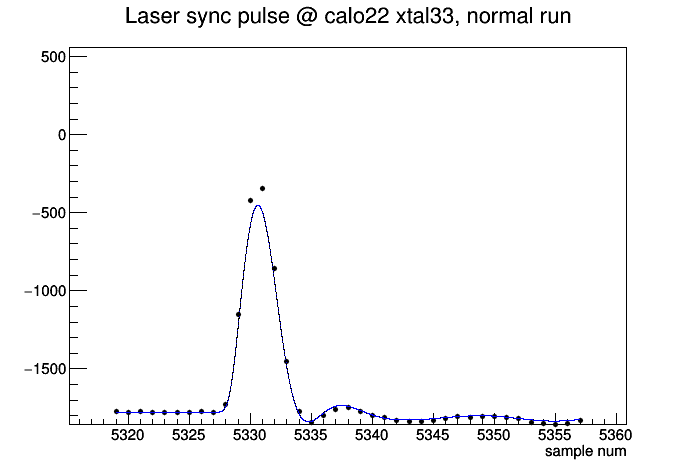

In [20]:

# 22 33 normal run
samples = [-1776,-1778,-1775,-1780,-1779,-1780,-1780,-1776,-1780,-1731,-1149,-423,-345,-855,-1450,-1775,-1842,-1800,-1760,-1745,-1773,-1800,-1814,-1832,-1838,-1834,-1832,-1819,-1808,-1812,-1803,-1806,-1809,-1819,-1841,-1848,-1853,-1850,-1833]
start_time = 5319
pedestal = -1778.34
energy = 3465.68
time = 5330.63
chi2 = 16
title = 'Laser sync pulse @ calo22 xtal33, normal run'
tag = trans_tag_man('1_32_169_107',samples,start_time,energy,time,pedestal,chi2,title)
graph = viewer.plot_manualy(*tag)
# graph.SetTitle('Laser sync pulse @ Calo22 Xtal33 (The normal run)')
# c = r.TCanvas()
graph[0].Draw()
# print (graph[0])
# c.Draw()

[['Laser hit', 't_{0}: 5324.920', 'E_{0}: 1636.9']] ['Pedestal: -1773.9', '#chi^{2}: 16.0']
0.6
623.9200000000001


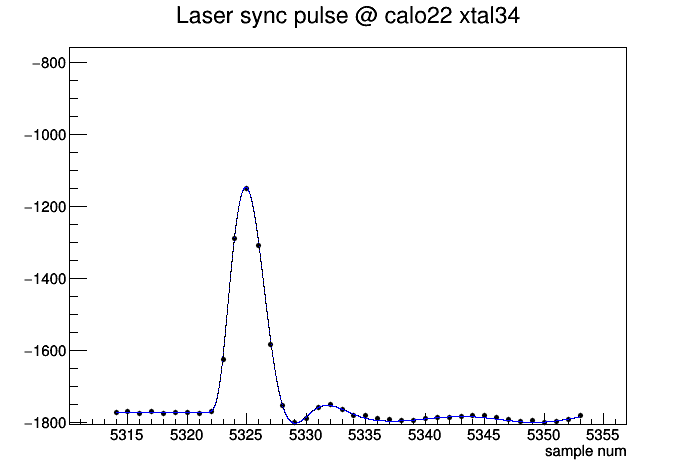

In [28]:

# 22 33 normal run
samples = [-1773,-1771,-1776,-1771,-1776,-1773,-1774,-1776,-1771,-1625,-1290,-1150,-1308,-1585,-1753,-1802,-1790,-1759,-1752,-1765,-1782,-1782,-1789,-1792,-1796,-1794,-1790,-1787,-1787,-1783,-1782,-1780,-1788,-1791,-1799,-1796,-1800,-1799,-1792,-1782]
start_time = 5314
pedestal = -1773.92
energy = 1636.89
time = 5324.92
chi2 = 16
title = 'Laser sync pulse @ calo22 xtal34'
tag = trans_tag_man('1_32_169_107',samples,start_time,energy,time,pedestal,chi2,title)
graph = viewer.plot_manualy(*tag)
# graph.SetTitle('Laser sync pulse @ Calo22 Xtal33 (The normal run)')
# c = r.TCanvas()
graph[0].Draw()
# print (graph[0])
# c.Draw()
print (max(samples) - pedestal)

[['Laser hit', 't_{0}: 5325.120', 'E_{0}: 276.1']] ['Pedestal: -1776.5', '#chi^{2}: 16.0']
0.6


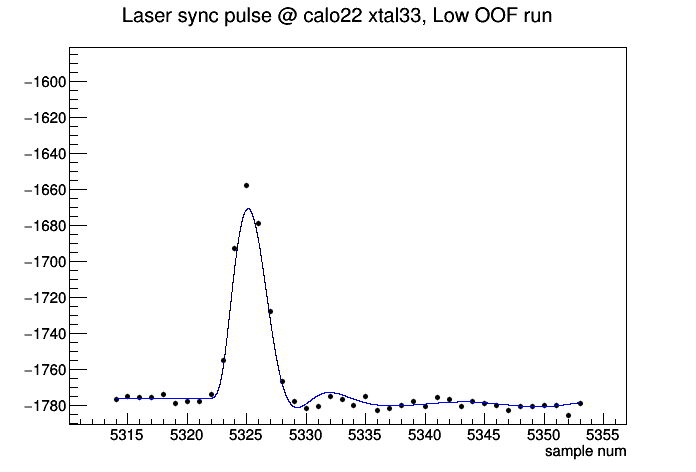

In [21]:

# 22 33 normal run
samples = [-1777,-1775,-1776,-1776,-1774,-1779,-1778,-1778,-1774,-1755,-1693,-1658,-1679,-1728,-1767,-1778,-1782,-1781,-1775,-1777,-1780,-1775,-1783,-1782,-1780,-1778,-1781,-1776,-1777,-1781,-1778,-1779,-1780,-1783,-1781,-1781,-1780,-1780,-1786,-1779]
start_time = 5314
pedestal = -1776.55
energy = 276.138
time = 5325.12
chi2 = 16
title = 'Laser sync pulse @ calo22 xtal33, Low OOF run'
tag = trans_tag_man('1_32_169_107',samples,start_time,energy,time,pedestal,chi2,title)
graph = viewer.plot_manualy(*tag)
# graph.SetTitle('Laser sync pulse @ Calo22 Xtal33 (The normal run)')
# c = r.TCanvas()
graph[0].Draw()
# print (graph[0])
# c.Draw()

[['Laser hit', 't_{0}: 5330.630', 'E_{0}: 3465.7']] ['Pedestal: -1778.3', '#chi^{2}: 16.0']
0.6
1433.34


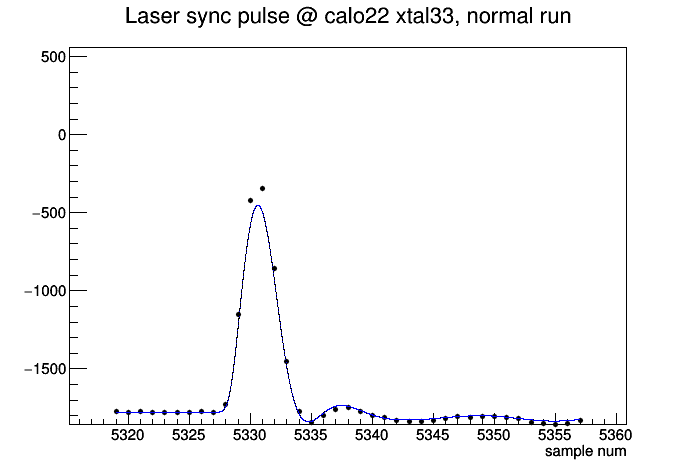

In [29]:

# 22 33 normal run
samples = [-1776,-1778,-1775,-1780,-1779,-1780,-1780,-1776,-1780,-1731,-1149,-423,-345,-855,-1450,-1775,-1842,-1800,-1760,-1745,-1773,-1800,-1814,-1832,-1838,-1834,-1832,-1819,-1808,-1812,-1803,-1806,-1809,-1819,-1841,-1848,-1853,-1850,-1833]
start_time = 5319
pedestal = -1778.34
energy = 3465.68
time = 5330.63
chi2 = 16
title = 'Laser sync pulse @ calo22 xtal33, normal run'
tag = trans_tag_man('1_32_169_107',samples,start_time,energy,time,pedestal,chi2,title)
graph = viewer.plot_manualy(*tag)
# graph.SetTitle('Laser sync pulse @ Calo22 Xtal33 (The normal run)')
# c = r.TCanvas()
graph[0].Draw()
# print (graph[0])
# c.Draw()
print (max(samples) - pedestal)

[['Laser hit', 't_{0}: 5322.060', 'E_{0}: 266.8']] ['Pedestal: -1776.1', '#chi^{2}: 16.0']
0.6


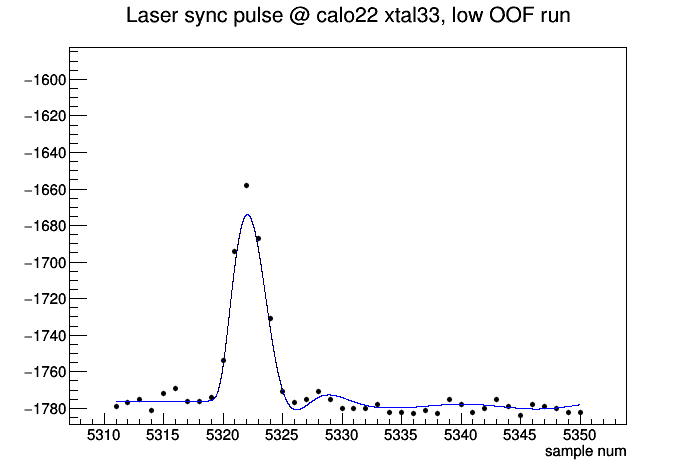

In [27]:

# 22 33 normal run
samples = [-1779,-1777,-1775,-1781,-1772,-1769,-1776,-1776,-1774,-1754,-1694,-1658,-1687,-1731,-1771,-1777,-1775,-1771,-1775,-1780,-1780,-1780,-1778,-1782,-1782,-1783,-1781,-1783,-1775,-1778,-1782,-1780,-1775,-1779,-1784,-1778,-1779,-1780,-1782,-1782]
start_time = 5311
pedestal = -1776.07
energy = 266.788
time = 5322.06
chi2 = 16
title = 'Laser sync pulse @ calo22 xtal33, low OOF run'
tag = trans_tag_man('1_32_169_107',samples,start_time,energy,time,pedestal,chi2,title)
graph = viewer.plot_manualy(*tag)
# graph.SetTitle('Laser sync pulse @ Calo22 Xtal33 (The normal run)')
# c = r.TCanvas()
graph[0].Draw()
# print (graph[0])
# c.Draw()

In [49]:

# cs = viewer_official.plot_xtal(1,33,1,79,True)
# cs[0].Draw()

3596
124,107,105
[['Beam hit', 't_{0}: 150164.614', 'E_{0}: 88.8']] ['Pedestal: -1767.9', '#chi^{2}: 8.4']
0.6
3596
124,107,105
[['Beam hit', 't_{0}: 150229.970', 'E_{0}: 1199.1']] ['Pedestal: -1767.9', '#chi^{2}: 8.4']
0.6


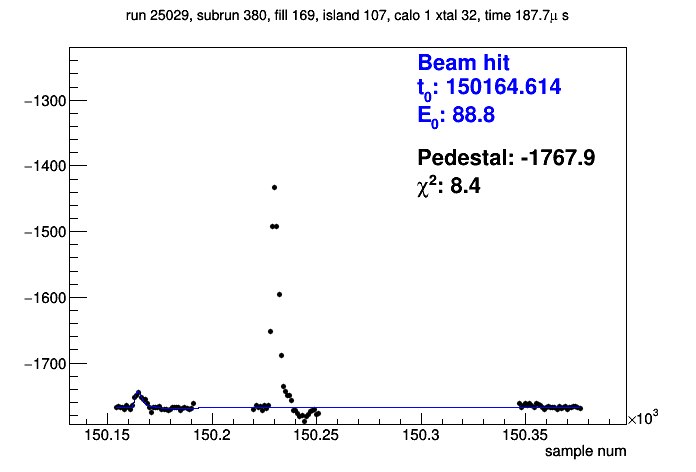

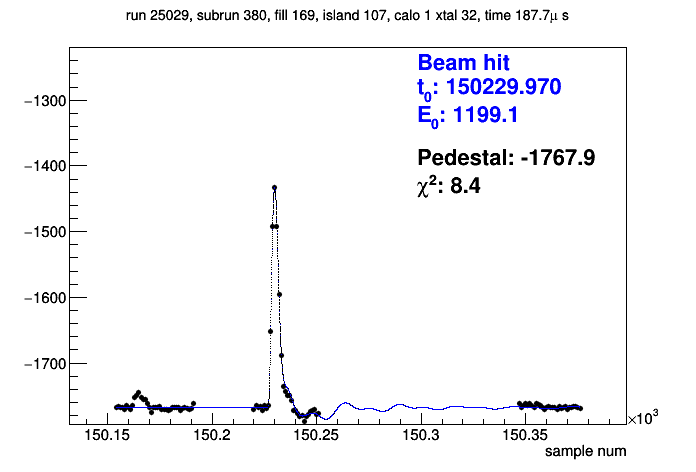

In [3]:


# # len([-1751,-1756,-1756,-1755,-1753,-1746,-1743,-1747,-1746,-1730,-1720,-1718,-1734,-1740,-1743,-1749,-1746,-1739,-1737,-1738,-1742,-1751,-1761,-1752,-1754,-1753,-1748,-1750,-1755,-1755,-1757,-1751,-1750,-1747,-1748,-1742,-1749,-1749,-1744,-1741,-1747,-1741,-1753,-1751,-1750,-1747,-1752,-1748,-1756,-1749,-1758,-1748,-1754,-1756,-1754,-1750,-1741,-1735,-1746,-1743,-1752,-1749])
# # len([-1787,-1793,-1795,-1799,-1797,-1799,-1791,-1800,-1794,-1769,-1737,-1726,-1732,-1760,-1777,-1783,-1783,-1791,-1788,-1793,-1800,-1797,-1797,-1793,-1799,-1796,-1804,-1798,-1796,-1793,-1794,-1803,-1801,-1799,-1795,-1803,-1793,-1795,-1795,-1783,-1774,-1780,-1780,-1786,-1790,-1793,-1790,-1793,-1791,-1803,-1794,-1793,-1791,-1800,-1800,-1799,-1802,-1800,-1794,-1796,-1792,-1798])


# def MakeSampleGraph(self,traces,times):        
#         sample_g = r.TGraph()        
#         sample_g.SetName('sample graph')
#         sample_g.SetMarkerStyle(20)
#         sample_g.SetMarkerSize(0.5)
#         for trace,time in zip(traces,times):
#             sample_g.SetPoint(sample_g.GetN(), time, trace)
#         return sample_g

# tag = trans_tag('1_35_87_121')
tag = trans_tag('1_32_169_107',trict_island=False)
# cs = viewer_both30.plot_xtal(*tag)
# cs[0].Draw()
# cs3 = viewer_official.plot_xtal(*tag)
# cs3[0].Draw()
# cs2 = viewer_both30.draw_calo(*tag)
# cs2[0].Draw()

cs4 = viewer_both30_predebug.plot_xtal(*tag)
cs4[0].Draw()
cs5 = viewer_both30_predebug_after.plot_xtal(*tag)
cs5[0].Draw()

256481
121
[['Beam hit', 't_{0}: 152459.935', 'E_{0}: 3127.9'], ['Beam hit', 't_{1}: 152471.867', 'E_{1}: 1731.9']] ['Pedestal: -1800.7', '#chi^{2}: 95.1']
0.6


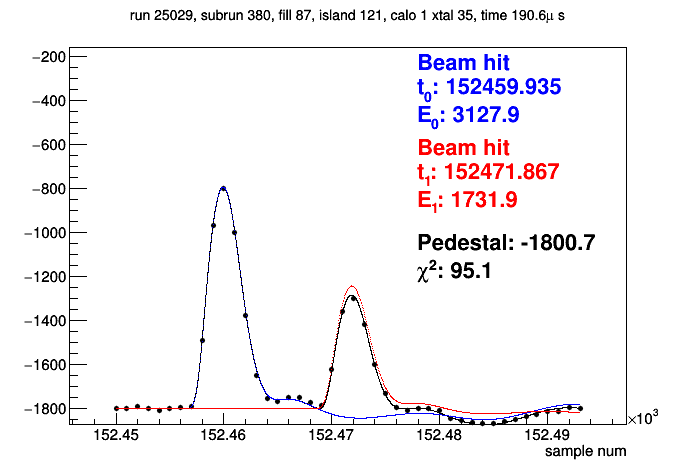

In [22]:

tag = trans_tag('1_35_87_121')
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
# cs2 = viewer.draw_calo(*tag)
# cs2[0].Draw()
# cs3 = viewer_official.plot_xtal(*tag)
# cs3[0].Draw()

256481
121
[['Beam hit', 't_{0}: 152459.935', 'E_{0}: 3127.9'], ['Beam hit', 't_{1}: 152471.867', 'E_{1}: 1731.9']] ['Pedestal: -1800.7', '#chi^{2}: 95.1']
0.6


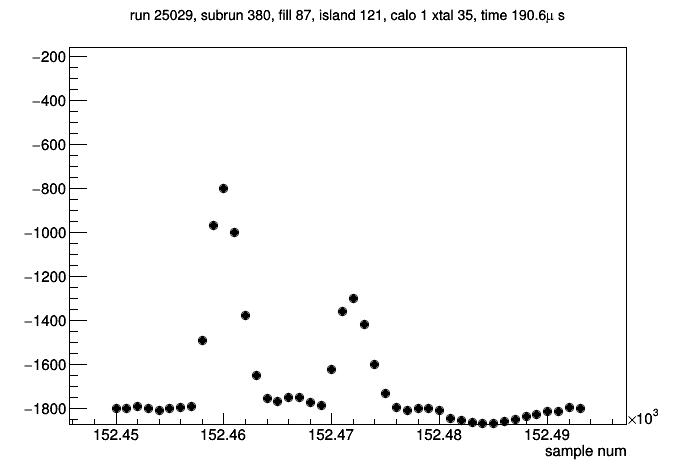

In [12]:

tag = trans_tag('1_35_87_121')
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
# cs2 = viewer.draw_calo(*tag)
# cs2[0].Draw()
# cs3 = viewer_official.plot_xtal(*tag)
# cs3[0].Draw()

256481
121
[['Beam hit', 't_{0}: 152459.935', 'E_{0}: 3127.9'], ['Beam hit', 't_{1}: 152471.867', 'E_{1}: 1731.9']] ['Pedestal: -1800.7', '#chi^{2}: 95.1']
0.6


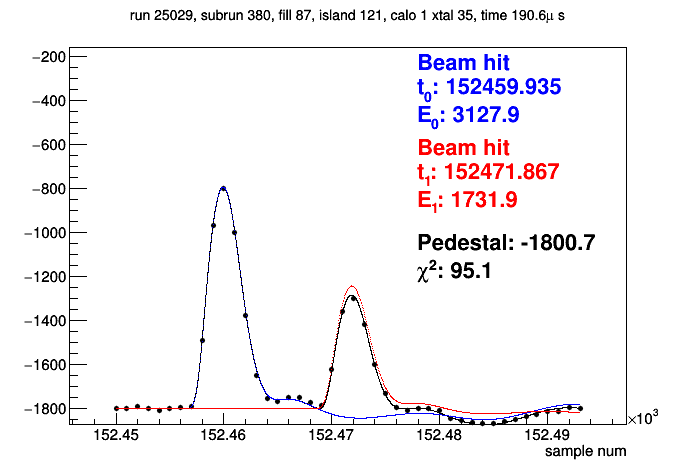

In [4]:

tag = trans_tag('1_35_87_121')
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
# cs2 = viewer.draw_calo(*tag)
# cs2[0].Draw()
# cs3 = viewer_official.plot_xtal(*tag)
# cs3[0].Draw()

[['Pre-selection fit', 't (raw): 152460.000', 'E (raw): 3327.9'], ['Pre-selection fit', 't (raw): 152472.000', 'E (raw): 1931.9']] ['Pedestal: -1800.7', '#chi^{2}: 95.1']
0.6


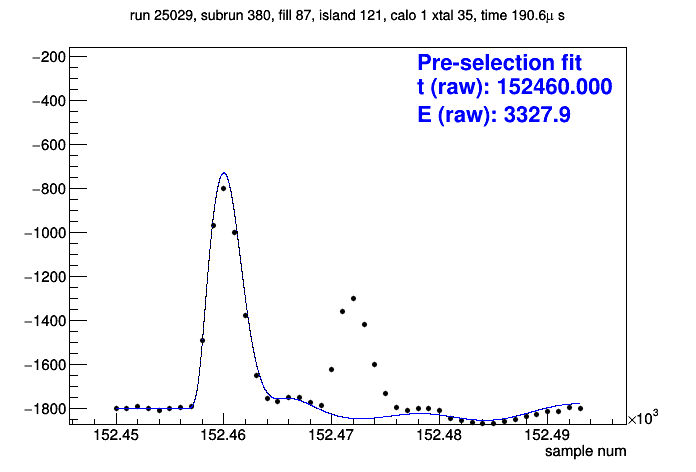

In [132]:

tag = trans_tag('1_35_87_121')
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
# cs2 = viewer.draw_calo(*tag)
# cs2[0].Draw()
# cs3 = viewer_official.plot_xtal(*tag)
# cs3[0].Draw()

[['Beam hit', 't_{0}: 113543.505', 'E_{0}: 672.3'], ['Beam hit', 't_{1}: 113530.890', 'E_{1}: 210.2']] ['Pedestal: -1807.2', '#chi^{2}: 36.3']
[['Beam hit', 't_{0}: 113543.498', 'E_{0}: 634.8']] ['Pedestal: -1801.3', '#chi^{2}: 174.3']


Warning in <TCanvas::Constructor>: Deleting canvas with same name: calo1


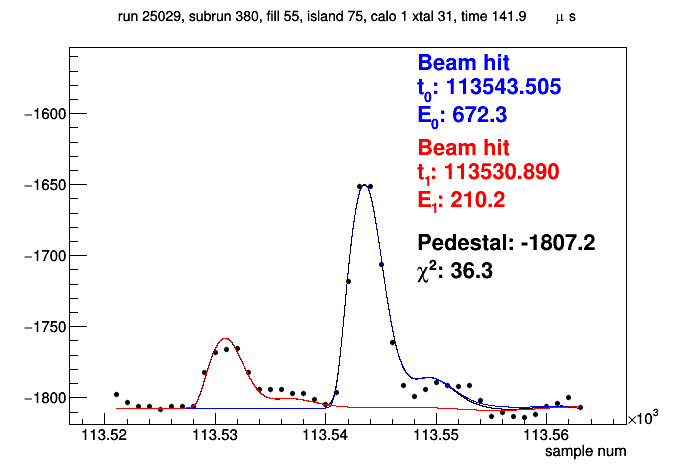

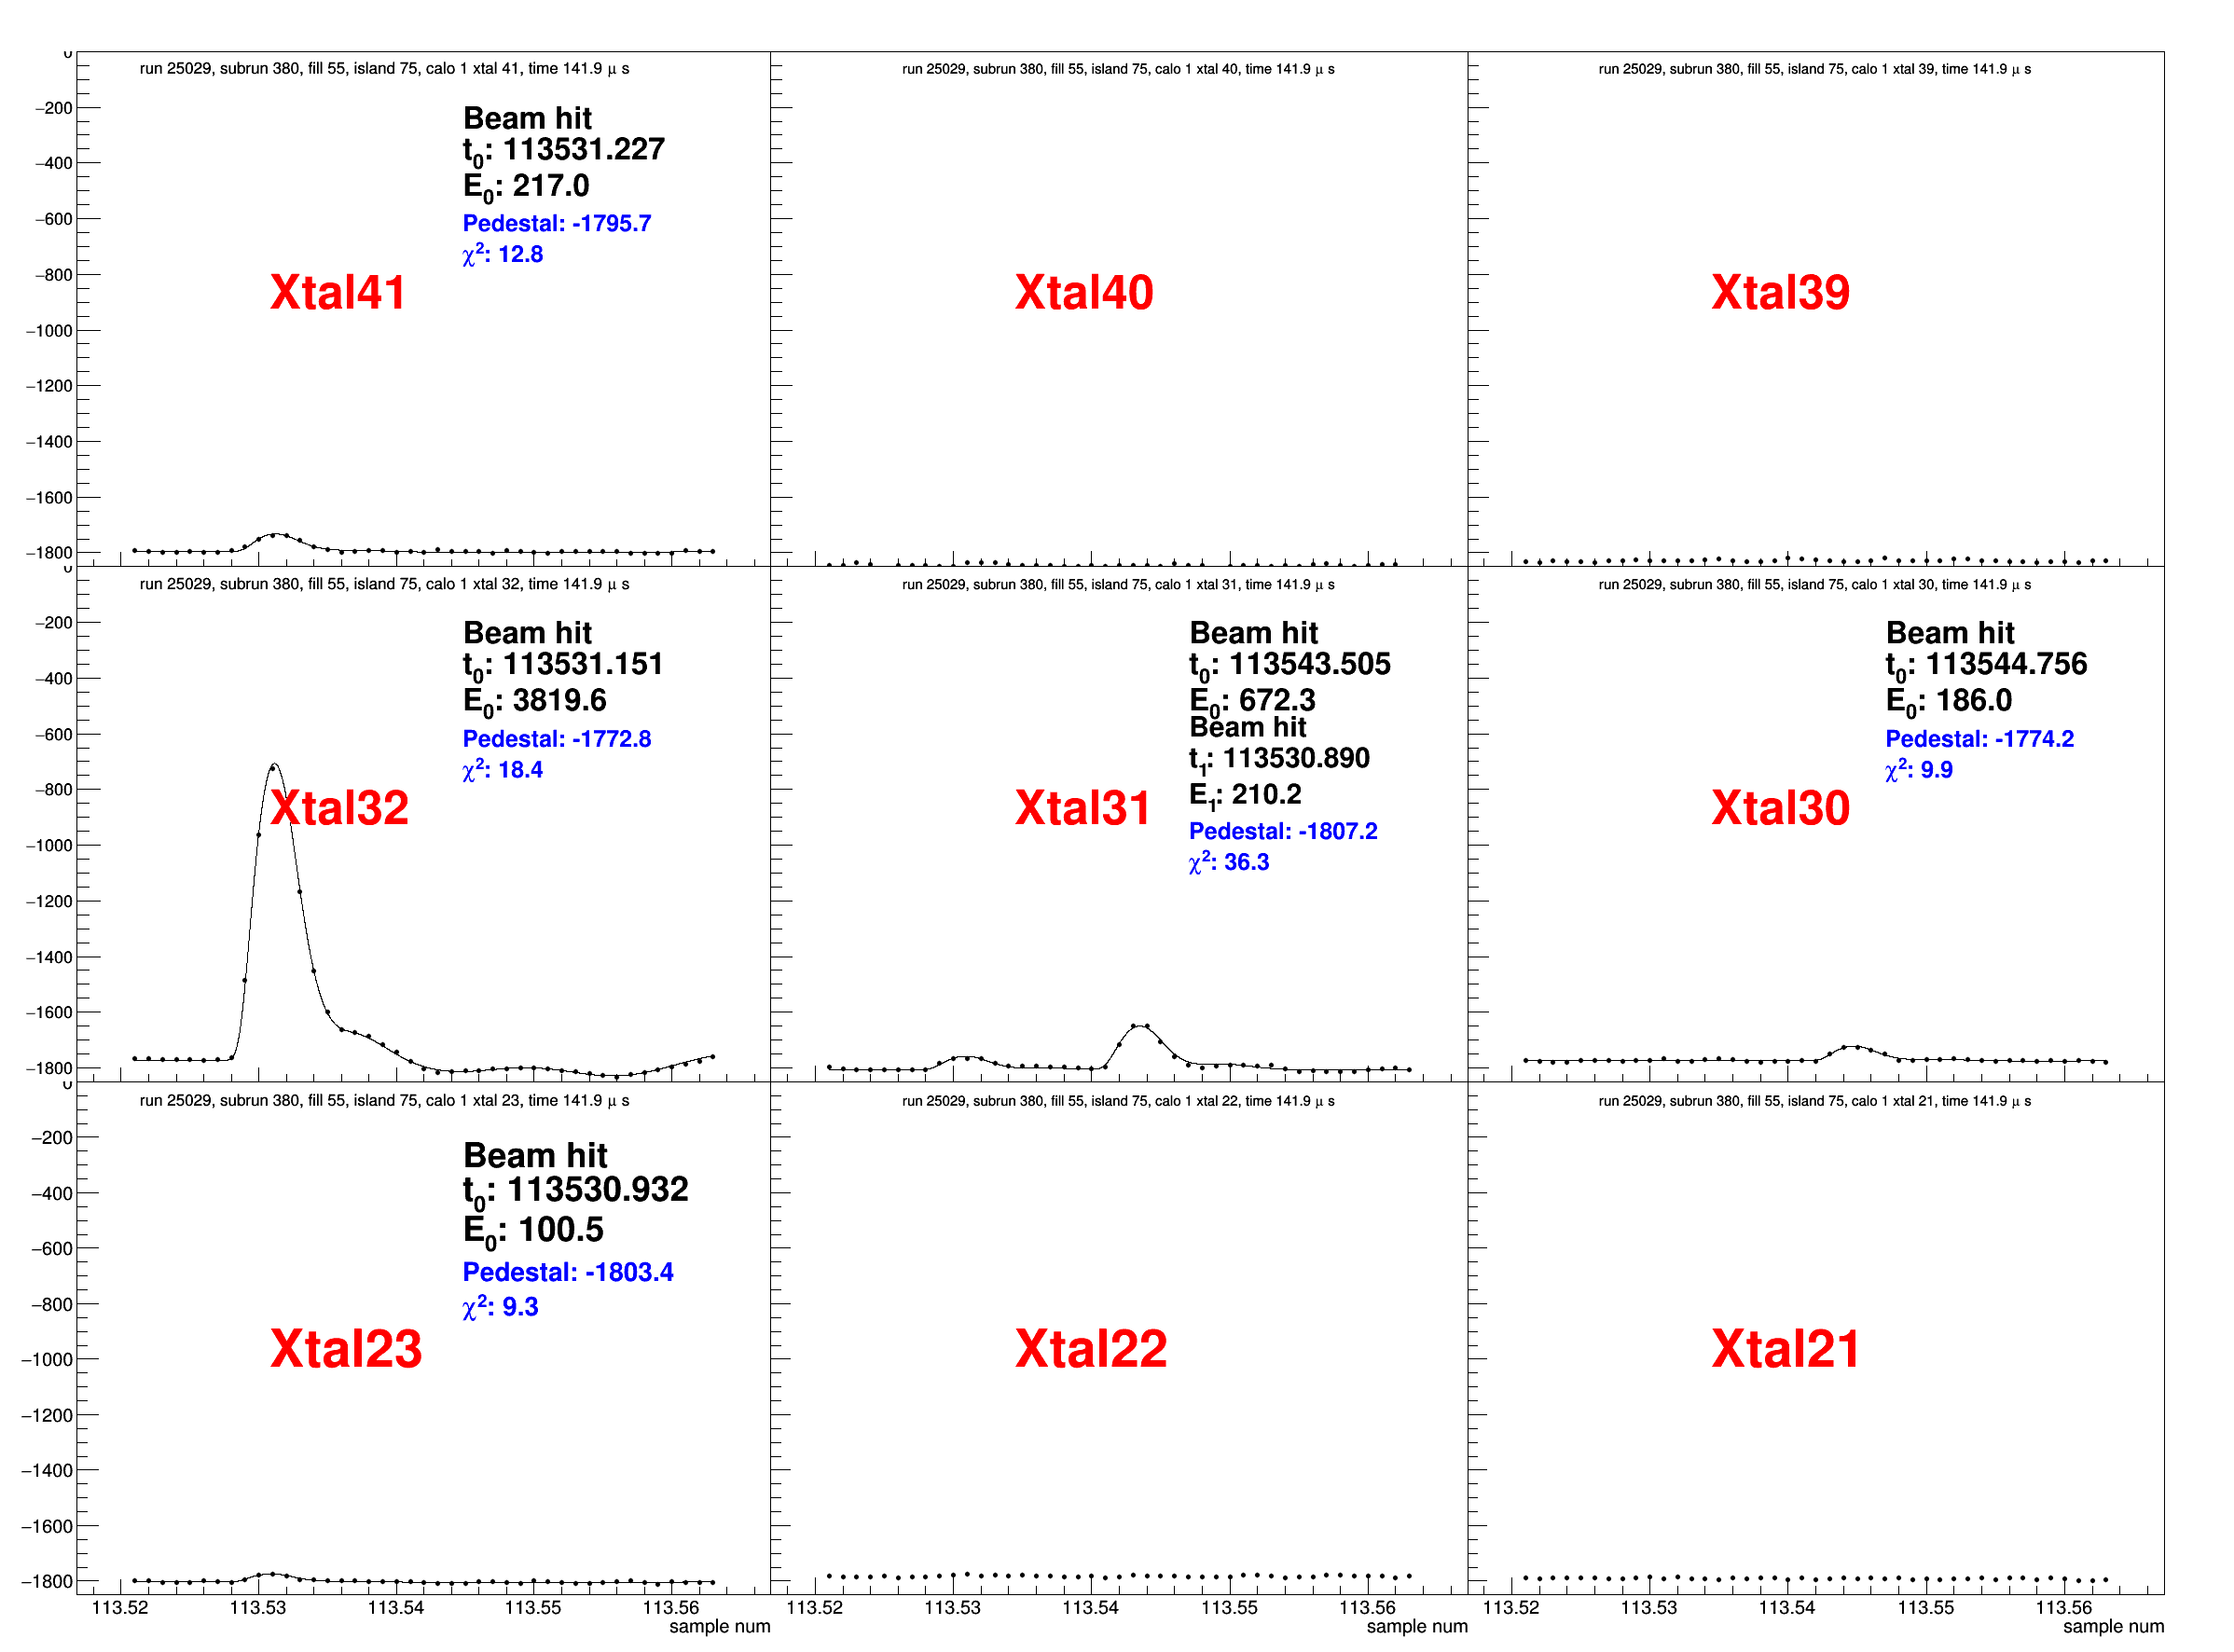

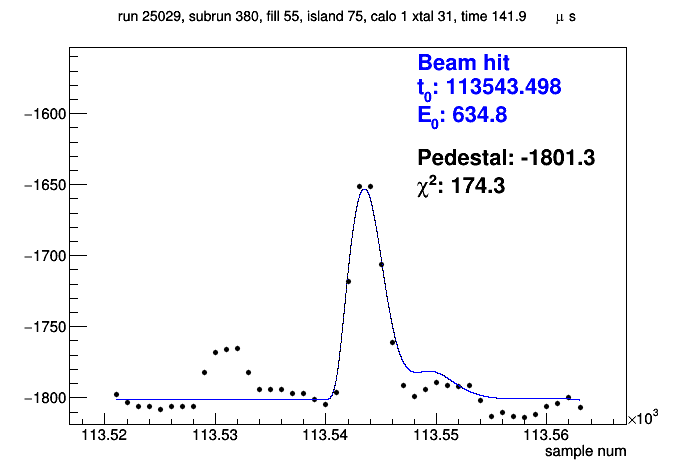

In [39]:

tag = trans_tag('1_31_55_75')
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
cs2 = viewer.draw_calo(*tag)
cs2[0].Draw()
cs3 = viewer_official.plot_xtal(*tag)
cs3[0].Draw()

[['Beam hit', 't_{0}: 118671.250', 'E_{0}: 843.0'], ['Beam hit', 't_{1}: 118648.121', 'E_{1}: 152.4']] ['Pedestal: -1796.4', '#chi^{2}: 16.3']
[['Beam hit', 't_{0}: 118671.247', 'E_{0}: 819.1']] ['Pedestal: -1793.1', '#chi^{2}: 108.6']


Warning in <TCanvas::Constructor>: Deleting canvas with same name: calo1


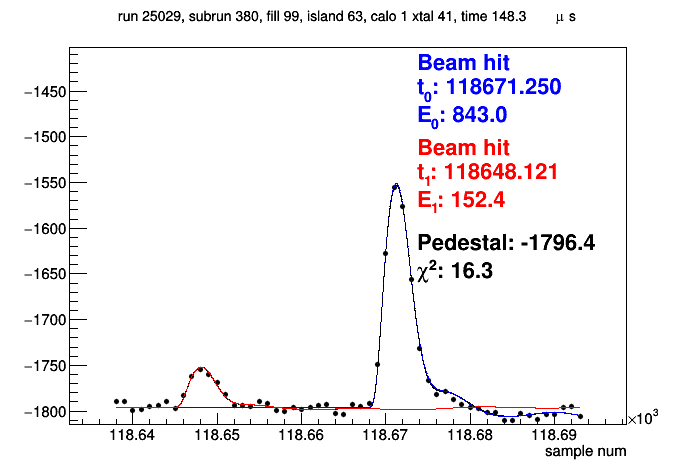

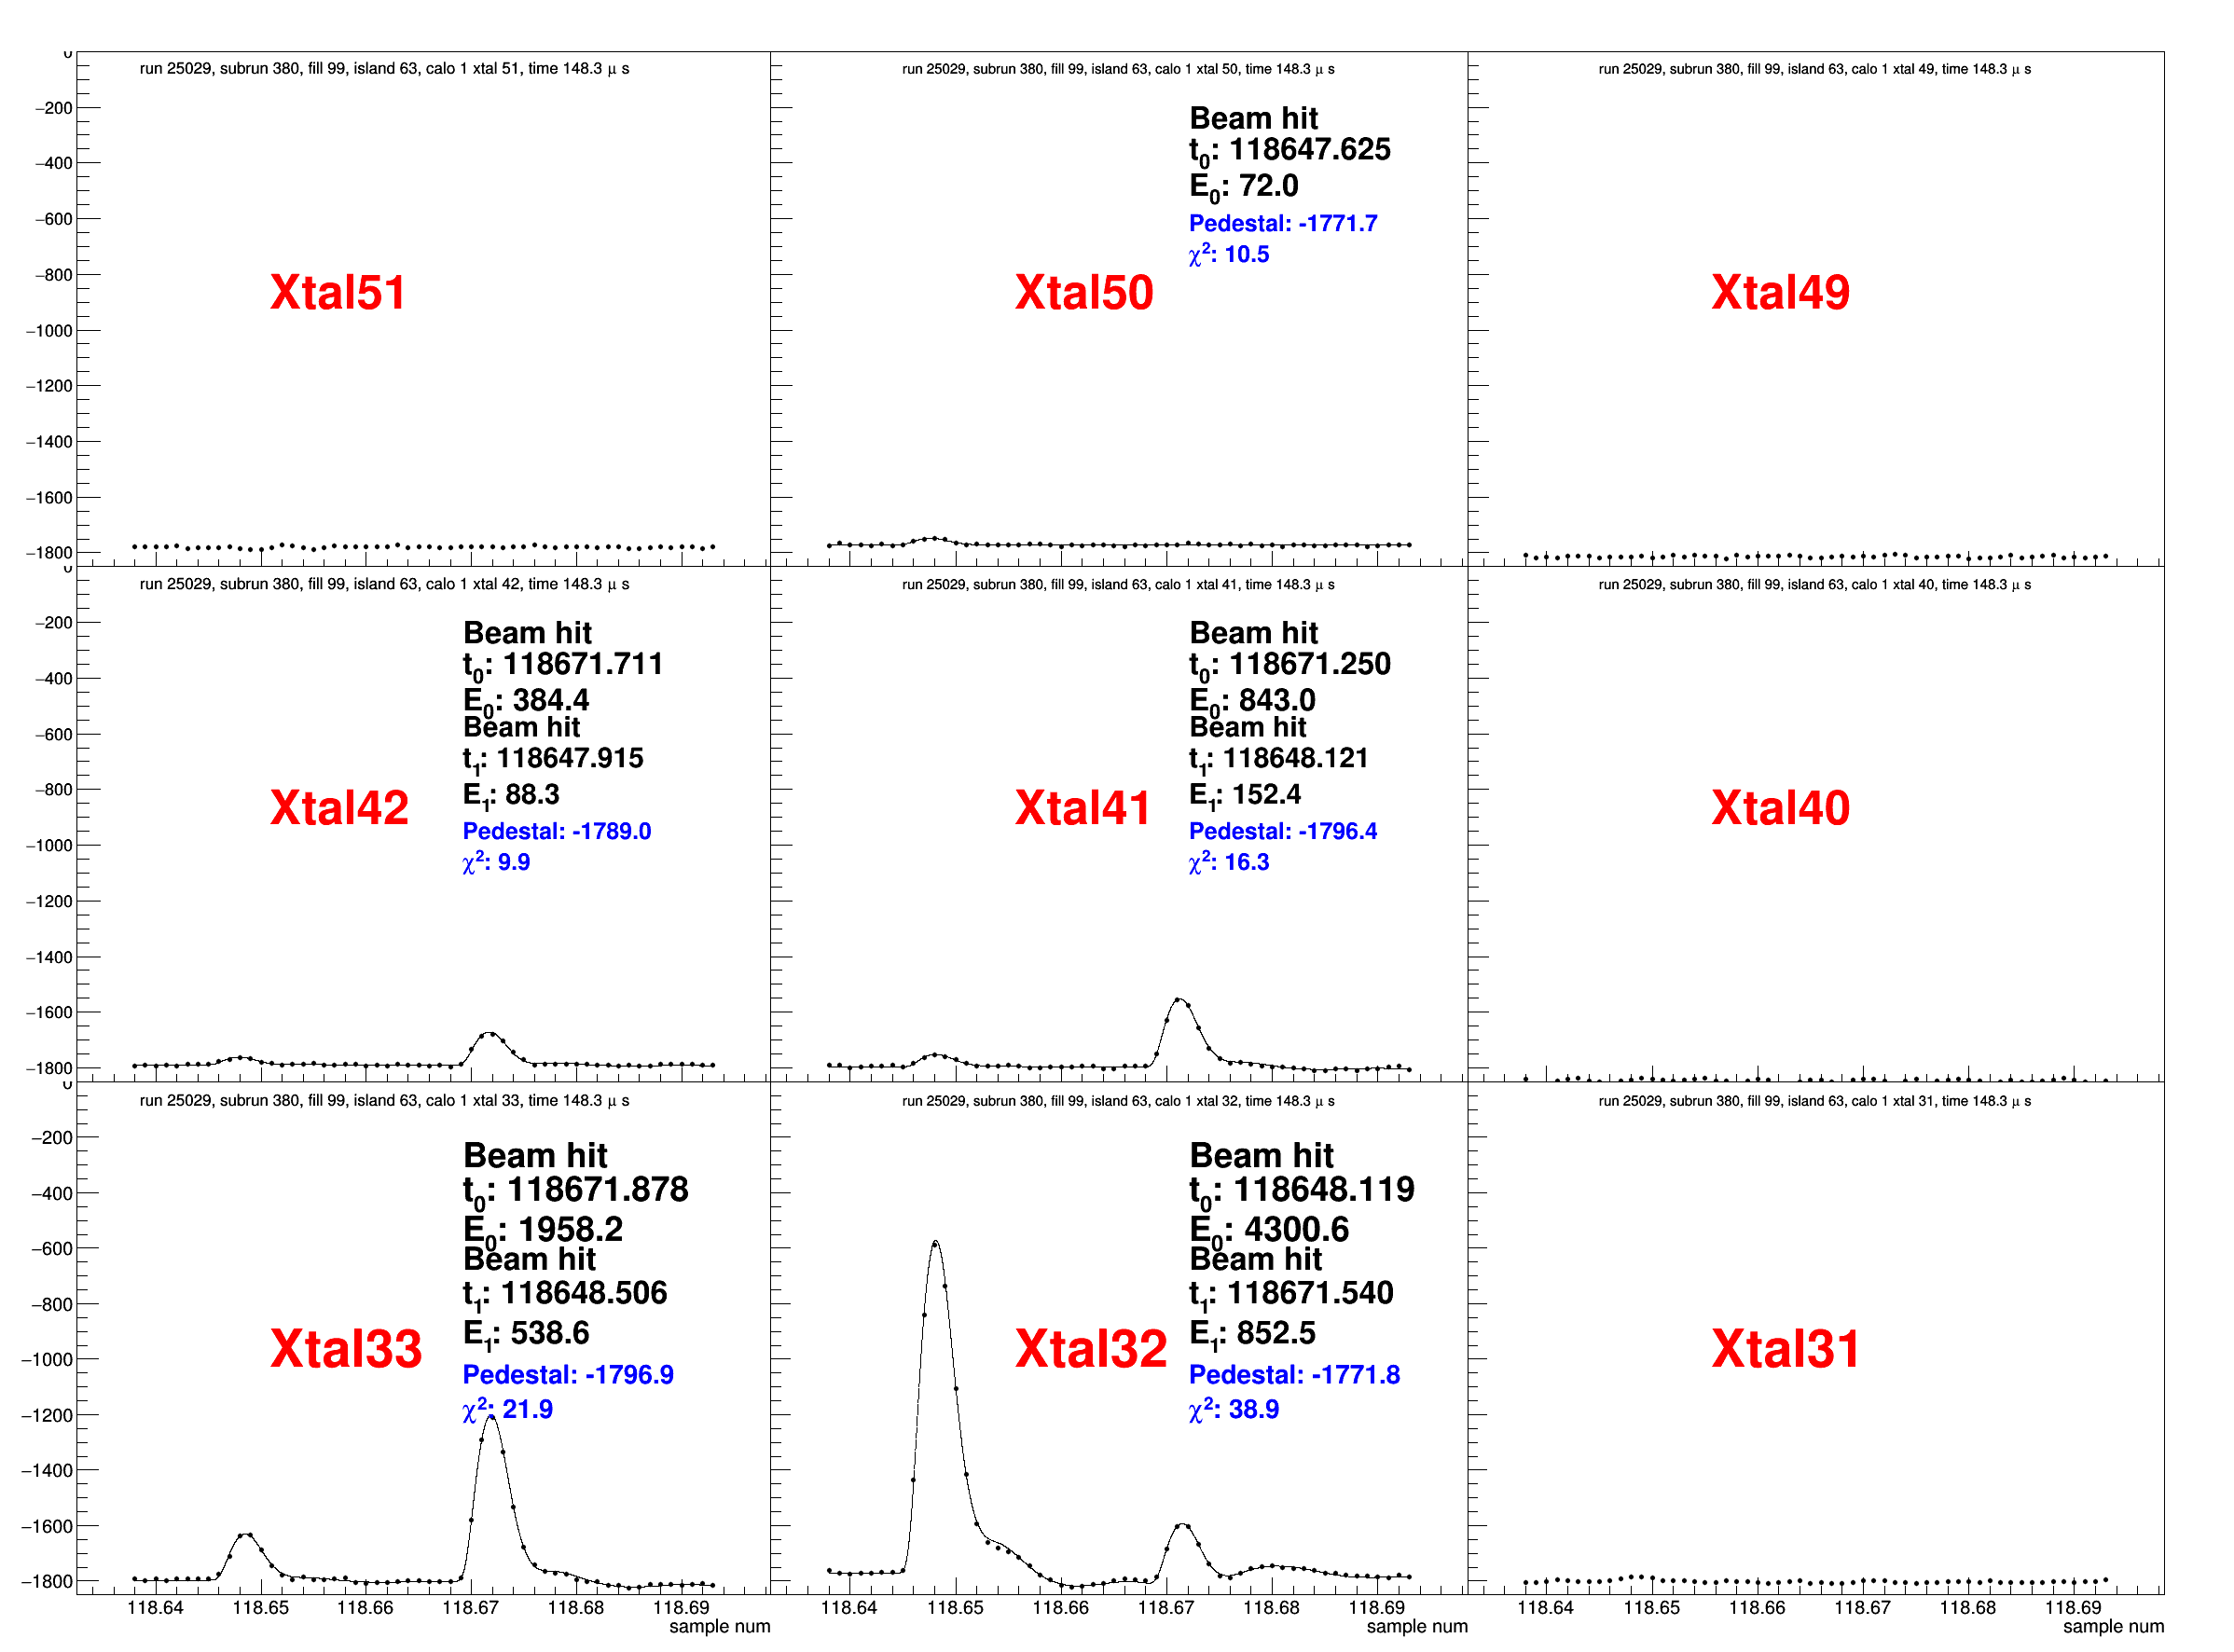

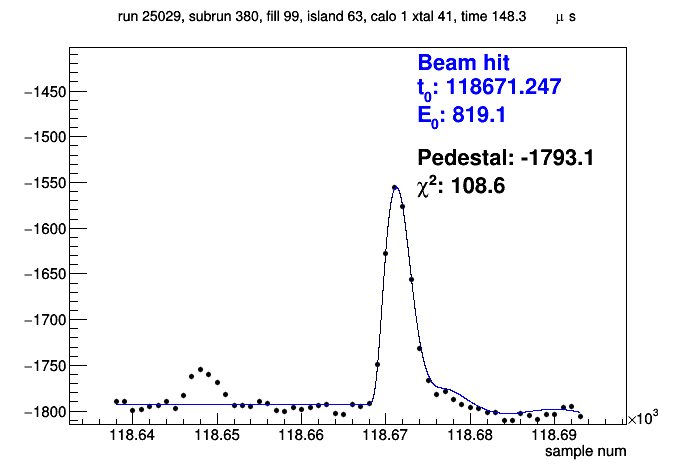

In [41]:

tag = trans_tag('1_41_99_63')
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
cs2 = viewer.draw_calo(*tag)
cs2[0].Draw()
cs3 = viewer_official.plot_xtal(*tag)
cs3[0].Draw()

(2, 3, [16, 17, 25, 26, 34, 35])
[['Beam hit', 't_{0}: 170462.128', 'E_{0}: 84.3'], ['Beam hit', 't_{1}: 170459.727', 'E_{1}: 63.9']] ['Pedestal: -1762.2', '#chi^{2}: 55.6']
[['Beam hit', 't_{0}: 170461.182', 'E_{0}: 122.9']] ['Pedestal: -1761.3', '#chi^{2}: 59.5']


Warning in <TCanvas::Constructor>: Deleting canvas with same name: calo1


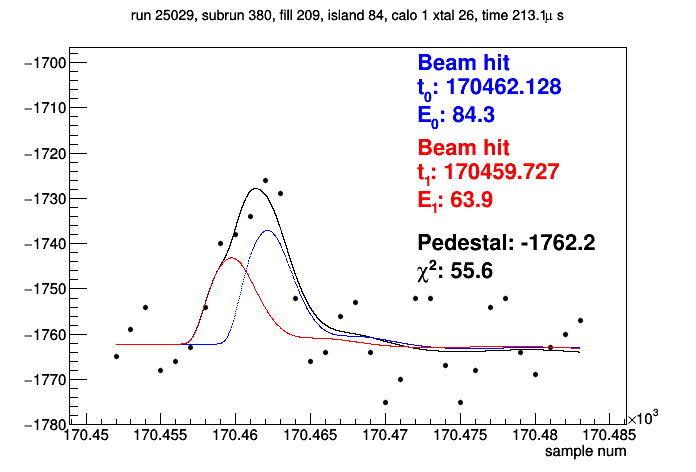

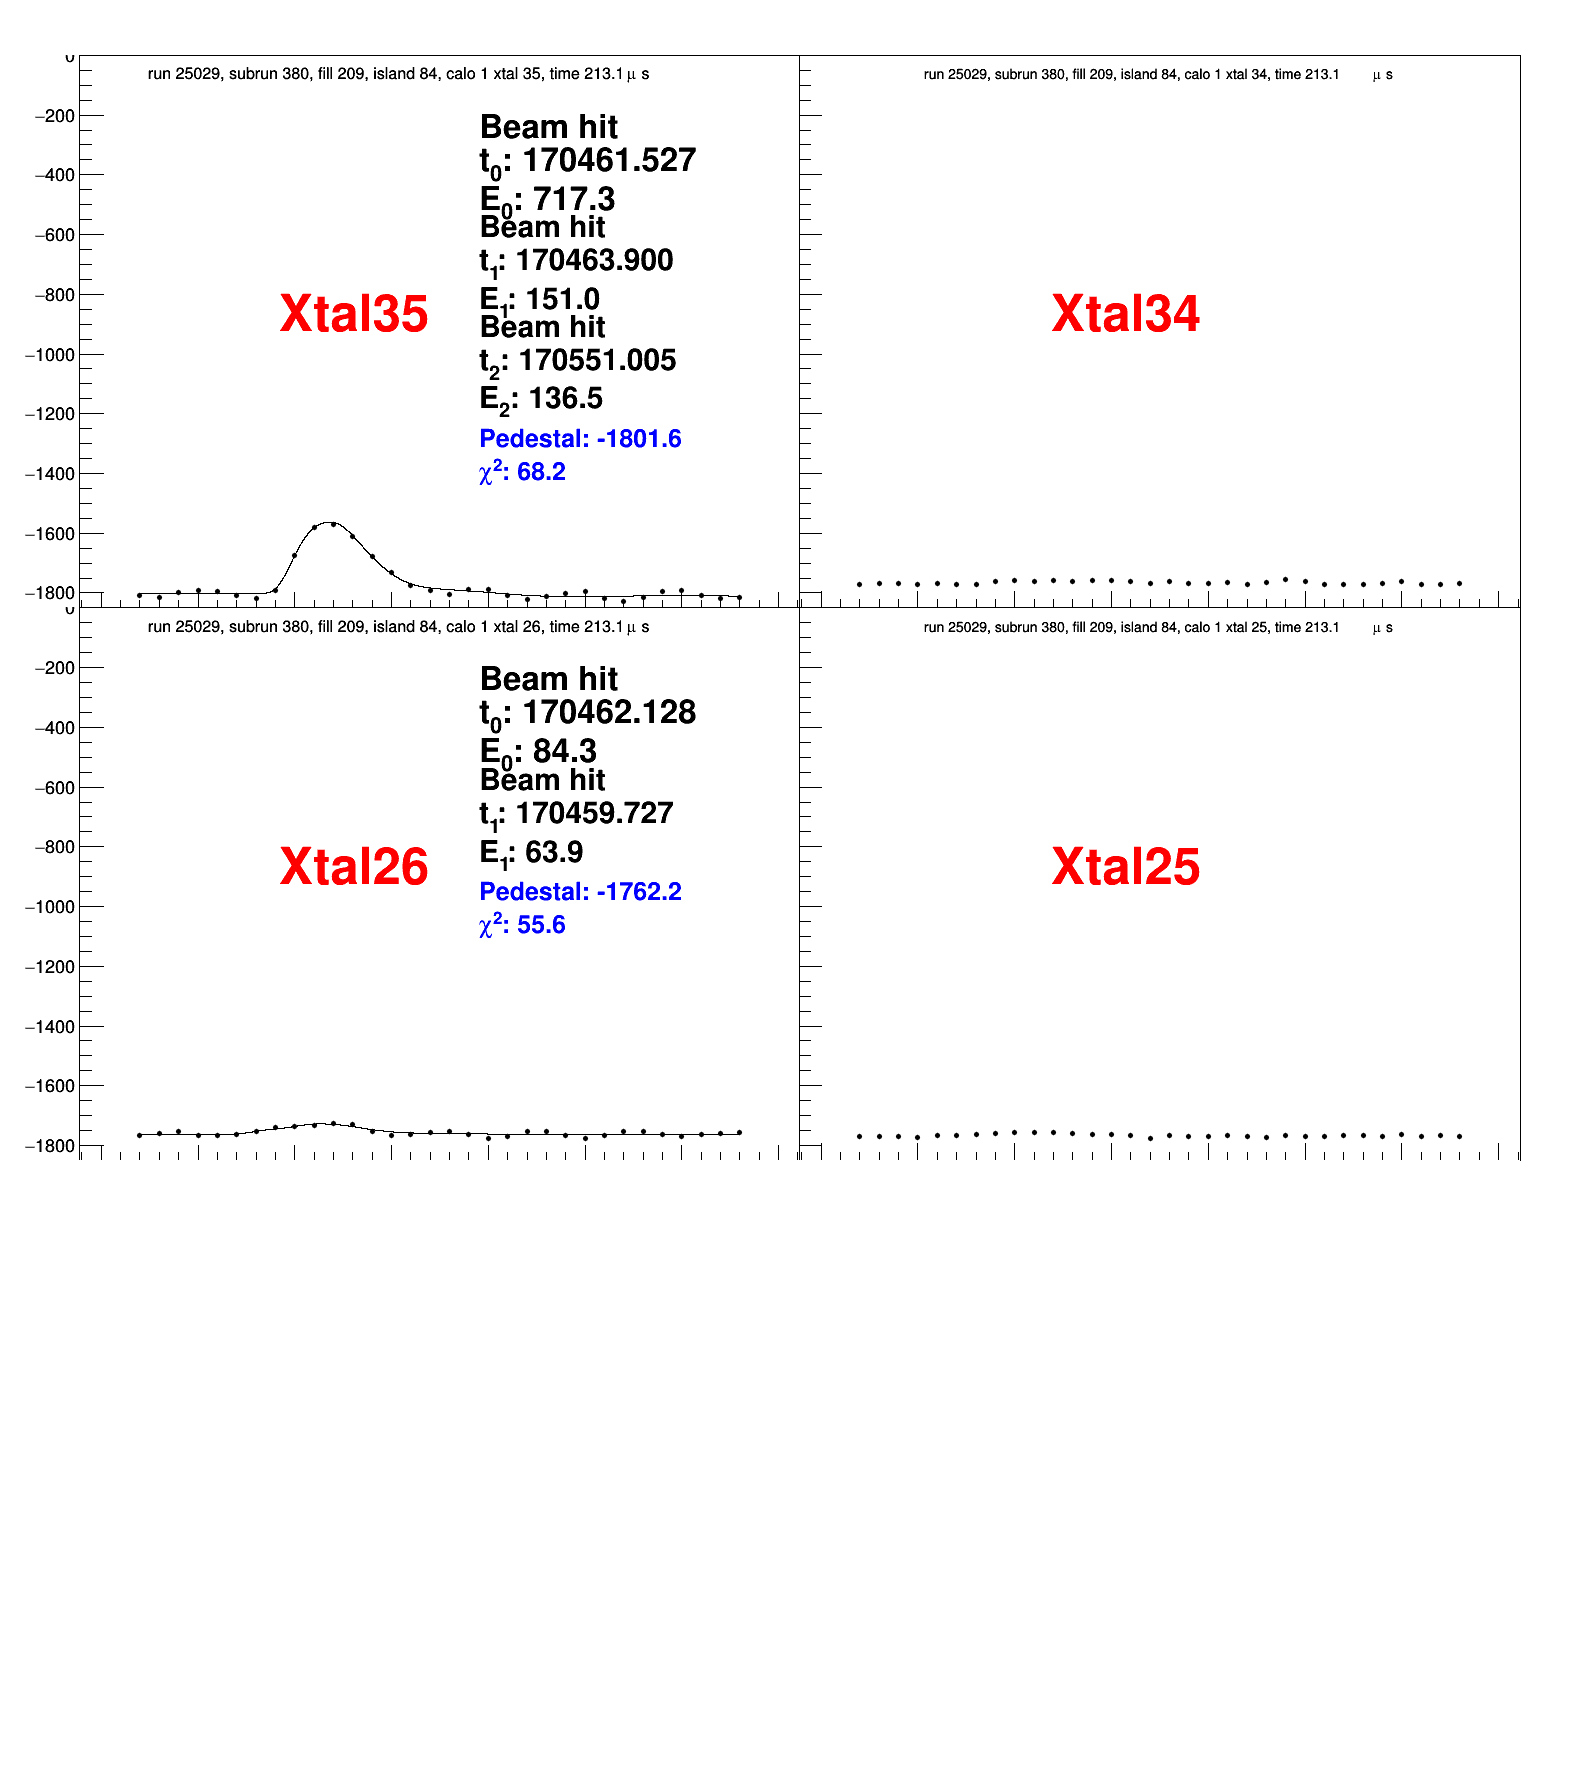

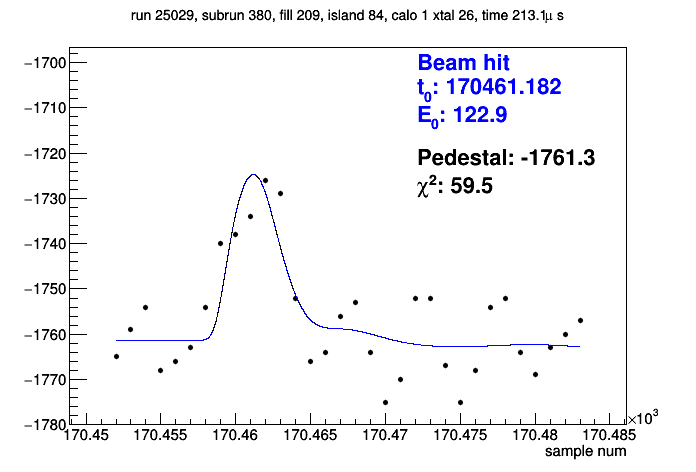

In [54]:
print (get_neighbor(26))
tag = trans_tag('1_26_209_84')
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
cs2 = viewer.draw_calo(*tag)
cs2[0].Draw()
cs3 = viewer_official.plot_xtal(*tag)
cs3[0].Draw()

[['Beam hit', 't_{0}: 300557.475', 'E_{0}: 356.1'], ['Beam hit', 't_{1}: 300554.790', 'E_{1}: 70.2']] ['Pedestal: -1784.2', '#chi^{2}: 32.3']
[['Beam hit', 't_{0}: 300557.215', 'E_{0}: 387.9']] ['Pedestal: -1782.8', '#chi^{2}: 44.5']


Warning in <TCanvas::Constructor>: Deleting canvas with same name: calo1


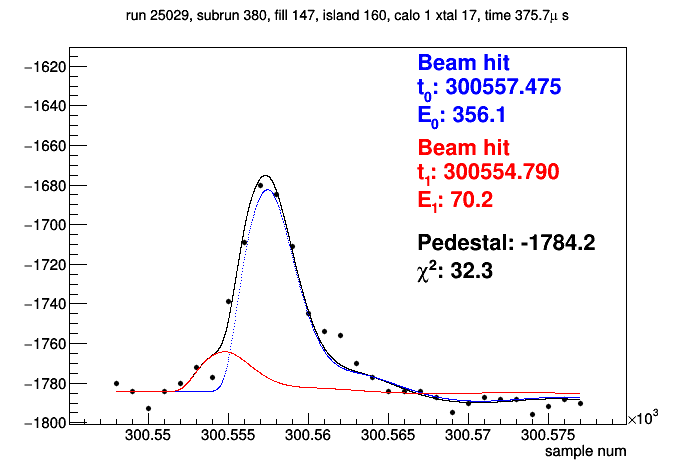

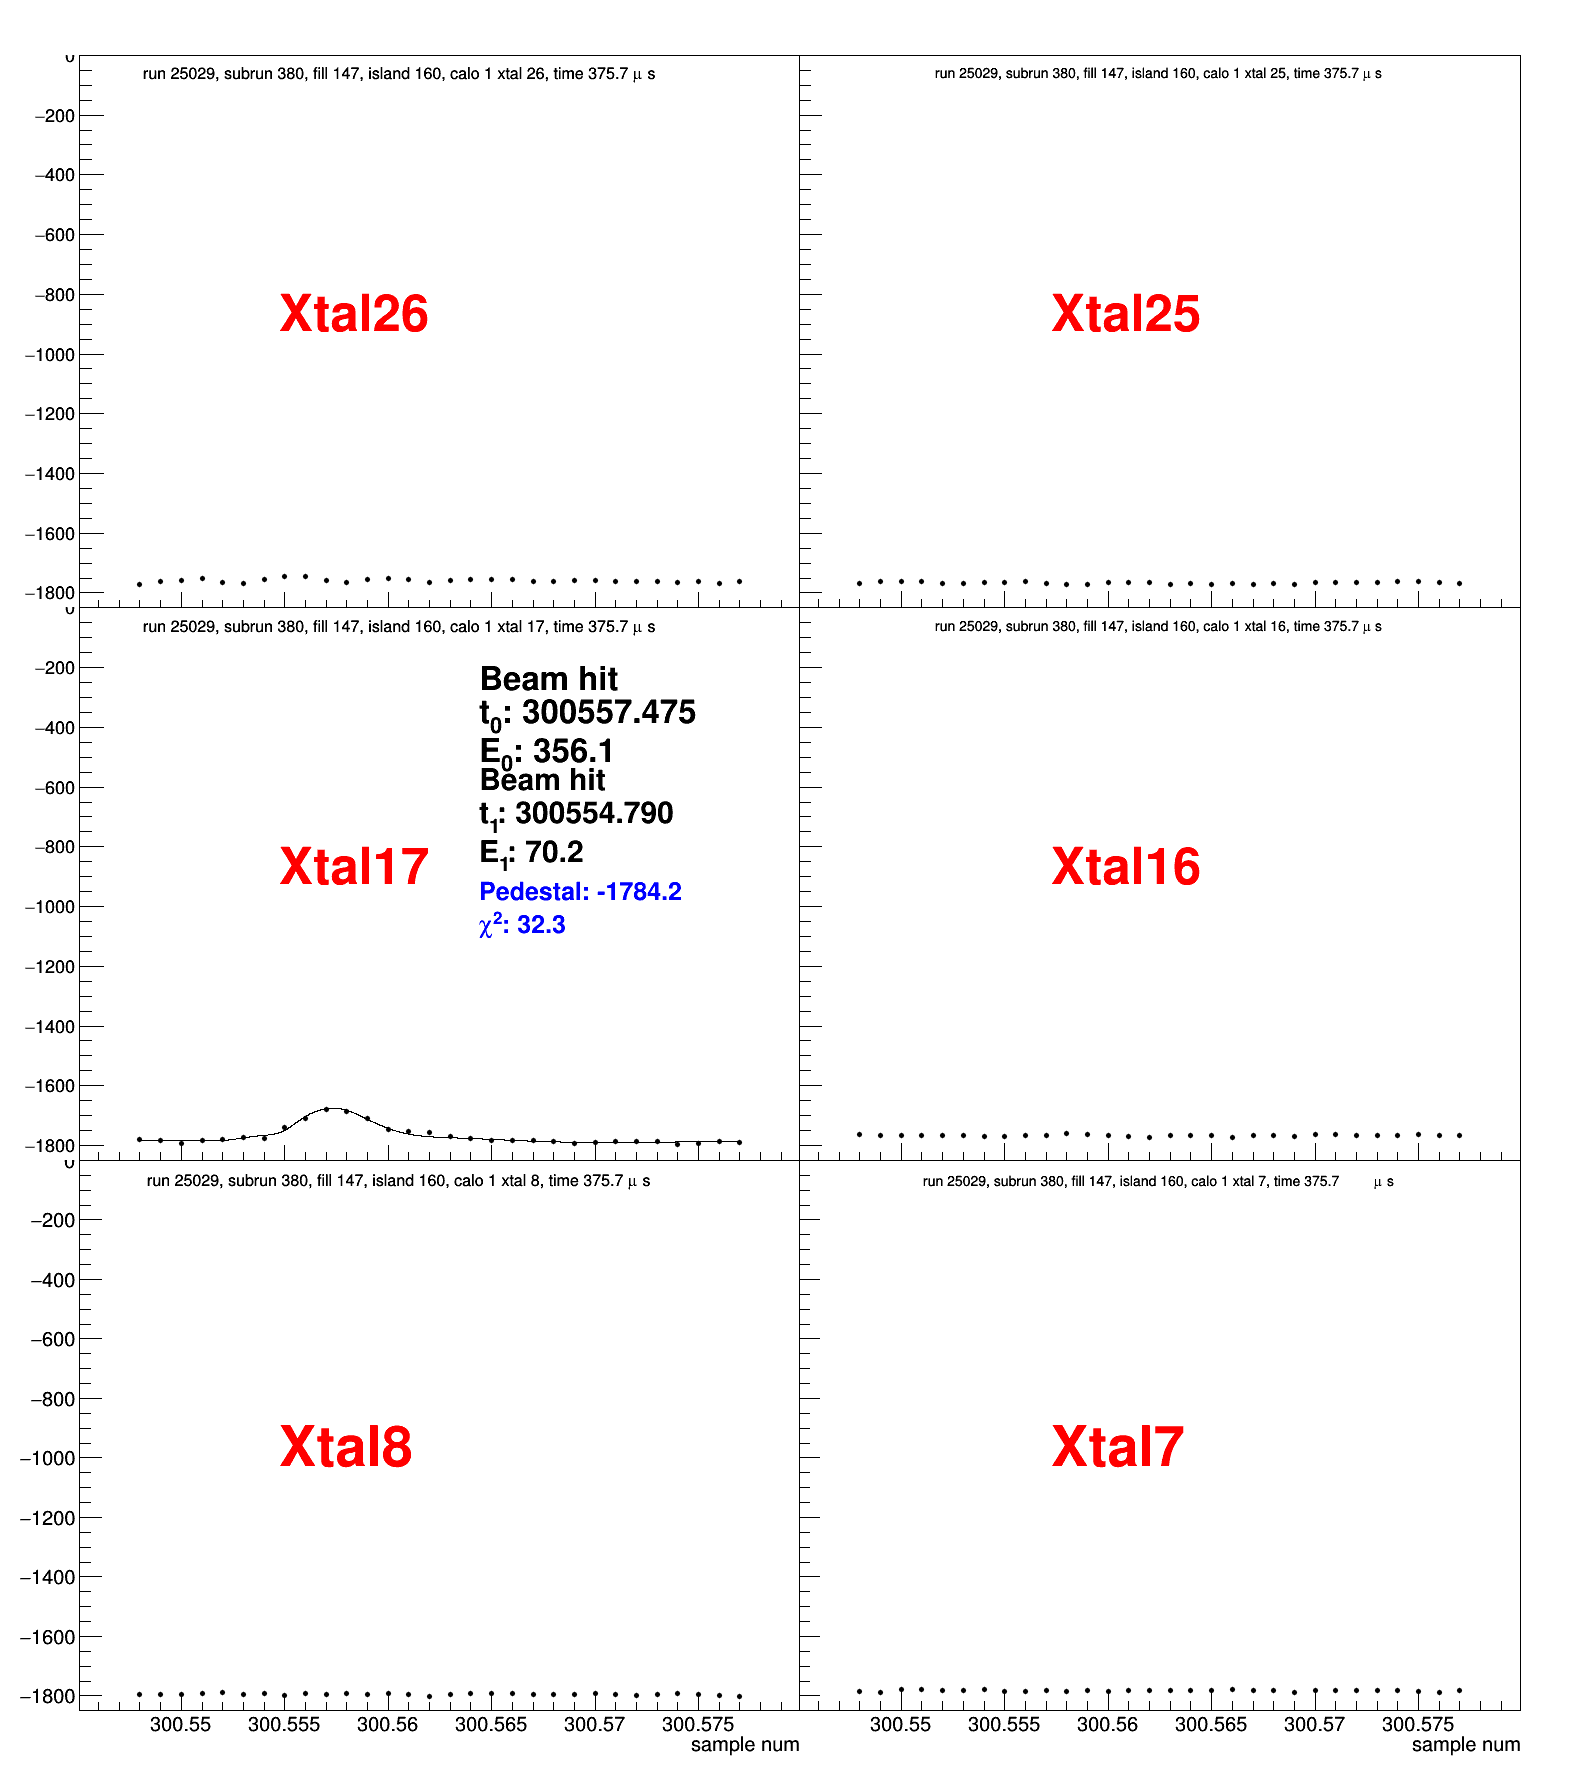

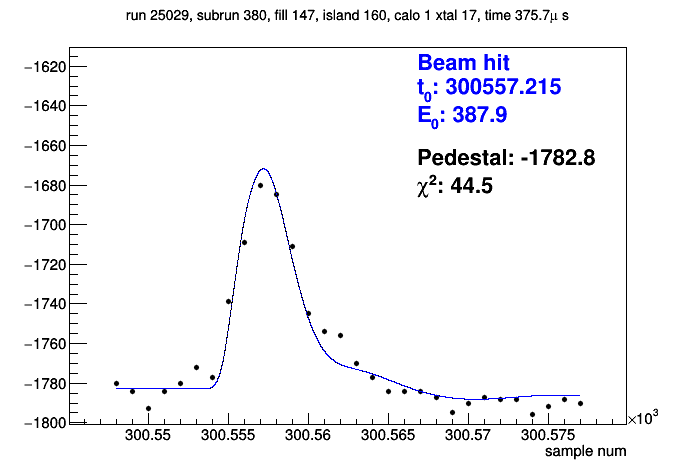

In [68]:

tag = trans_tag('1_17_147_160')
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
cs2 = viewer.draw_calo(*tag)
cs2[0].Draw()
cs3 = viewer_official.plot_xtal(*tag)
cs3[0].Draw()

[['Beam hit', 't_{0}: 170461.527', 'E_{0}: 717.3'], ['Beam hit', 't_{1}: 170463.900', 'E_{1}: 151.0']] ['Pedestal: -1801.6', '#chi^{2}: 68.2']
[['Beam hit', 't_{0}: 170461.774', 'E_{0}: 793.5']] ['Pedestal: -1800.4', '#chi^{2}: 102.3']


Warning in <TCanvas::Constructor>: Deleting canvas with same name: calo1


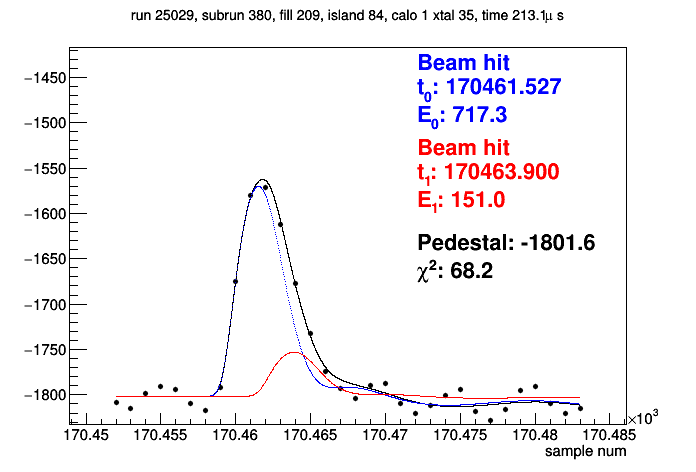

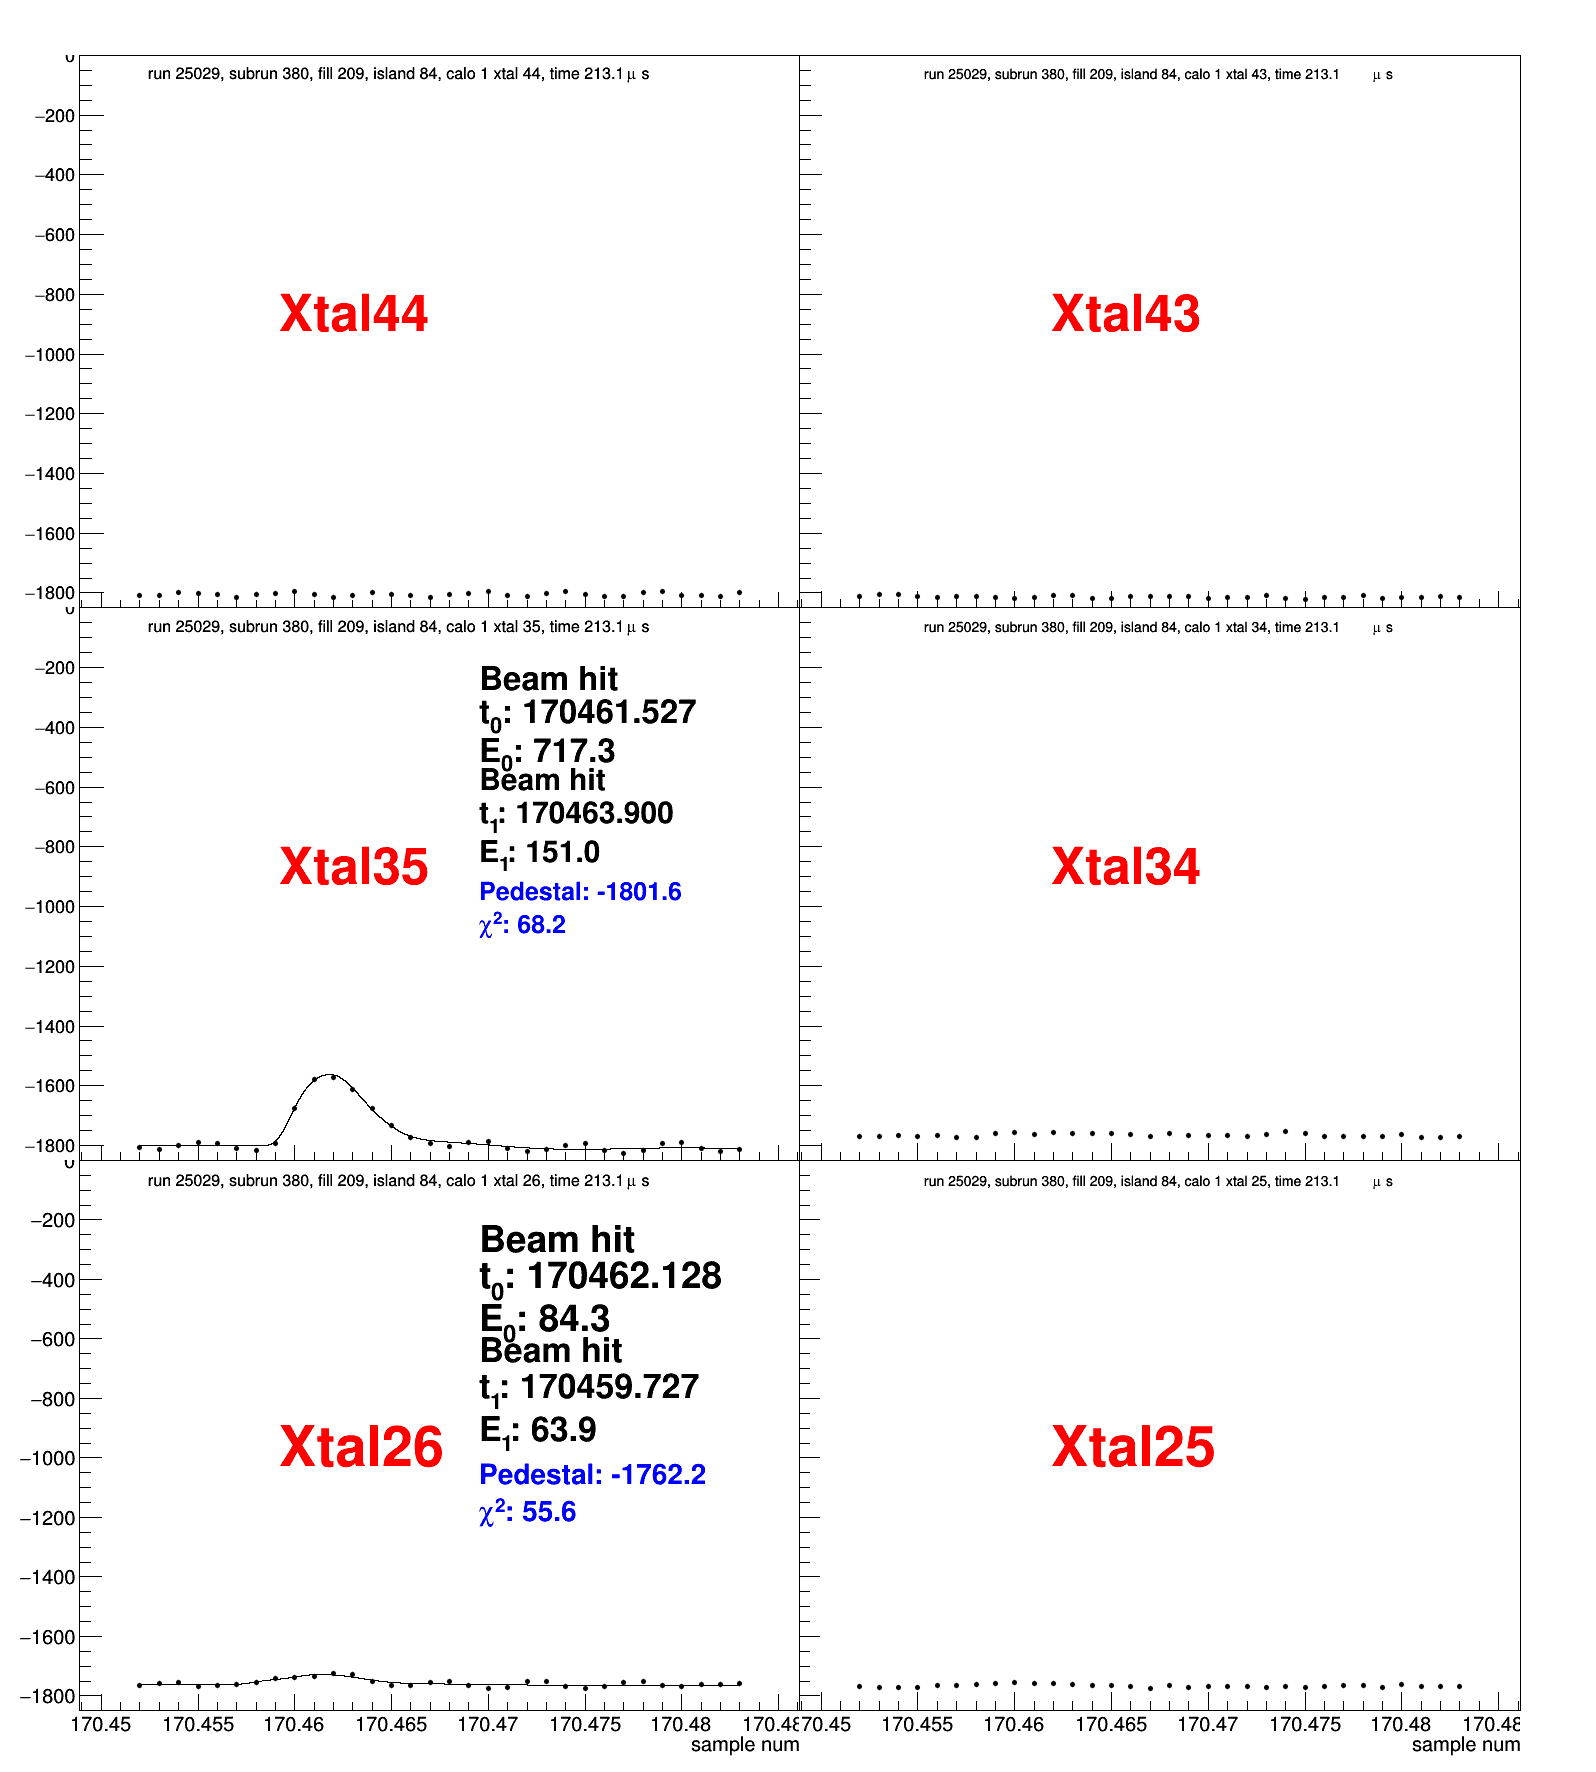

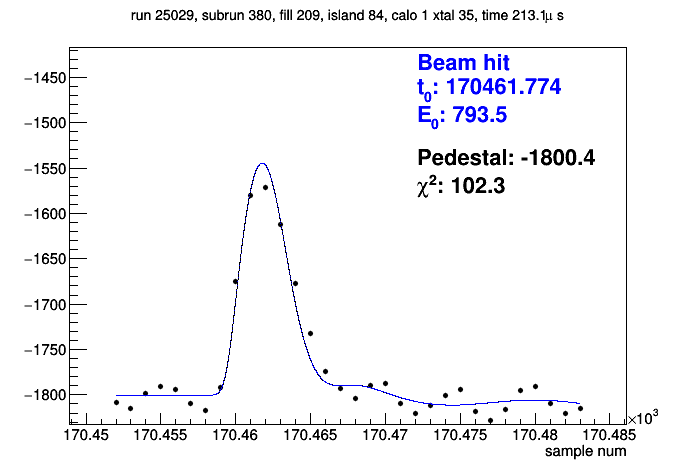

In [67]:
tag = trans_tag('1_35_209_84')
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
cs2 = viewer.draw_calo(*tag)
cs2[0].Draw()
cs3 = viewer_official.plot_xtal(*tag)
cs3[0].Draw()

[['Beam hit', 't_{0}: 125101.638', 'E_{0}: 450.4'], ['Beam hit', 't_{1}: 125099.600', 'E_{1}: 104.0']] ['Pedestal: -1788.8', '#chi^{2}: 68.2']
[['Beam hit', 't_{0}: 125101.364', 'E_{0}: 518.8']] ['Pedestal: -1787.6', '#chi^{2}: 79.3']


Warning in <TCanvas::Constructor>: Deleting canvas with same name: calo1


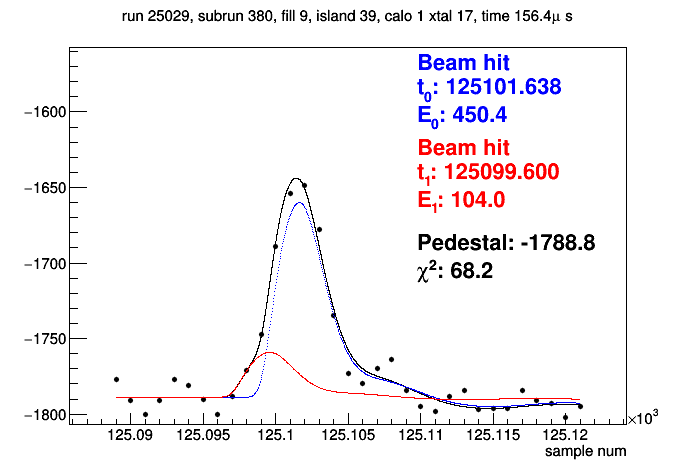

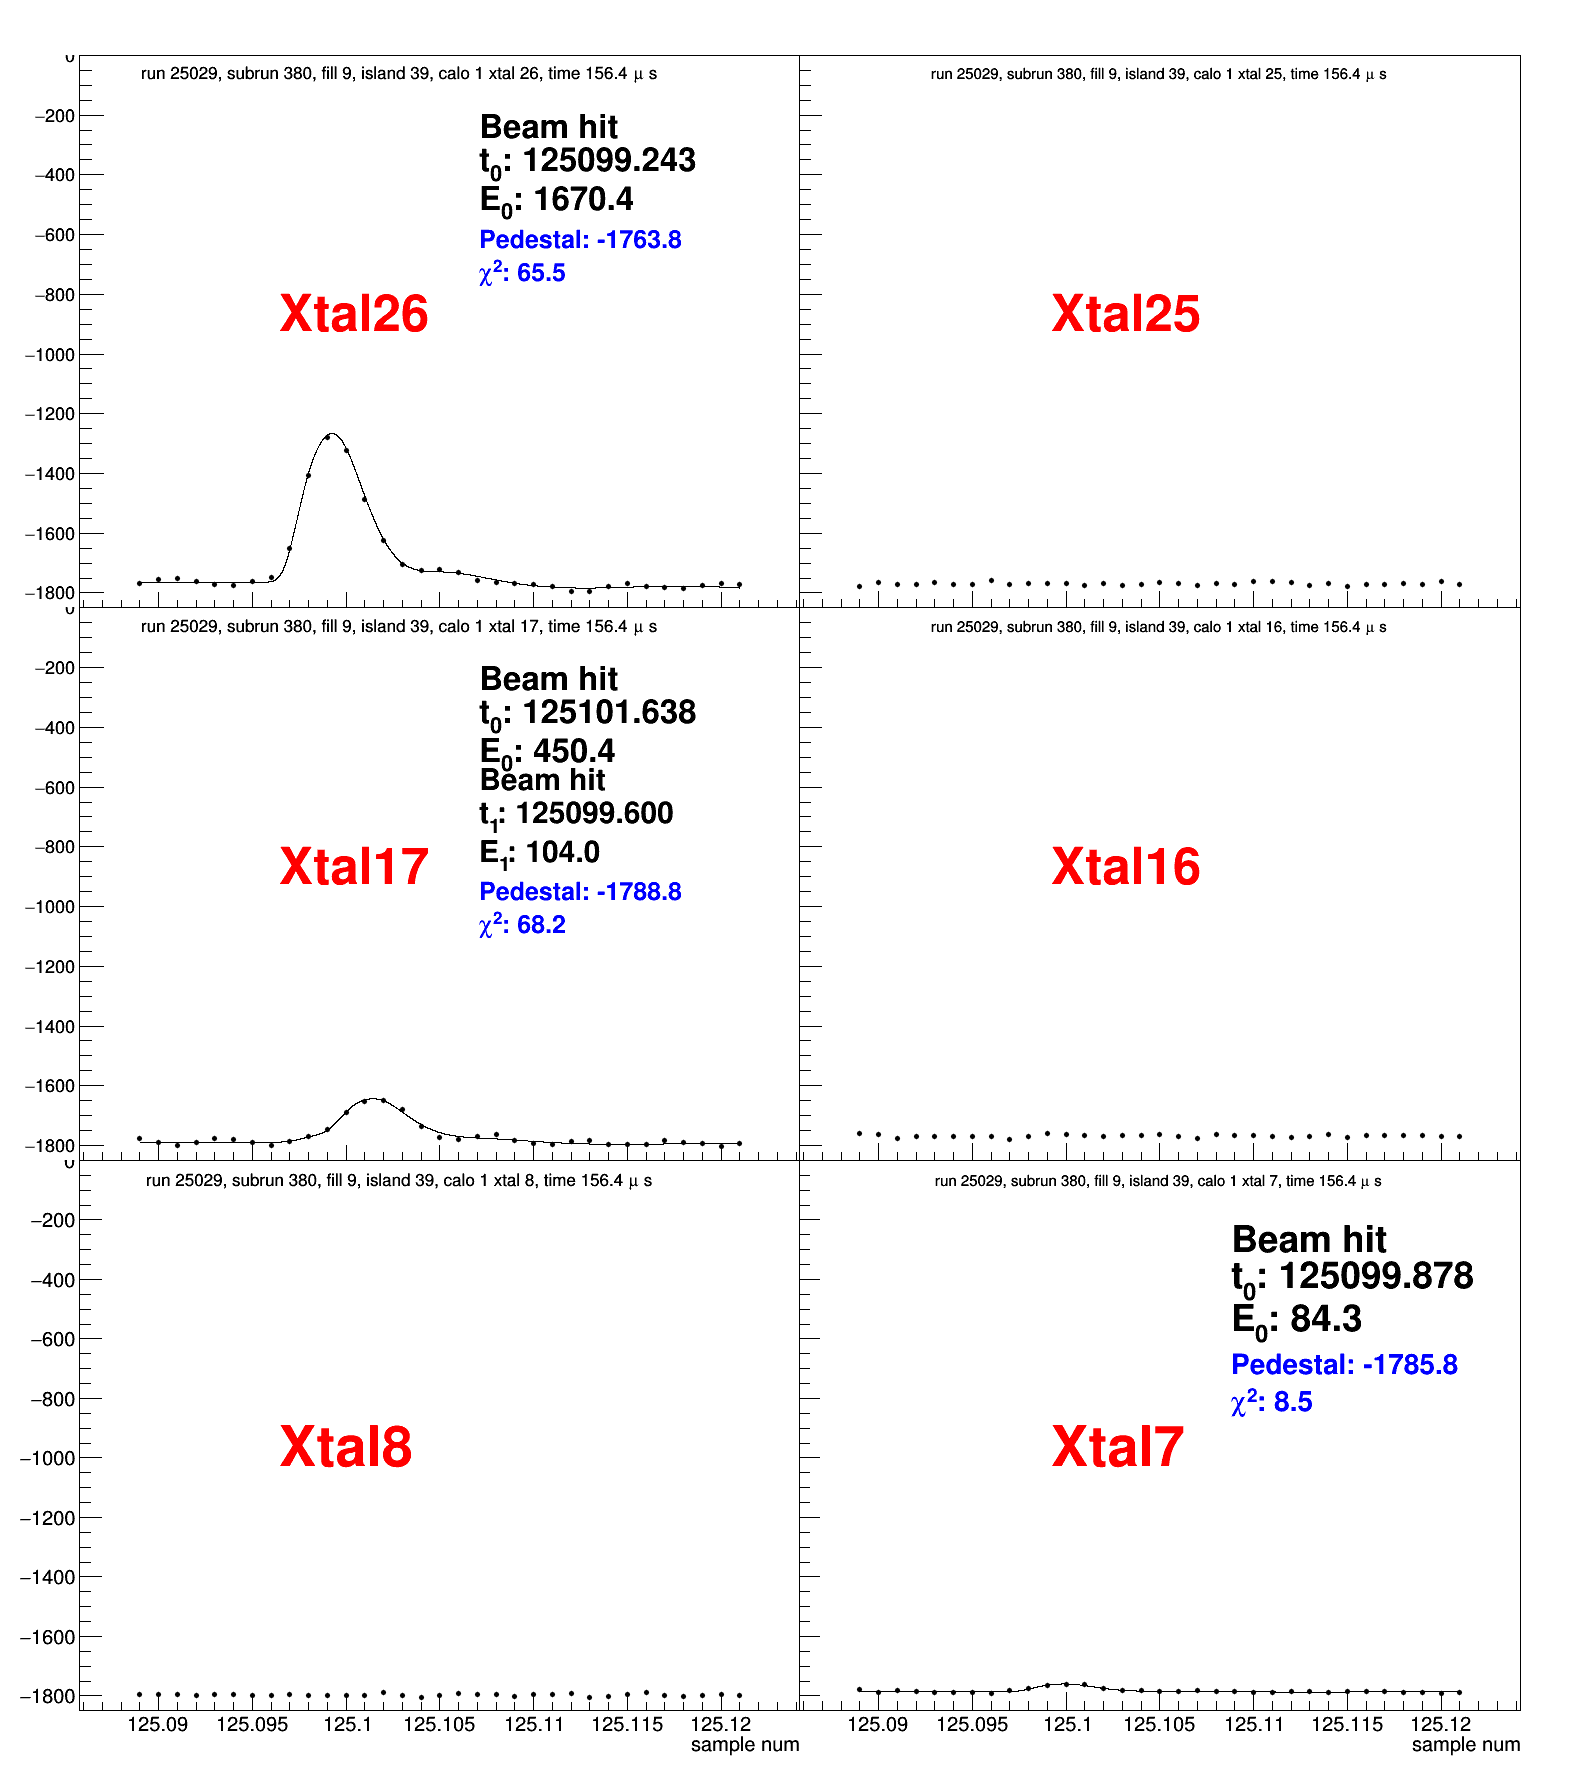

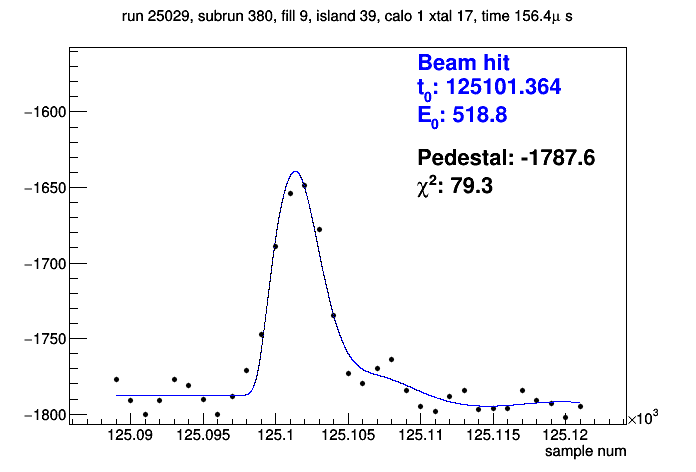

In [70]:
tag = trans_tag('1_17_9_39')
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
cs2 = viewer.draw_calo(*tag)
cs2[0].Draw()
cs3 = viewer_official.plot_xtal(*tag)
cs3[0].Draw()

[['Beam hit', 't_{0}: 121438.335', 'E_{0}: 290.1'], ['Beam hit', 't_{1}: 121436.186', 'E_{1}: 287.9']] ['Pedestal: -1803.2', '#chi^{2}: 14.2']
[['Beam hit', 't_{0}: 121437.245', 'E_{0}: 491.5']] ['Pedestal: -1800.1', '#chi^{2}: 99.0']


Warning in <TCanvas::Constructor>: Deleting canvas with same name: calo1


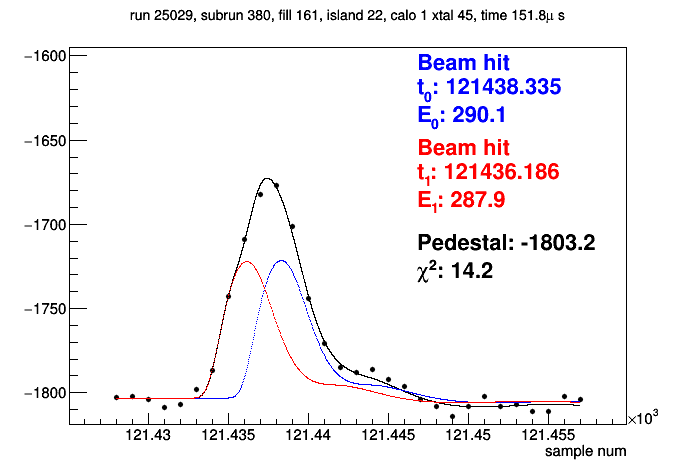

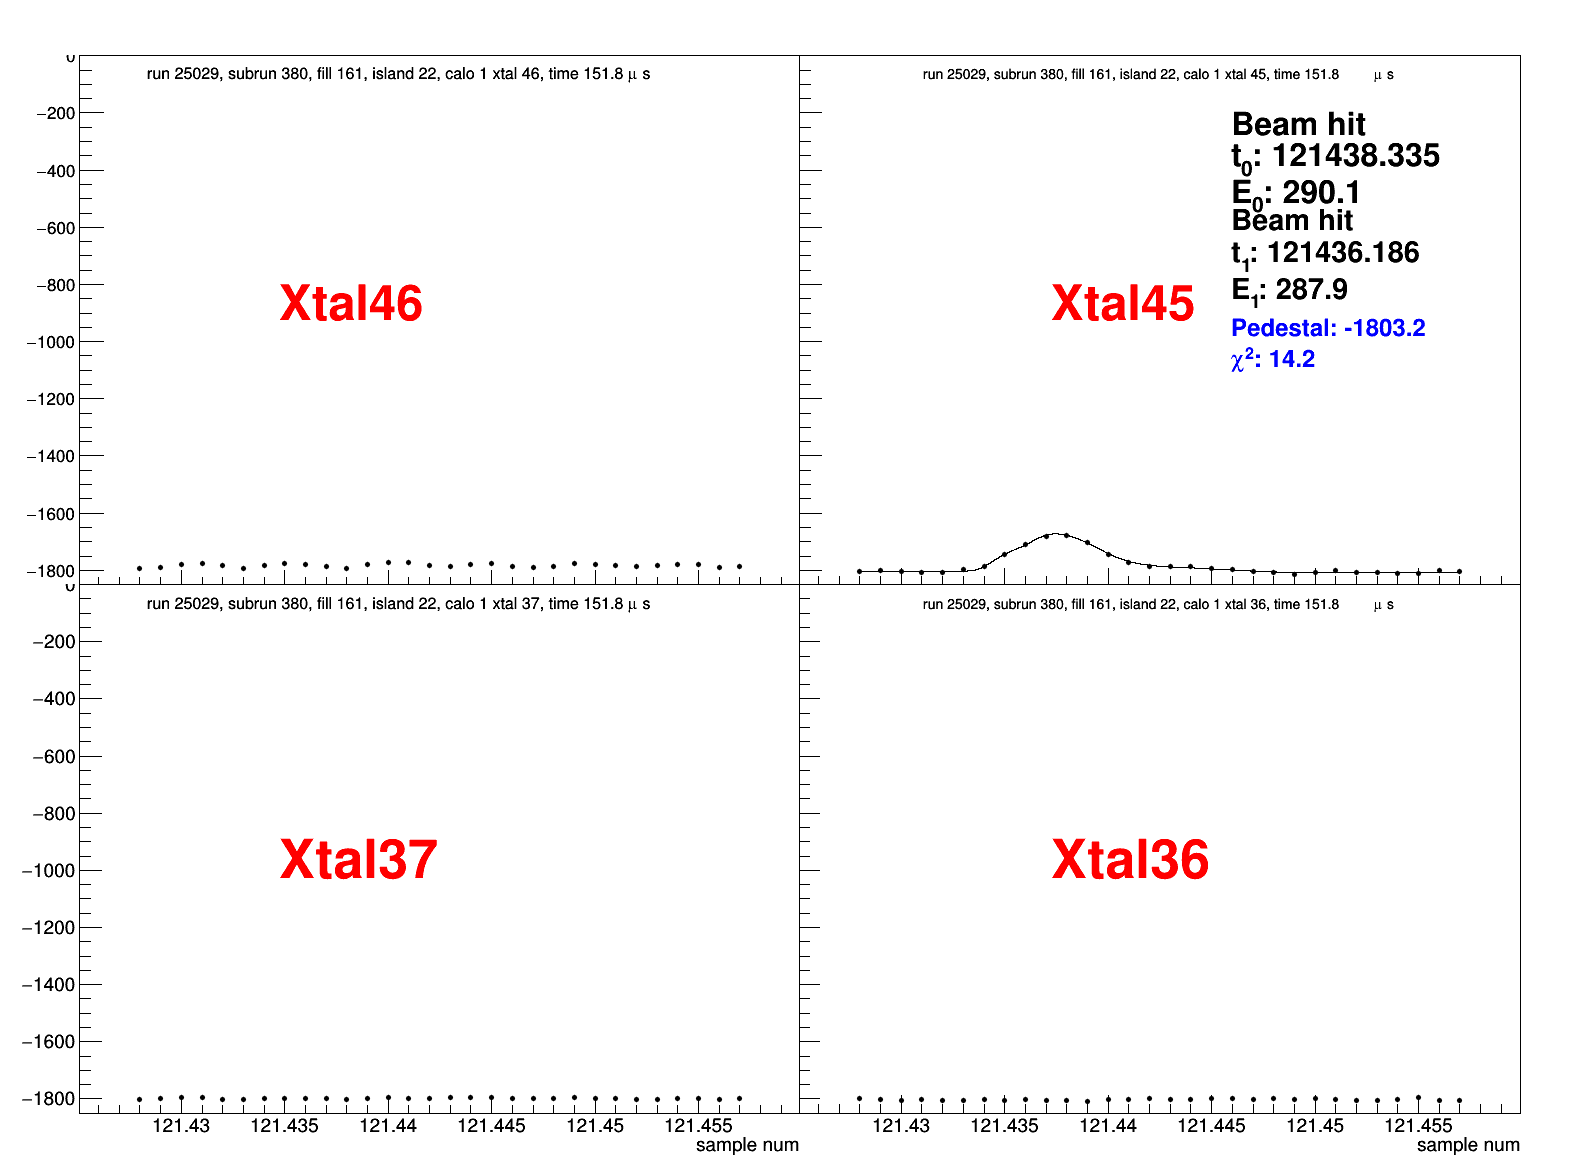

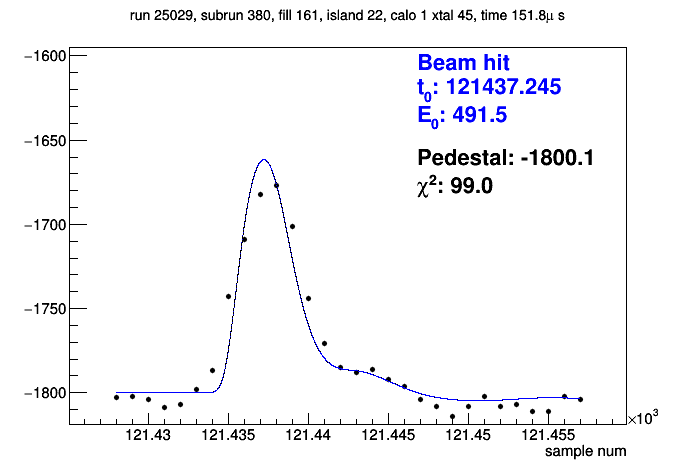

In [71]:
tag = trans_tag('1_45_161_22')
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
cs2 = viewer.draw_calo(*tag)
cs2[0].Draw()
cs3 = viewer_official.plot_xtal(*tag)
cs3[0].Draw()

[['Beam hit', 't_{0}: 107364.879', 'E_{0}: 575.9'], ['Beam hit', 't_{1}: 107367.163', 'E_{1}: 62.6']] ['Pedestal: -1800.0', '#chi^{2}: 14.0']
[['Beam hit', 't_{0}: 107365.004', 'E_{0}: 606.6']] ['Pedestal: -1798.8', '#chi^{2}: 23.3']


Warning in <TCanvas::Constructor>: Deleting canvas with same name: calo1


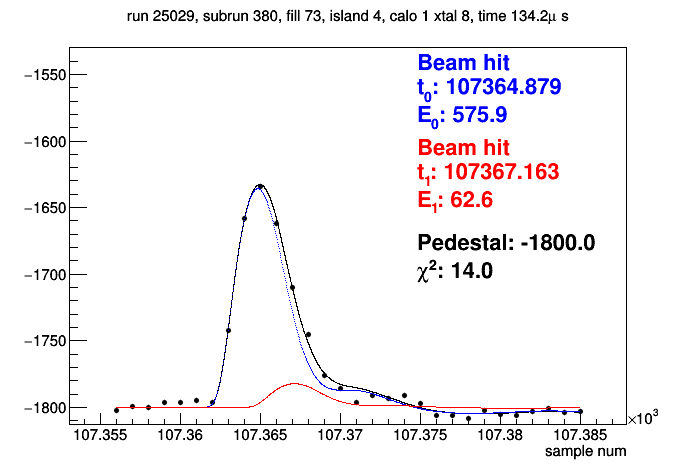

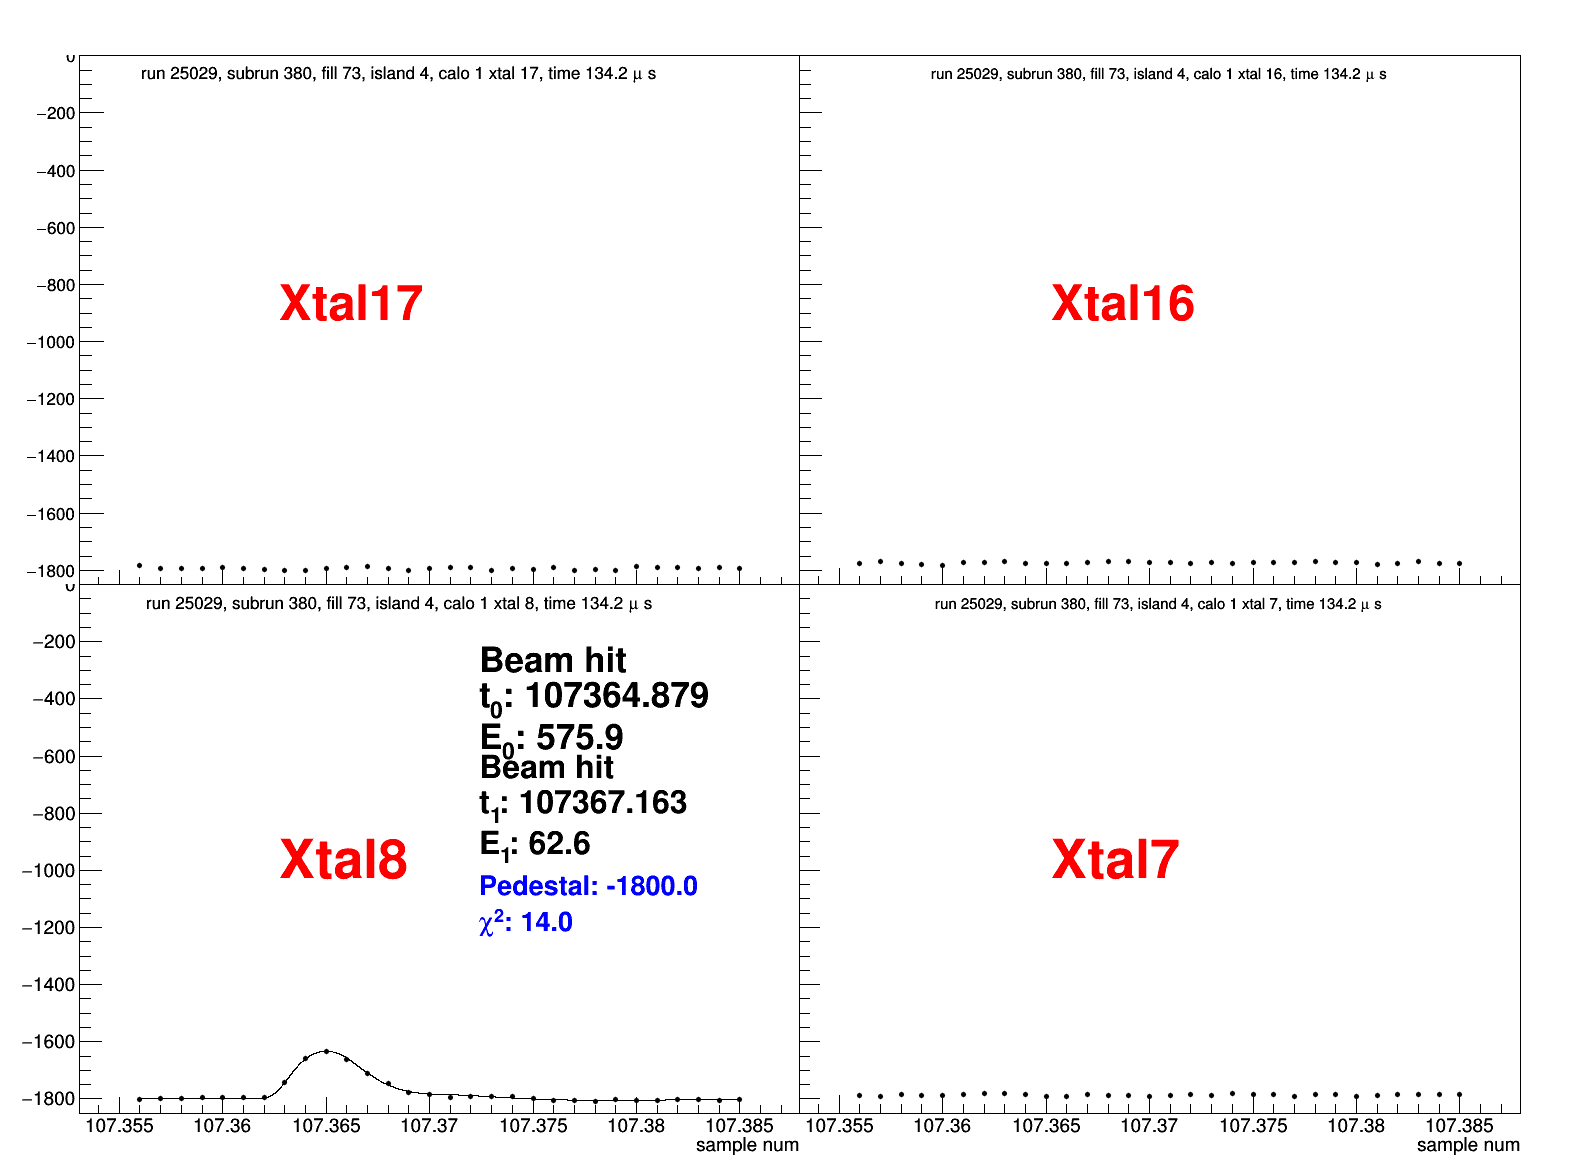

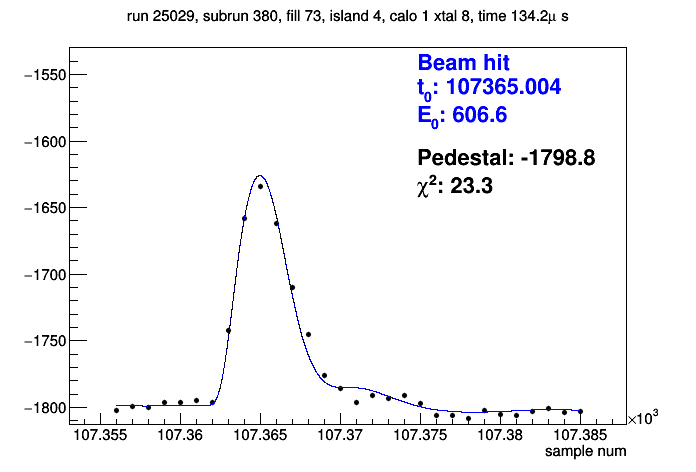

In [72]:
tag = trans_tag('1_8_73_4')
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
cs2 = viewer.draw_calo(*tag)
cs2[0].Draw()
cs3 = viewer_official.plot_xtal(*tag)
cs3[0].Draw()

[['Beam hit', 't_{0}: 402753.629', 'E_{0}: 204.1'], ['Beam hit', 't_{1}: 402757.441', 'E_{1}: 63.9']] ['Pedestal: -1780.7', '#chi^{2}: 12.1']
[['Beam hit', 't_{0}: 402753.899', 'E_{0}: 212.3']] ['Pedestal: -1778.6', '#chi^{2}: 37.6']


Warning in <TCanvas::Constructor>: Deleting canvas with same name: calo1


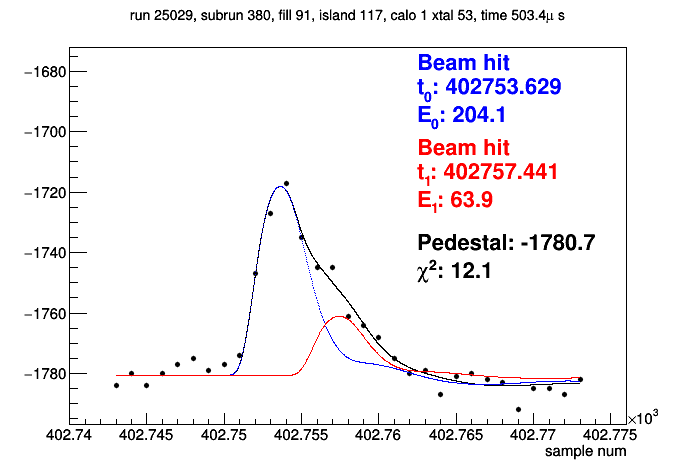

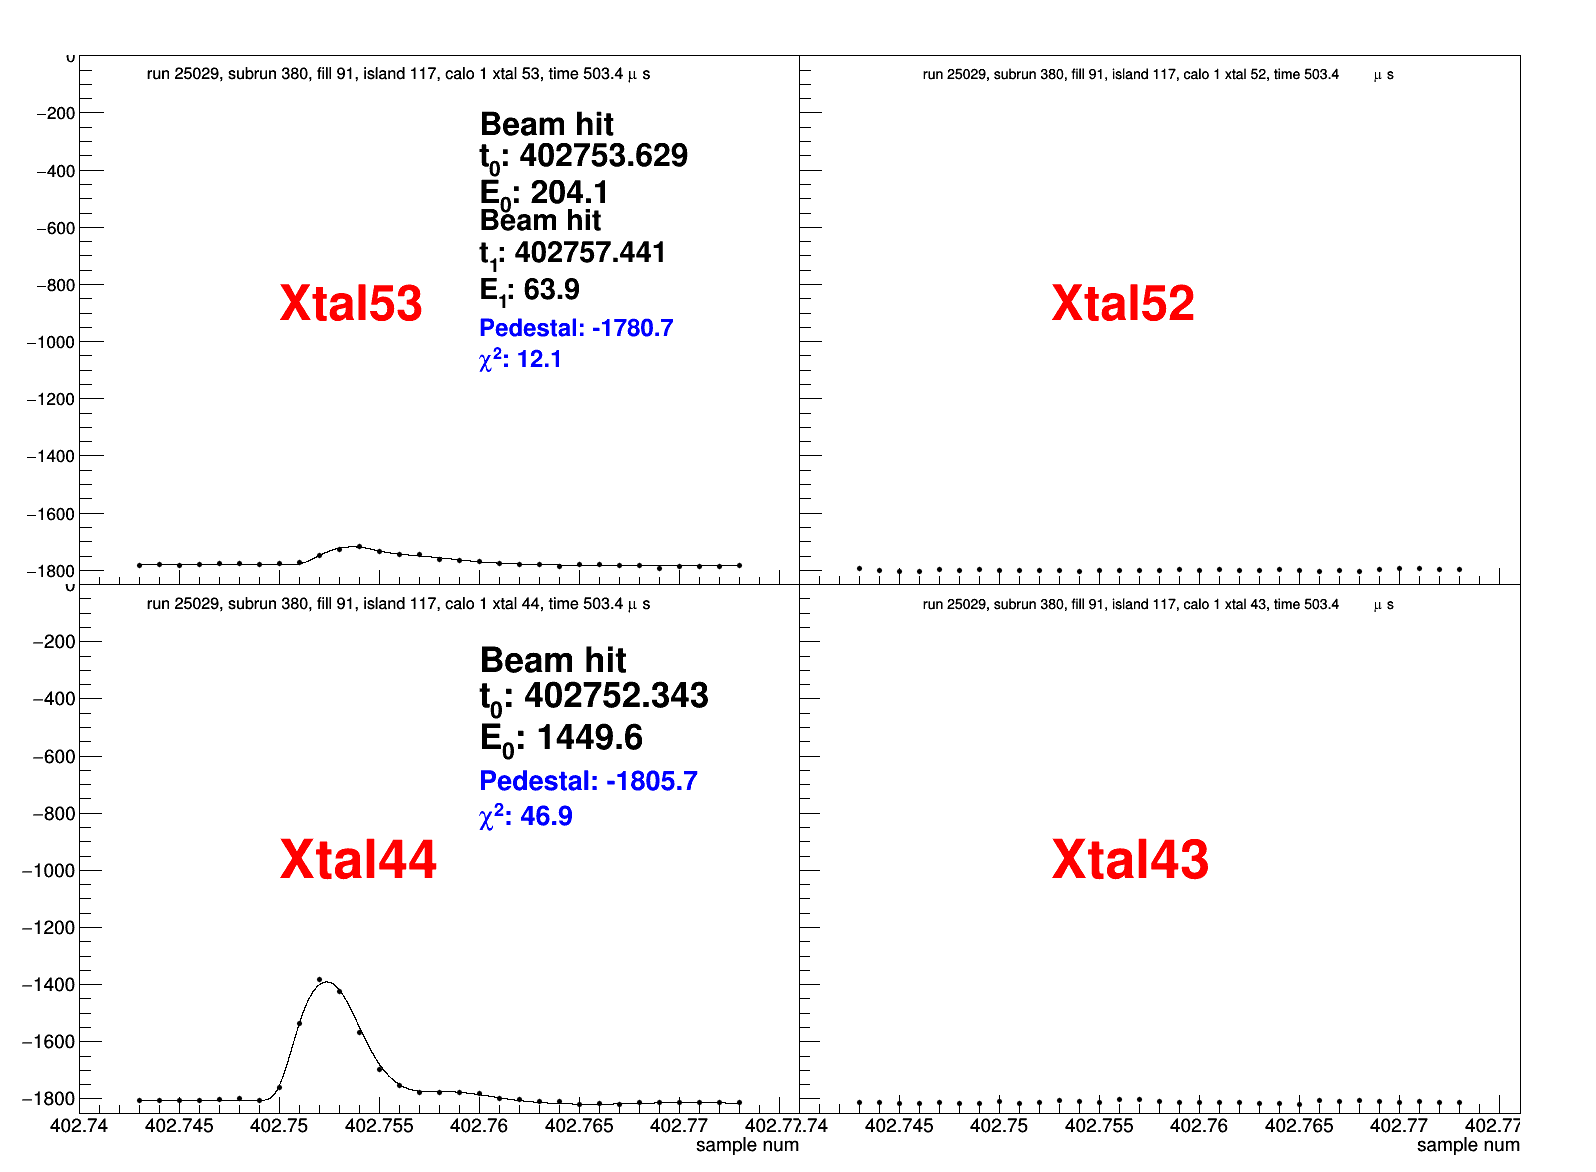

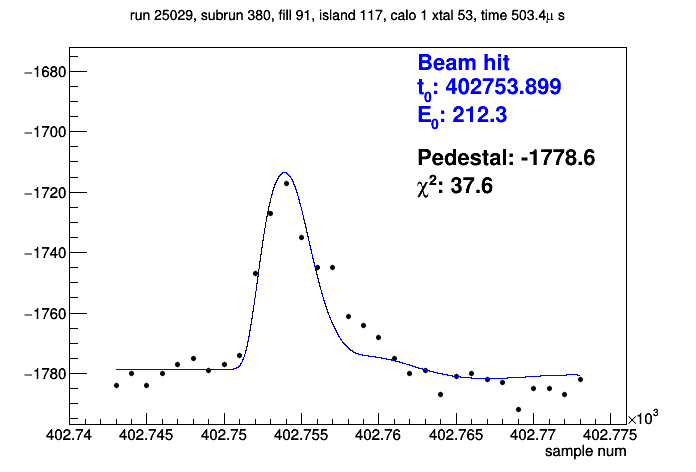

In [73]:
tag = trans_tag('1_53_91_117')
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
cs2 = viewer.draw_calo(*tag)
cs2[0].Draw()
cs3 = viewer_official.plot_xtal(*tag)
cs3[0].Draw()

[['Beam hit', 't_{0}: 107350.569', 'E_{0}: 343.6'], ['Beam hit', 't_{1}: 107353.499', 'E_{1}: 125.9']] ['Pedestal: -1790.0', '#chi^{2}: 14.8']
[['Beam hit', 't_{0}: 107350.982', 'E_{0}: 388.1']] ['Pedestal: -1786.9', '#chi^{2}: 63.2']


Warning in <TCanvas::Constructor>: Deleting canvas with same name: calo1


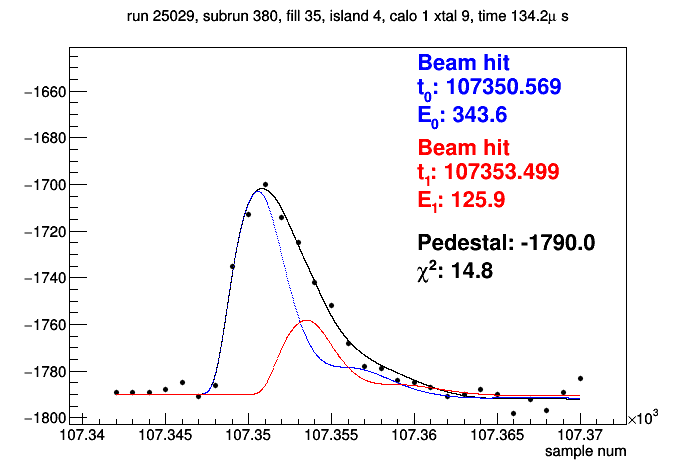

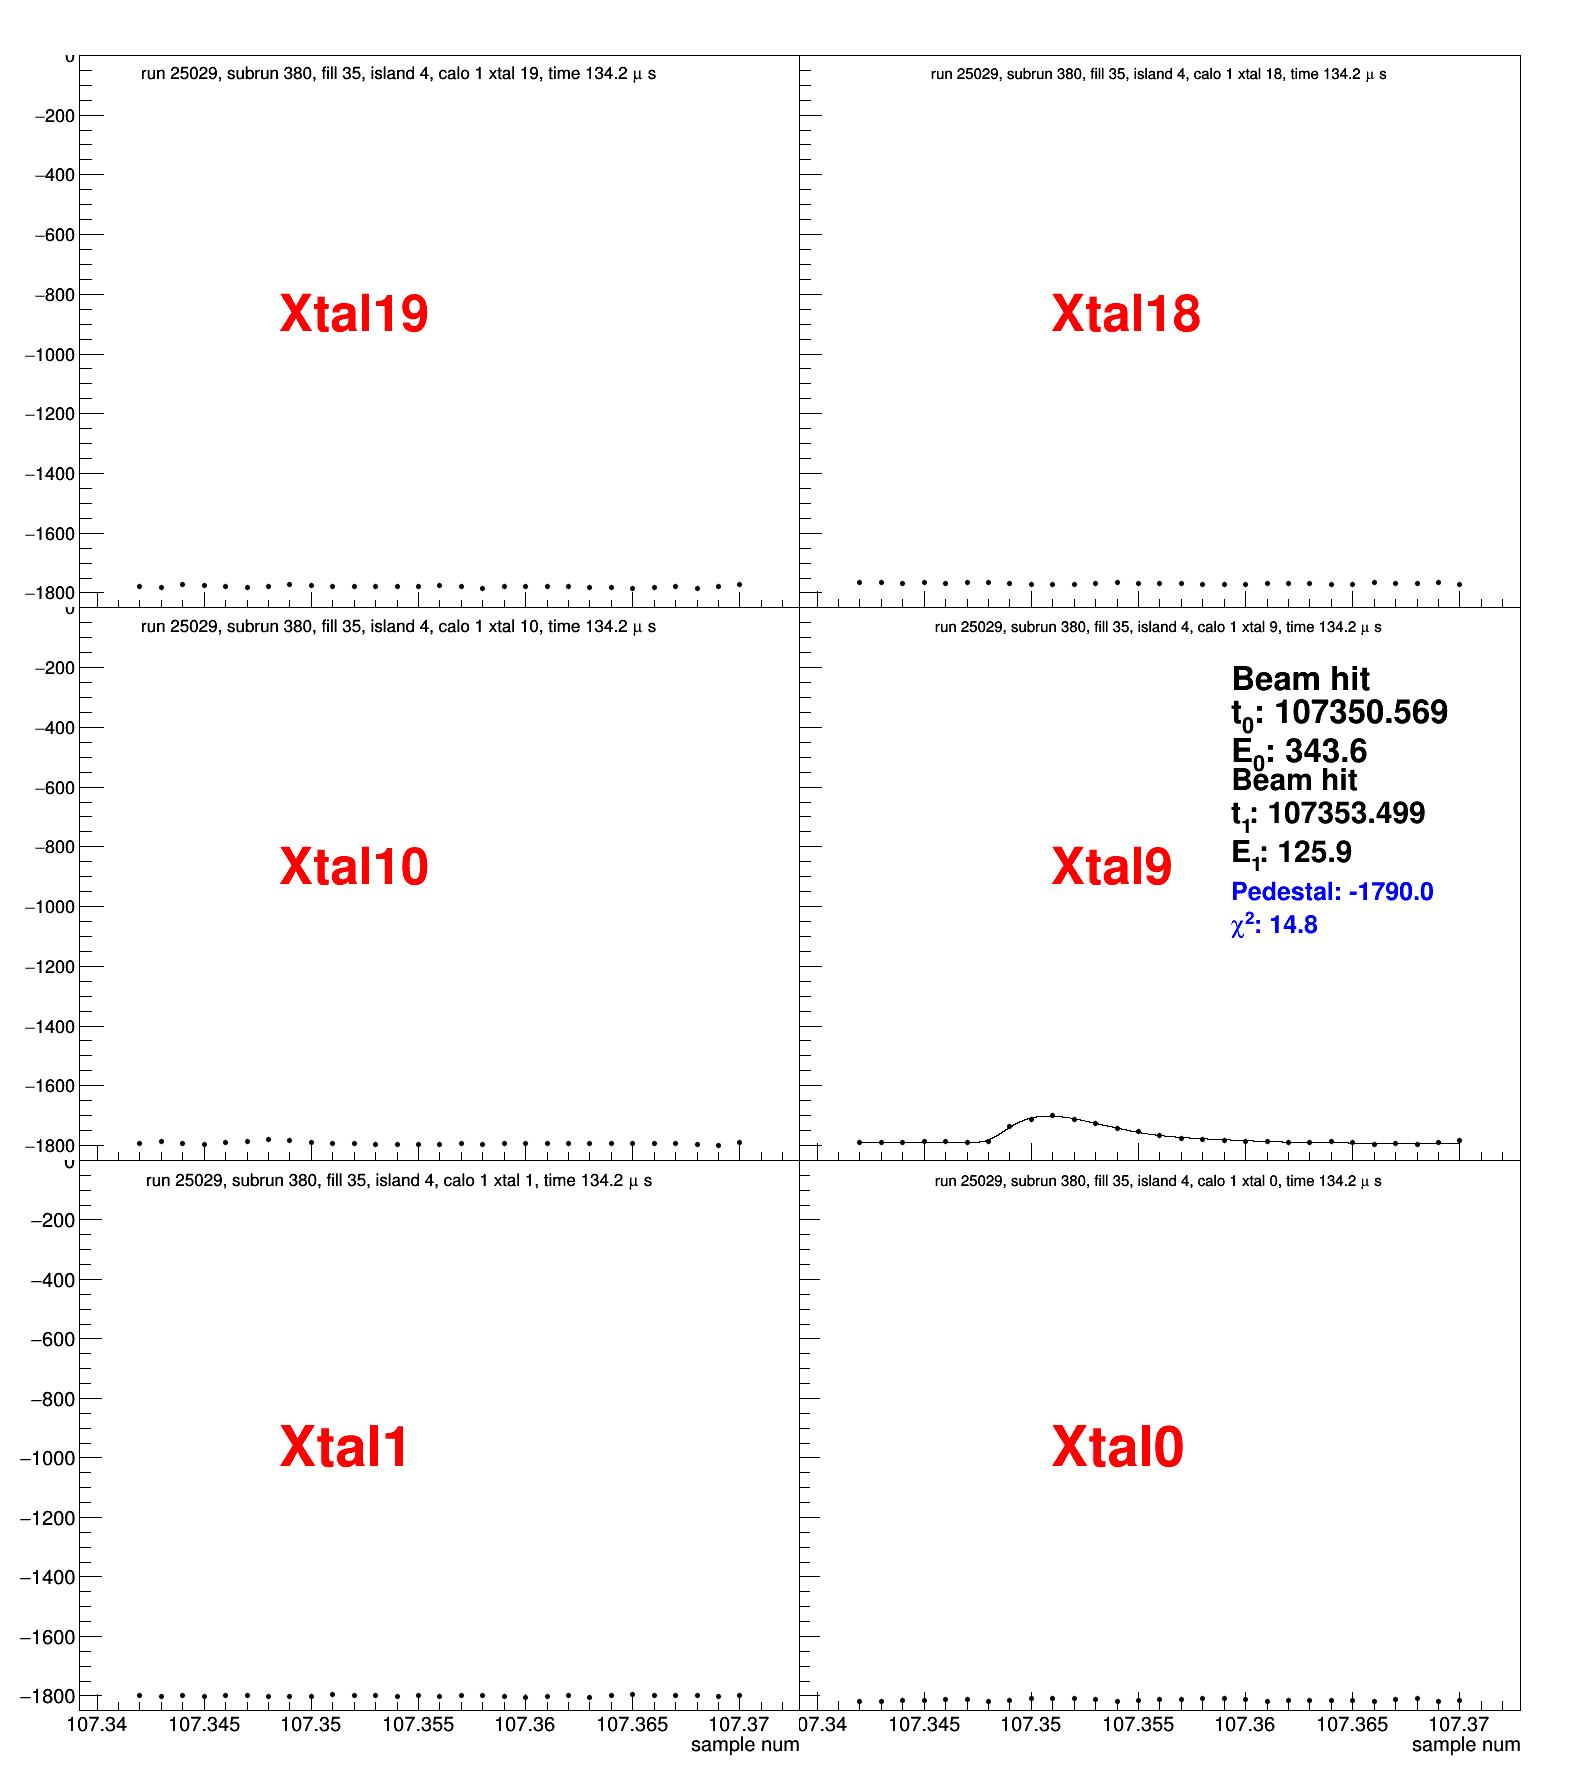

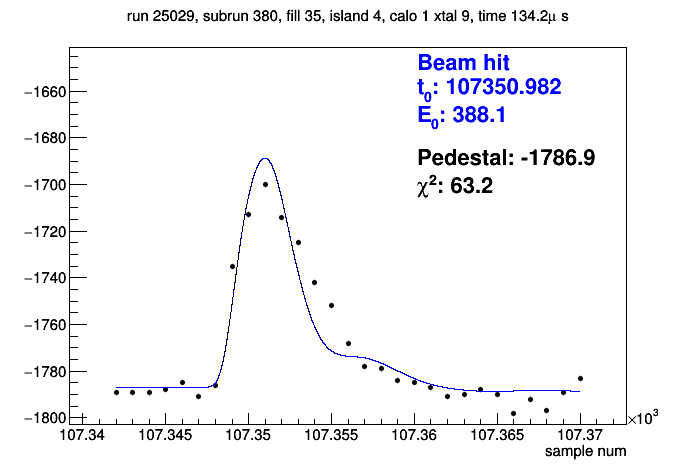

In [74]:
tag = trans_tag('1_9_35_4')
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
cs2 = viewer.draw_calo(*tag)
cs2[0].Draw()
cs3 = viewer_official.plot_xtal(*tag)
cs3[0].Draw()

[1, 28, 71, 85, True, 0.25]
[['Beam hit', 't_{0}: 107259.197', 'E_{0}: 227.4'], ['Beam hit', 't_{1}: 107256.983', 'E_{1}: 538.4']] ['Pedestal: -1806.9', '#chi^{2}: 13.0']
0.25
[['Beam hit', 't_{0}: 107257.474', 'E_{0}: 690.3']] ['Pedestal: -1805.8', '#chi^{2}: 41.0']
0.25


Warning in <TCanvas::Constructor>: Deleting canvas with same name: calo1


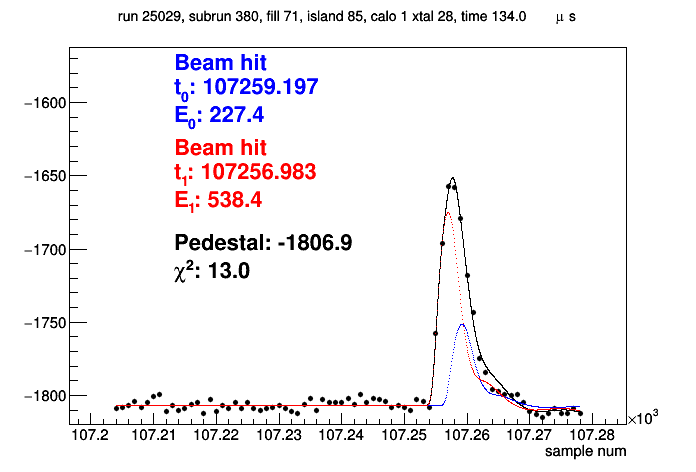

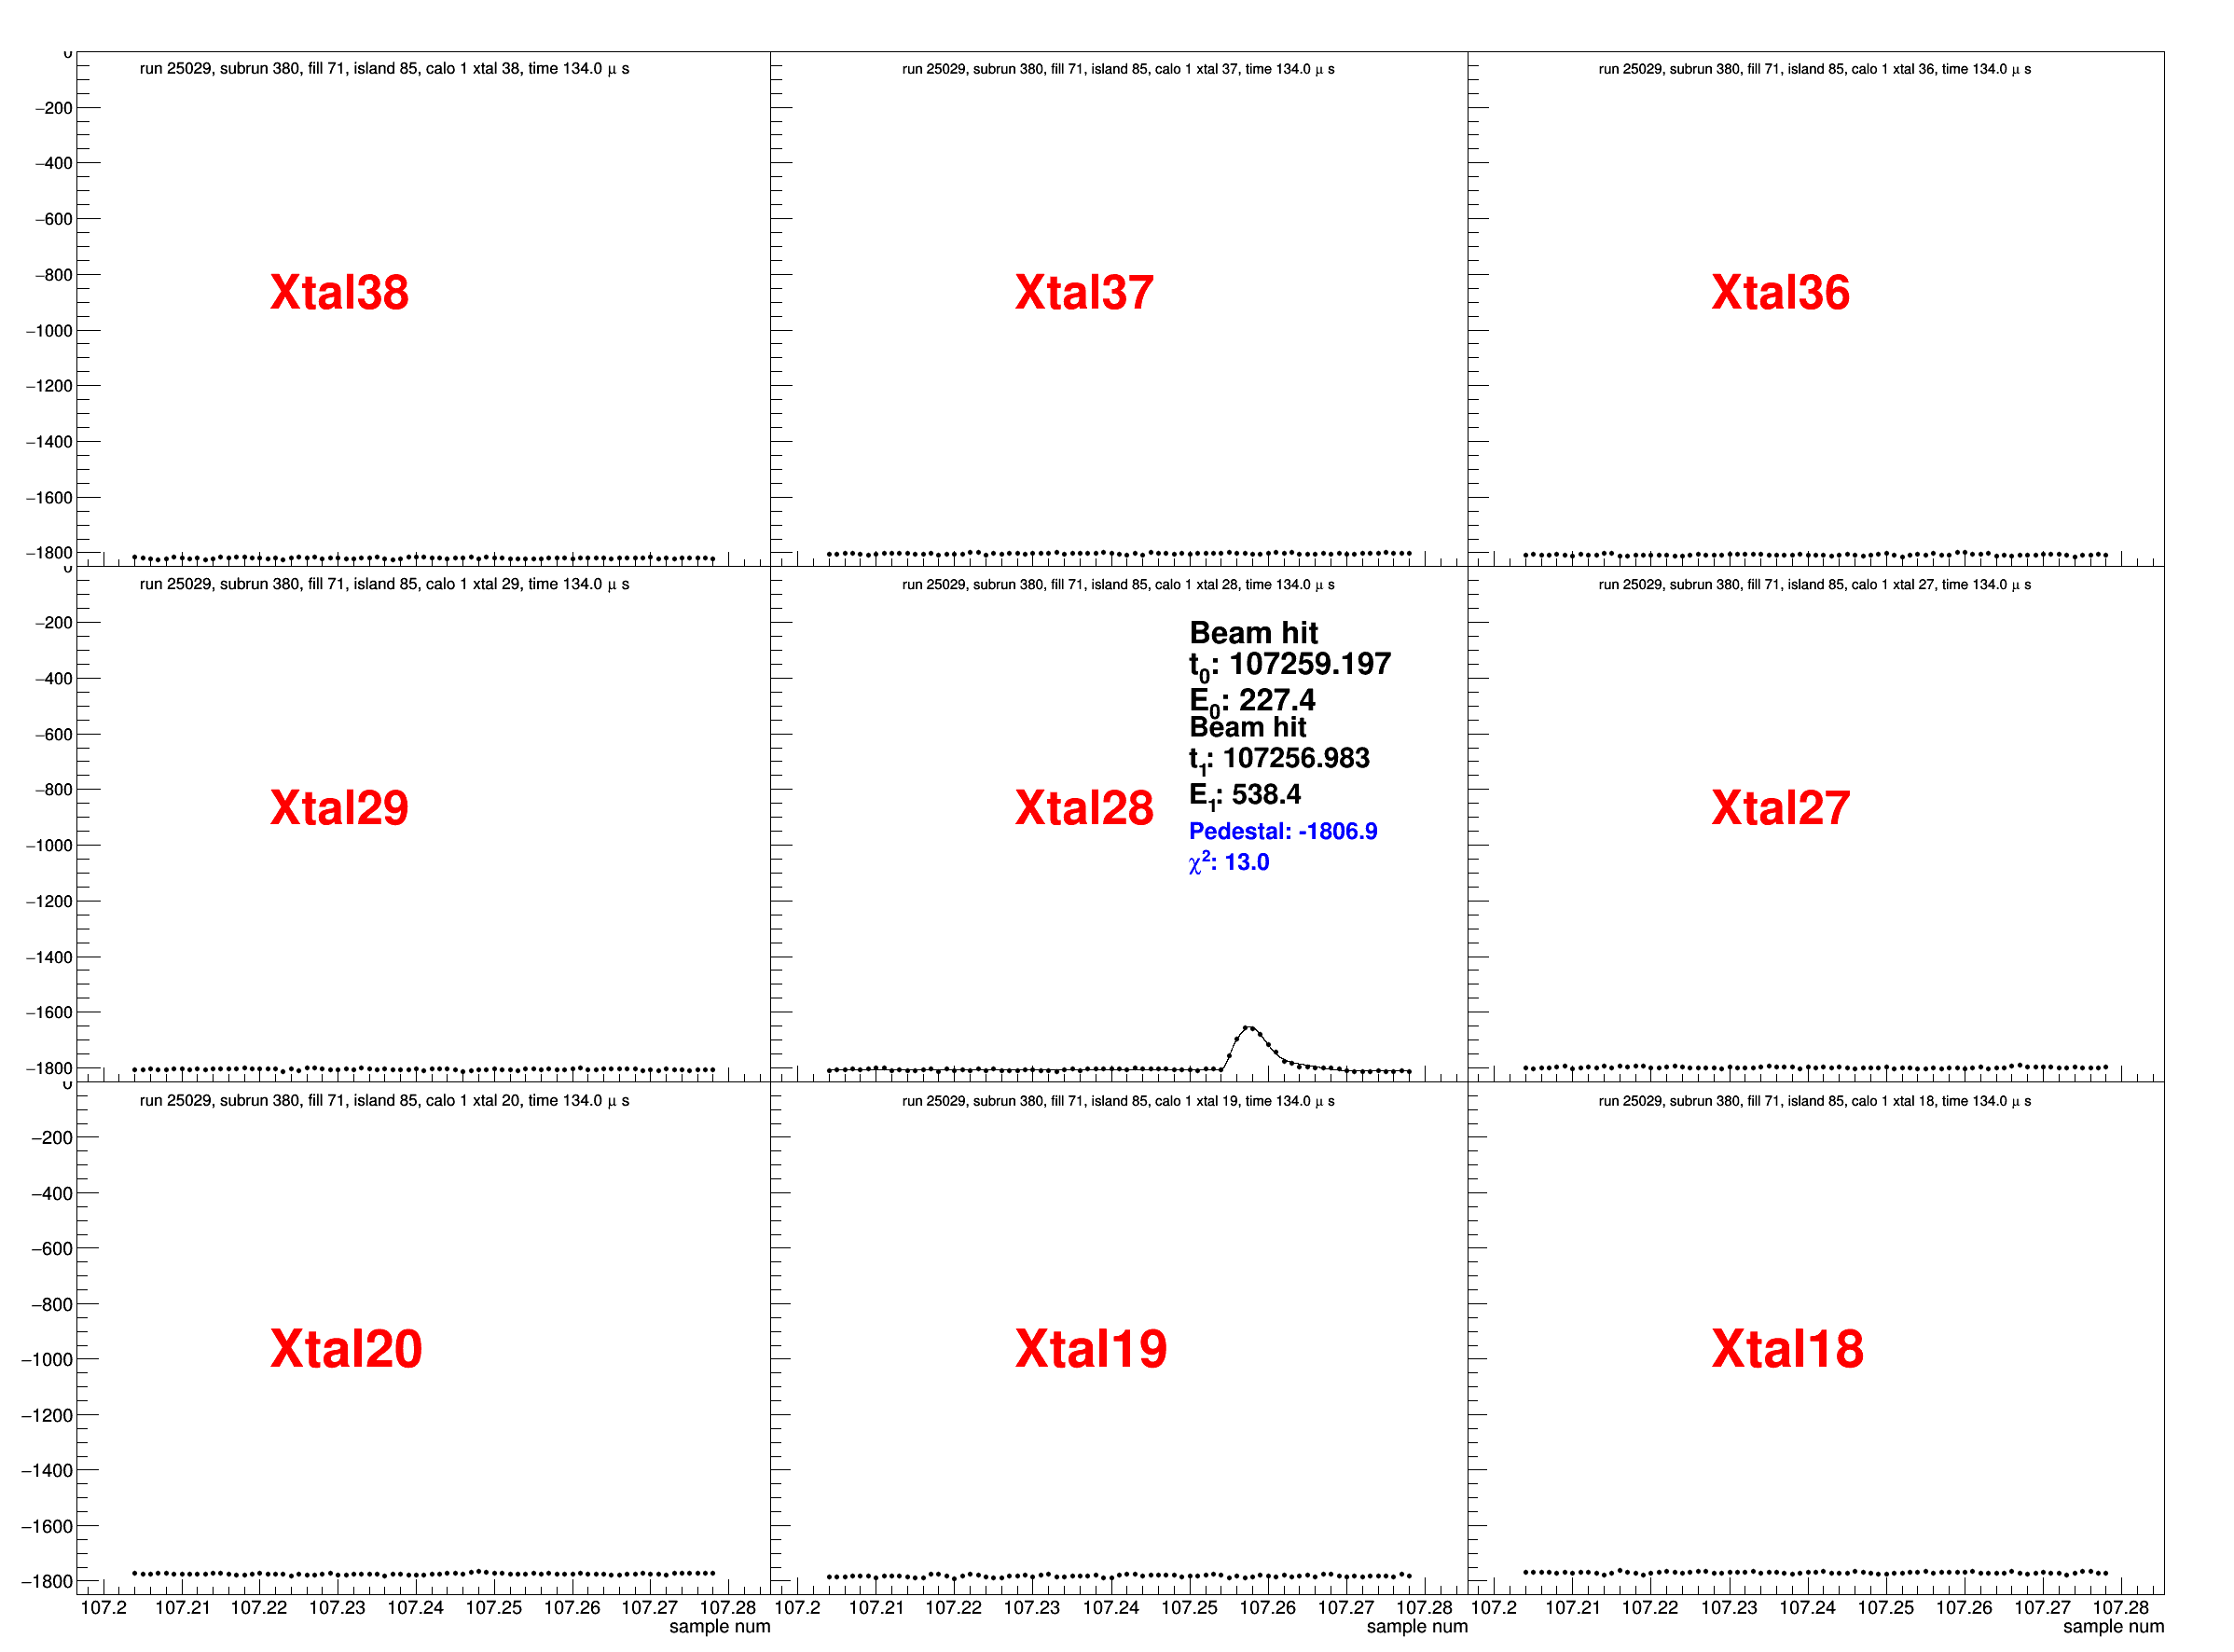

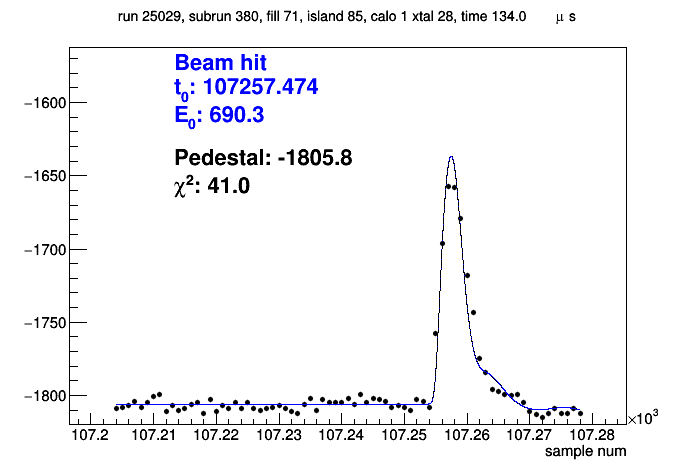

In [88]:
tag = trans_tag('1_28_71_85',0.25)
print(tag)
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
cs2 = viewer.draw_calo(*tag)
cs2[0].Draw()
cs3 = viewer_official.plot_xtal(*tag)
cs3[0].Draw()

[1, 17, 207, 121, True, None]
[['Beam hit', 't_{0}: 162206.832', 'E_{0}: 1831.9'], ['Beam hit', 't_{1}: 162209.538', 'E_{1}: 237.8']] ['Pedestal: -1786.8', '#chi^{2}: 28.7']
0.6
[['Beam hit', 't_{0}: 162206.988', 'E_{0}: 1938.0']] ['Pedestal: -1782.5', '#chi^{2}: 205.2']
0.6


Warning in <TCanvas::Constructor>: Deleting canvas with same name: calo1


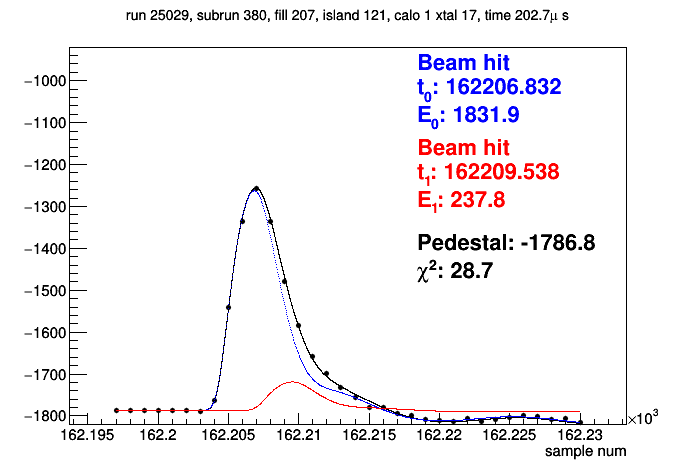

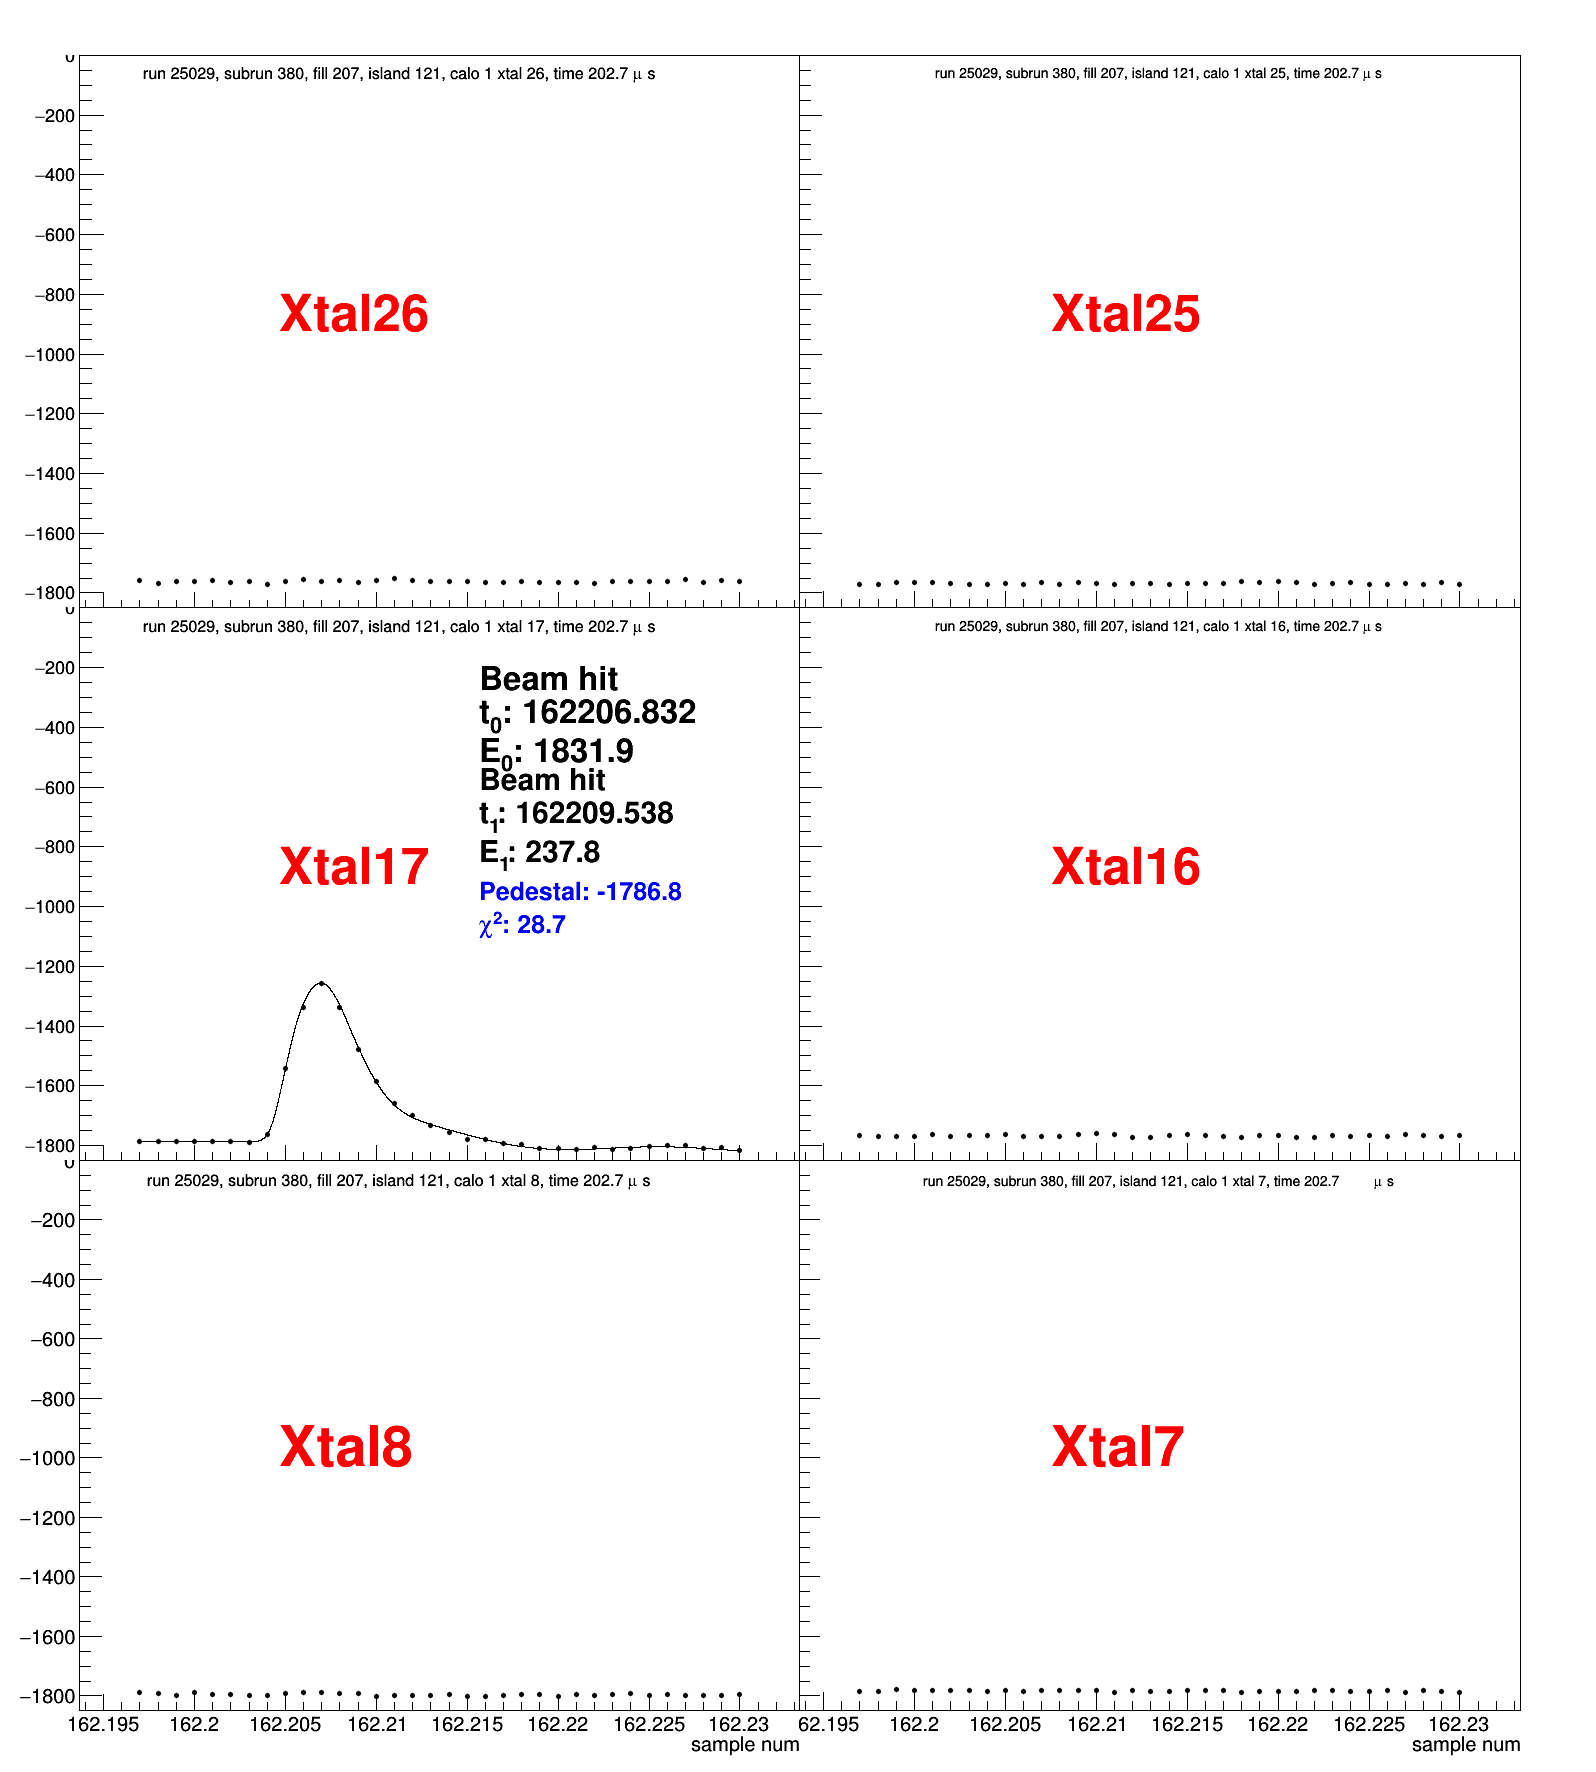

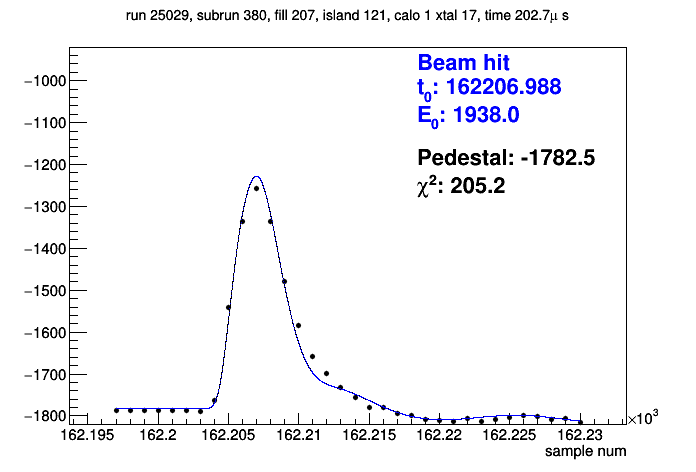

In [90]:
tag = trans_tag('1_17_207_121')
print(tag)
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
cs2 = viewer.draw_calo(*tag)
cs2[0].Draw()
cs3 = viewer_official.plot_xtal(*tag)
cs3[0].Draw()

[1, 17, 167, 158, True, None]
[['Beam hit', 't_{0}: 174932.101', 'E_{0}: 351.2'], ['Beam hit', 't_{1}: 174930.017', 'E_{1}: 1538.2']] ['Pedestal: -1786.0', '#chi^{2}: 13.1']
0.6
[['Beam hit', 't_{0}: 174930.282', 'E_{0}: 1775.1']] ['Pedestal: -1783.9', '#chi^{2}: 130.3']
0.6


Warning in <TCanvas::Constructor>: Deleting canvas with same name: calo1


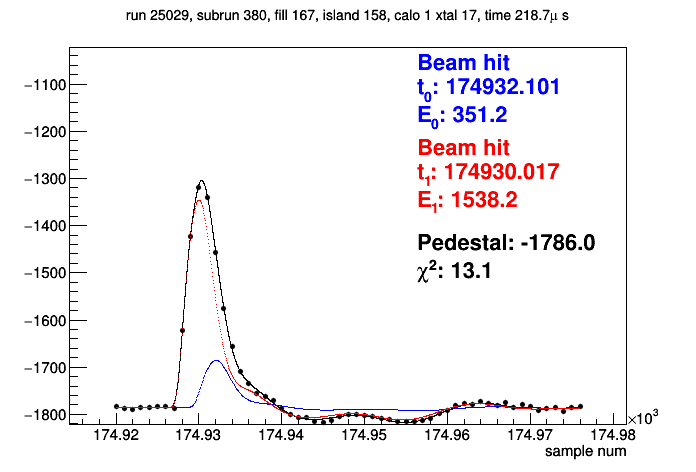

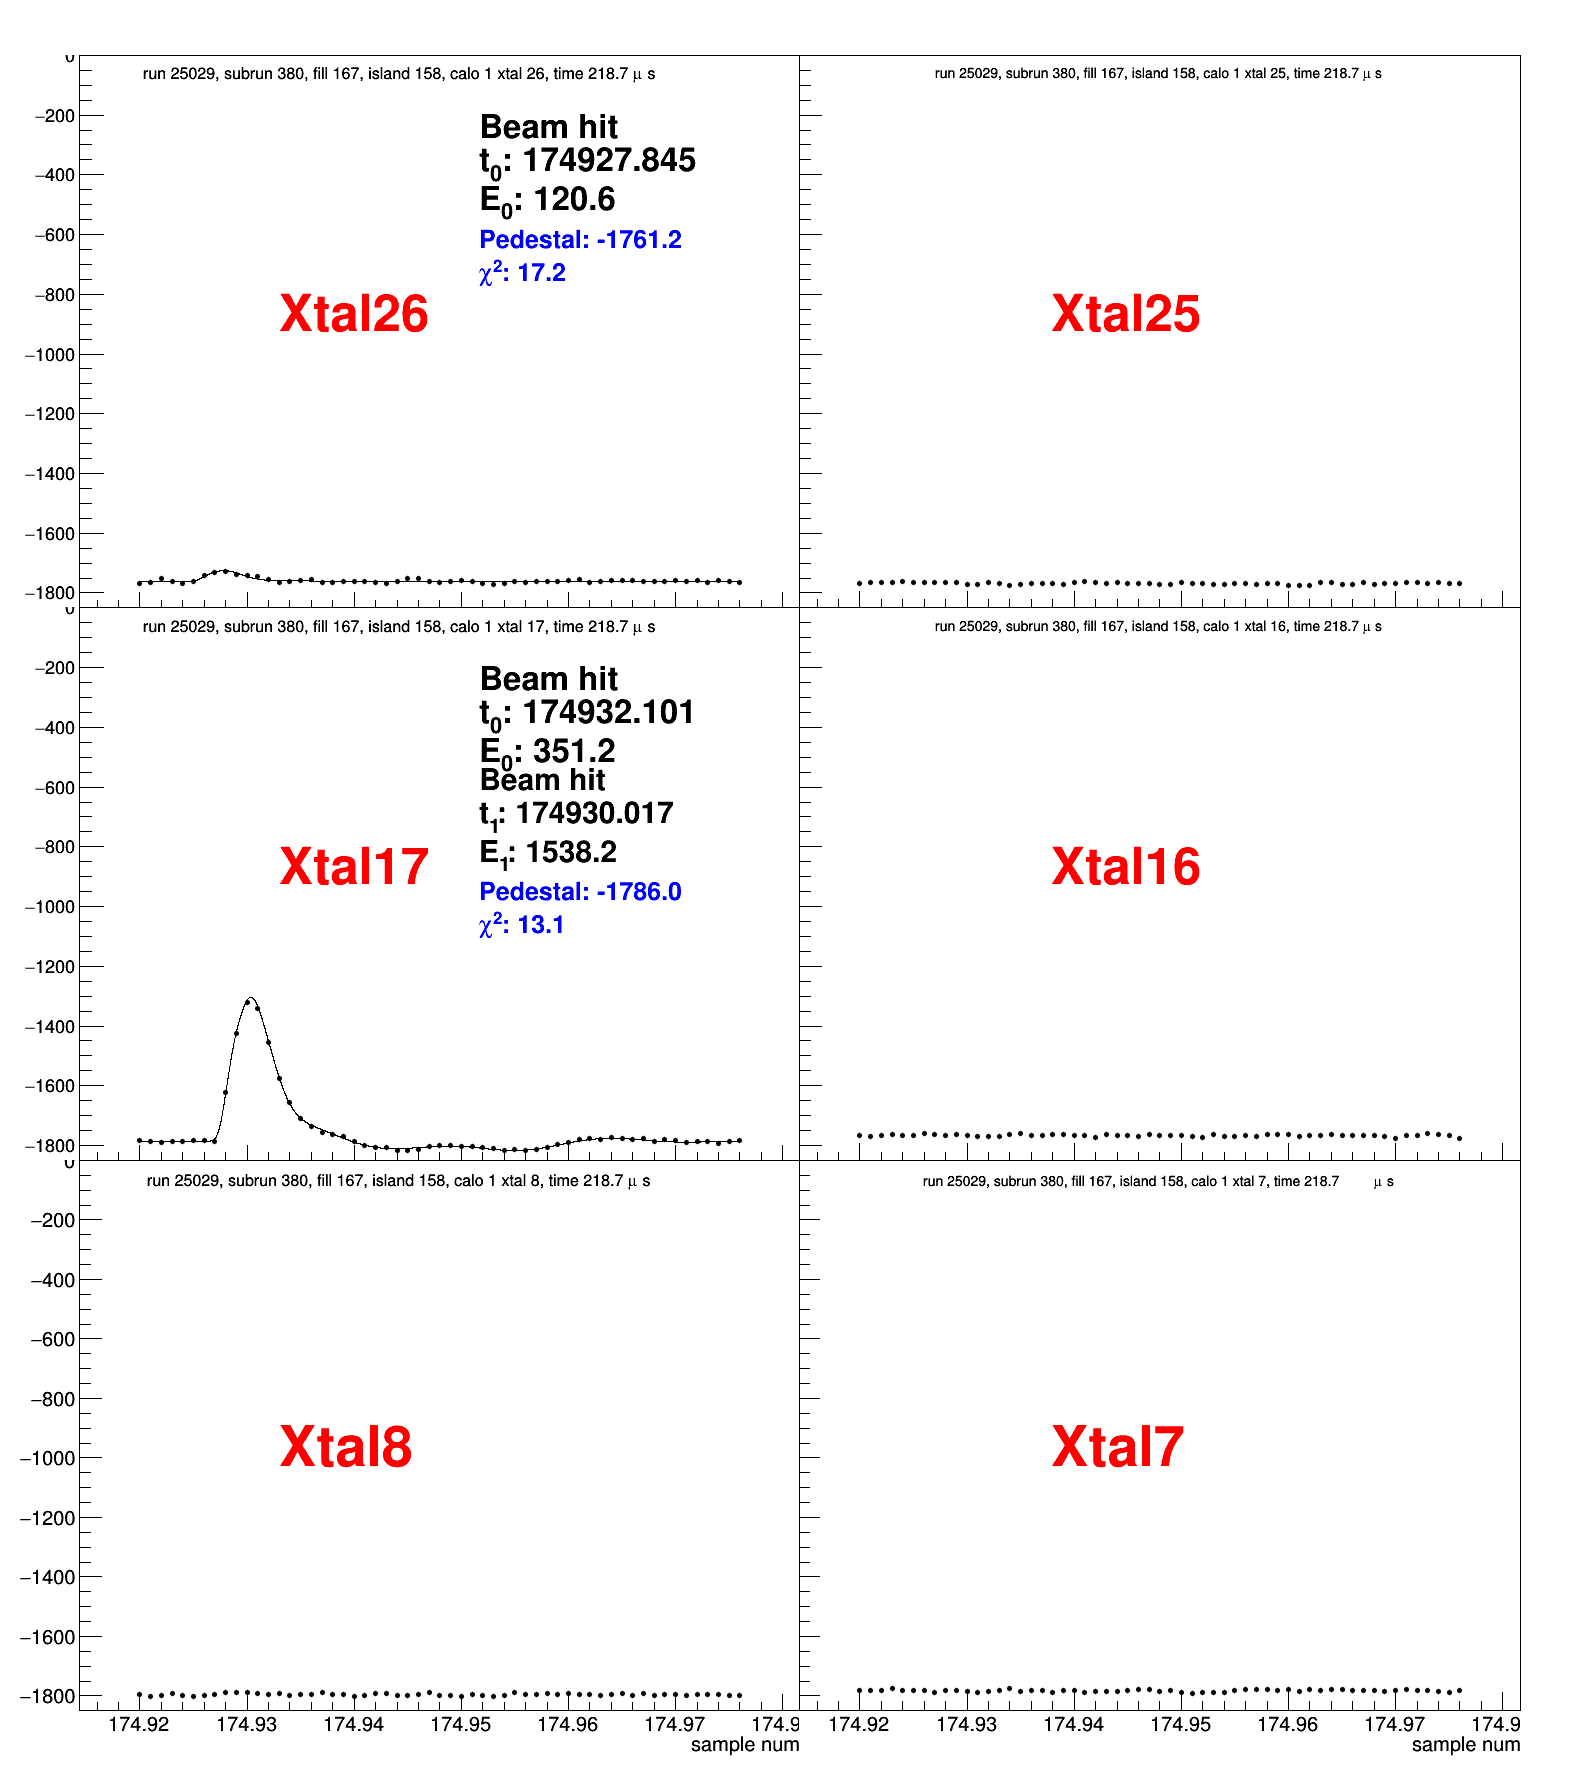

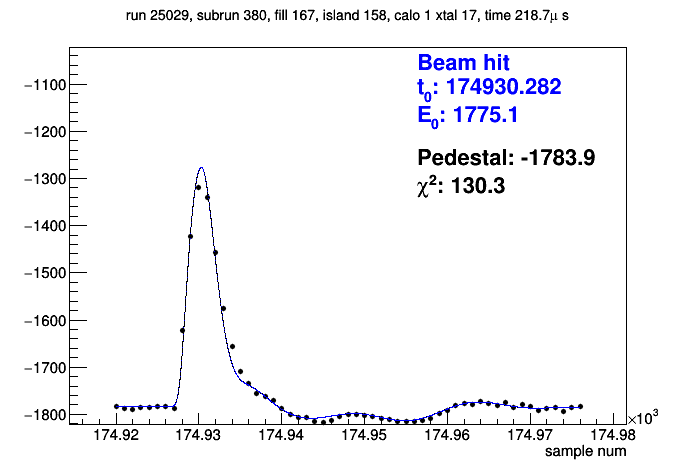

In [91]:
tag = trans_tag('1_17_167_158')
print(tag)
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
cs2 = viewer.draw_calo(*tag)
cs2[0].Draw()
cs3 = viewer_official.plot_xtal(*tag)
cs3[0].Draw()

In [25]:
# f = r.TFile('/Users/cheng/workspace/Data/hadd_readAnaHists_Randomized_cc_makehist_13k_partial_4_1/hists_official.root')


[1, 26, 9, 21, True, None]
[['Beam hit', 't_{0}: 117566.896', 'E_{0}: 2418.4'], ['Beam hit', 't_{1}: 117568.911', 'E_{1}: 290.0']] ['Pedestal: -1768.9', '#chi^{2}: 58.1']
0.6
[['Beam hit', 't_{0}: 117567.039', 'E_{0}: 2595.6']] ['Pedestal: -1765.1', '#chi^{2}: 204.5']
0.6


Warning in <TCanvas::Constructor>: Deleting canvas with same name: calo1


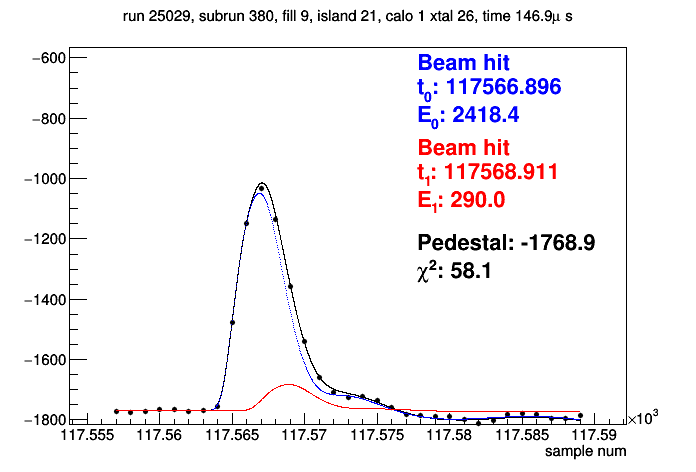

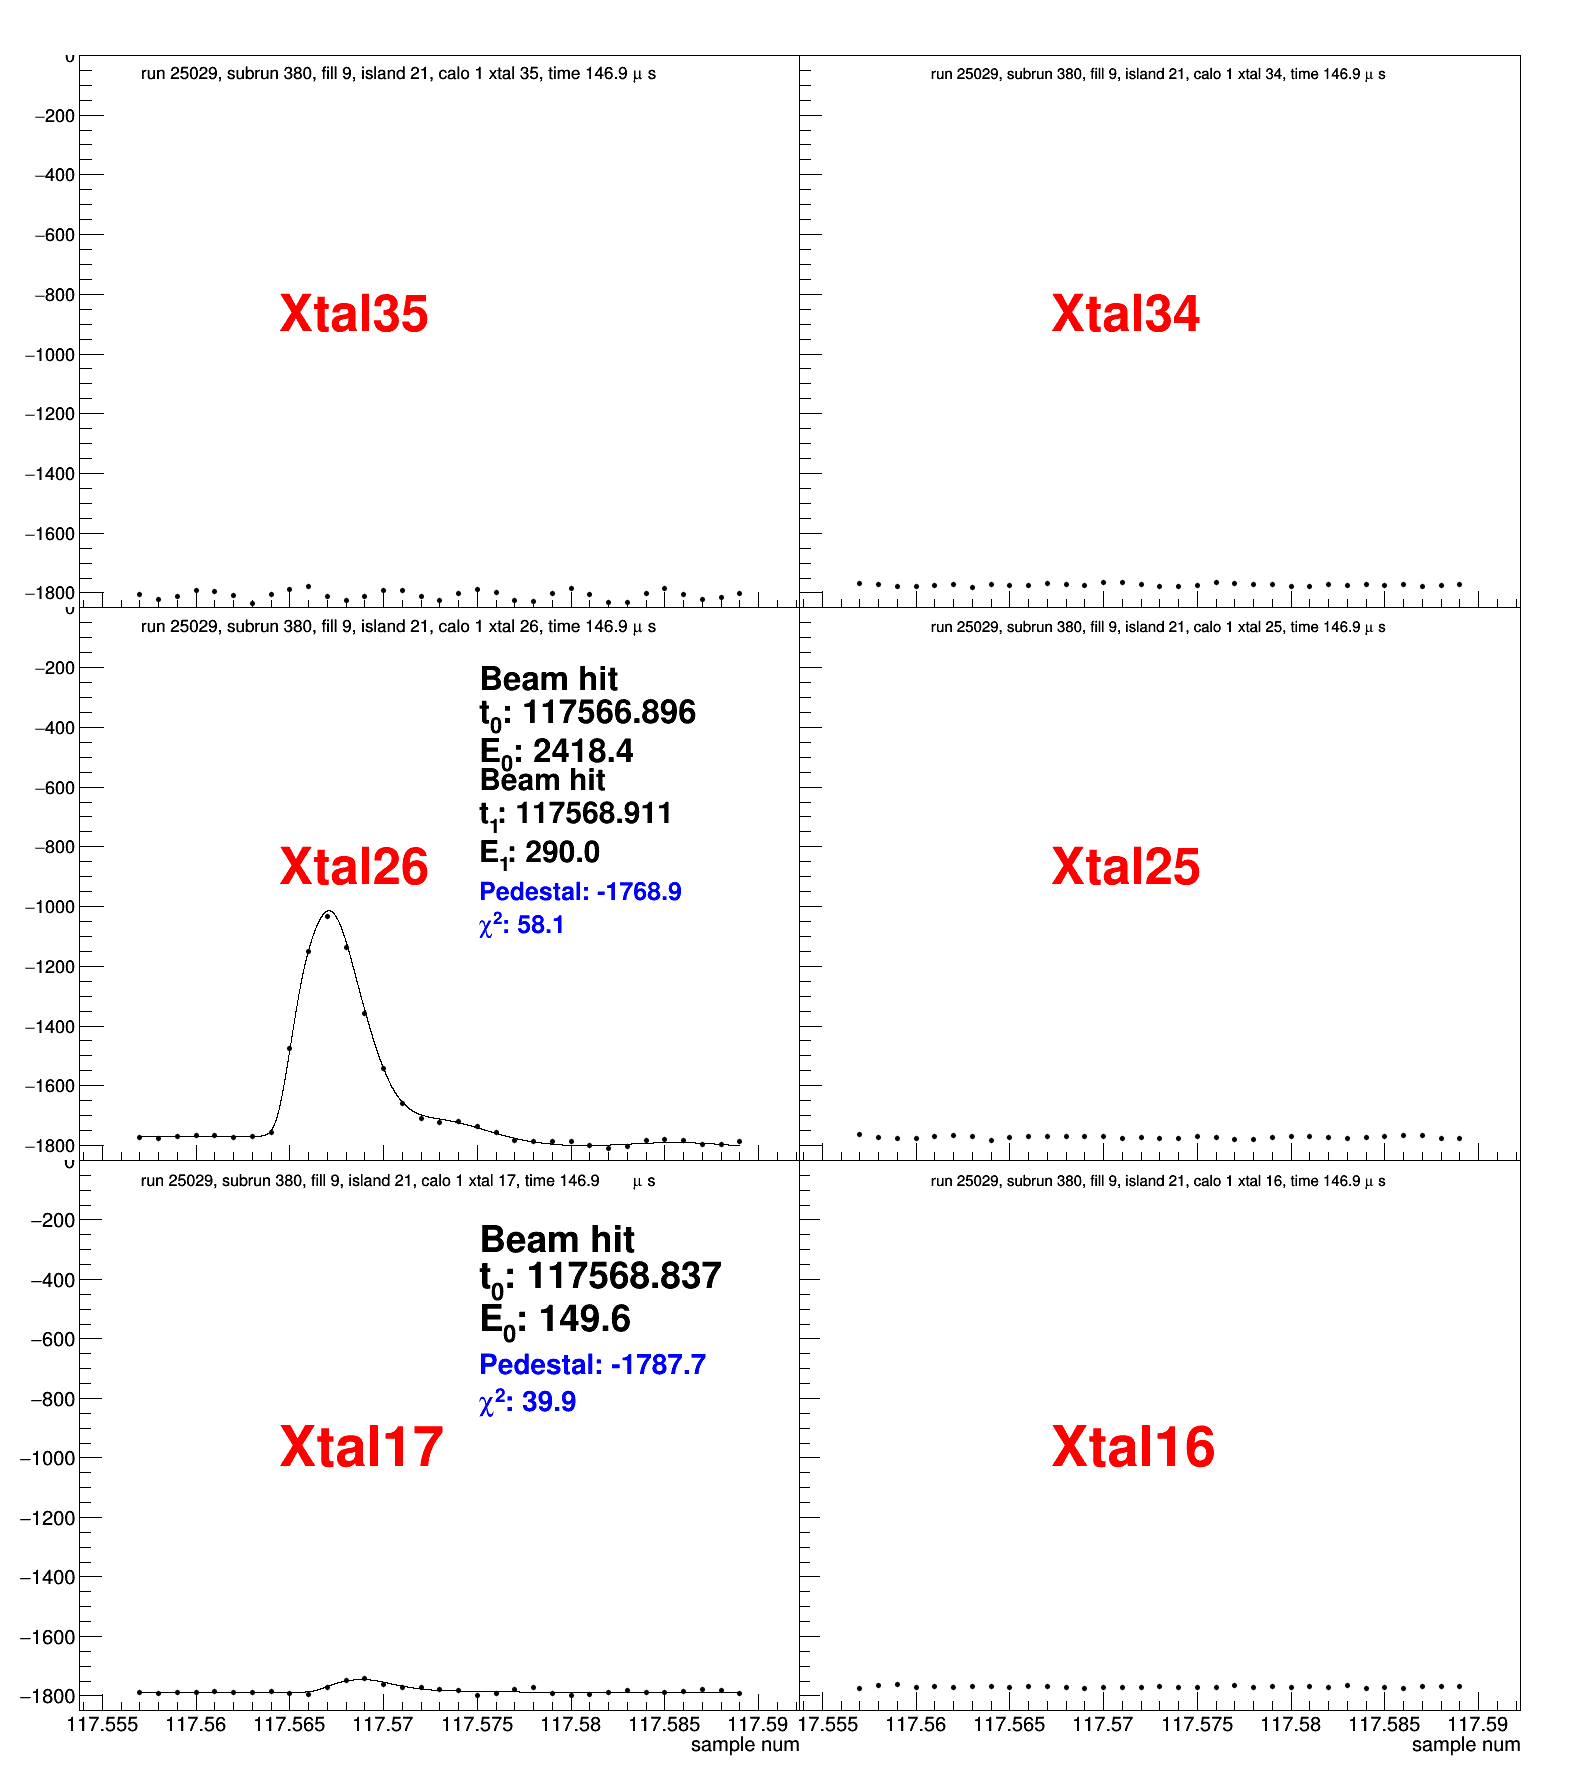

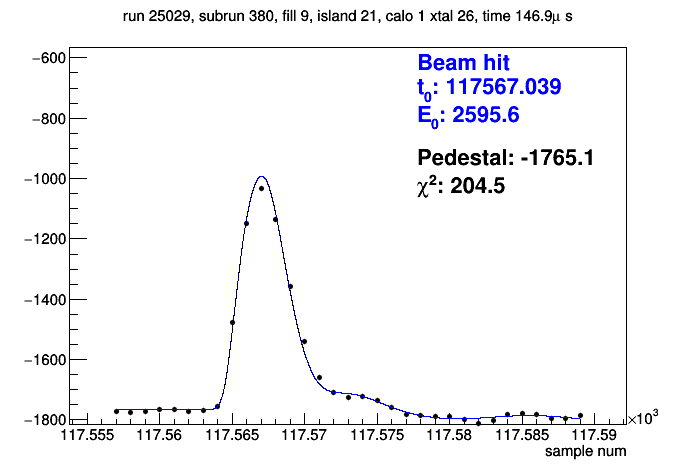

In [92]:
tag = trans_tag('1_26_9_21')
print(tag)
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
cs2 = viewer.draw_calo(*tag)
cs2[0].Draw()
cs3 = viewer_official.plot_xtal(*tag)
cs3[0].Draw()

[1, 32, 83, 45, True, None]
[['Beam hit', 't_{0}: 117183.247', 'E_{0}: 2860.9'], ['Beam hit', 't_{1}: 117187.366', 'E_{1}: 127.5']] ['Pedestal: -1771.5', '#chi^{2}: 17.0']
0.6
[['Beam hit', 't_{0}: 117183.271', 'E_{0}: 2875.7']] ['Pedestal: -1768.1', '#chi^{2}: 100.1']
0.6


Warning in <TCanvas::Constructor>: Deleting canvas with same name: calo1


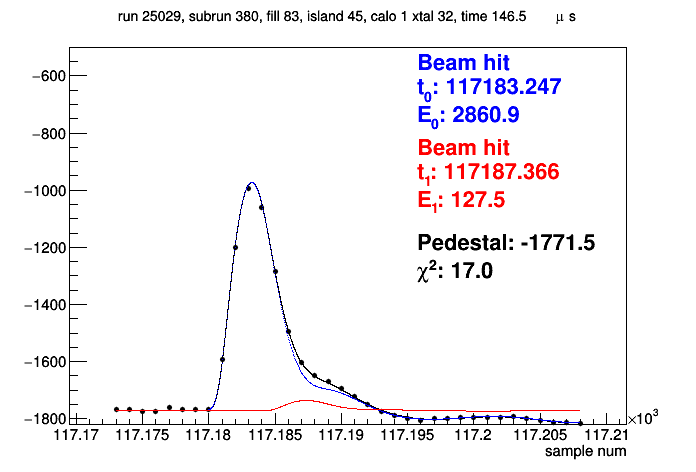

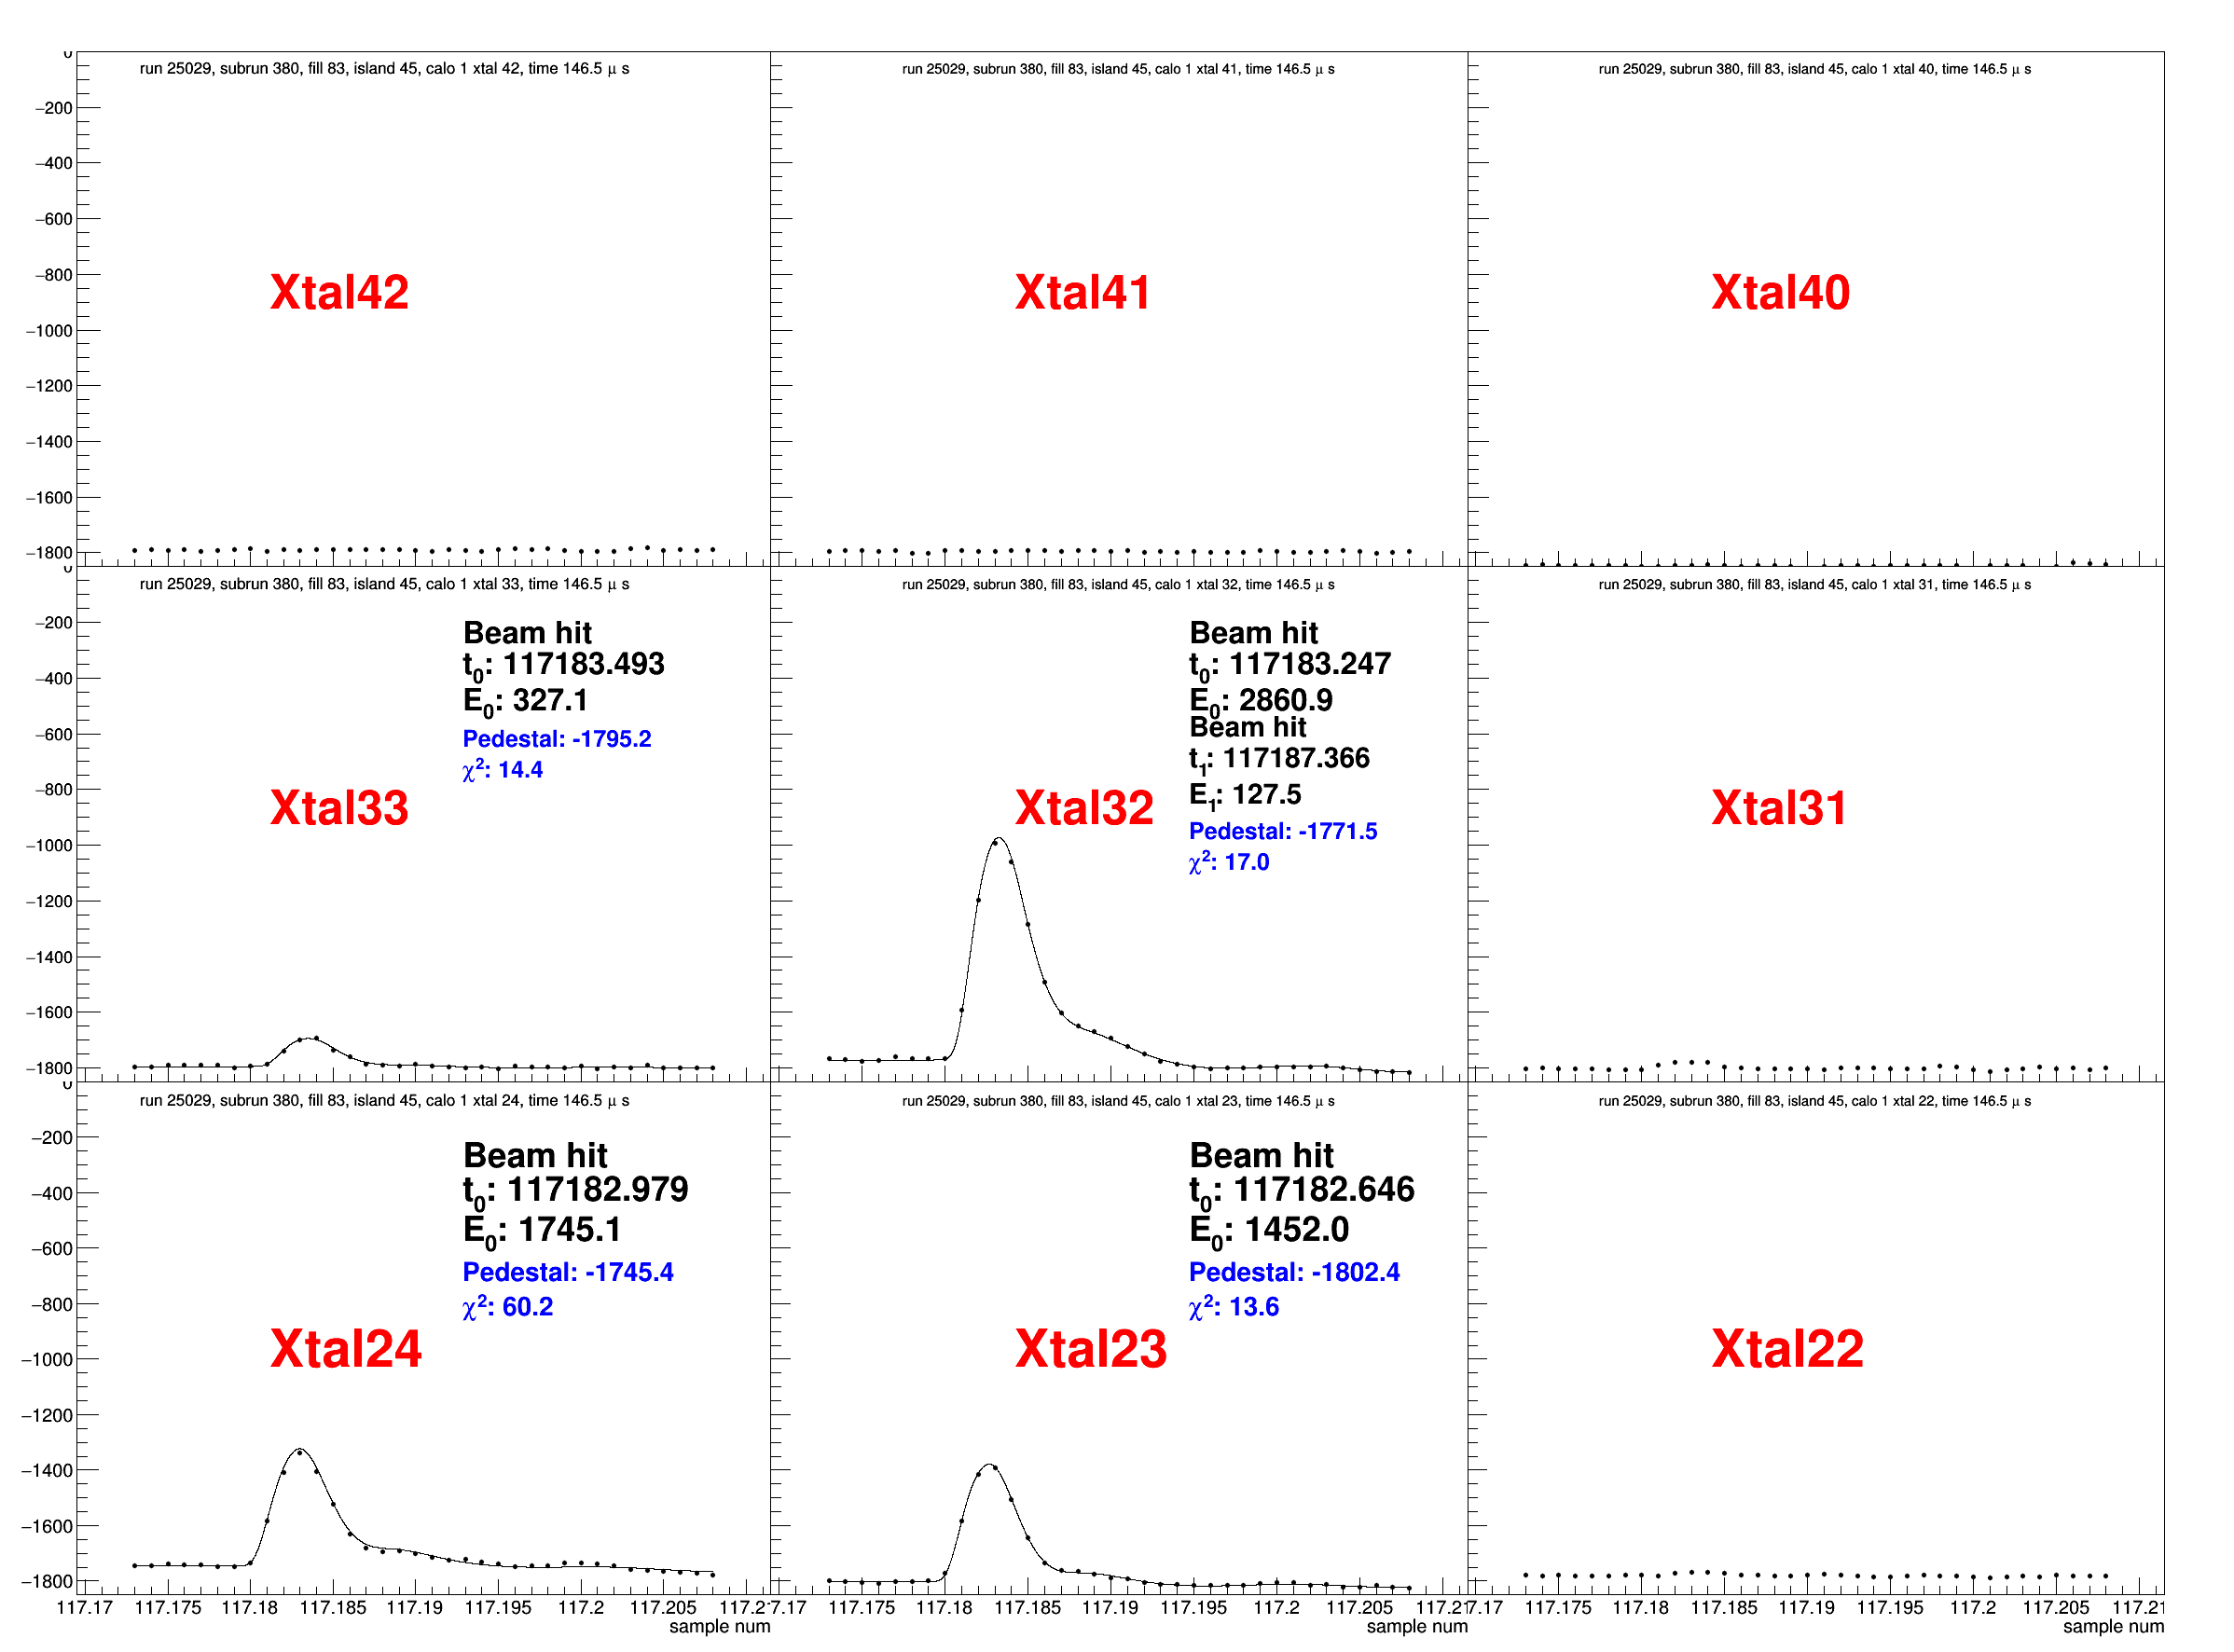

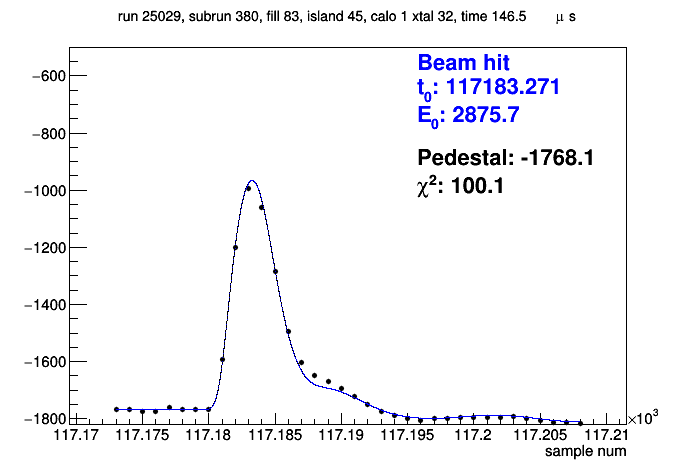

In [93]:
tag = trans_tag('1_32_83_45')
print(tag)
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
cs2 = viewer.draw_calo(*tag)
cs2[0].Draw()
cs3 = viewer_official.plot_xtal(*tag)
cs3[0].Draw()

[1, 16, 61, 151, True, None]
[['Beam hit', 't_{0}: 221159.427', 'E_{0}: 2475.5'], ['Beam hit', 't_{1}: 221163.967', 'E_{1}: 74.4']] ['Pedestal: -1767.0', '#chi^{2}: 28.6']
0.6
[['Beam hit', 't_{0}: 221159.440', 'E_{0}: 2479.2']] ['Pedestal: -1764.7', '#chi^{2}: 59.2']
0.6


Warning in <TCanvas::Constructor>: Deleting canvas with same name: calo1


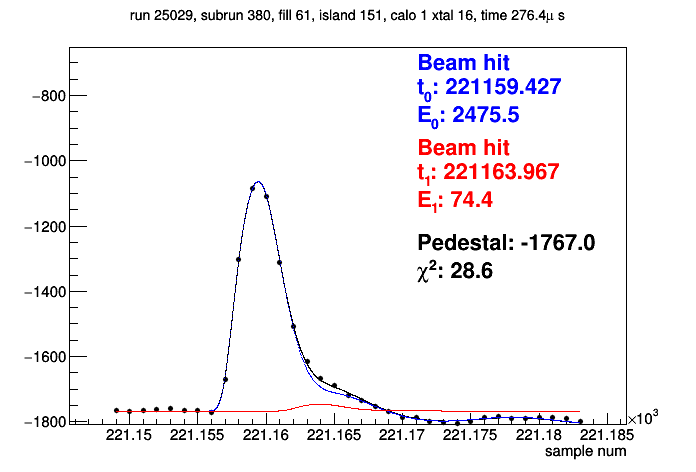

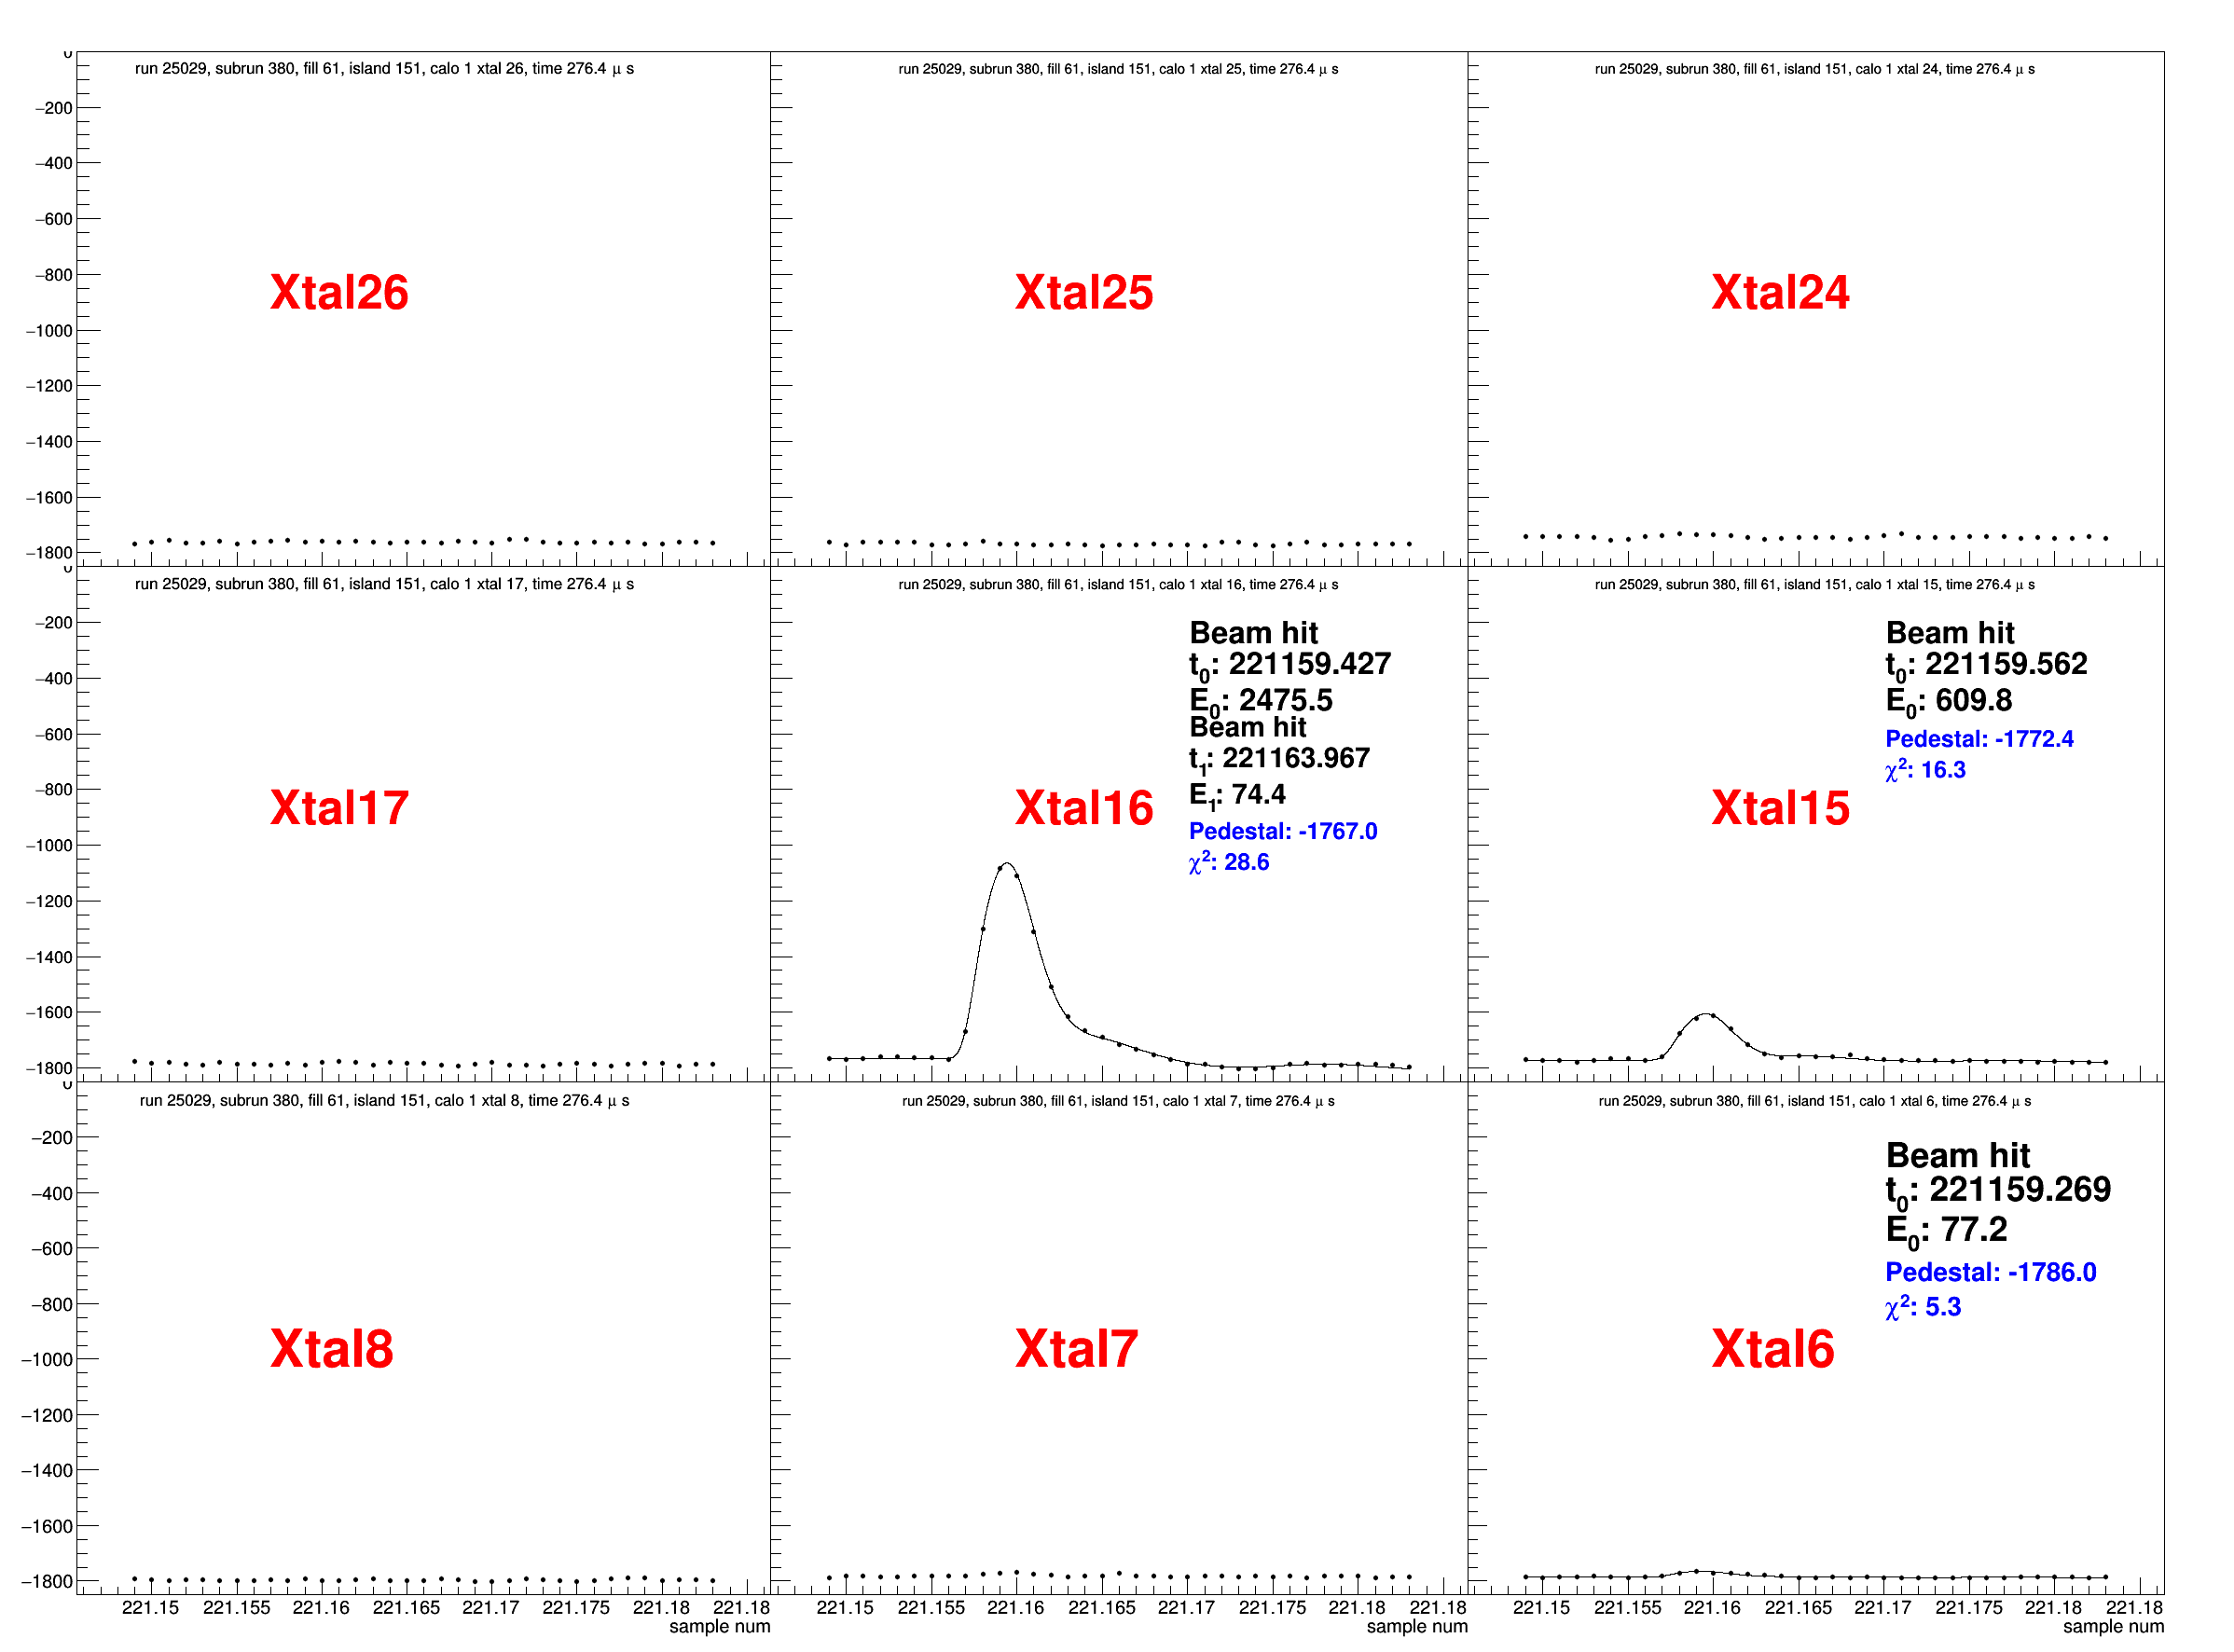

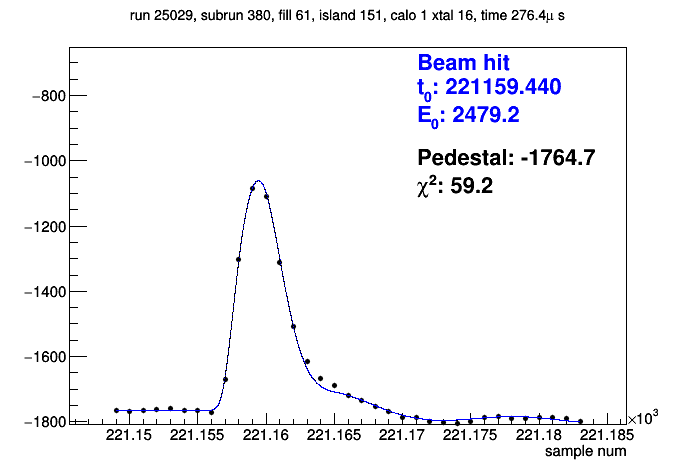

In [94]:
tag = trans_tag('1_16_61_151')
print(tag)
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
cs2 = viewer.draw_calo(*tag)
cs2[0].Draw()
cs3 = viewer_official.plot_xtal(*tag)
cs3[0].Draw()

[1, 7, 163, 140, True, None]
[['Beam hit', 't_{0}: 241531.001', 'E_{0}: 1579.5'], ['Beam hit', 't_{1}: 241535.307', 'E_{1}: 87.8']] ['Pedestal: -1783.2', '#chi^{2}: 13.3']
0.6
[['Beam hit', 't_{0}: 241531.023', 'E_{0}: 1581.5']] ['Pedestal: -1780.4', '#chi^{2}: 64.2']
0.6


Warning in <TCanvas::Constructor>: Deleting canvas with same name: calo1


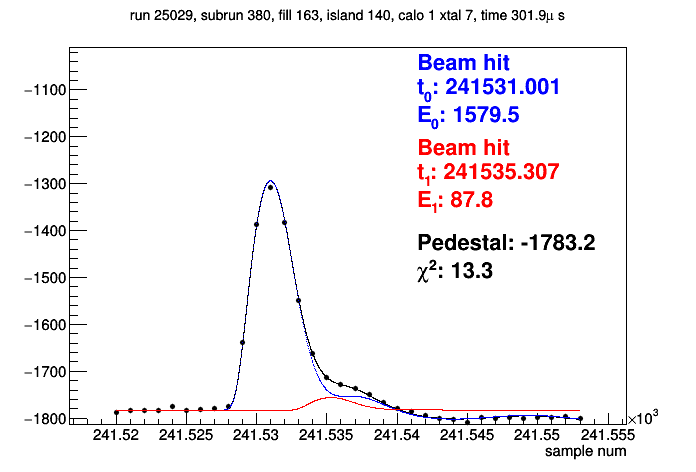

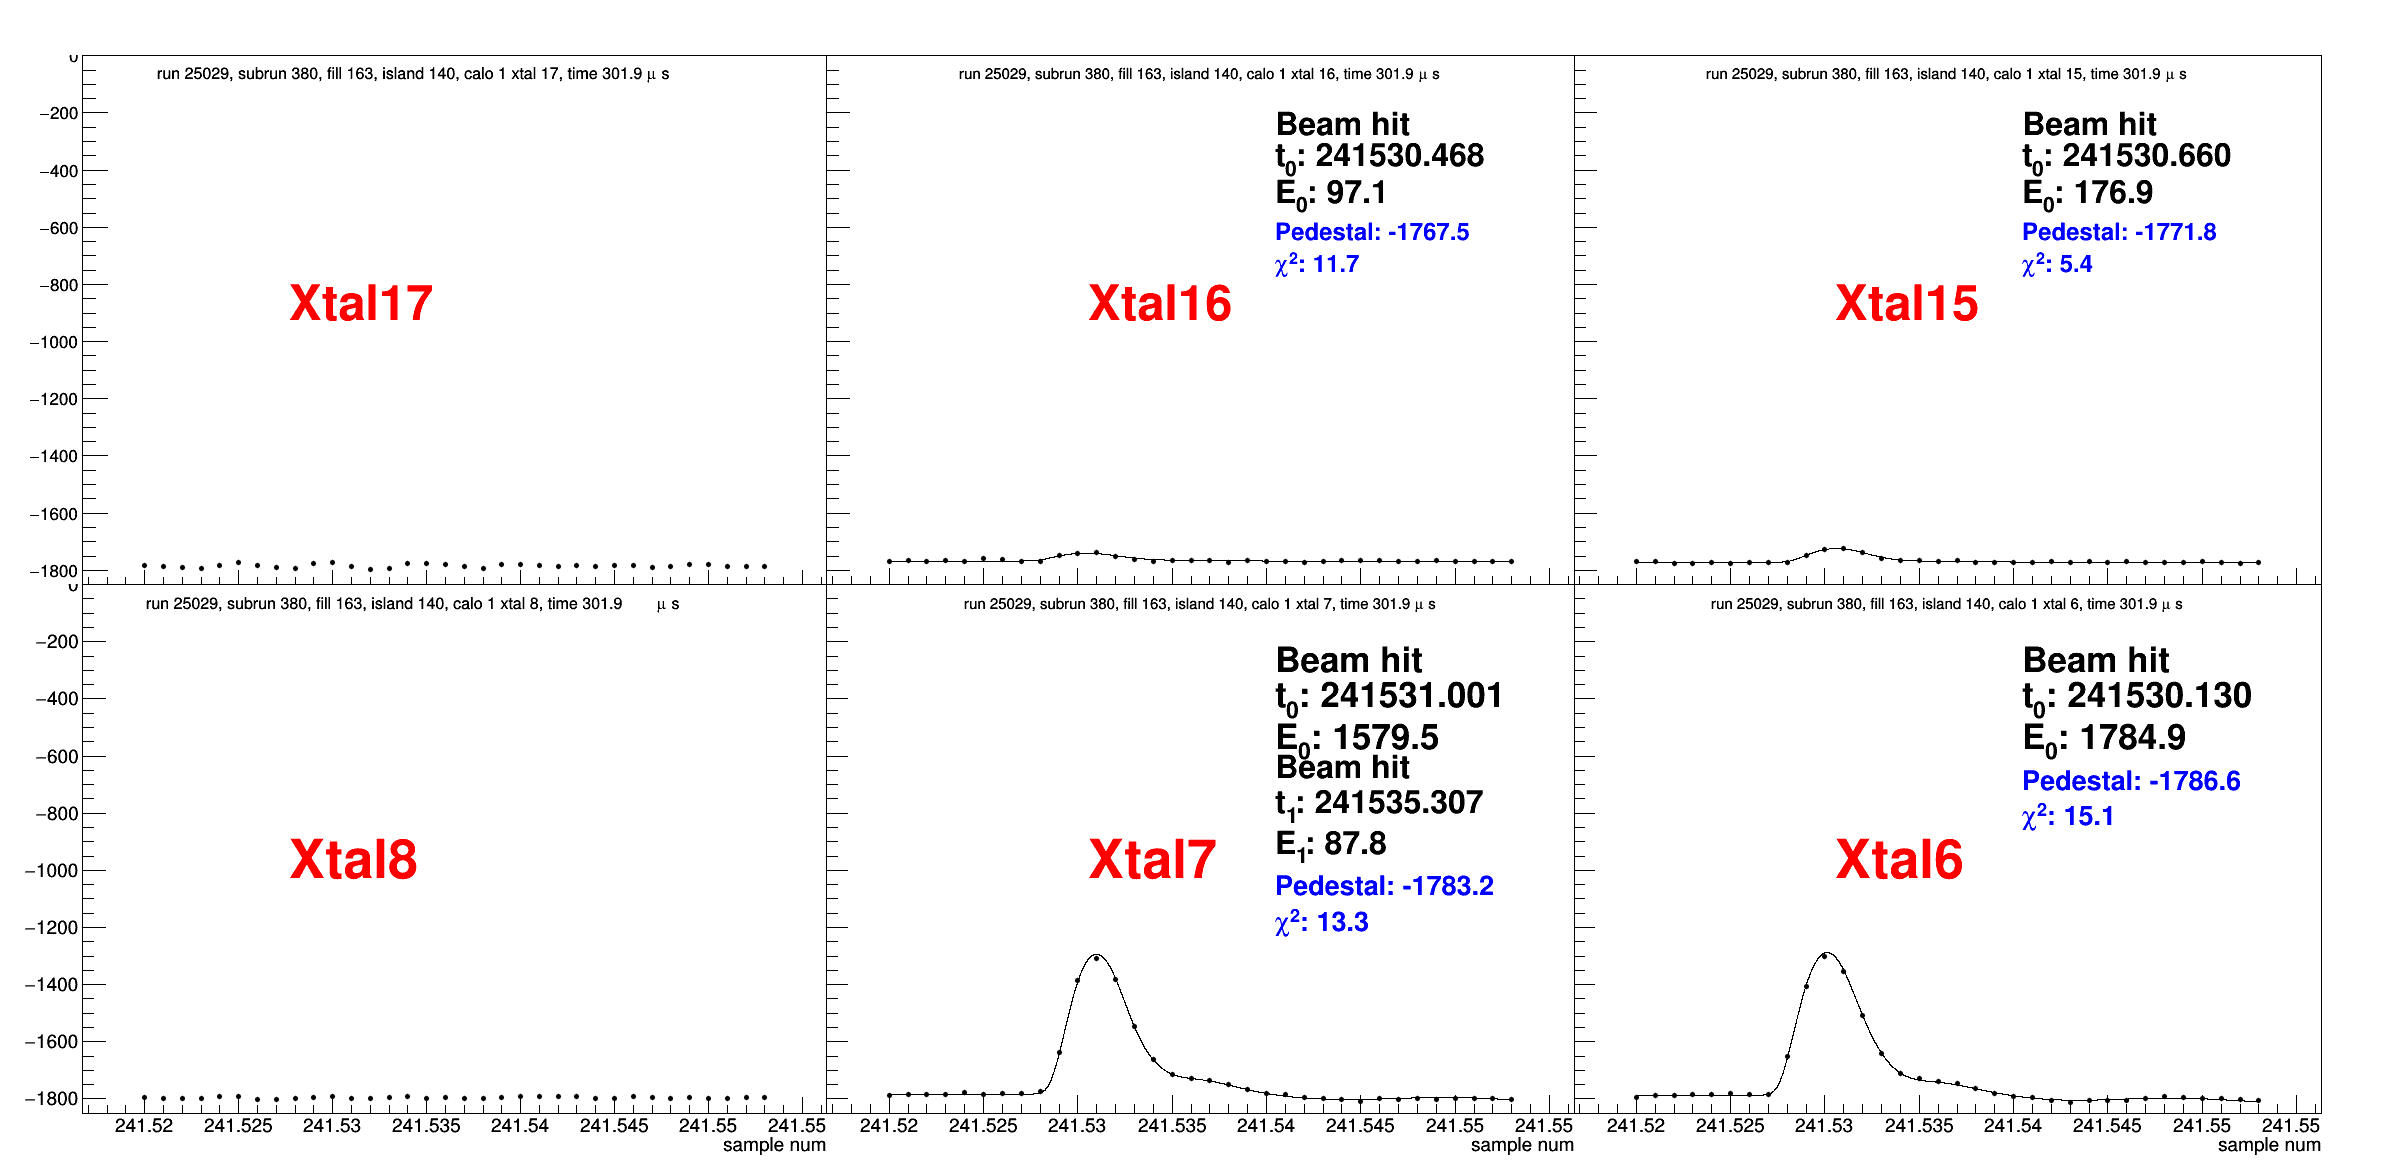

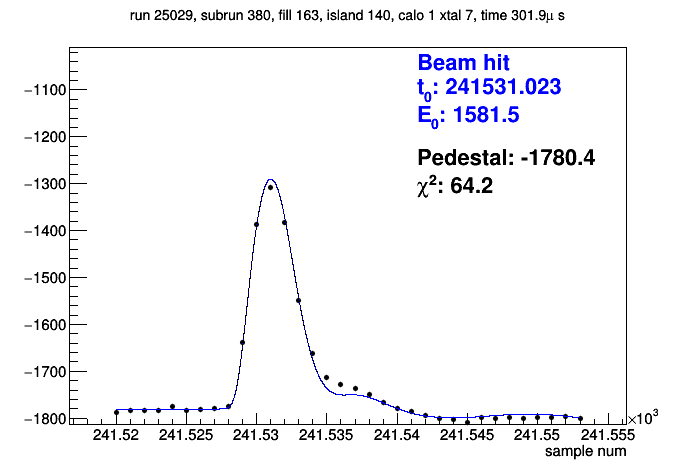

In [95]:
tag = trans_tag('1_7_163_140')
print(tag)
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
cs2 = viewer.draw_calo(*tag)
cs2[0].Draw()
cs3 = viewer_official.plot_xtal(*tag)
cs3[0].Draw()

[1, 29, 217, 10, True, None]
[['Beam hit', 't_{0}: 113949.773', 'E_{0}: 858.1'], ['Beam hit', 't_{1}: 113954.183', 'E_{1}: 76.0']] ['Pedestal: -1803.9', '#chi^{2}: 9.6']
0.6
[['Beam hit', 't_{0}: 113949.807', 'E_{0}: 857.0']] ['Pedestal: -1801.2', '#chi^{2}: 50.5']
0.6


Warning in <TCanvas::Constructor>: Deleting canvas with same name: calo1


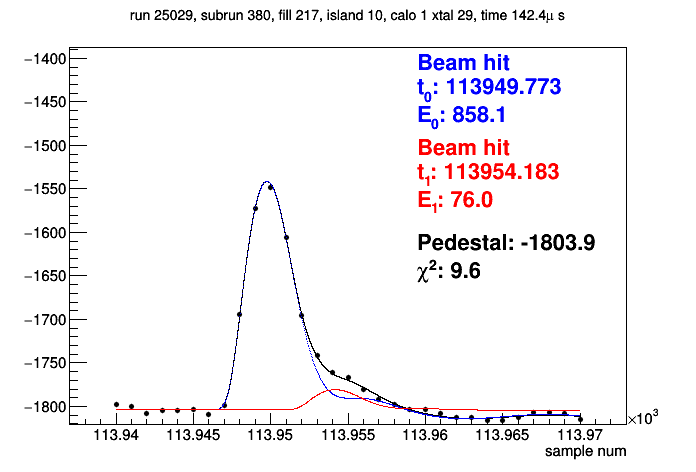

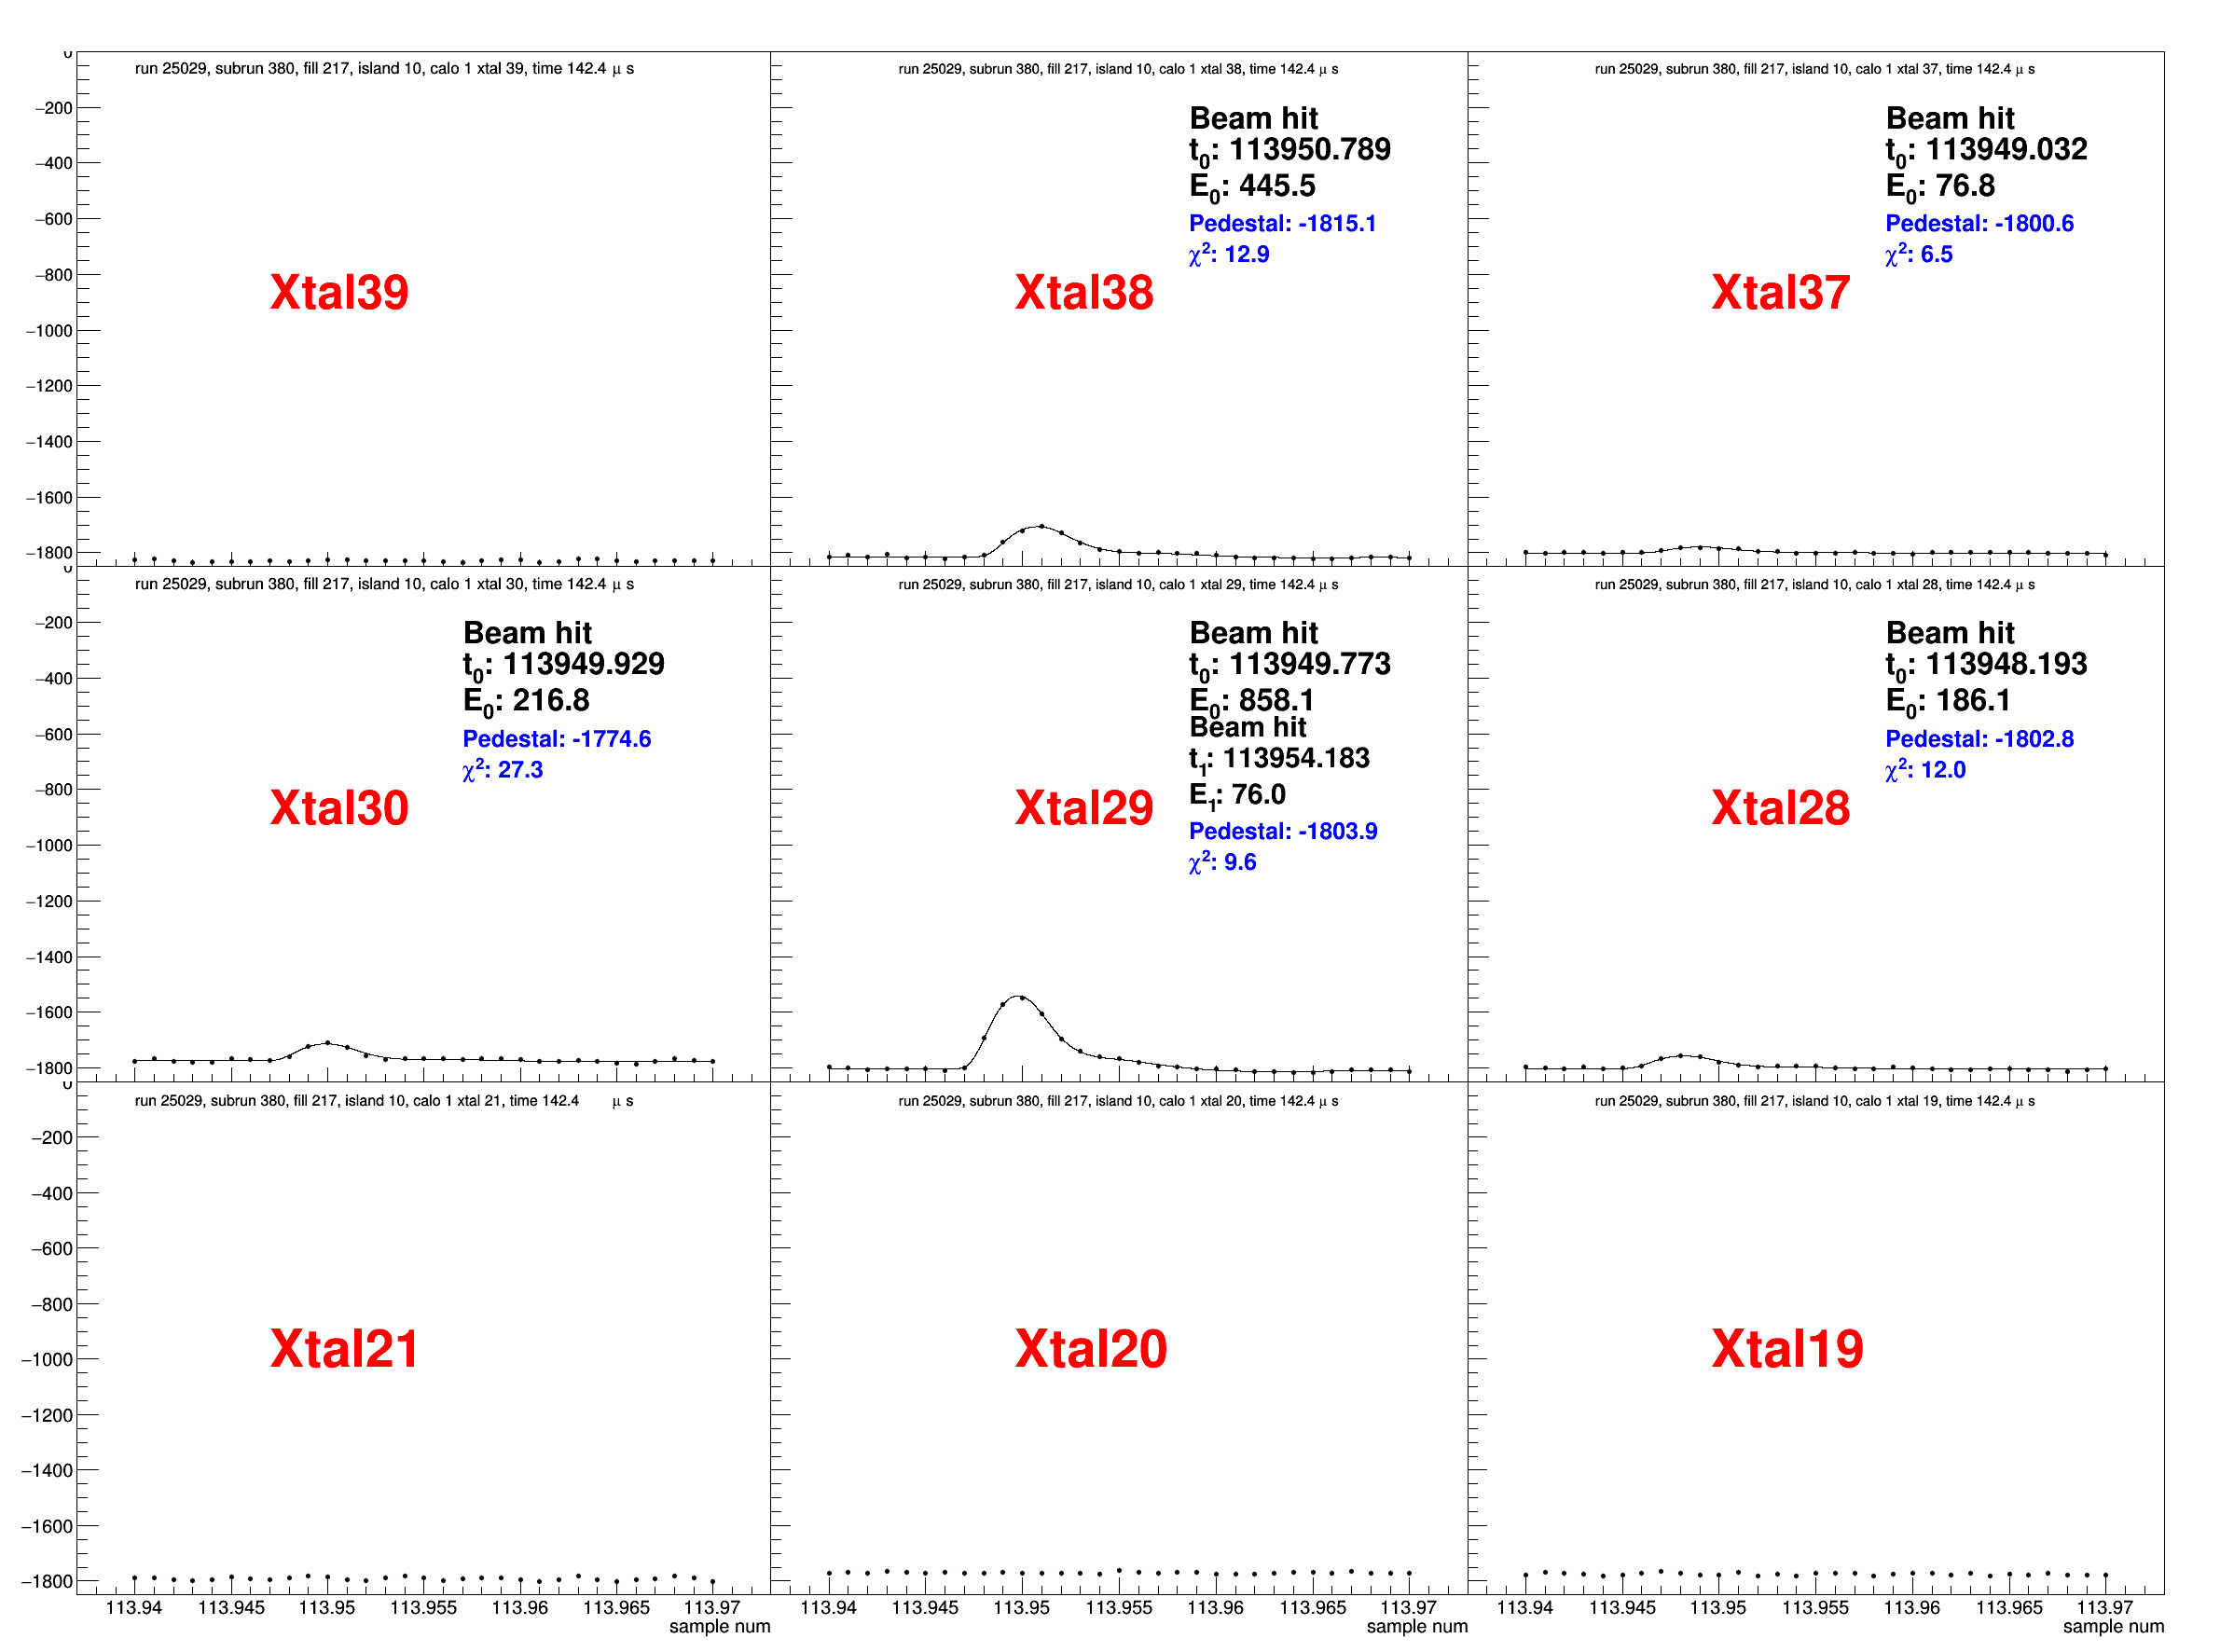

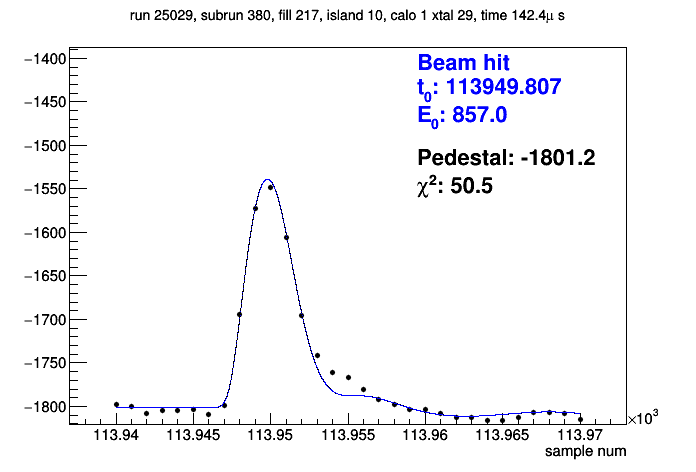

In [96]:
tag = trans_tag('1_29_217_10')
print(tag)
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
cs2 = viewer.draw_calo(*tag)
cs2[0].Draw()
cs3 = viewer_official.plot_xtal(*tag)
cs3[0].Draw()

[1, 18, 35, 103, True, None]
[['Beam hit', 't_{0}: 153251.866', 'E_{0}: 1983.8'], ['Beam hit', 't_{1}: 153257.074', 'E_{1}: 79.5']] ['Pedestal: -1763.0', '#chi^{2}: 16.8']
0.6
[['Beam hit', 't_{0}: 153251.877', 'E_{0}: 1982.9']] ['Pedestal: -1760.4', '#chi^{2}: 57.5']
0.6


Warning in <TCanvas::Constructor>: Deleting canvas with same name: calo1


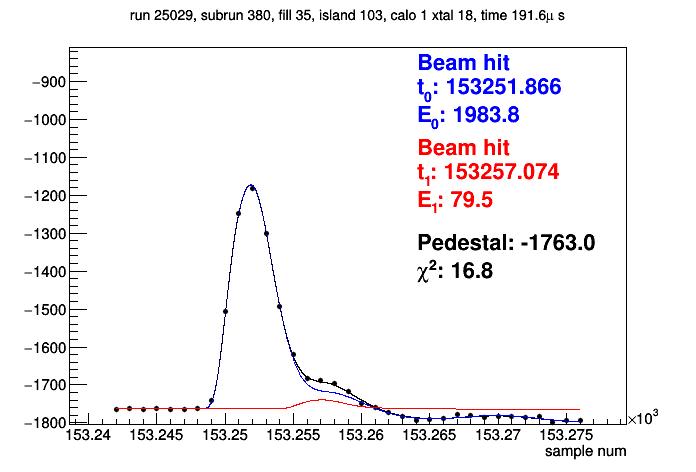

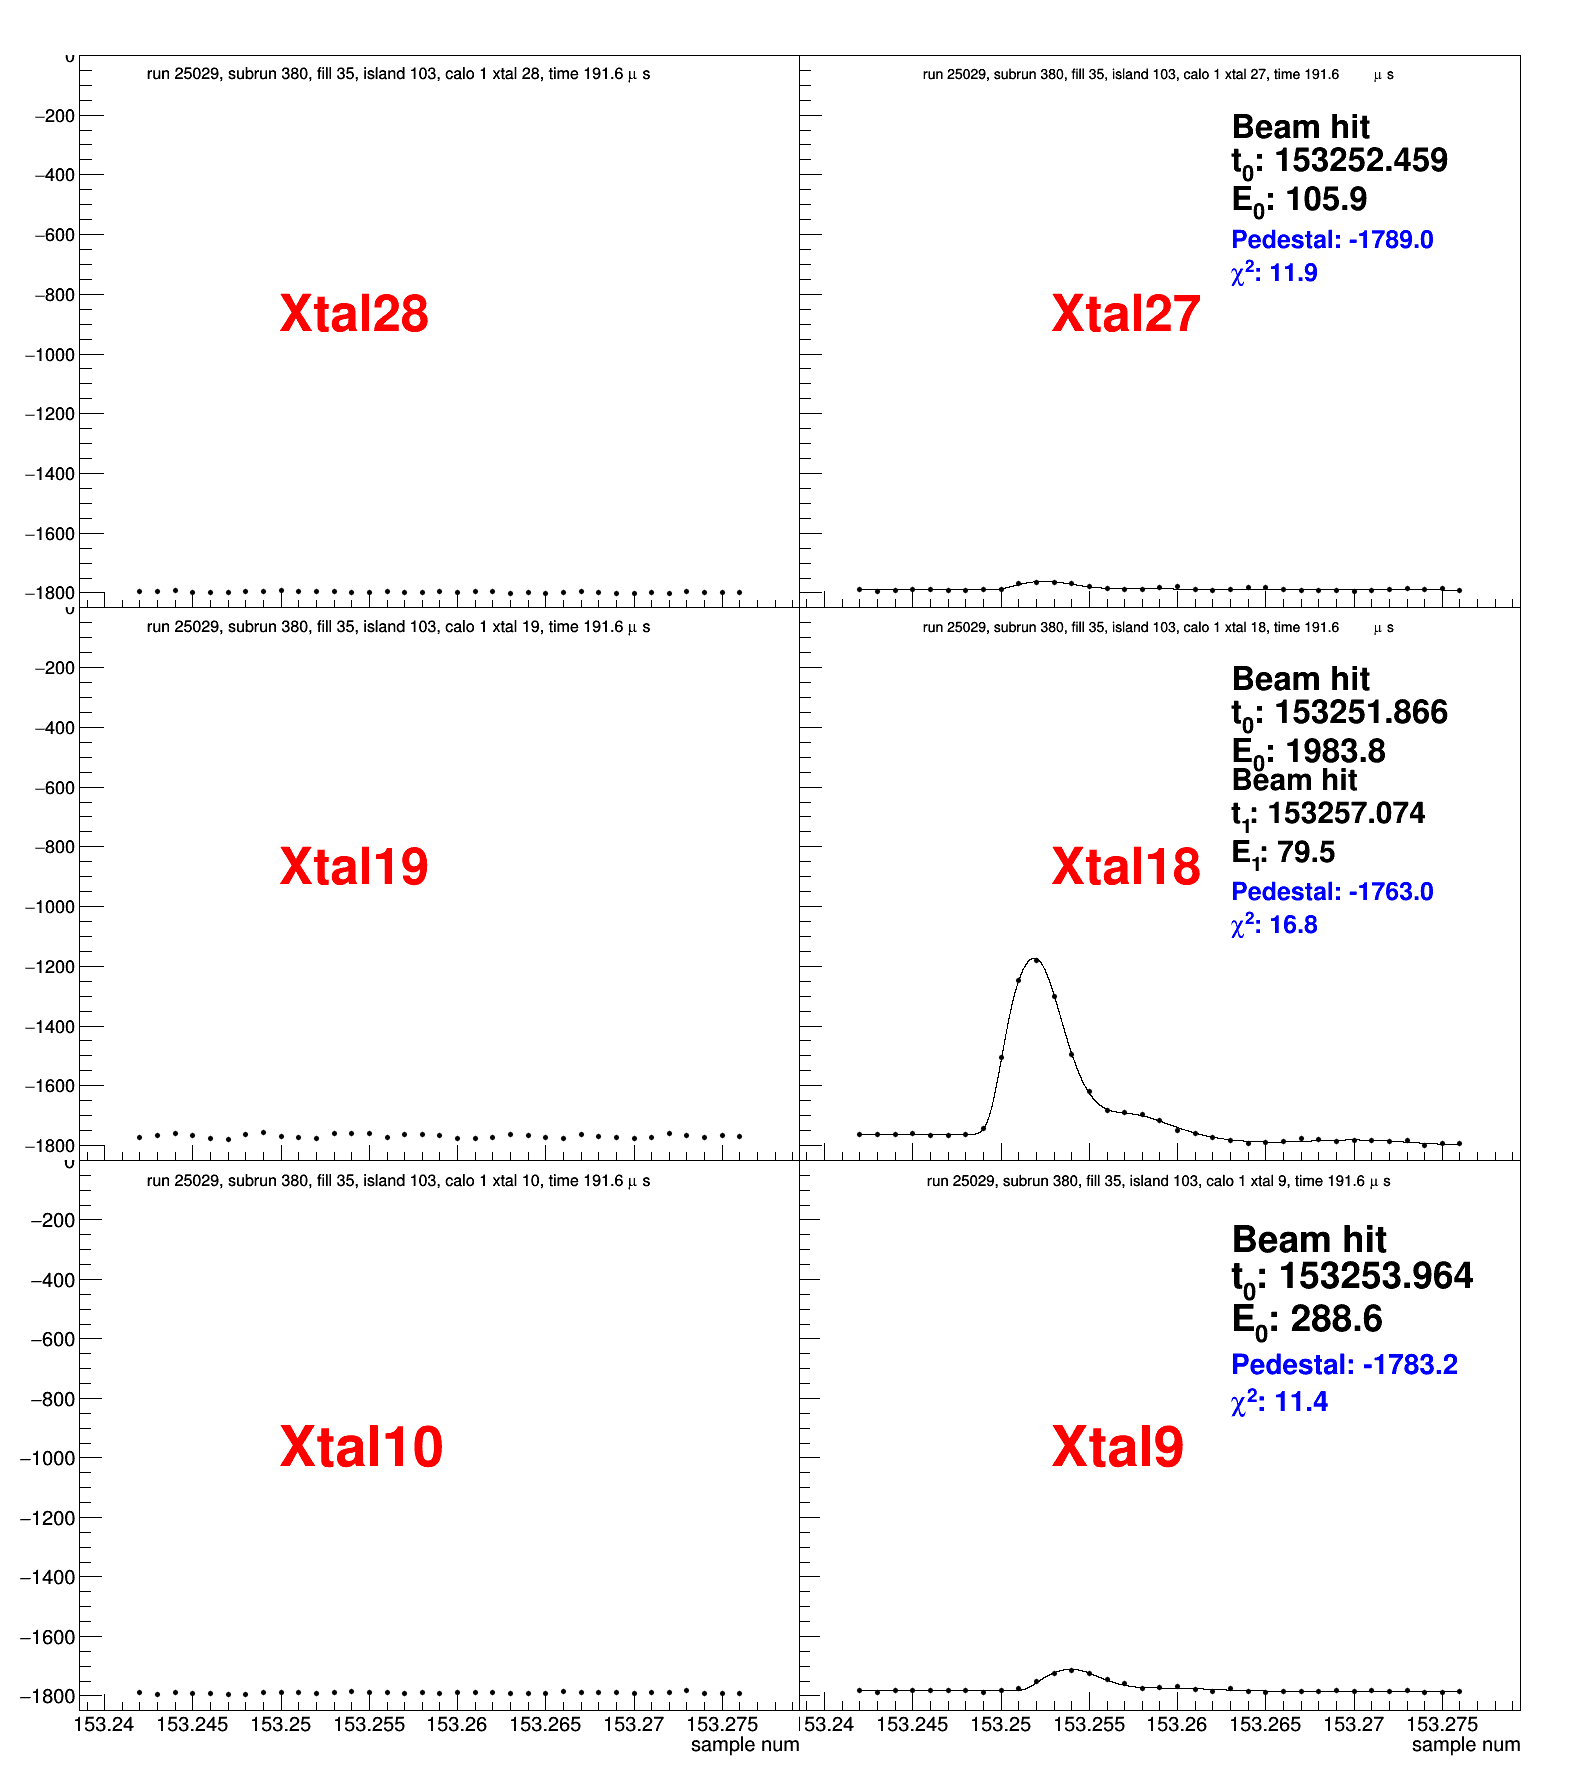

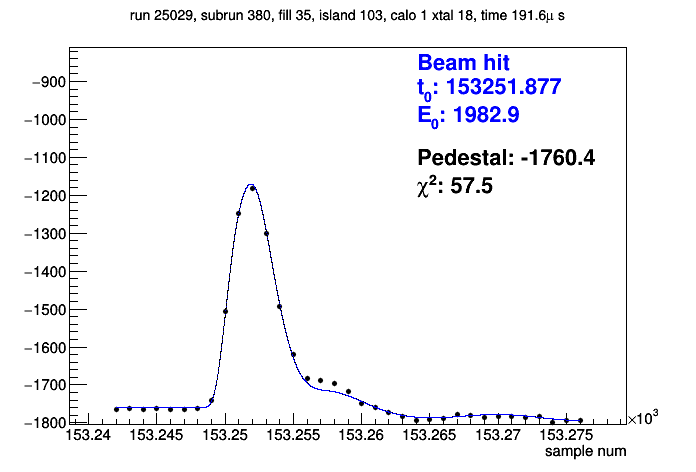

In [97]:
tag = trans_tag('1_18_35_103')
print(tag)
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
cs2 = viewer.draw_calo(*tag)
cs2[0].Draw()
cs3 = viewer_official.plot_xtal(*tag)
cs3[0].Draw()

In [26]:
# c = r.TCanvas()
# h = f.Get('inFillGainCorrector/hist_timewindow_StatusTrue_timeGT30_calo1_xtal0_energy')
# print (h)
# h.GetXaxis().SetRangeUser(0,100)
# h.Draw()
# c.Draw()

[1, 41, 157, 155, True, None]
[['Beam hit', 't_{0}: 228753.159', 'E_{0}: 310.0'], ['Beam hit', 't_{1}: 228761.669', 'E_{1}: 69.0']] ['Pedestal: -1794.1', '#chi^{2}: 8.9']
0.6
[['Beam hit', 't_{0}: 228753.187', 'E_{0}: 303.5']] ['Pedestal: -1792.3', '#chi^{2}: 33.2']
0.6


Warning in <TCanvas::Constructor>: Deleting canvas with same name: calo1


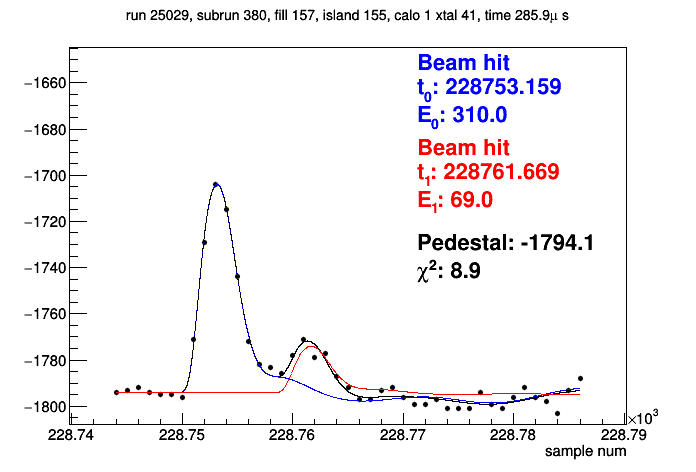

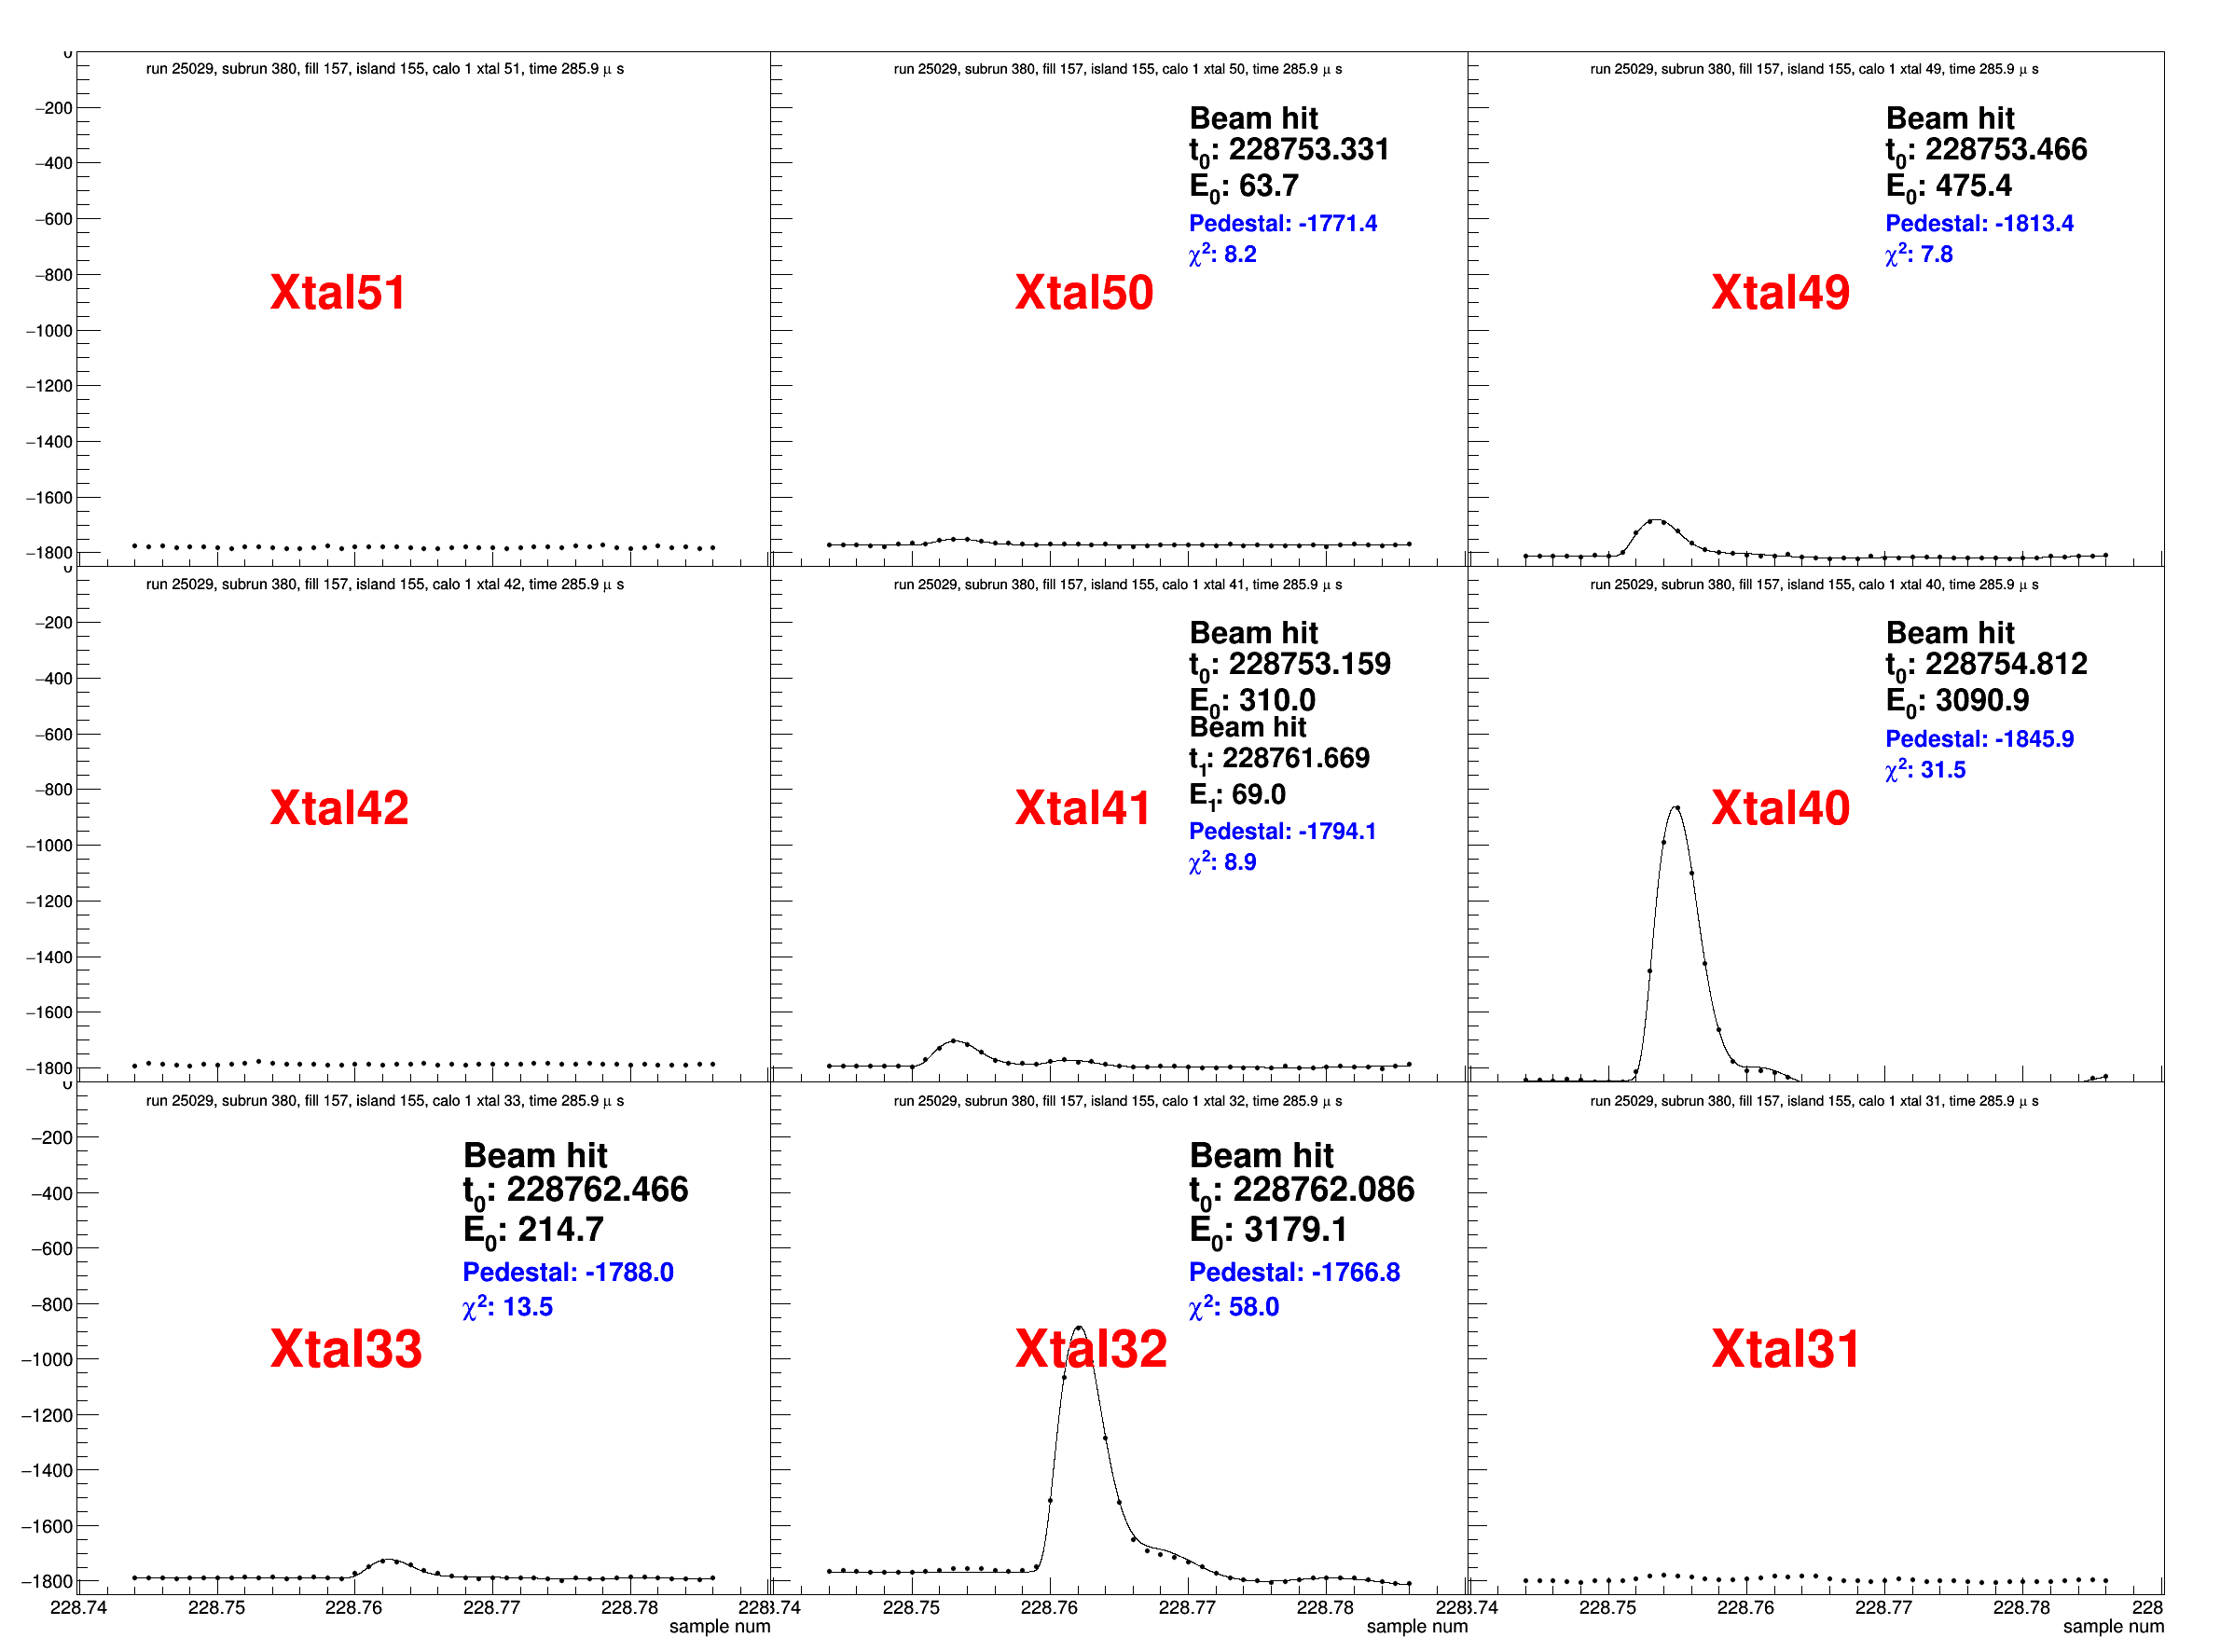

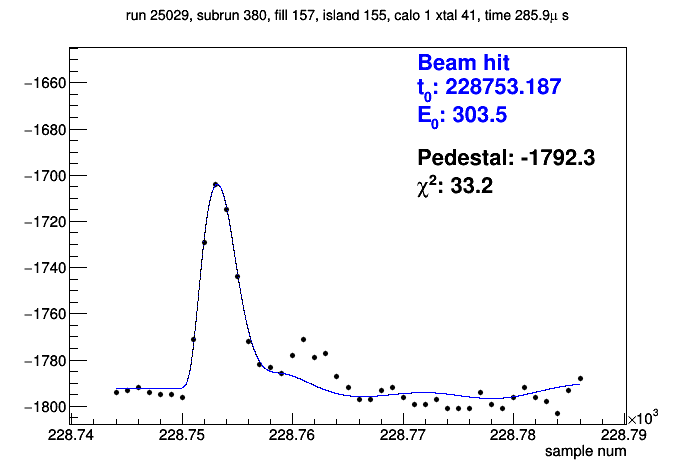

In [98]:
tag = trans_tag('1_41_157_155')
print(tag)
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
cs2 = viewer.draw_calo(*tag)
cs2[0].Draw()
cs3 = viewer_official.plot_xtal(*tag)
cs3[0].Draw()

[1, 31, 53, 88, True, None]
[['Beam hit', 't_{0}: 137881.349', 'E_{0}: 3708.5'], ['Beam hit', 't_{1}: 137889.615', 'E_{1}: 191.0']] ['Pedestal: -1807.6', '#chi^{2}: 96.1']
0.6
[['Beam hit', 't_{0}: 137881.356', 'E_{0}: 3688.9']] ['Pedestal: -1801.8', '#chi^{2}: 219.1']
0.6


Warning in <TCanvas::Constructor>: Deleting canvas with same name: calo1


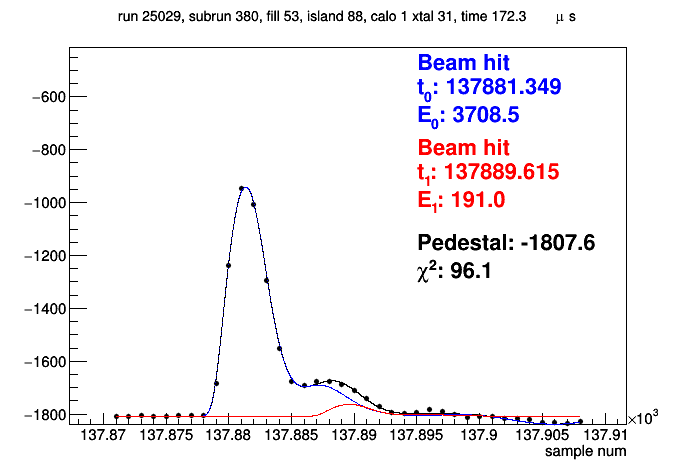

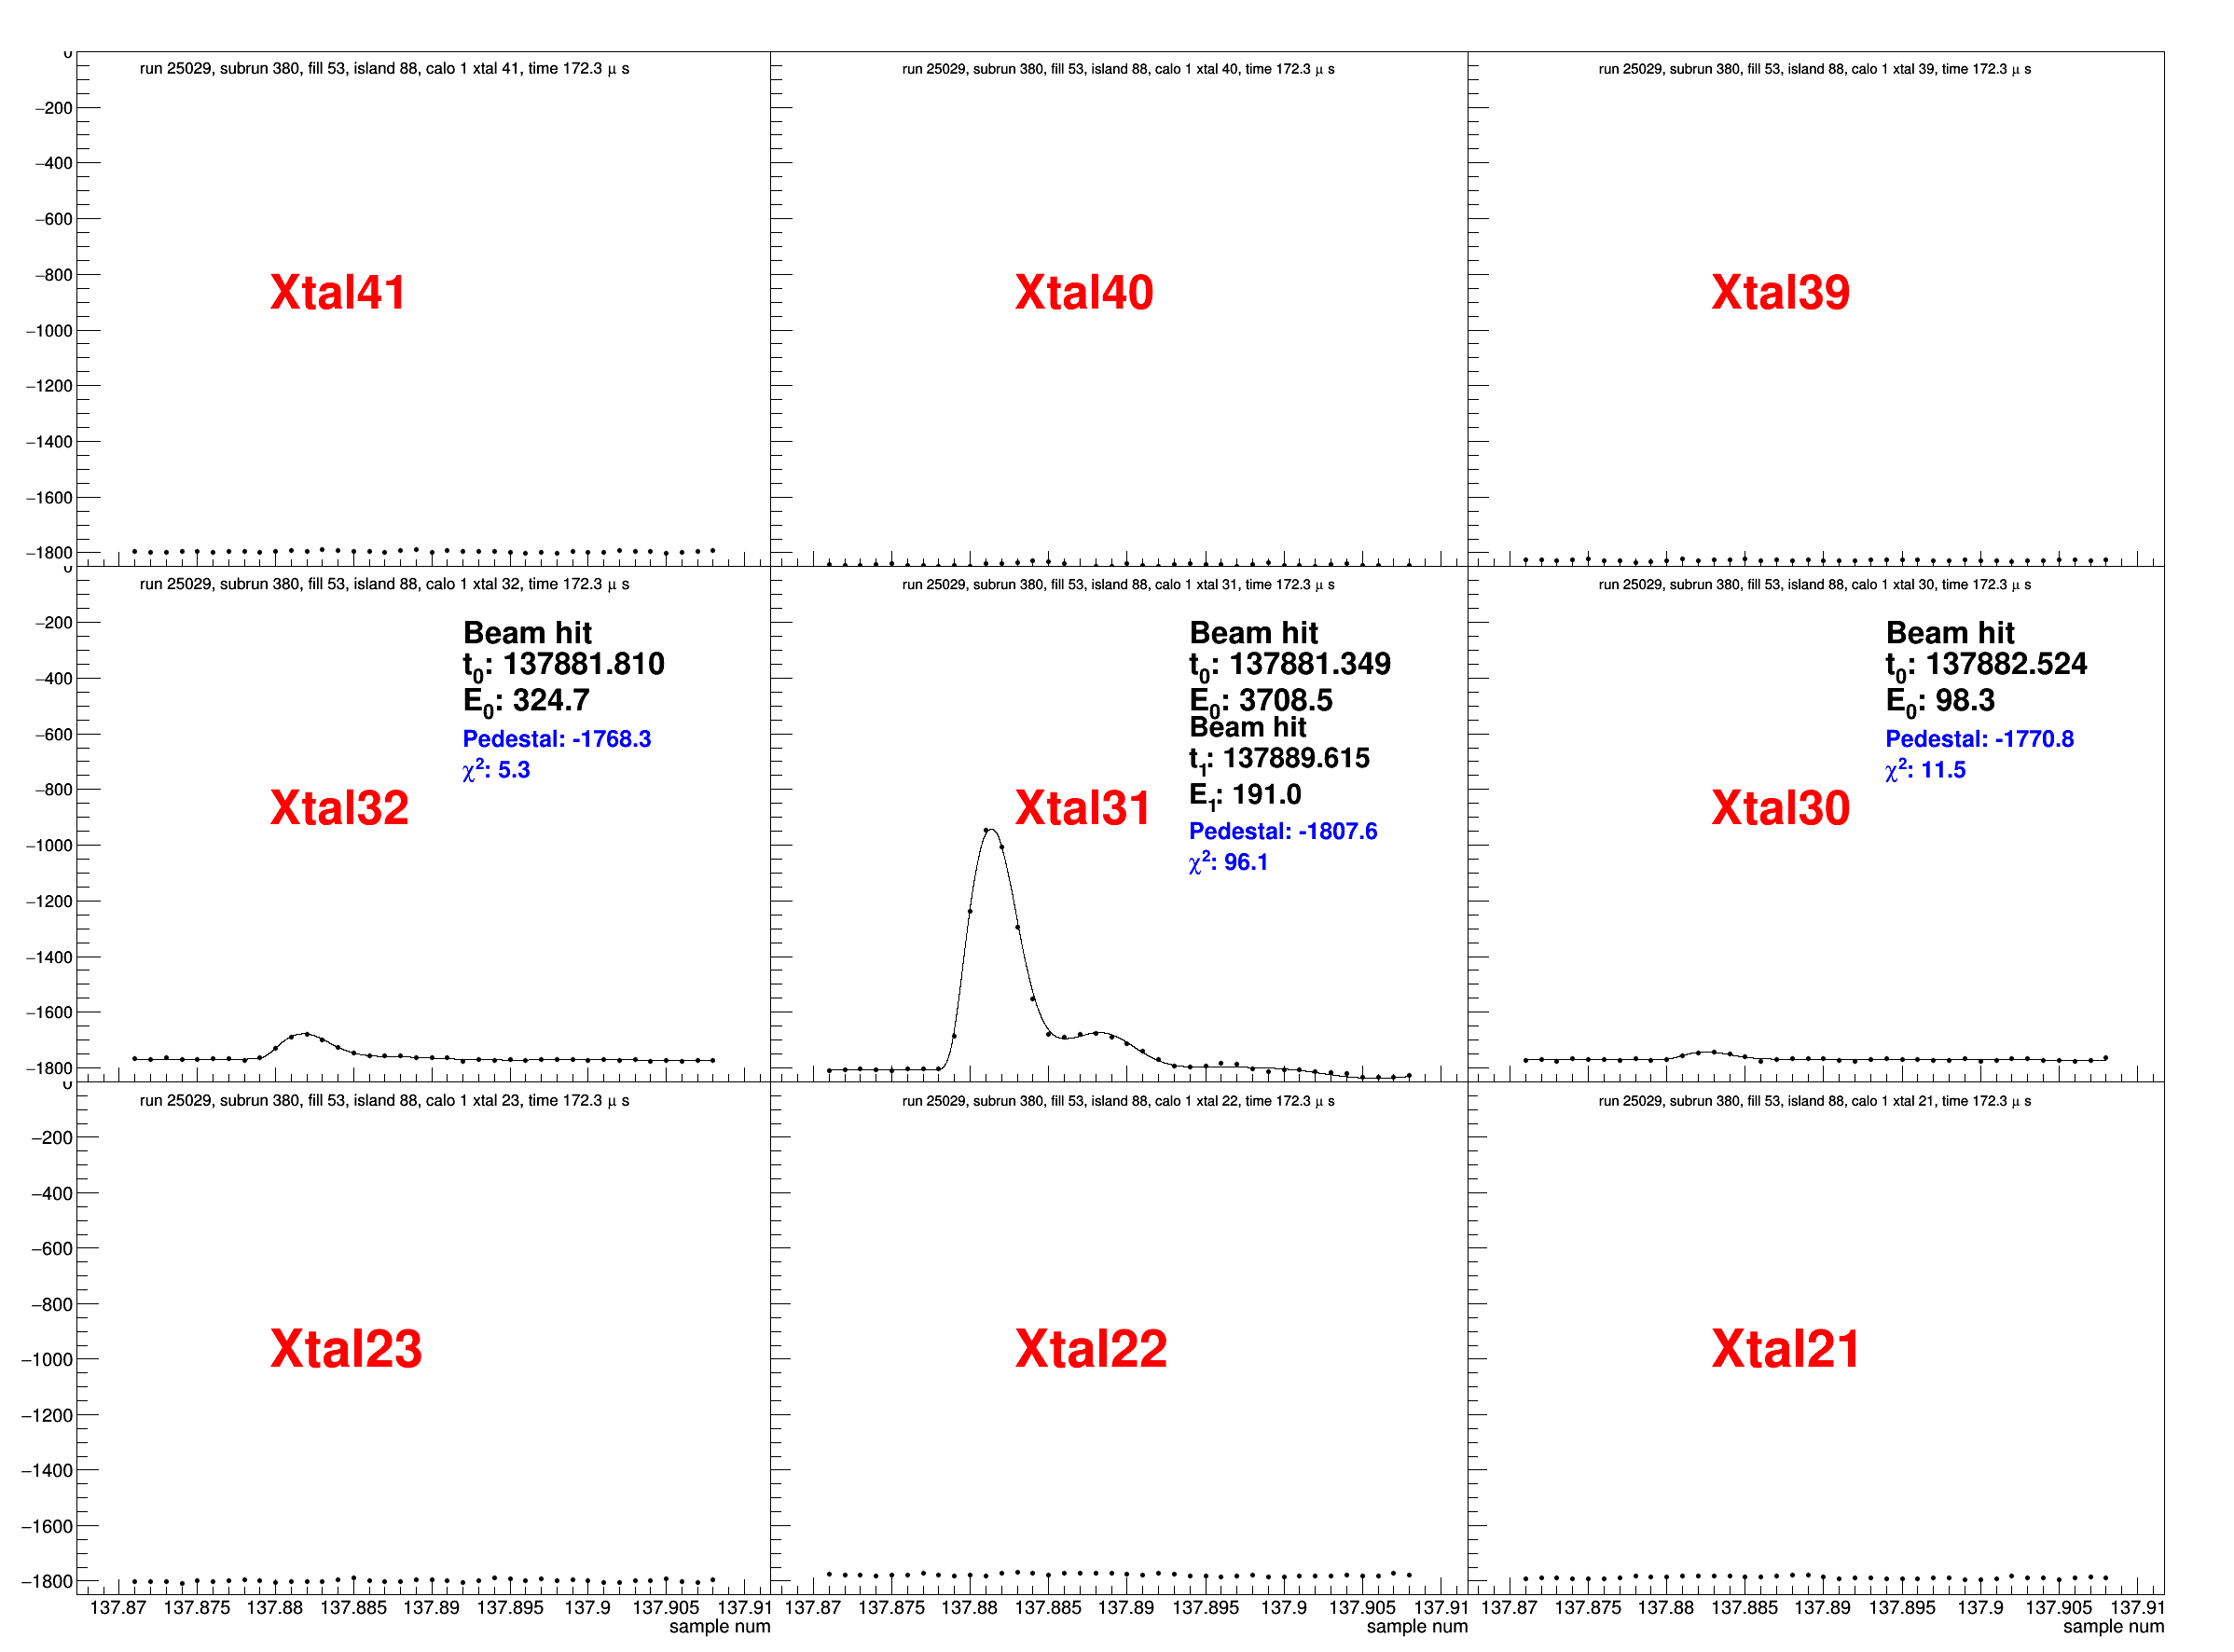

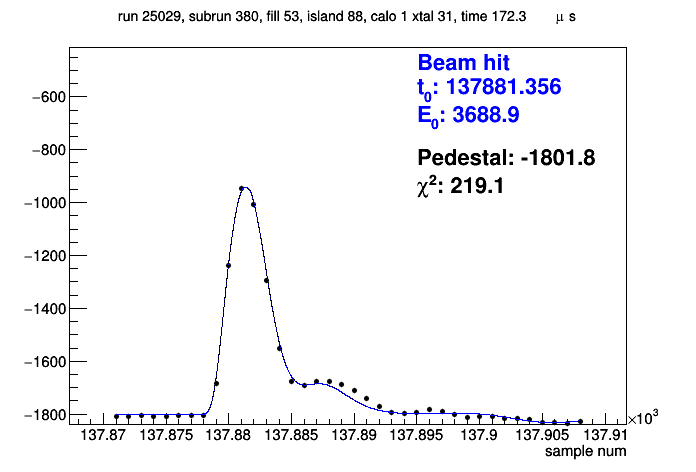

In [99]:
tag = trans_tag('1_31_53_88')
print(tag)
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
cs2 = viewer.draw_calo(*tag)
cs2[0].Draw()
cs3 = viewer_official.plot_xtal(*tag)
cs3[0].Draw()

[1, 33, 151, 65, True, None]
[['Beam hit', 't_{0}: 128655.286', 'E_{0}: 233.4'], ['Beam hit', 't_{1}: 128665.103', 'E_{1}: 124.1']] ['Pedestal: -1792.5', '#chi^{2}: 9.8']
0.6
[['Beam hit', 't_{0}: 128655.331', 'E_{0}: 217.9']] ['Pedestal: -1789.2', '#chi^{2}: 92.6']
0.6


Warning in <TCanvas::Constructor>: Deleting canvas with same name: calo1


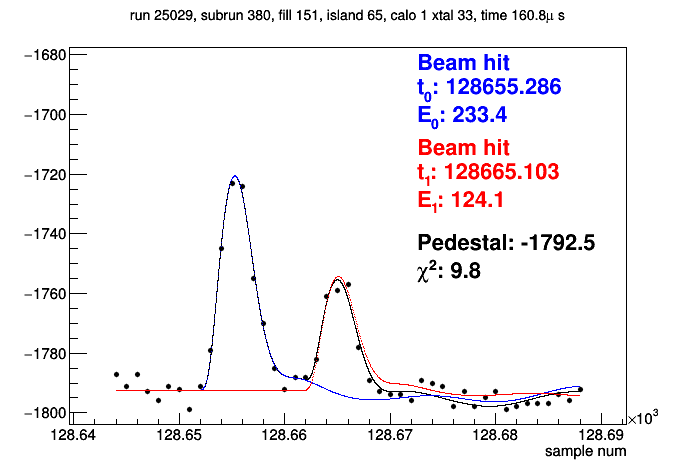

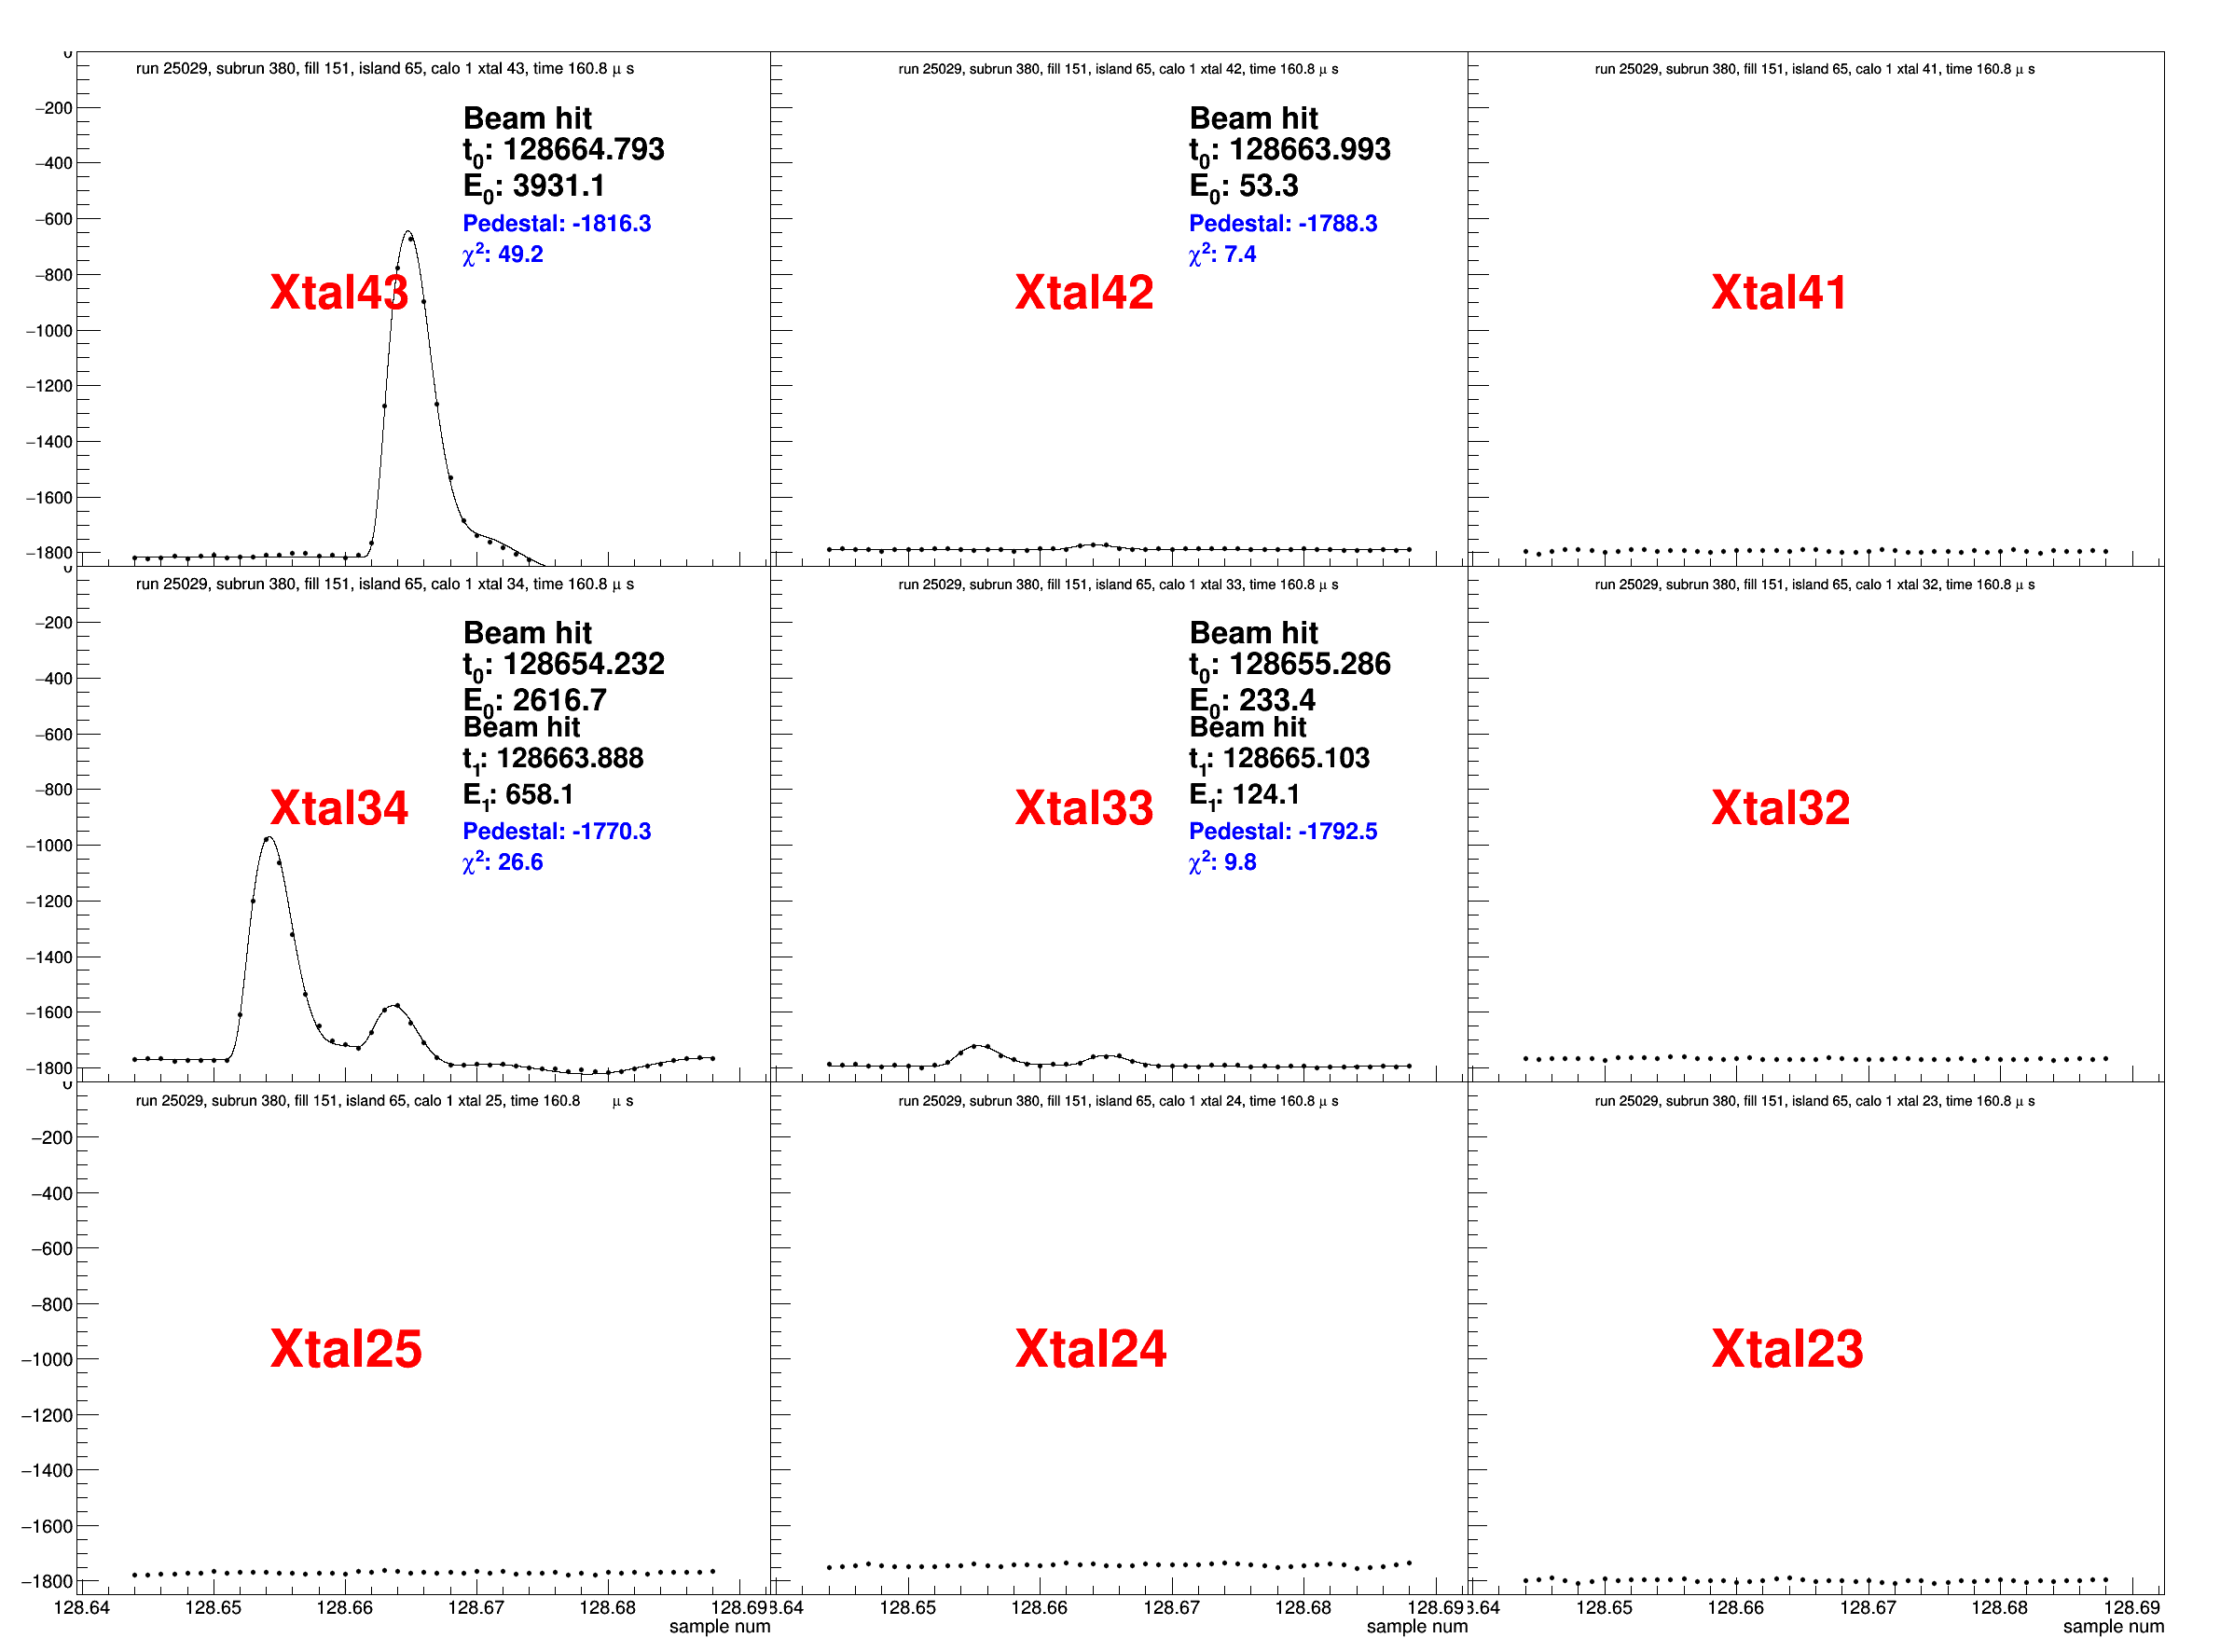

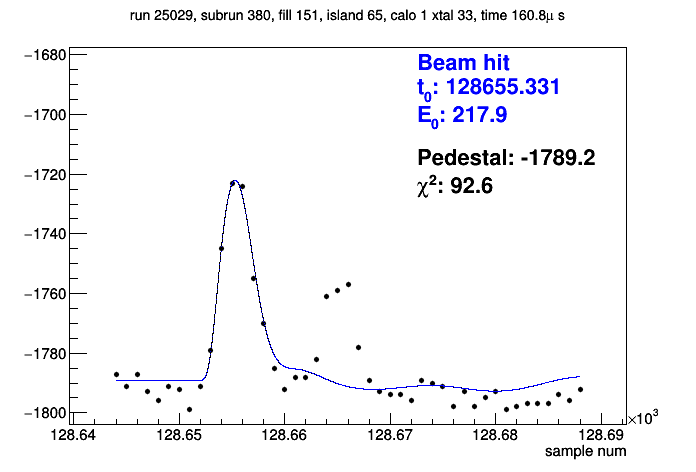

In [100]:
tag = trans_tag('1_33_151_65')
print(tag)
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
cs2 = viewer.draw_calo(*tag)
cs2[0].Draw()
cs3 = viewer_official.plot_xtal(*tag)
cs3[0].Draw()

[1, 0, 31, 68, True, None]
[['Beam hit', 't_{0}: 110775.624', 'E_{0}: 253.1'], ['Beam hit', 't_{1}: 110786.320', 'E_{1}: 66.8']] ['Pedestal: -1813.8', '#chi^{2}: 8.7']
0.6
[['Beam hit', 't_{0}: 110775.638', 'E_{0}: 243.5']] ['Pedestal: -1811.8', '#chi^{2}: 36.5']
0.6


Warning in <TCanvas::Constructor>: Deleting canvas with same name: calo1


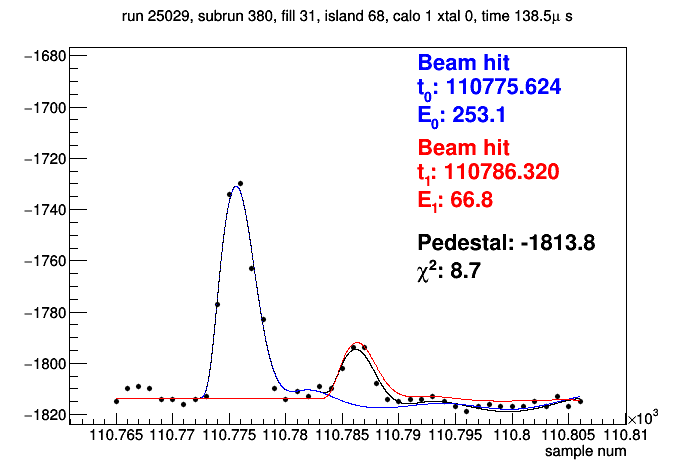

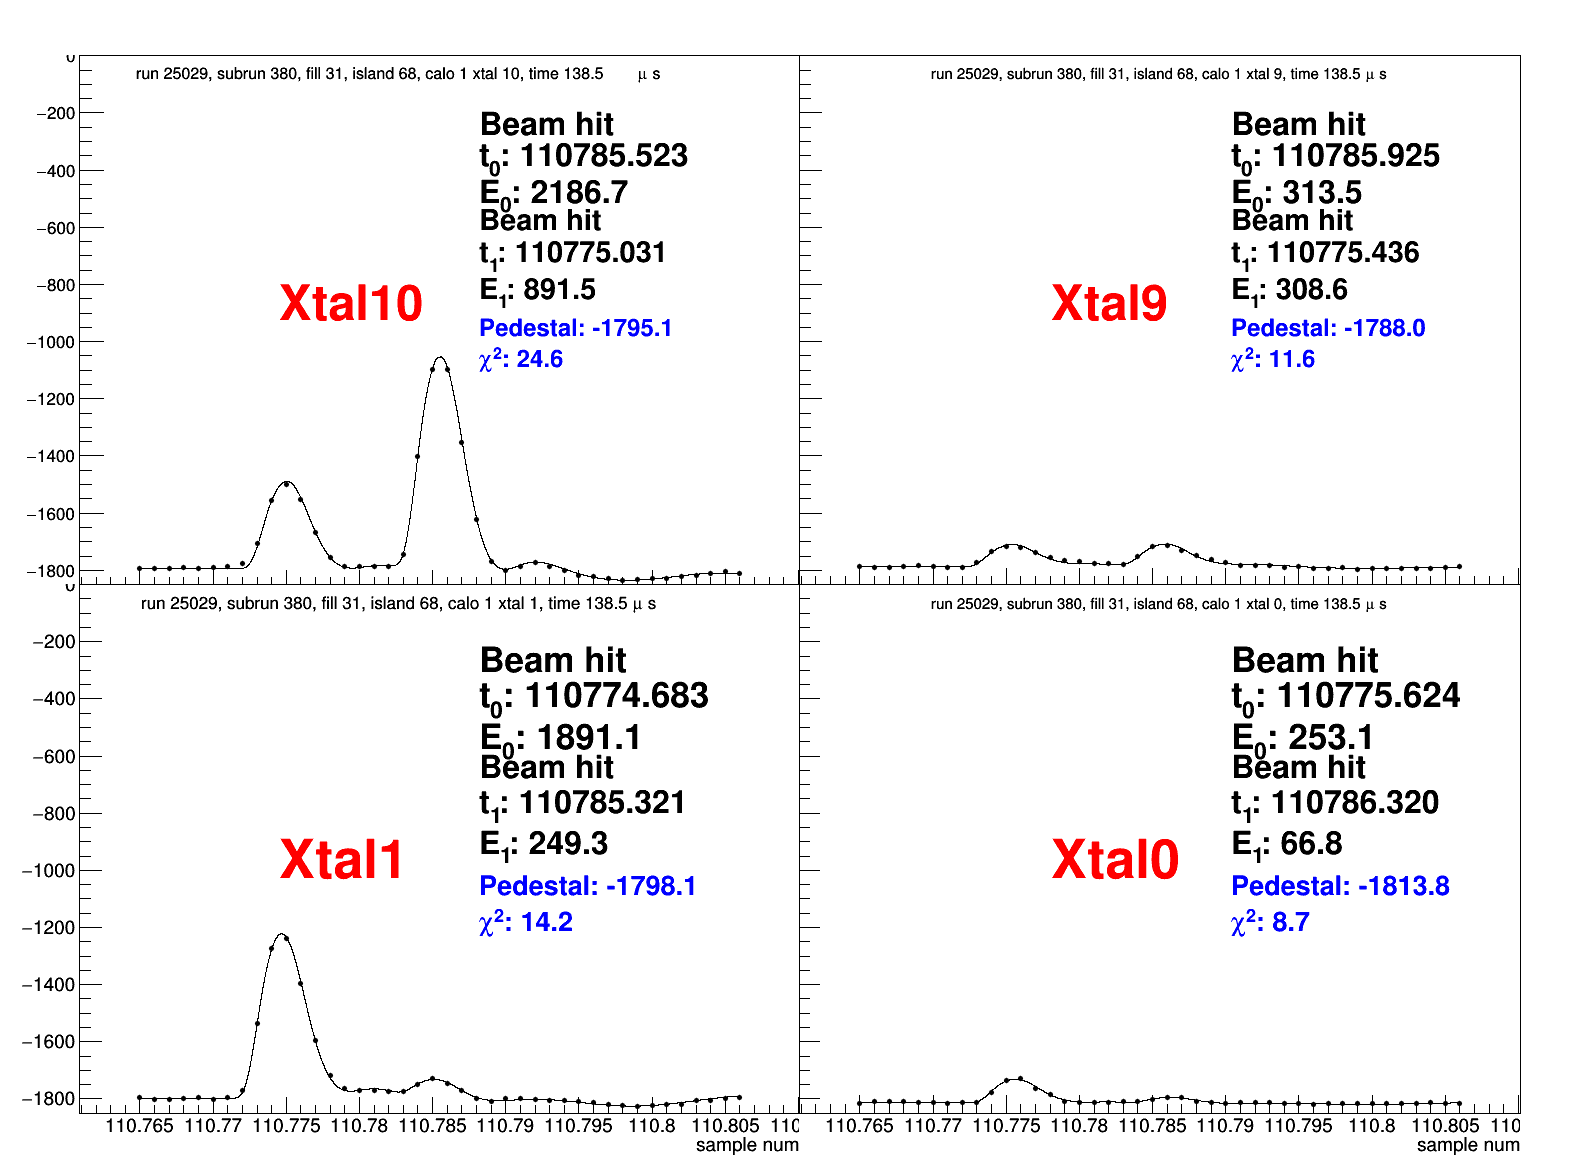

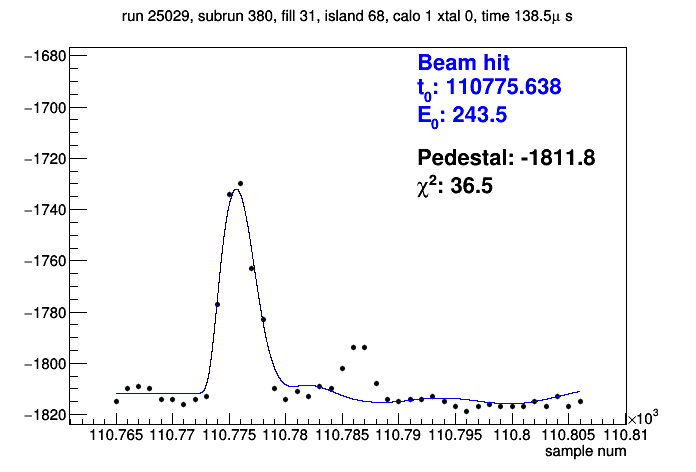

In [101]:
tag = trans_tag('1_0_31_68')
print(tag)
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
cs2 = viewer.draw_calo(*tag)
cs2[0].Draw()
cs3 = viewer_official.plot_xtal(*tag)
cs3[0].Draw()

[1, 26, 63, 159, True, None]
[['Beam hit', 't_{0}: 213525.299', 'E_{0}: 1210.2'], ['Beam hit', 't_{1}: 213535.966', 'E_{1}: 65.1']] ['Pedestal: -1768.6', '#chi^{2}: 169.0']
0.6
[['Beam hit', 't_{0}: 213525.302', 'E_{0}: 1194.2']] ['Pedestal: -1765.5', '#chi^{2}: 184.7']
0.6


Warning in <TCanvas::Constructor>: Deleting canvas with same name: calo1


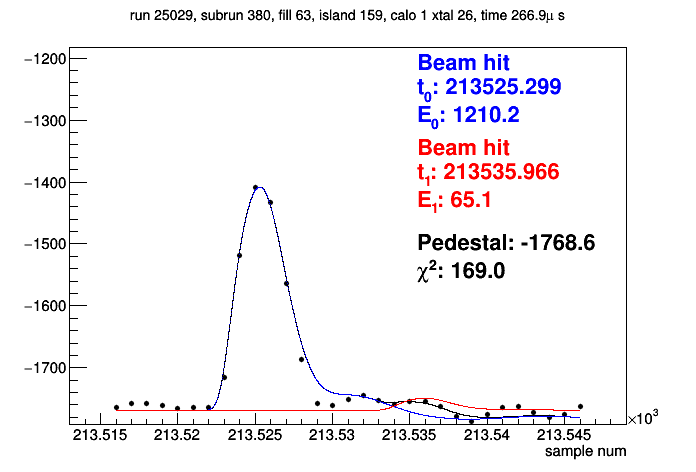

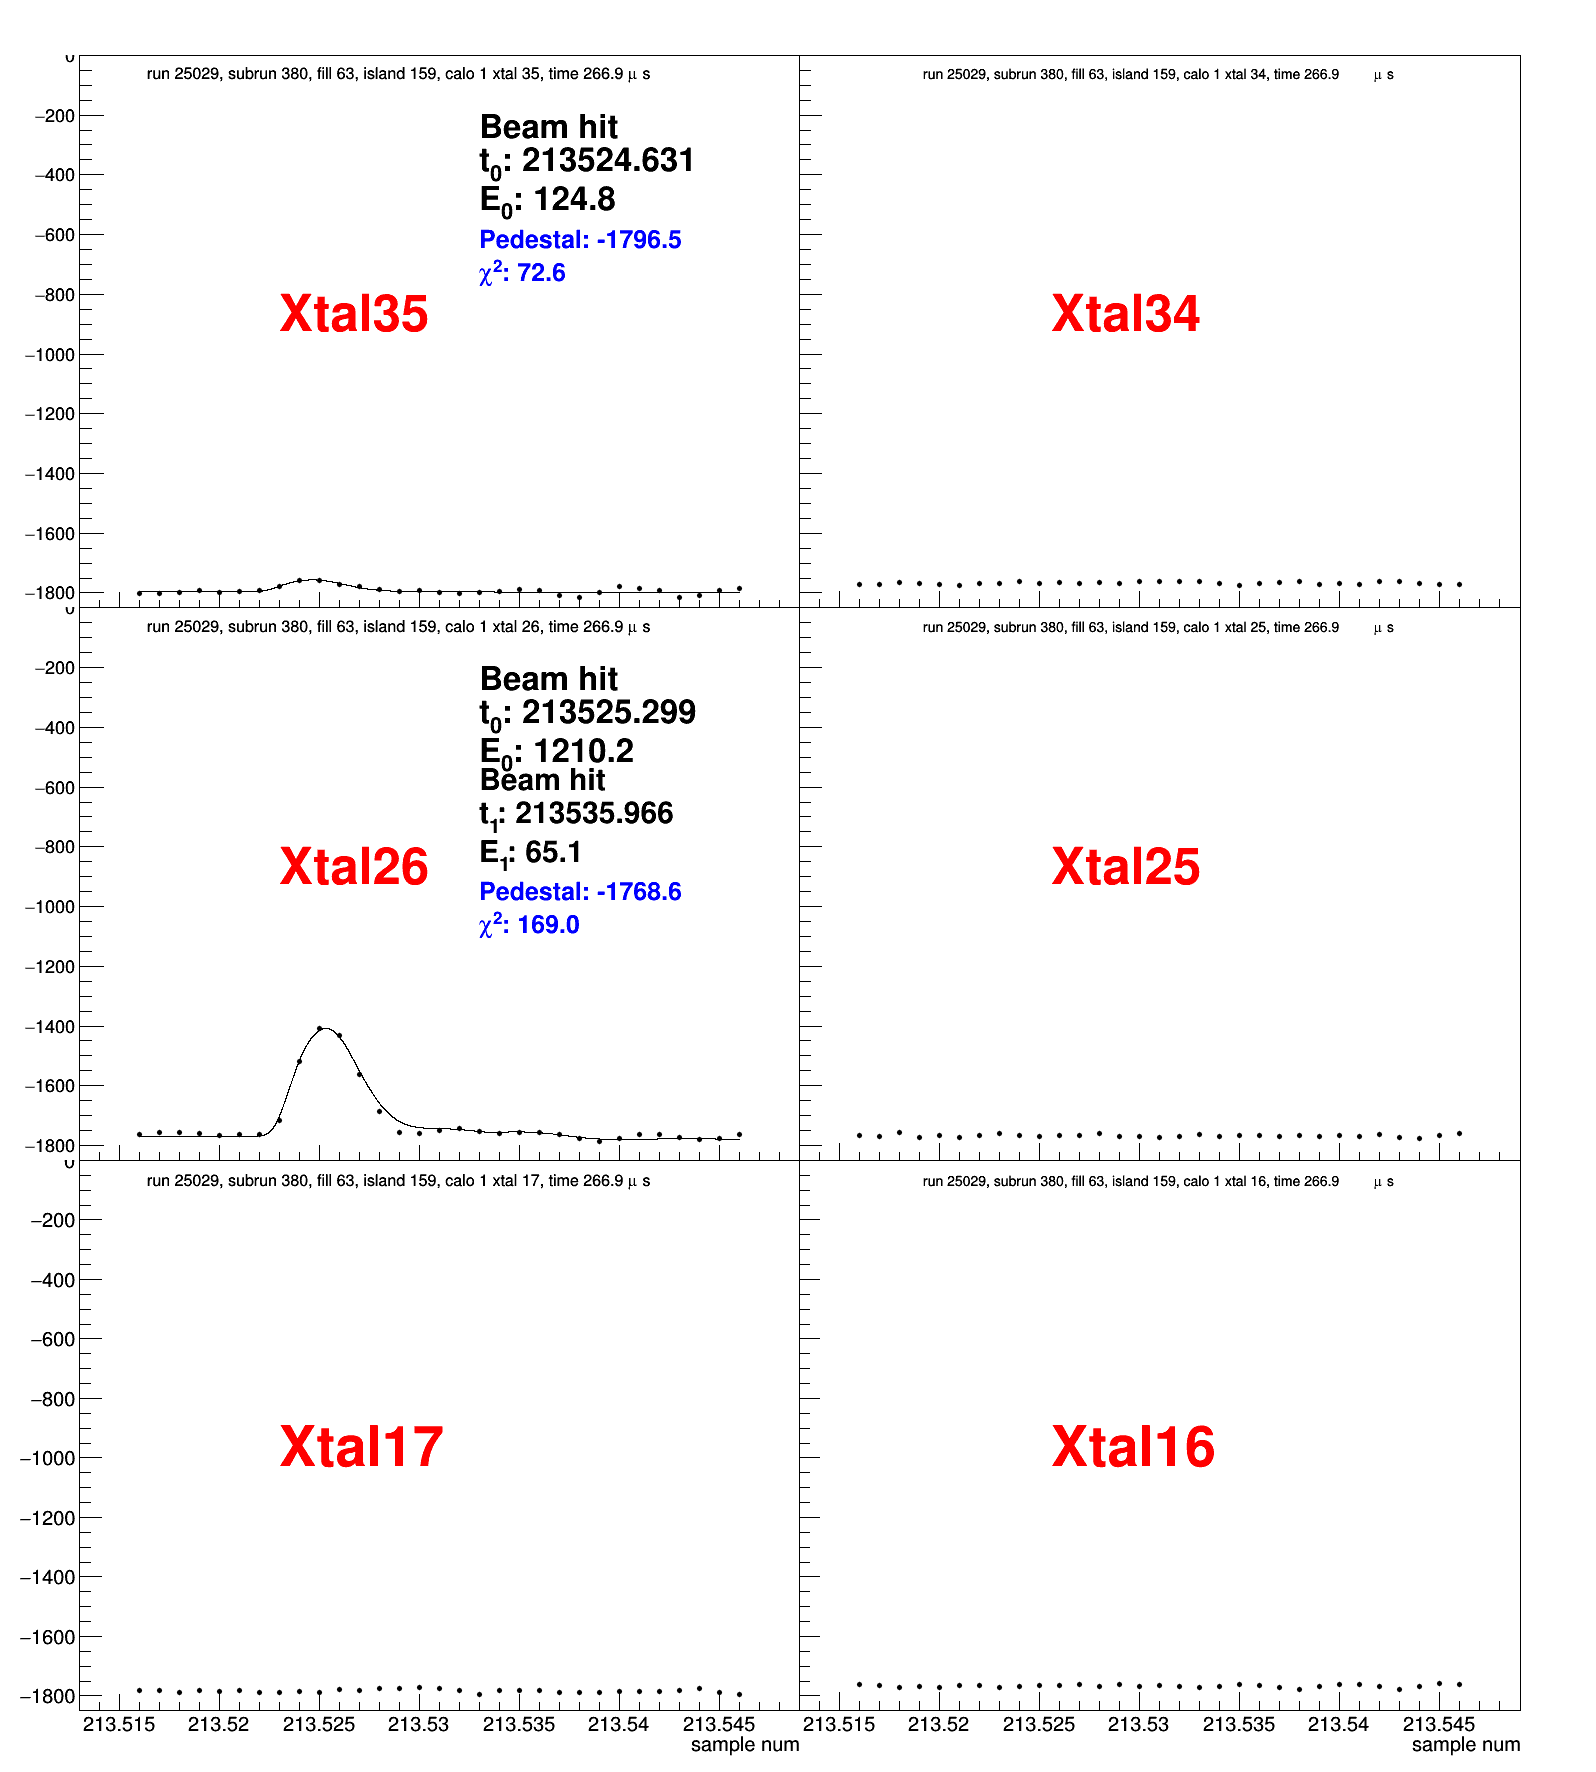

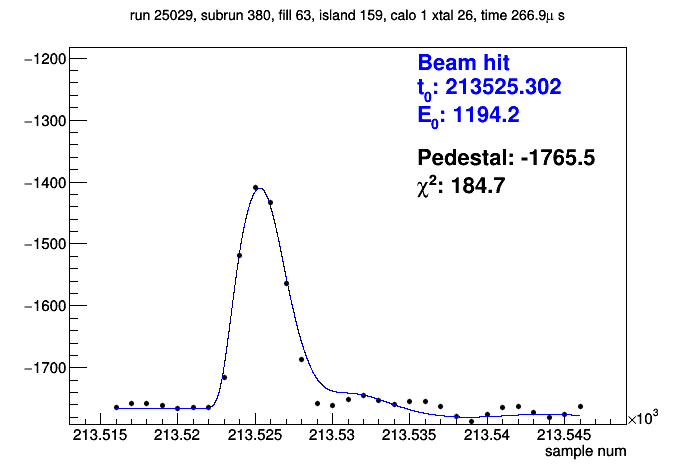

In [102]:
tag = trans_tag('1_26_63_159')
print(tag)
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
cs2 = viewer.draw_calo(*tag)
cs2[0].Draw()
cs3 = viewer_official.plot_xtal(*tag)
cs3[0].Draw()

In [27]:
# def getRisingEdge(hist):
#     previous = 1
#     # for n in range(20,40):
#     for n in range(hist.GetNbinsX()):
#         content = hist.GetBinContent(n+1)
#         diff = content - previous
#         # print (diff)
#         r = content/previous
#         # print (r)
#         if r>10 or diff>100:
#             return hist.GetBinCenter(n)
#         if content>0:
#             previous = content
#         else:
#             previous = 1
    

# edges = []
# for n in range(1296):
#     nc = n//54 + 1
#     nx = n%54
#     h = f.Get('inFillGainCorrector/hist_timewindow_StatusTrue_timeGT30_calo%s_xtal%s_energy'%(nc,nx))
#     # print (h)
#     try:
#         edge = getRisingEdge(h)
#     except:
#         print (nc,nx)
#         continue
#     edges.append(edge)


[1, 9, 19, 65, True, None]
[['Beam hit', 't_{0}: 118186.594', 'E_{0}: 1041.6'], ['Beam hit', 't_{1}: 118205.931', 'E_{1}: 93.8']] ['Pedestal: -1787.3', '#chi^{2}: 17.7']
0.6
[['Beam hit', 't_{0}: 118186.597', 'E_{0}: 1025.6']] ['Pedestal: -1785.2', '#chi^{2}: 44.5']
0.6


Warning in <TCanvas::Constructor>: Deleting canvas with same name: calo1


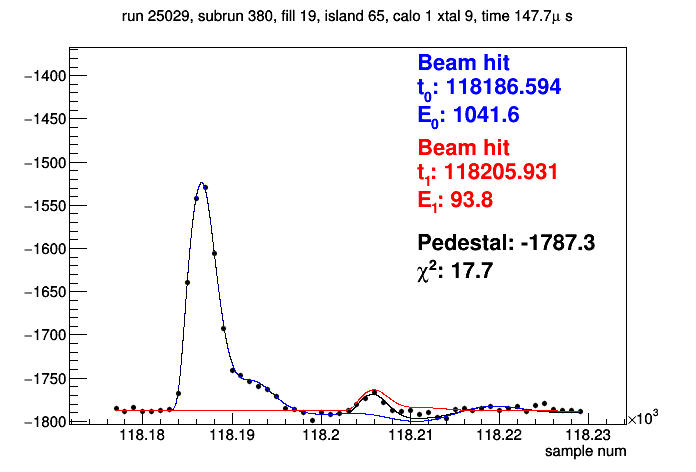

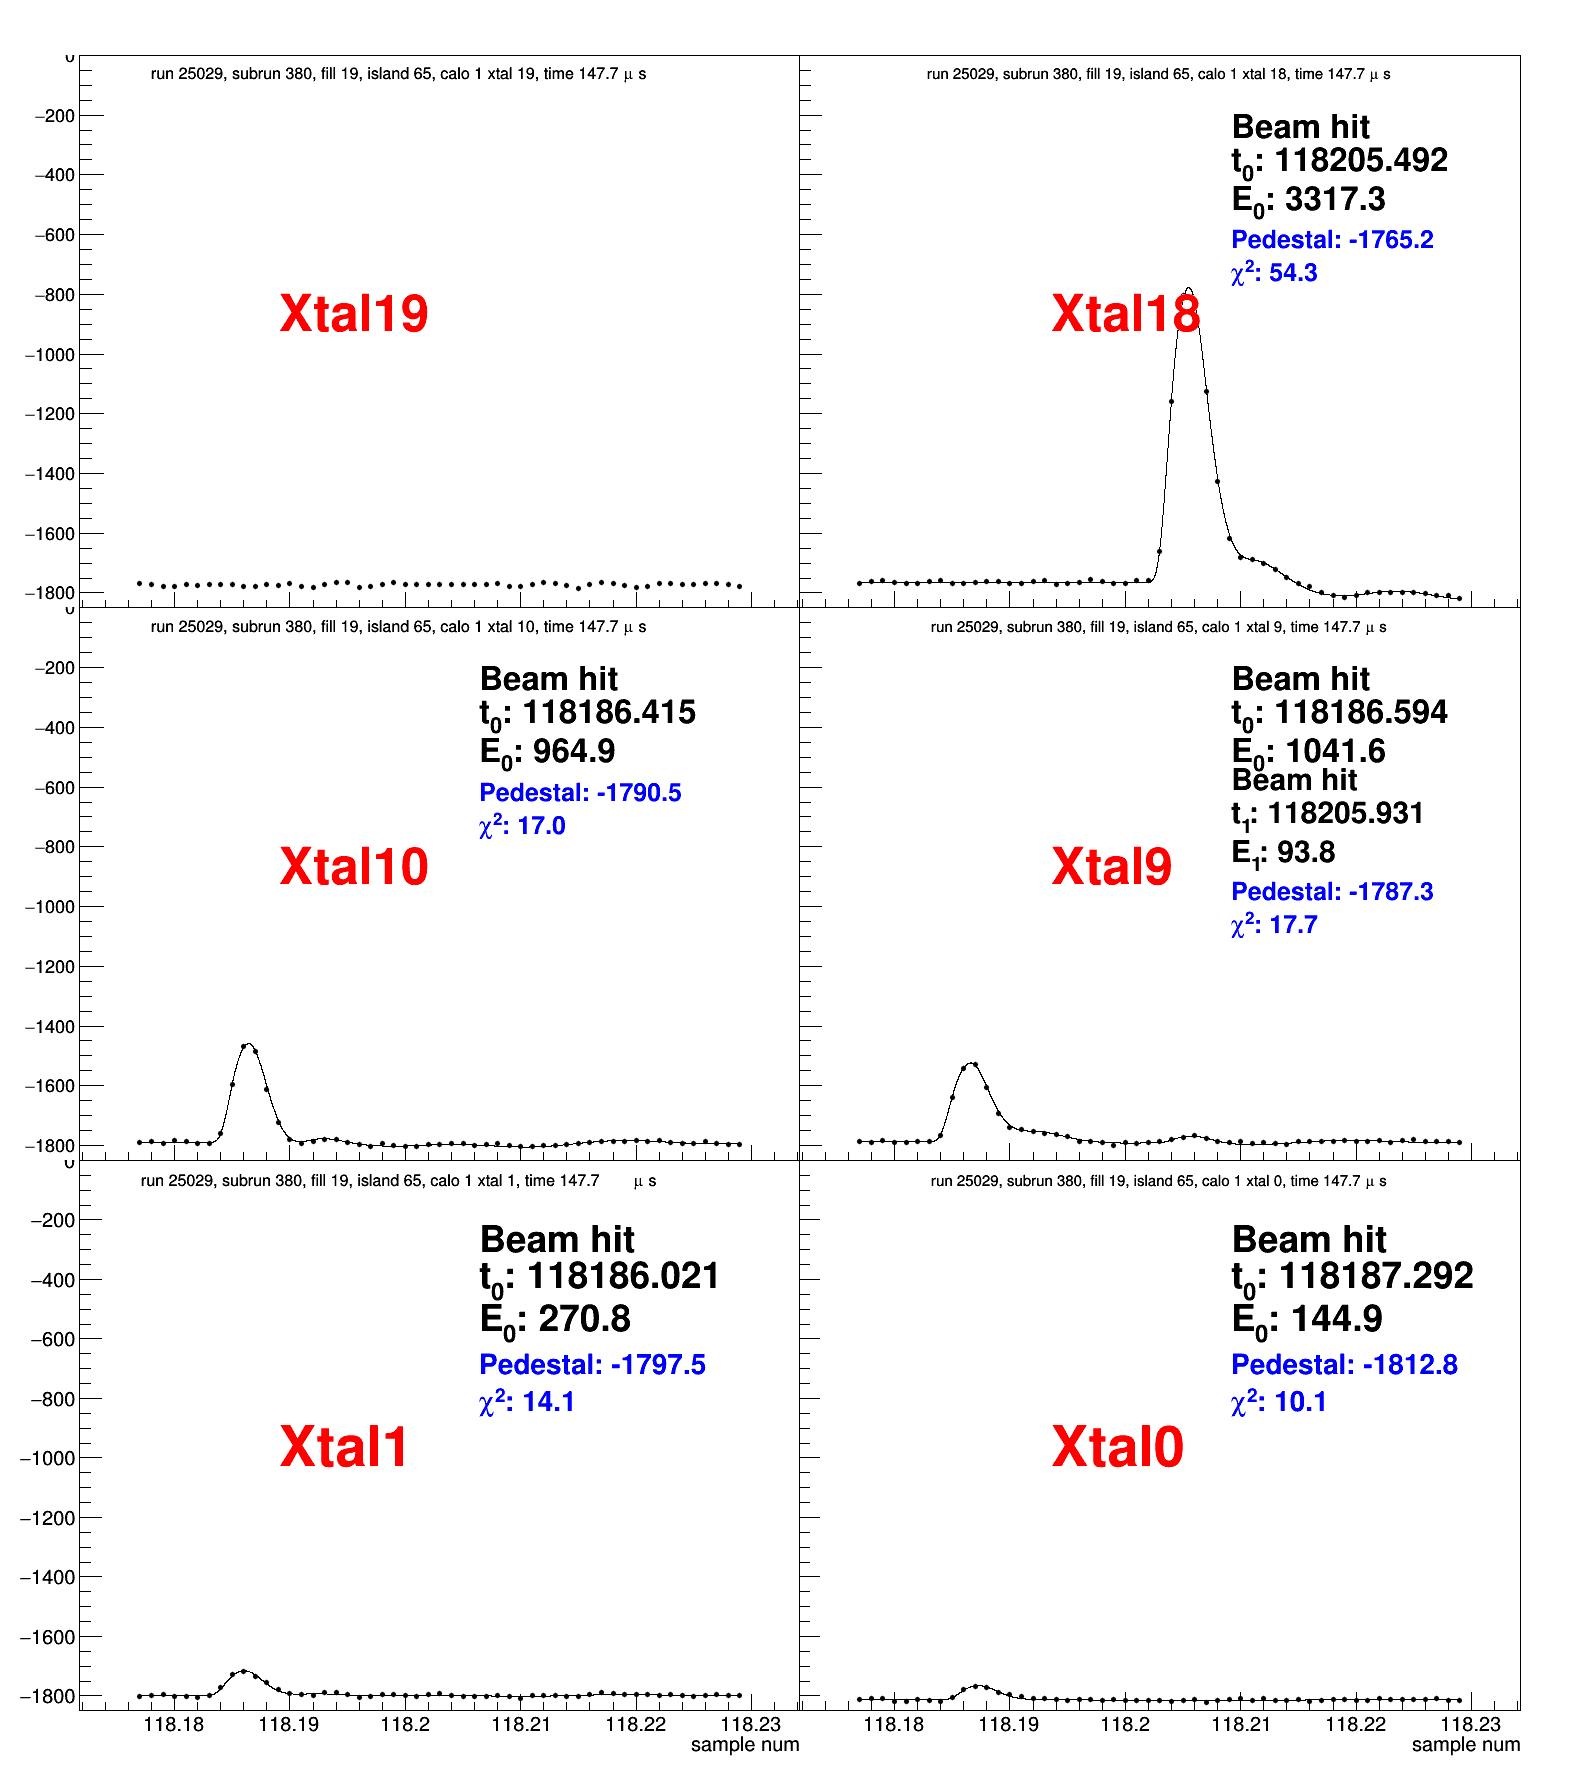

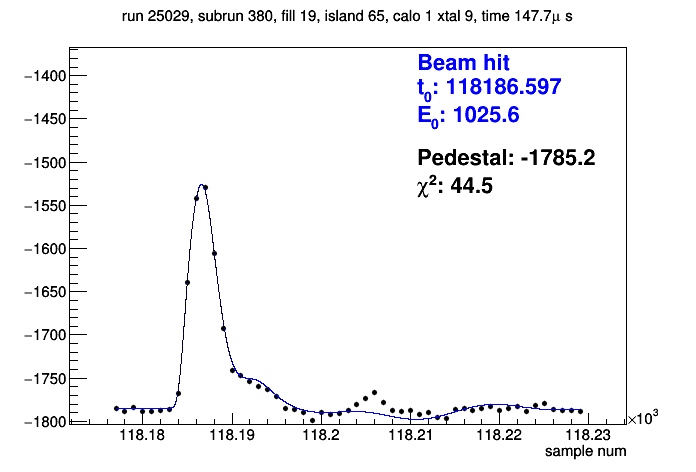

In [103]:
tag = trans_tag('1_9_19_65')
print(tag)
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
cs2 = viewer.draw_calo(*tag)
cs2[0].Draw()
cs3 = viewer_official.plot_xtal(*tag)
cs3[0].Draw()

[1, 1, 189, 129, True, None]
[['Beam hit', 't_{0}: 107231.461', 'E_{0}: 997.2'], ['Beam hit', 't_{1}: 107262.866', 'E_{1}: 146.4']] ['Pedestal: -1800.0', '#chi^{2}: 8.6']
0.6
[['Beam hit', 't_{0}: 107231.458', 'E_{0}: 993.8']] ['Pedestal: -1798.4', '#chi^{2}: 61.1']
0.6


Warning in <TCanvas::Constructor>: Deleting canvas with same name: calo1


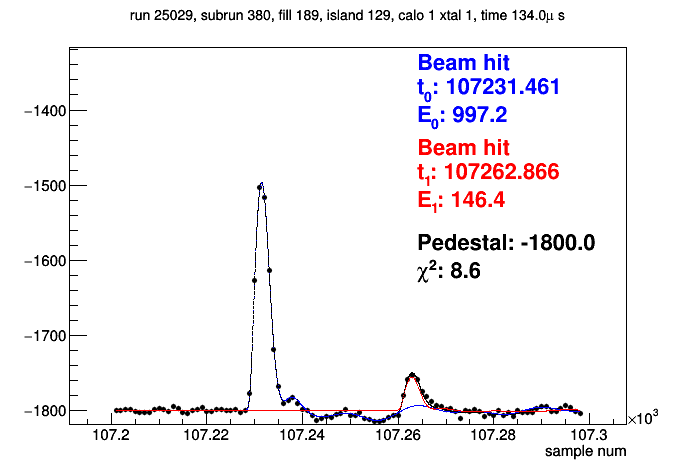

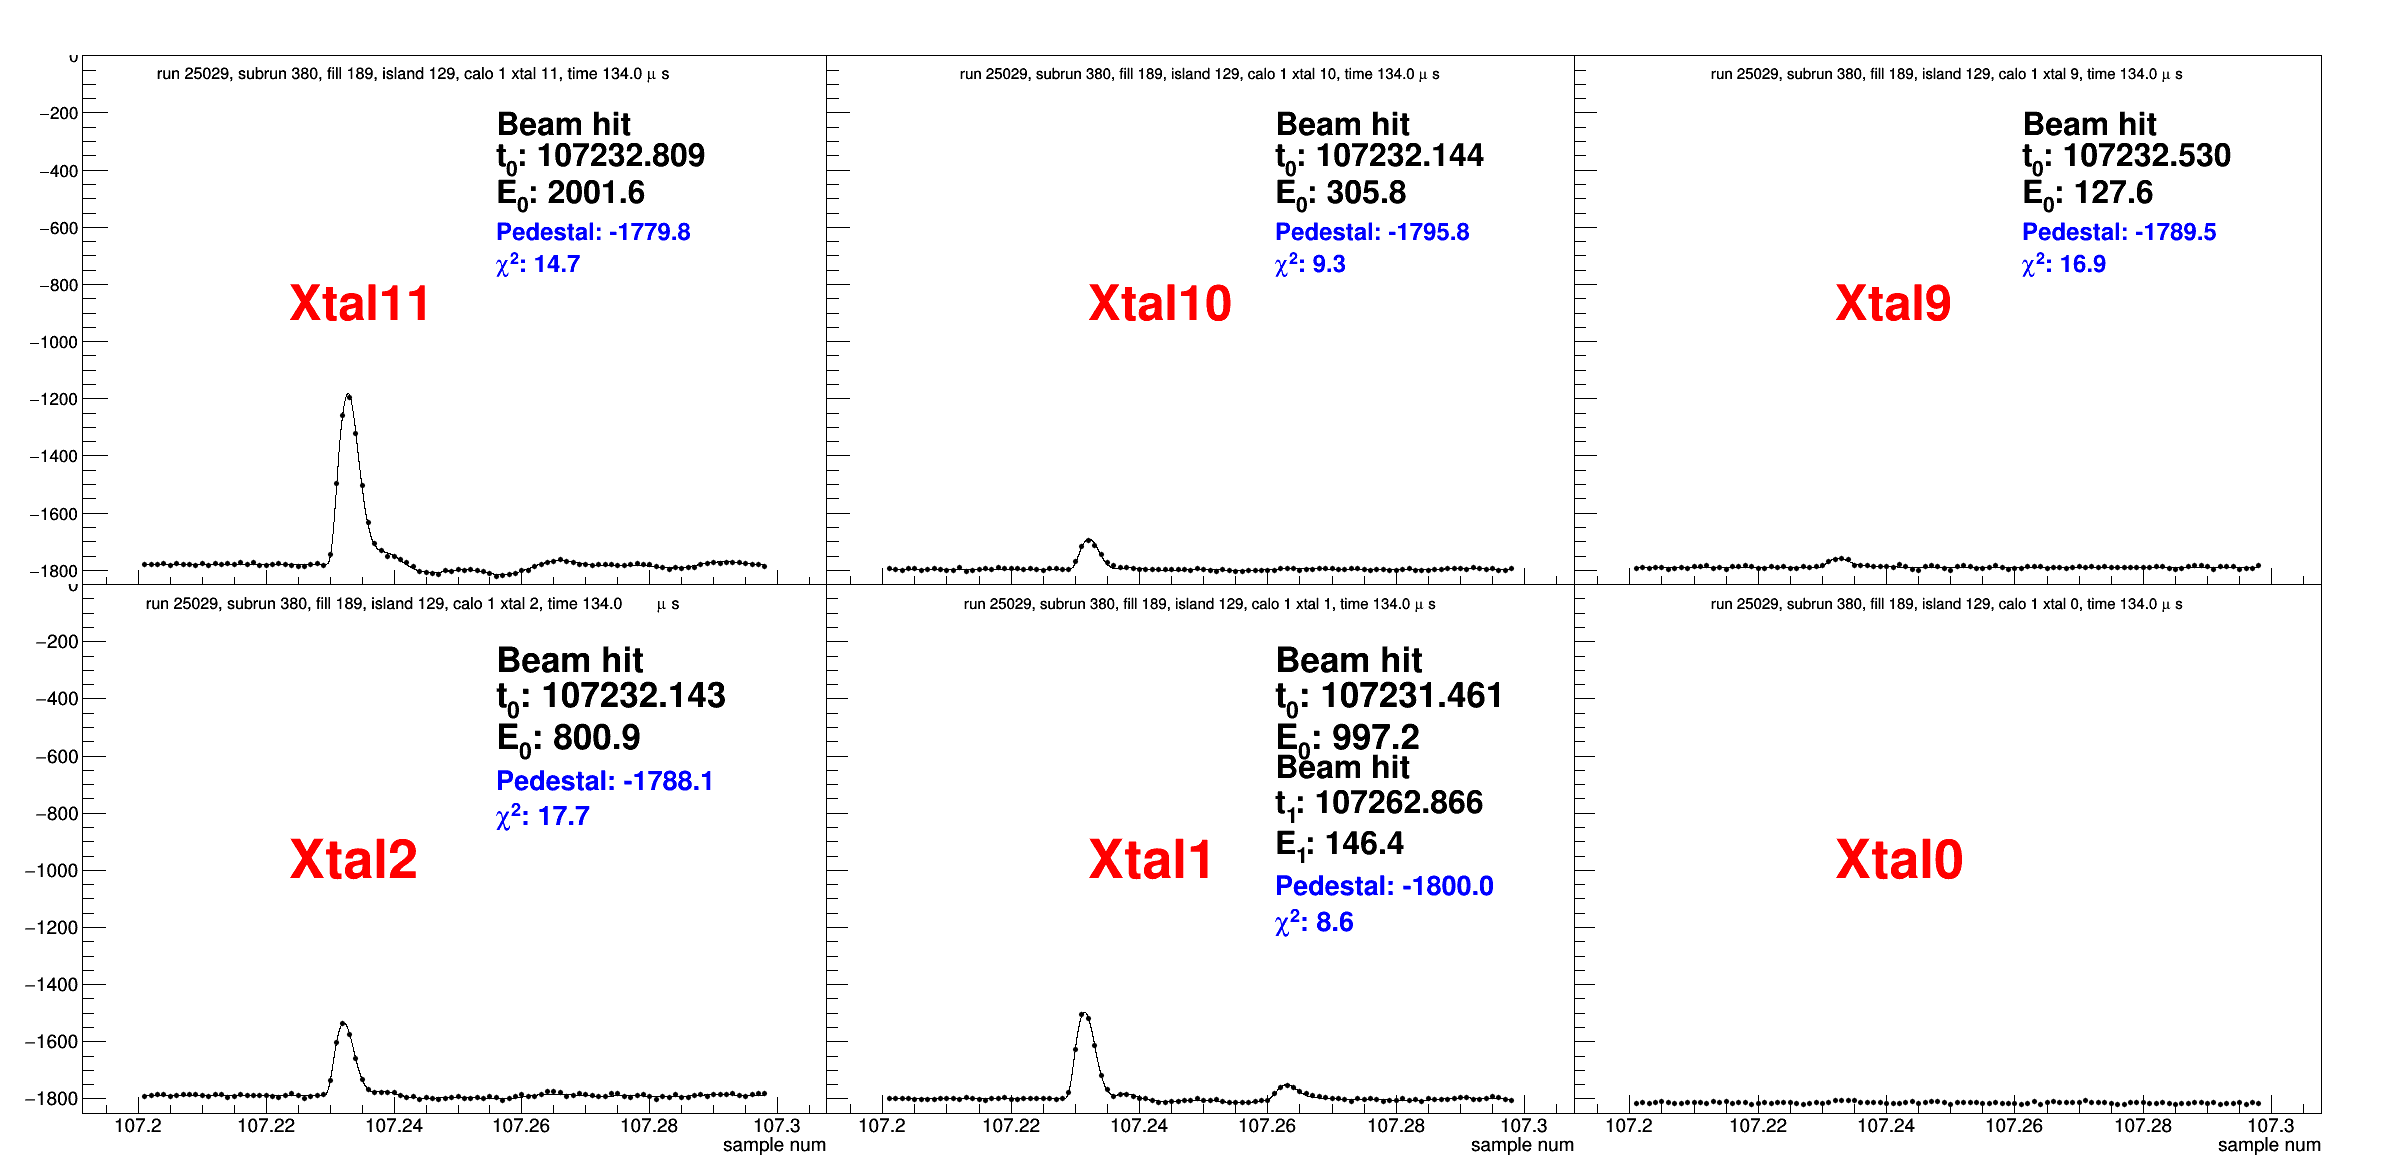

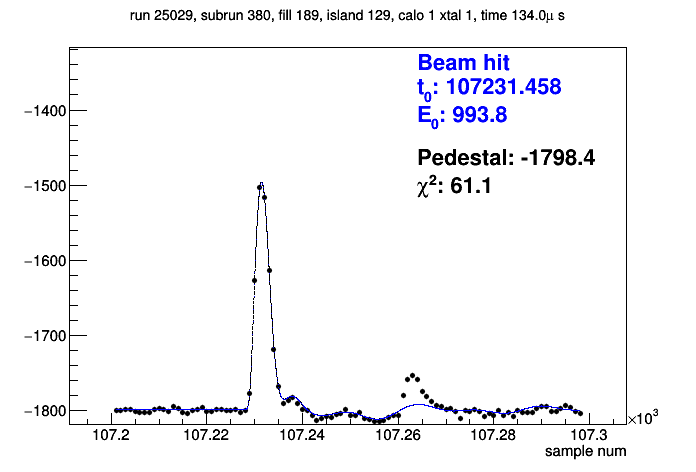

In [104]:
tag = trans_tag('1_1_189_129')
print(tag)
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
cs2 = viewer.draw_calo(*tag)
cs2[0].Draw()
cs3 = viewer_official.plot_xtal(*tag)
cs3[0].Draw()

[1, 14, 87, 109, True, None]
[['Beam hit', 't_{0}: 110545.634', 'E_{0}: 144.3'], ['Beam hit', 't_{1}: 110586.371', 'E_{1}: 95.3']] ['Pedestal: -1786.2', '#chi^{2}: 7.5']
0.6
[['Beam hit', 't_{0}: 110545.637', 'E_{0}: 137.6']] ['Pedestal: -1784.8', '#chi^{2}: 32.6']
0.6


Warning in <TCanvas::Constructor>: Deleting canvas with same name: calo1


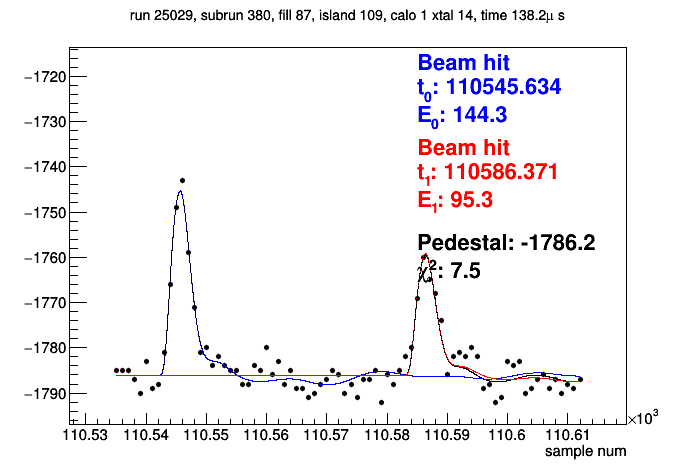

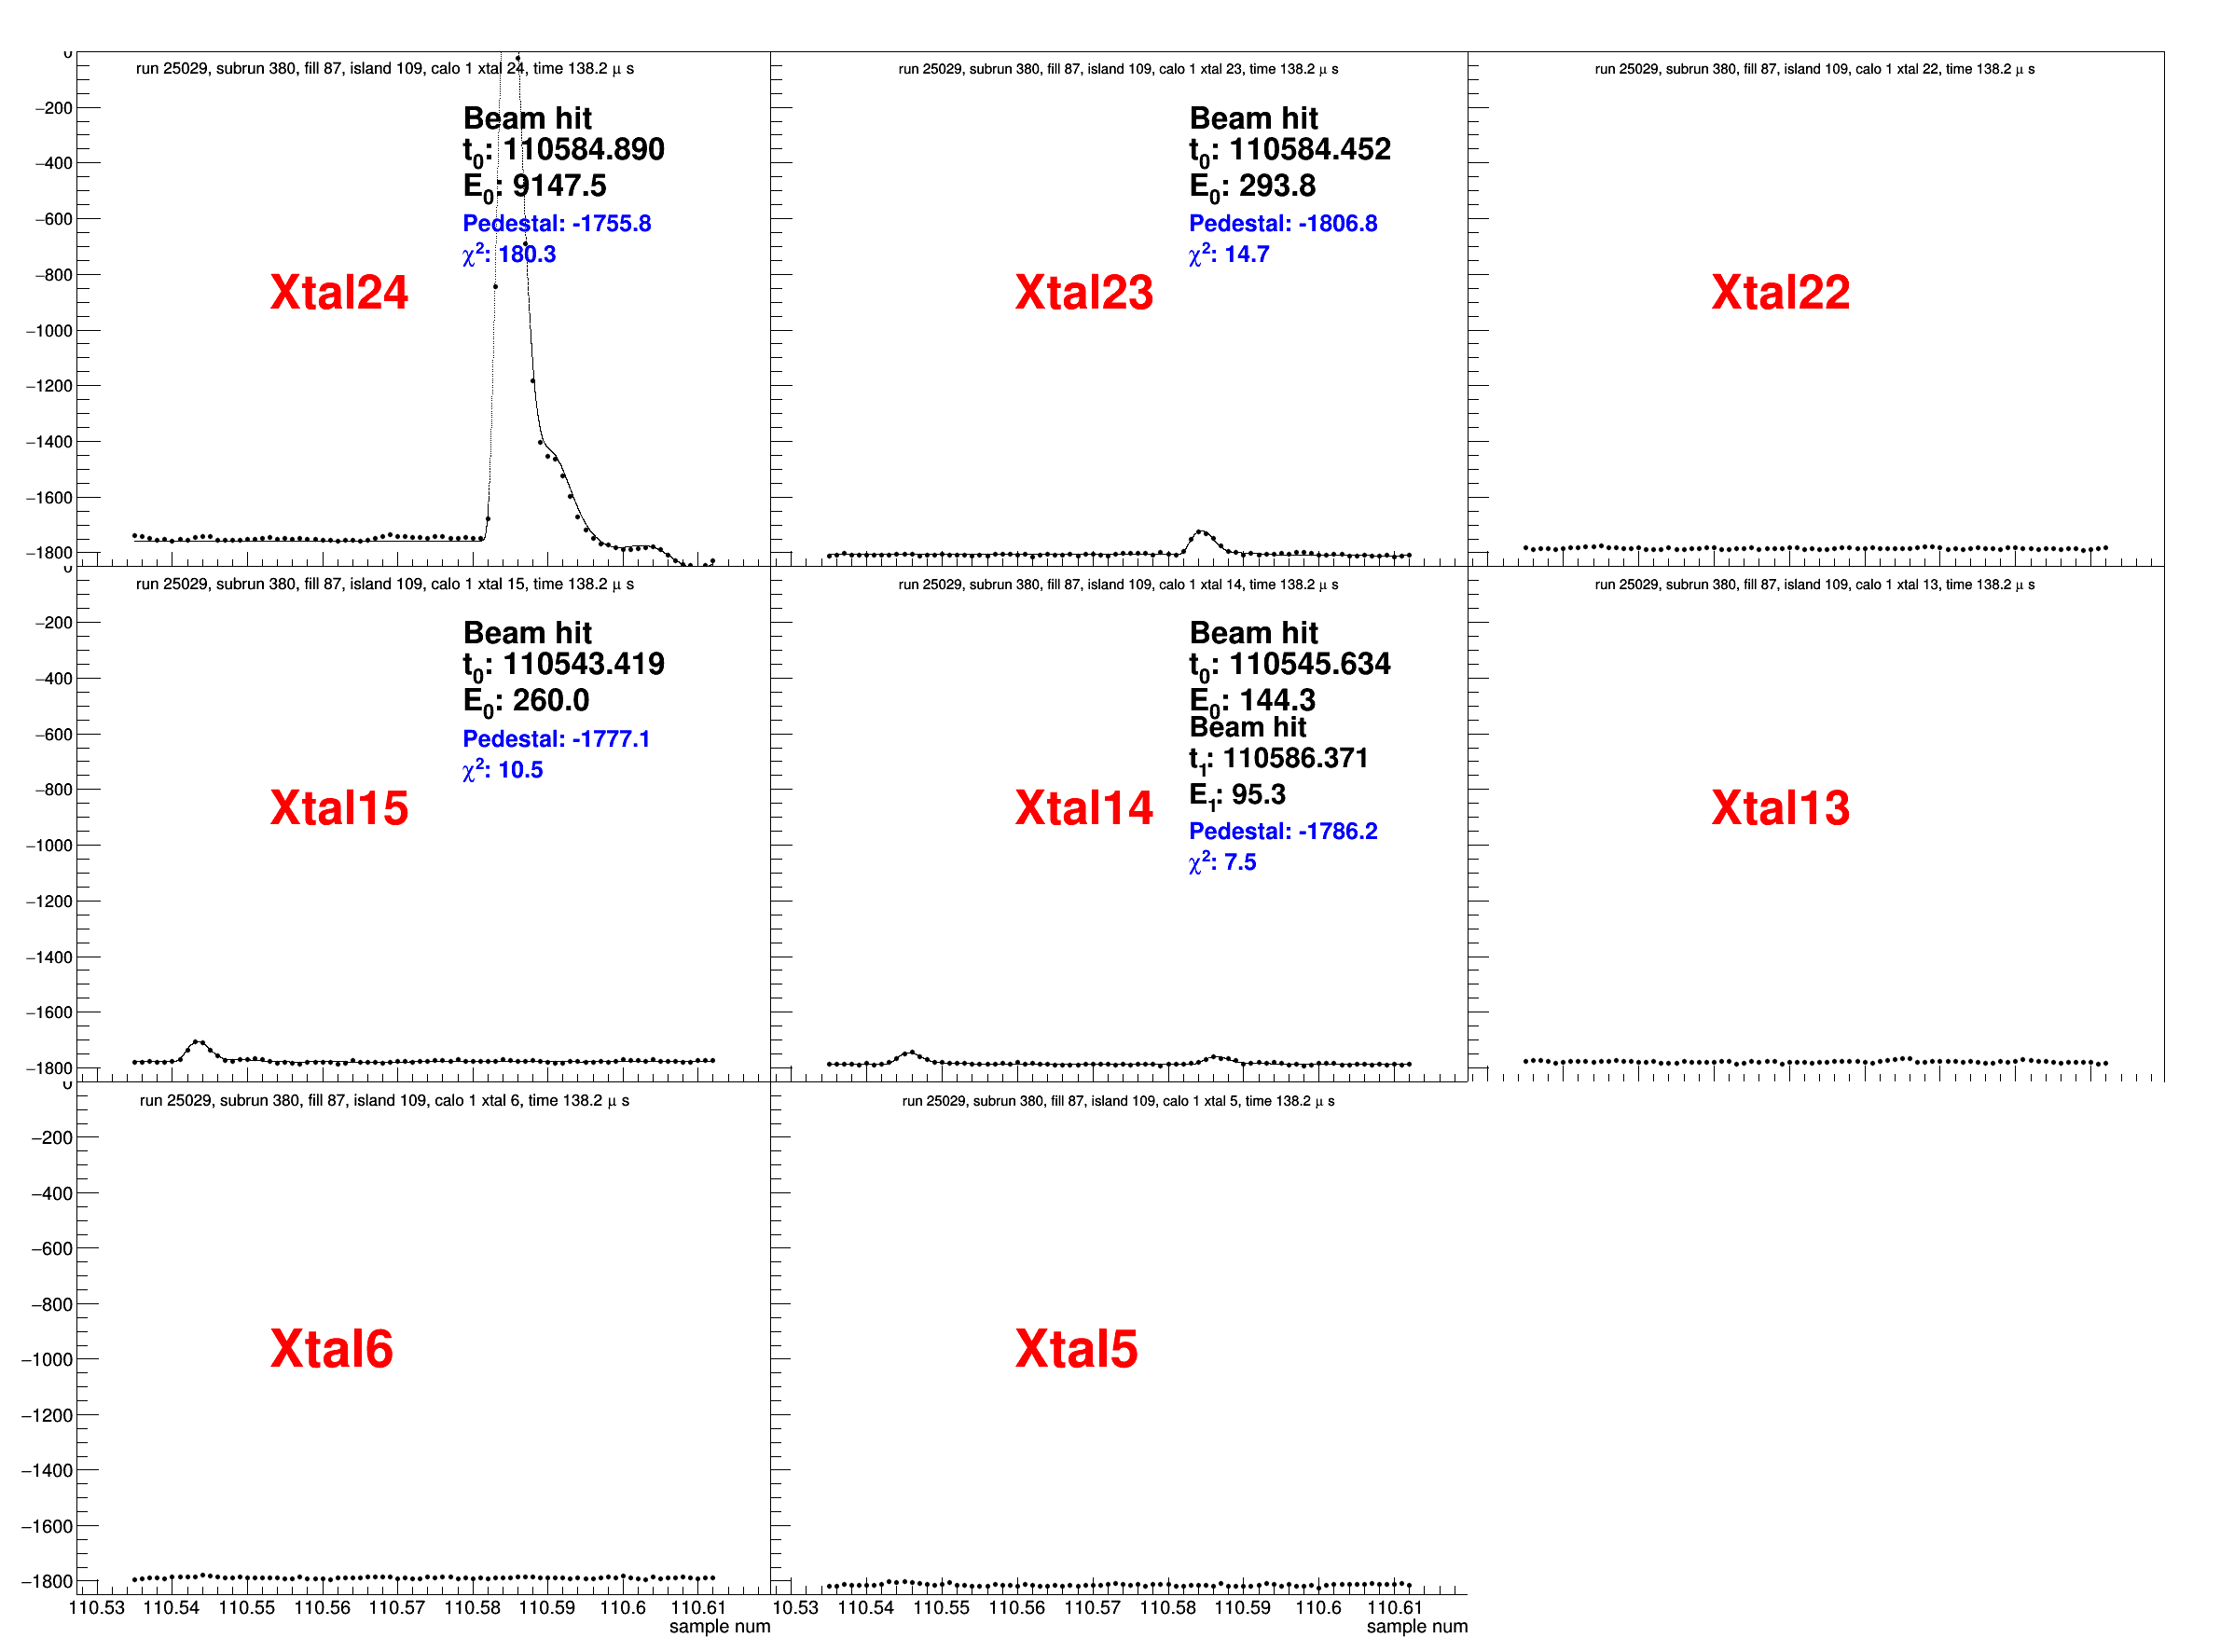

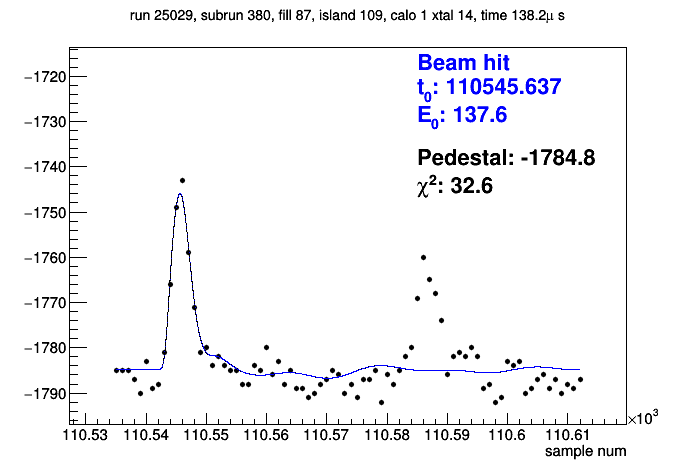

In [105]:
tag = trans_tag('1_14_87_109')
print(tag)
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
cs2 = viewer.draw_calo(*tag)
cs2[0].Draw()
cs3 = viewer_official.plot_xtal(*tag)
cs3[0].Draw()

[1, 35, 149, 135, True, None]
[['Beam hit', 't_{0}: 223208.252', 'E_{0}: 1306.5'], ['Beam hit', 't_{1}: 223228.908', 'E_{1}: 61.6']] ['Pedestal: -1798.8', '#chi^{2}: 169.0']
0.6
[['Beam hit', 't_{0}: 223208.253', 'E_{0}: 1298.7']] ['Pedestal: -1797.2', '#chi^{2}: 179.1']
0.6


Warning in <TCanvas::Constructor>: Deleting canvas with same name: calo1


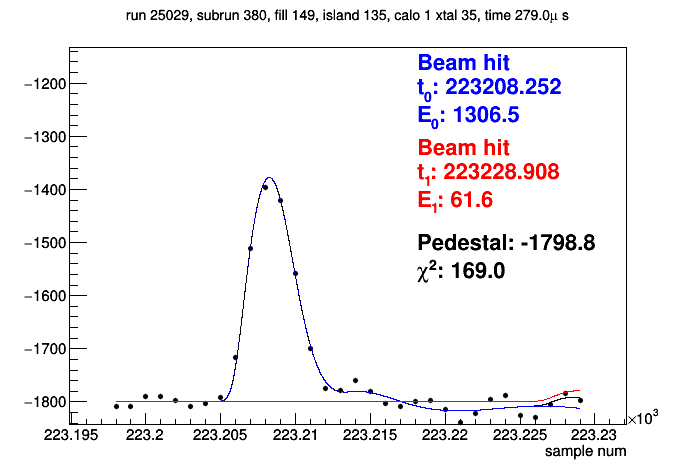

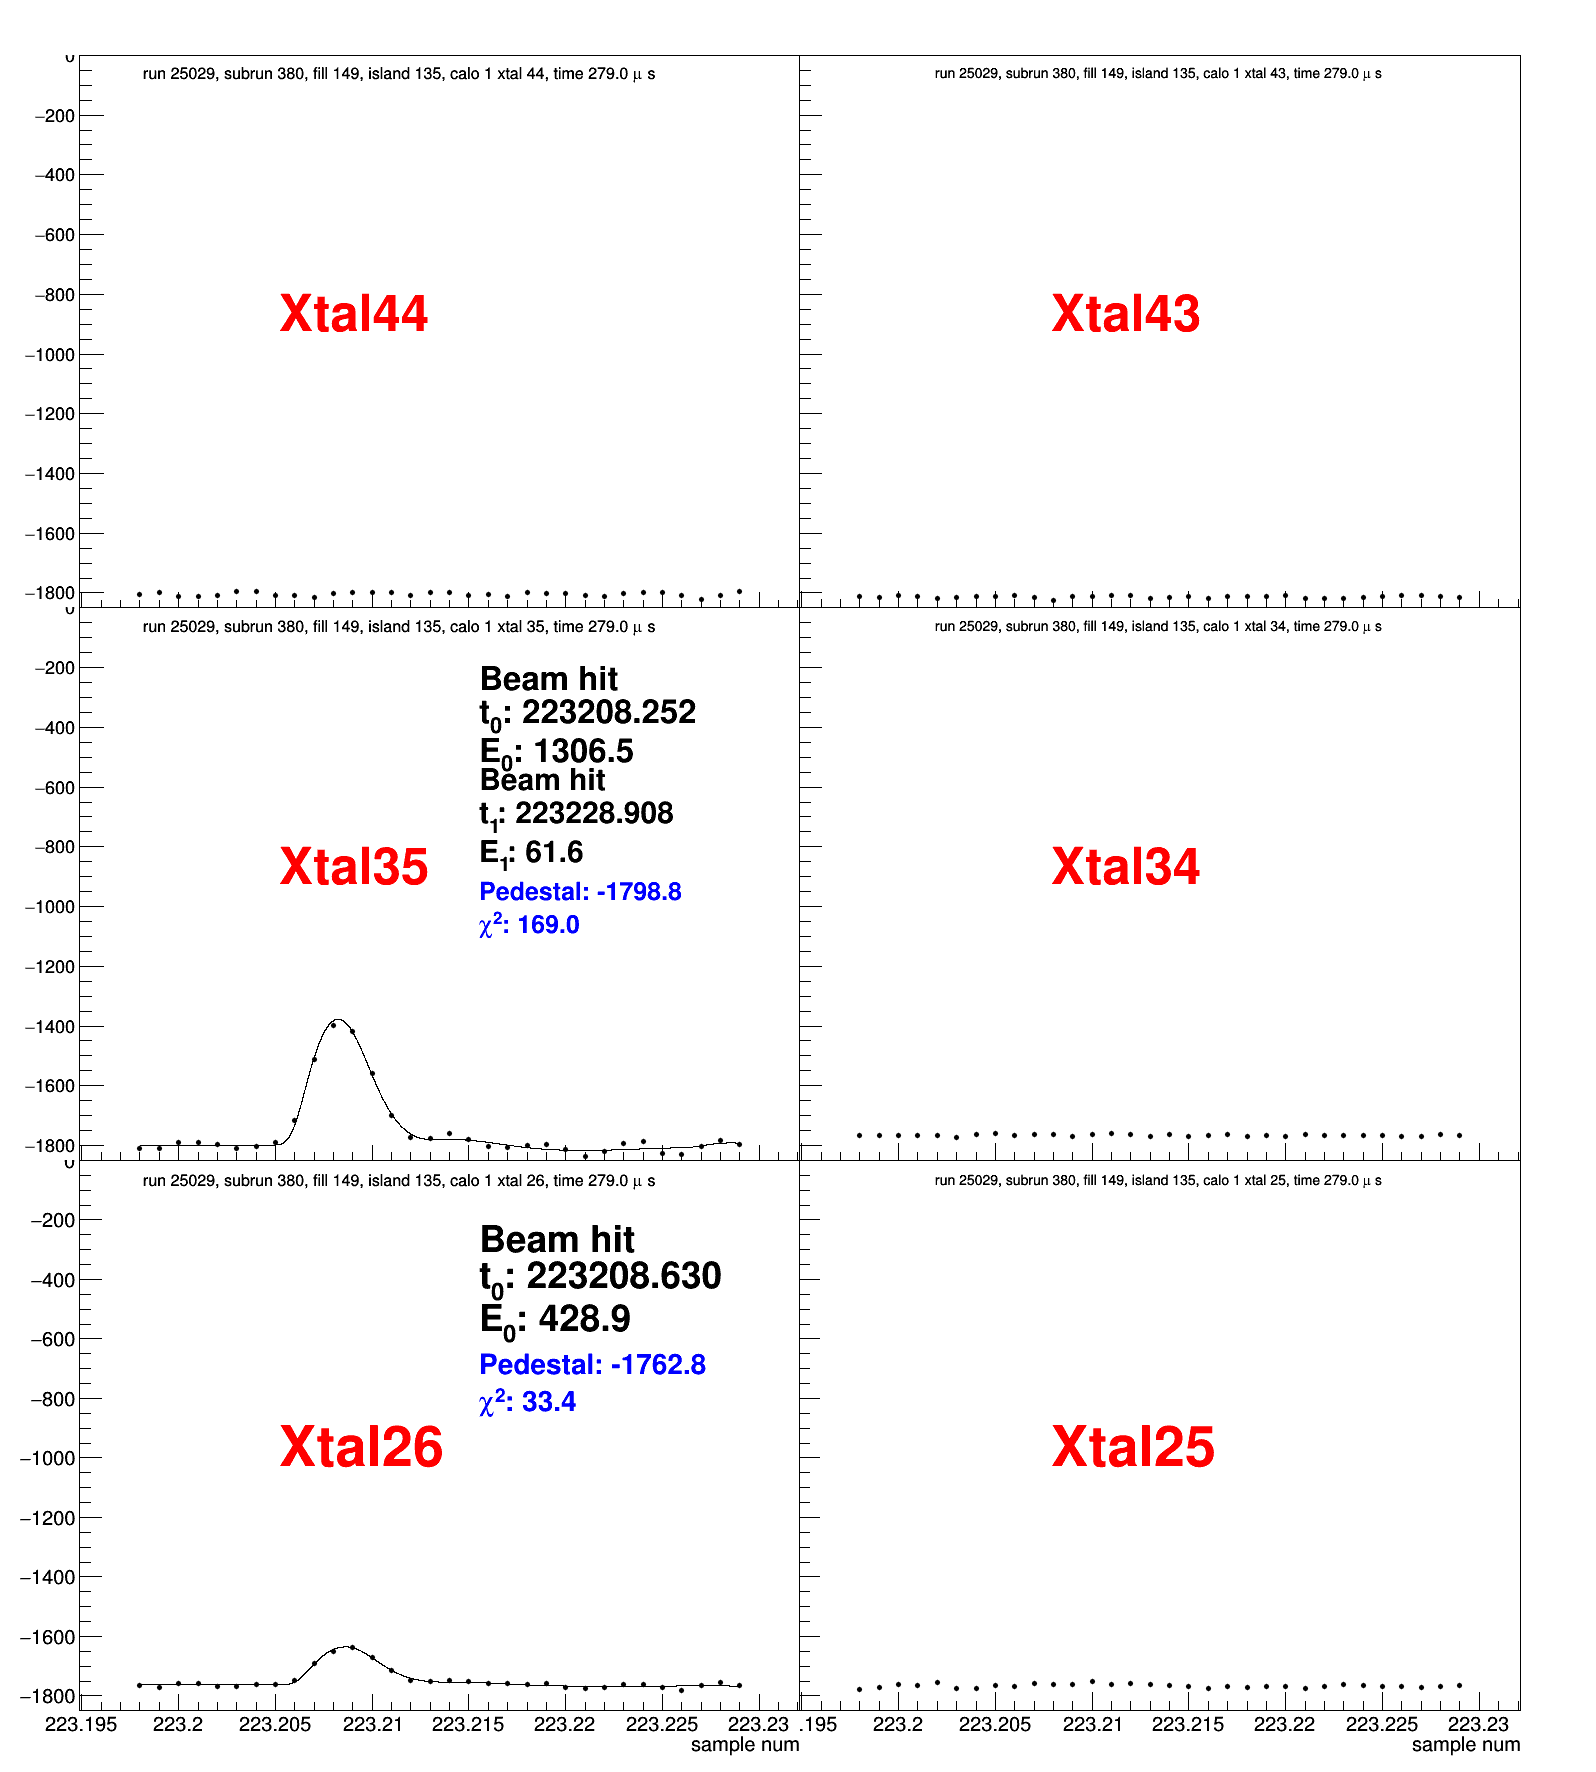

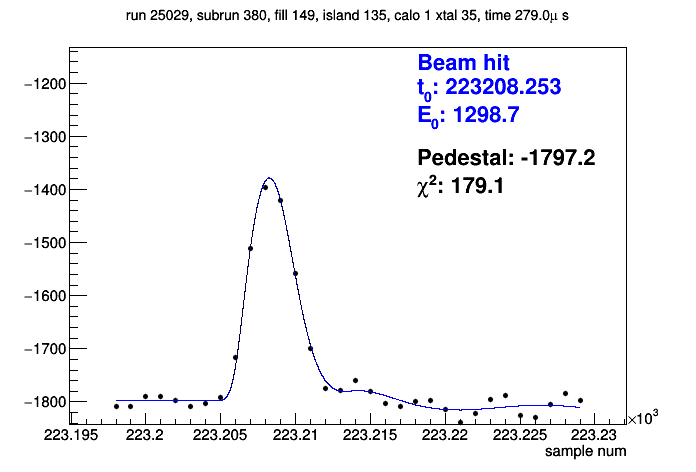

In [106]:
tag = trans_tag('1_35_149_135')
print(tag)
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
cs2 = viewer.draw_calo(*tag)
cs2[0].Draw()
cs3 = viewer_official.plot_xtal(*tag)
cs3[0].Draw()

[1, 16, 65, 117, True, None]
[['Beam hit', 't_{0}: 158151.995', 'E_{0}: 1235.3'], ['Beam hit', 't_{1}: 158179.589', 'E_{1}: 63.9']] ['Pedestal: -1767.4', '#chi^{2}: 12.5']
0.6
[['Beam hit', 't_{0}: 158151.991', 'E_{0}: 1227.0']] ['Pedestal: -1766.0', '#chi^{2}: 27.5']
0.6


Warning in <TCanvas::Constructor>: Deleting canvas with same name: calo1


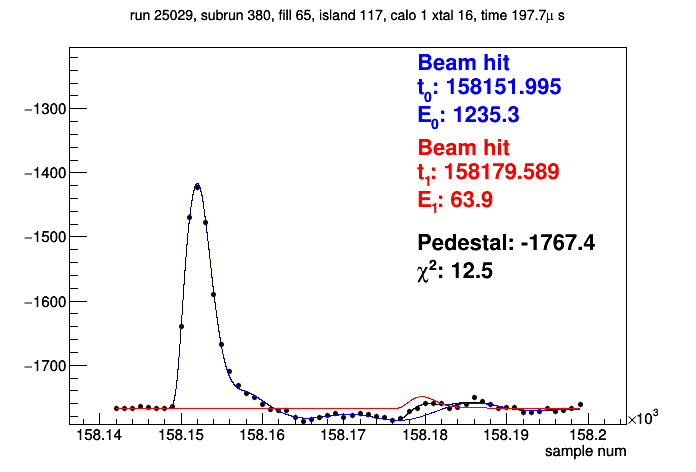

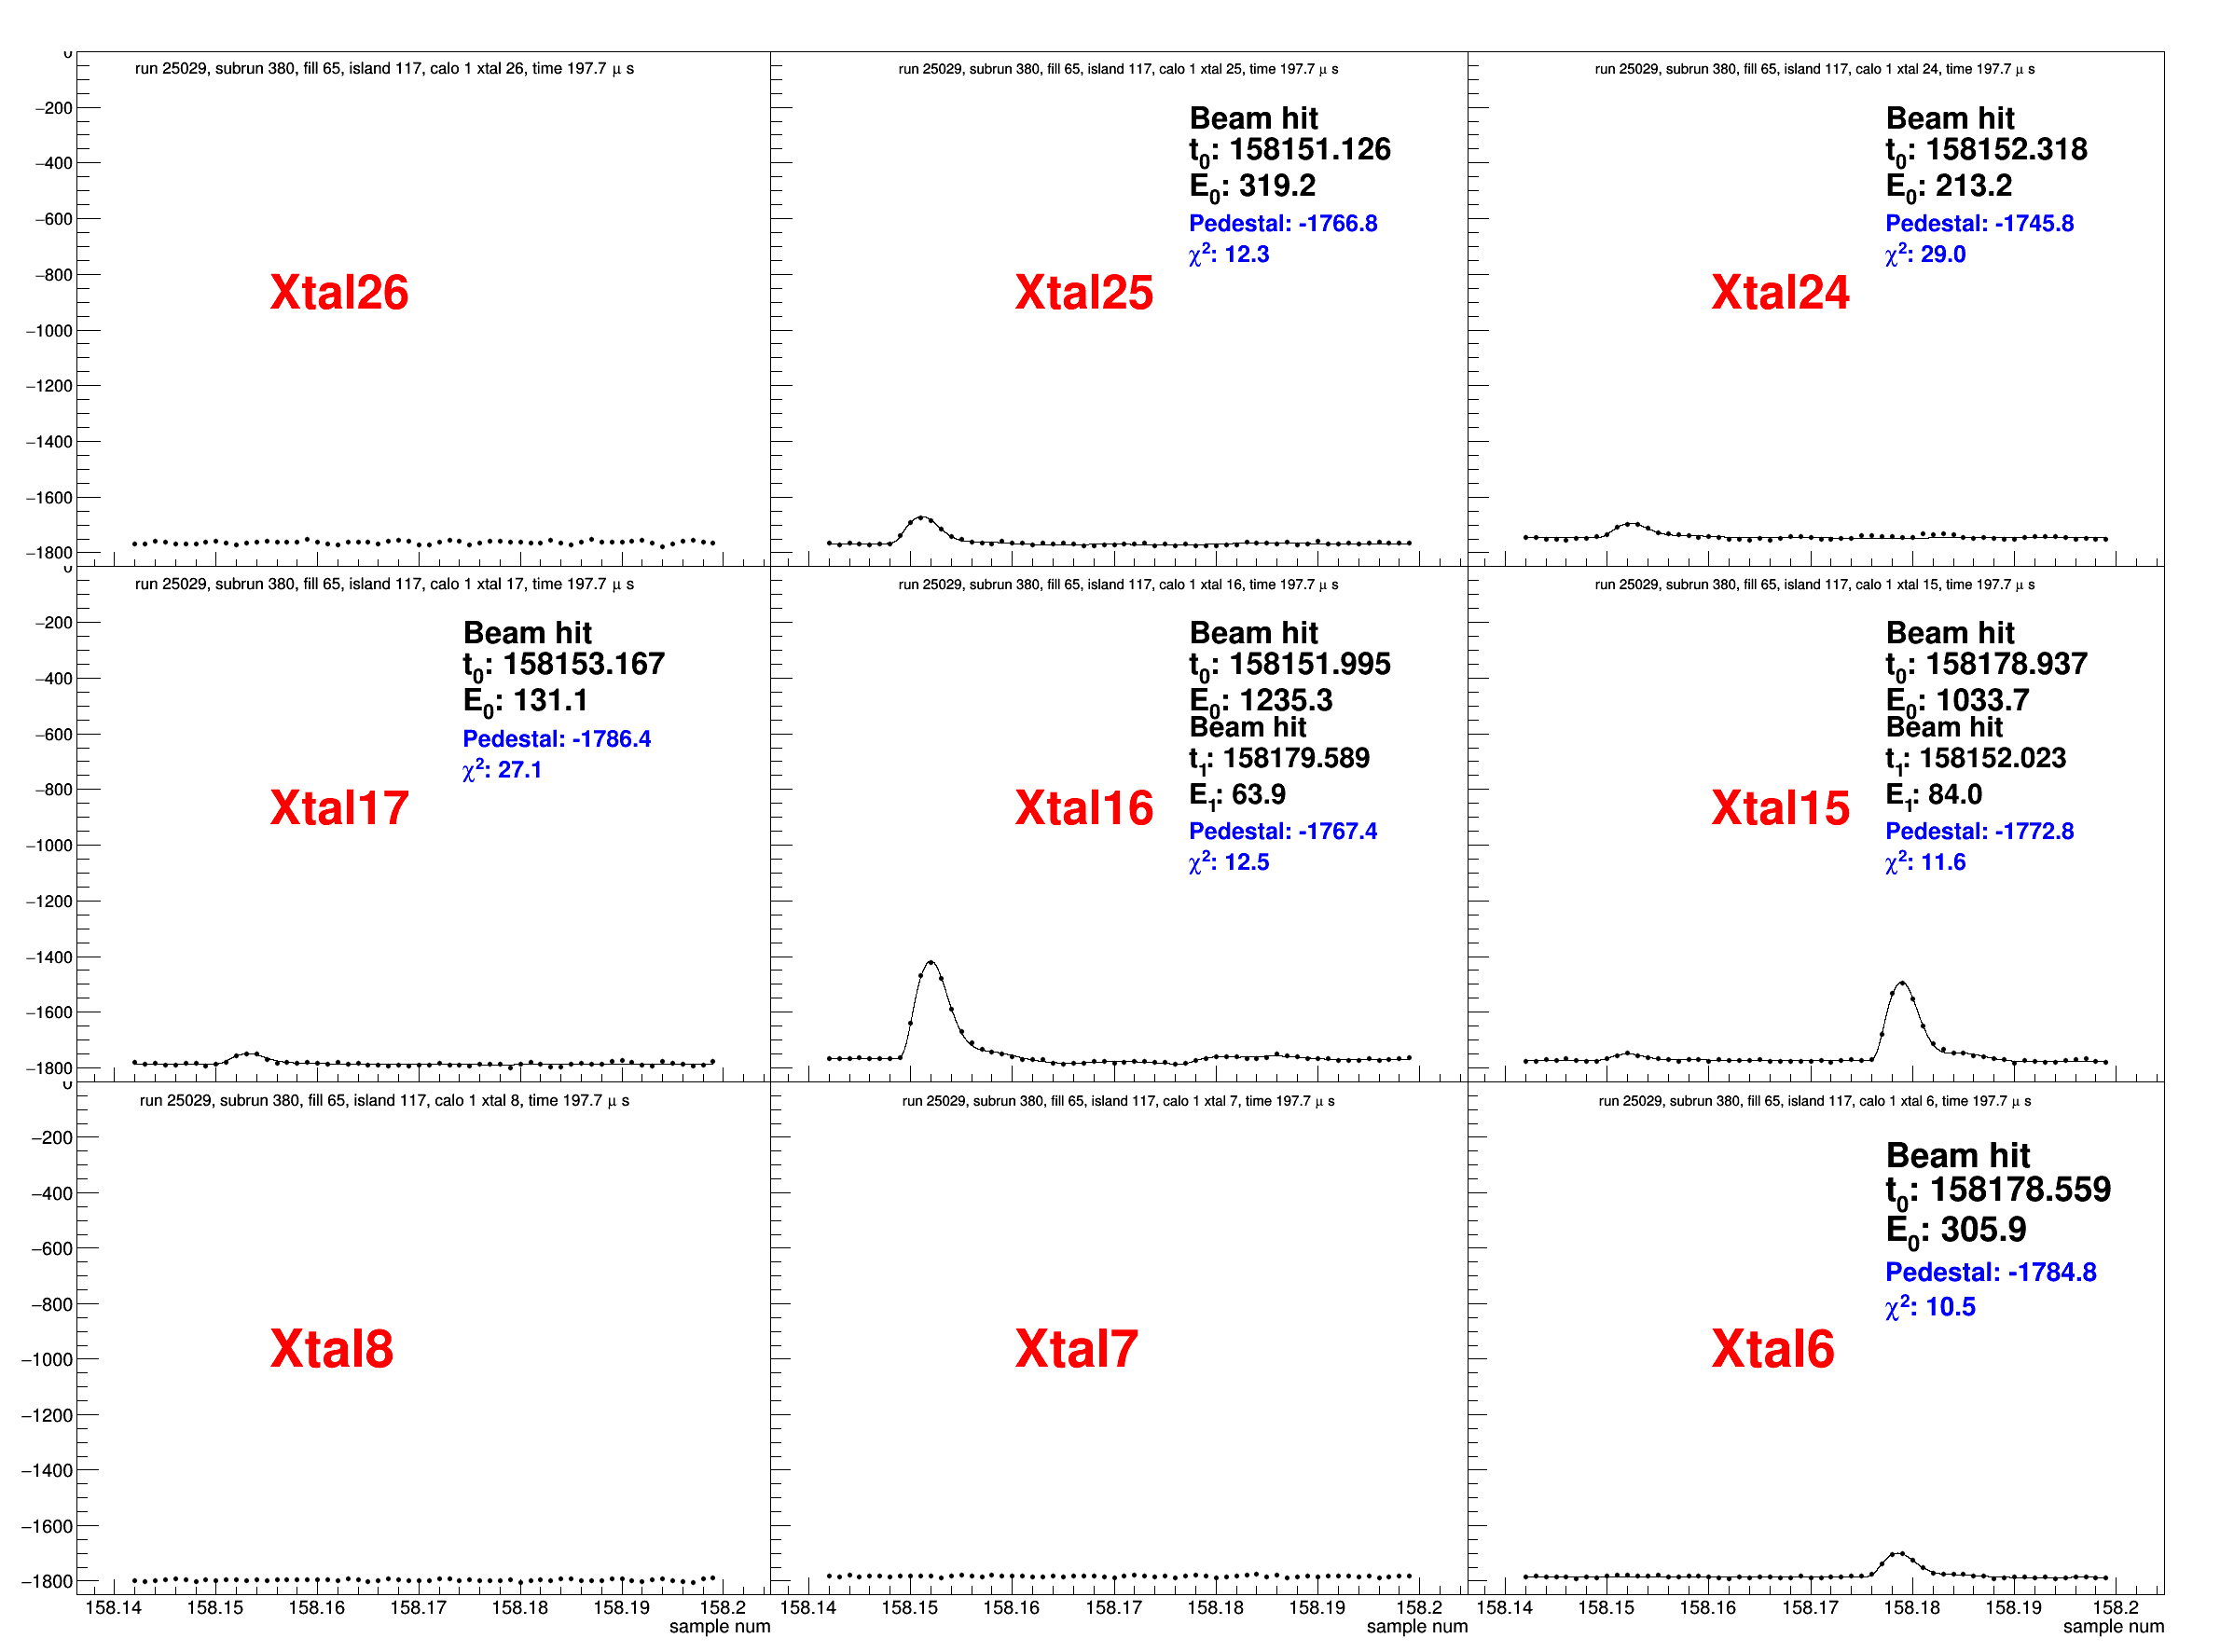

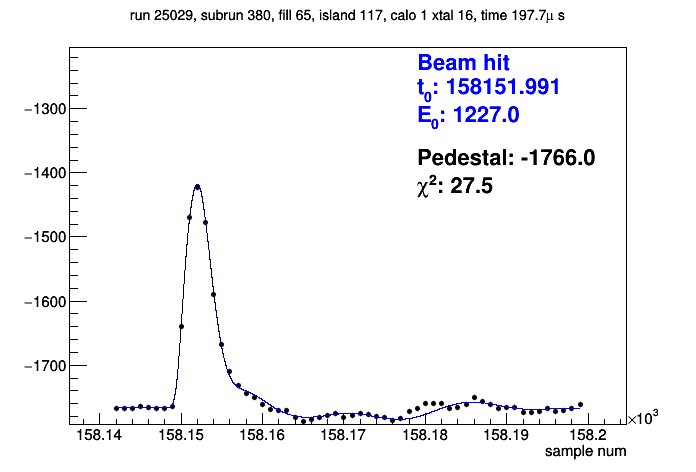

In [107]:
tag = trans_tag('1_16_65_117')
print(tag)
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
cs2 = viewer.draw_calo(*tag)
cs2[0].Draw()
cs3 = viewer_official.plot_xtal(*tag)
cs3[0].Draw()

In [28]:
# h  = r.TH1F('eff_thres','effective threshold',100,0,100)
# for e in edges:
#     if e!=None:h.Fill(e)
# c = r.TCanvas()
# h.Draw()
# c.Draw()

[1, 33, 1, 79, True, None]
[['Beam hit', 't_{0}: 117240.998', 'E_{0}: 238.0'], ['Beam hit', 't_{1}: 117270.329', 'E_{1}: 68.4']] ['Pedestal: -1794.9', '#chi^{2}: 13.5']
0.6
[['Beam hit', 't_{0}: 117240.977', 'E_{0}: 232.3']] ['Pedestal: -1793.6', '#chi^{2}: 31.6']
0.6


Warning in <TCanvas::Constructor>: Deleting canvas with same name: calo1


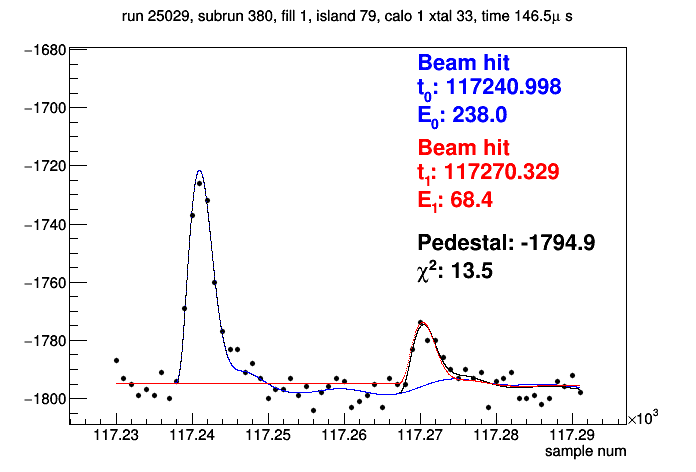

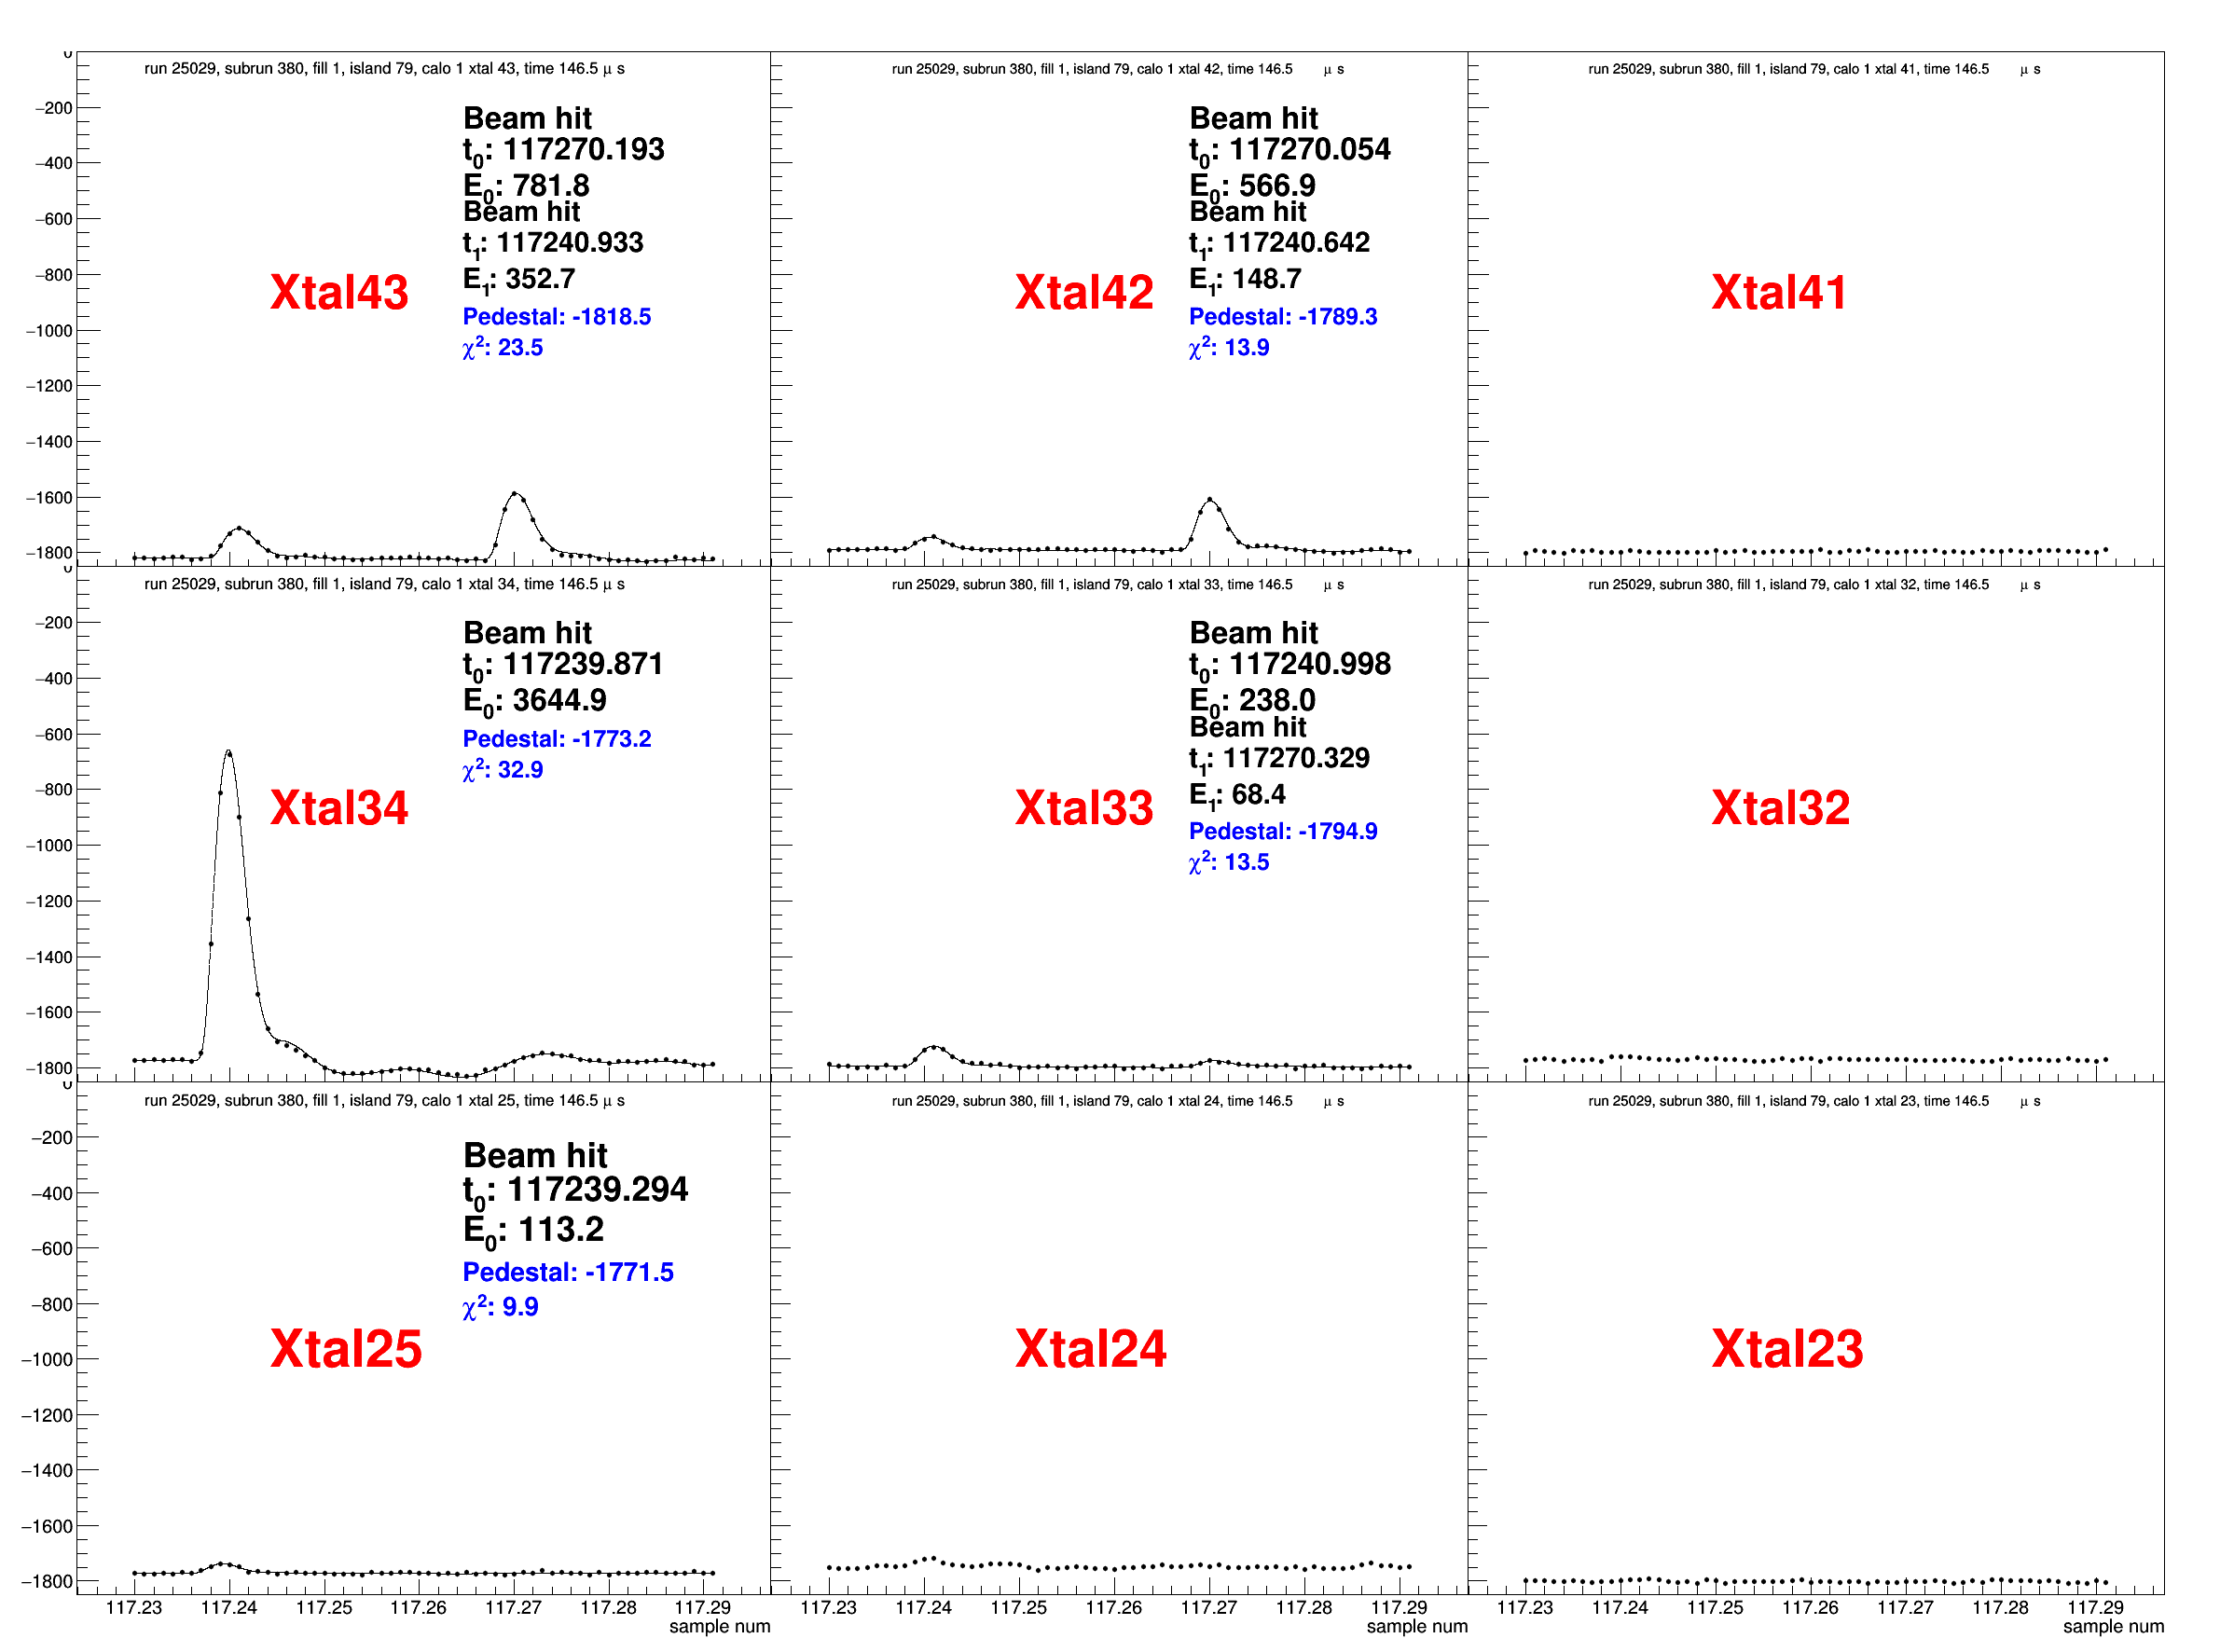

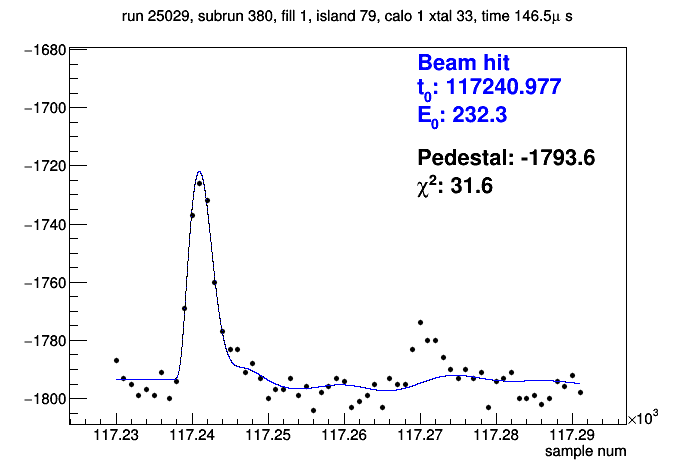

In [108]:
tag = trans_tag('1_33_1_79')
print(tag)
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
cs2 = viewer.draw_calo(*tag)
cs2[0].Draw()
cs3 = viewer_official.plot_xtal(*tag)
cs3[0].Draw()

[1, 35, 79, 159, True, None]
[['Beam hit', 't_{0}: 245693.160', 'E_{0}: 1402.1'], ['Beam hit', 't_{1}: 245713.593', 'E_{1}: 75.7']] ['Pedestal: -1800.1', '#chi^{2}: 93.4']
0.6
[['Beam hit', 't_{0}: 245693.160', 'E_{0}: 1391.3']] ['Pedestal: -1797.9', '#chi^{2}: 123.8']
0.6


Warning in <TCanvas::Constructor>: Deleting canvas with same name: calo1


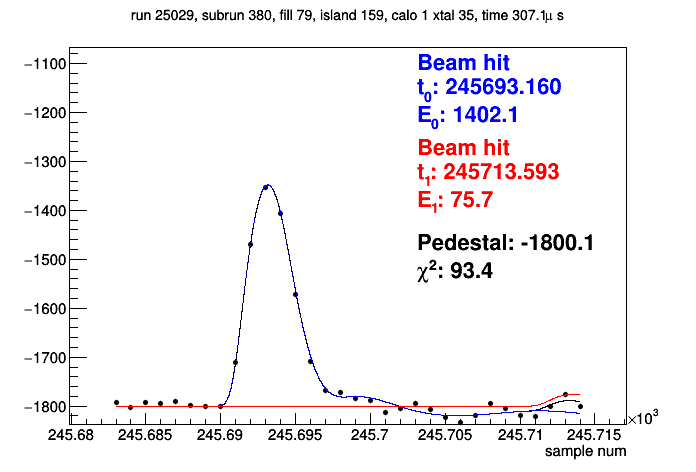

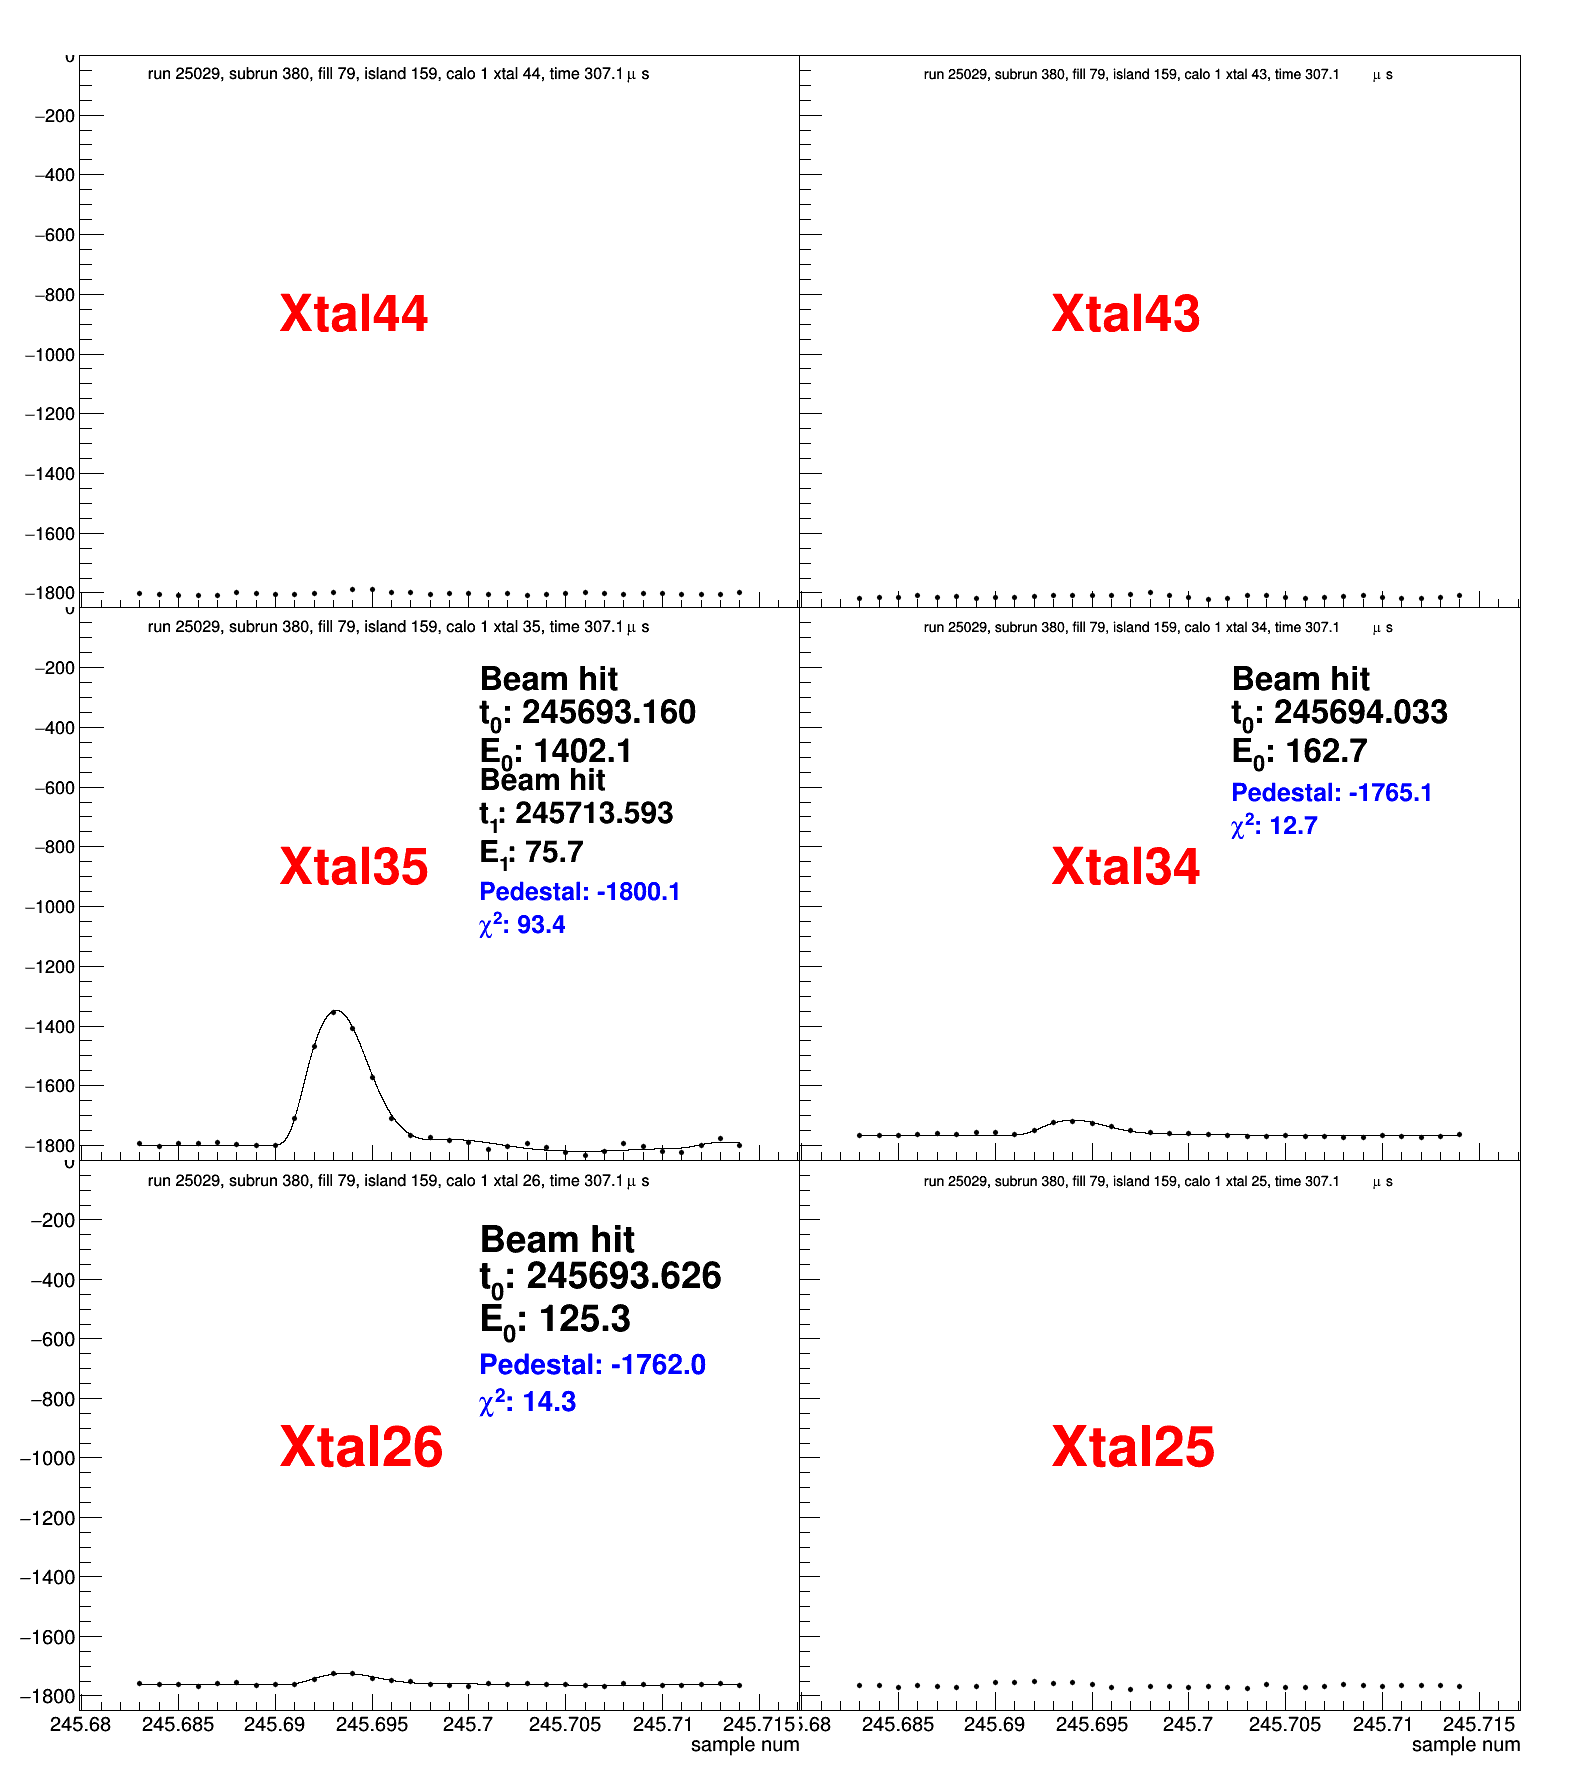

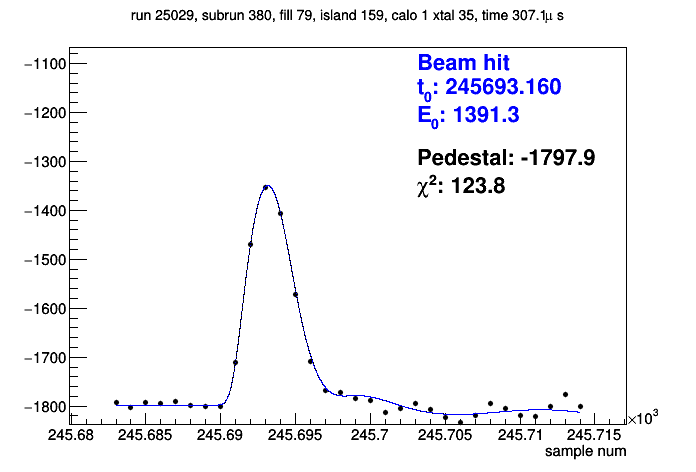

In [109]:
tag = trans_tag('1_35_79_159')
print(tag)
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
cs2 = viewer.draw_calo(*tag)
cs2[0].Draw()
cs3 = viewer_official.plot_xtal(*tag)
cs3[0].Draw()

[1, 30, 185, 69, True, None]
[['Beam hit', 't_{0}: 117206.063', 'E_{0}: 351.2'], ['Beam hit', 't_{1}: 117229.912', 'E_{1}: 96.7']] ['Pedestal: -1772.9', '#chi^{2}: 17.5']
0.6
[['Beam hit', 't_{0}: 117206.063', 'E_{0}: 336.8']] ['Pedestal: -1771.0', '#chi^{2}: 48.2']
0.6


Warning in <TCanvas::Constructor>: Deleting canvas with same name: calo1


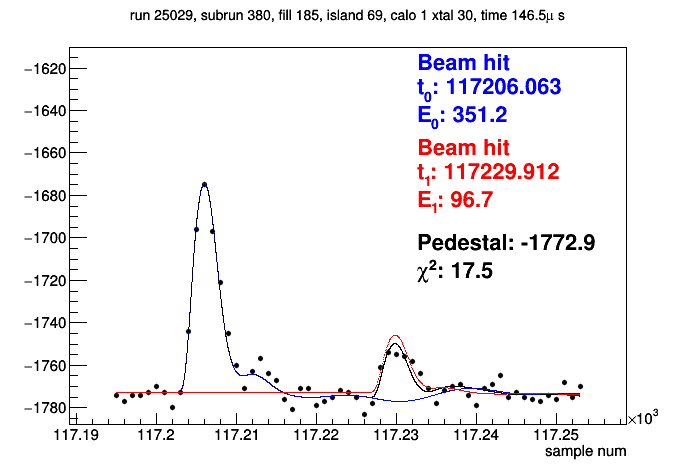

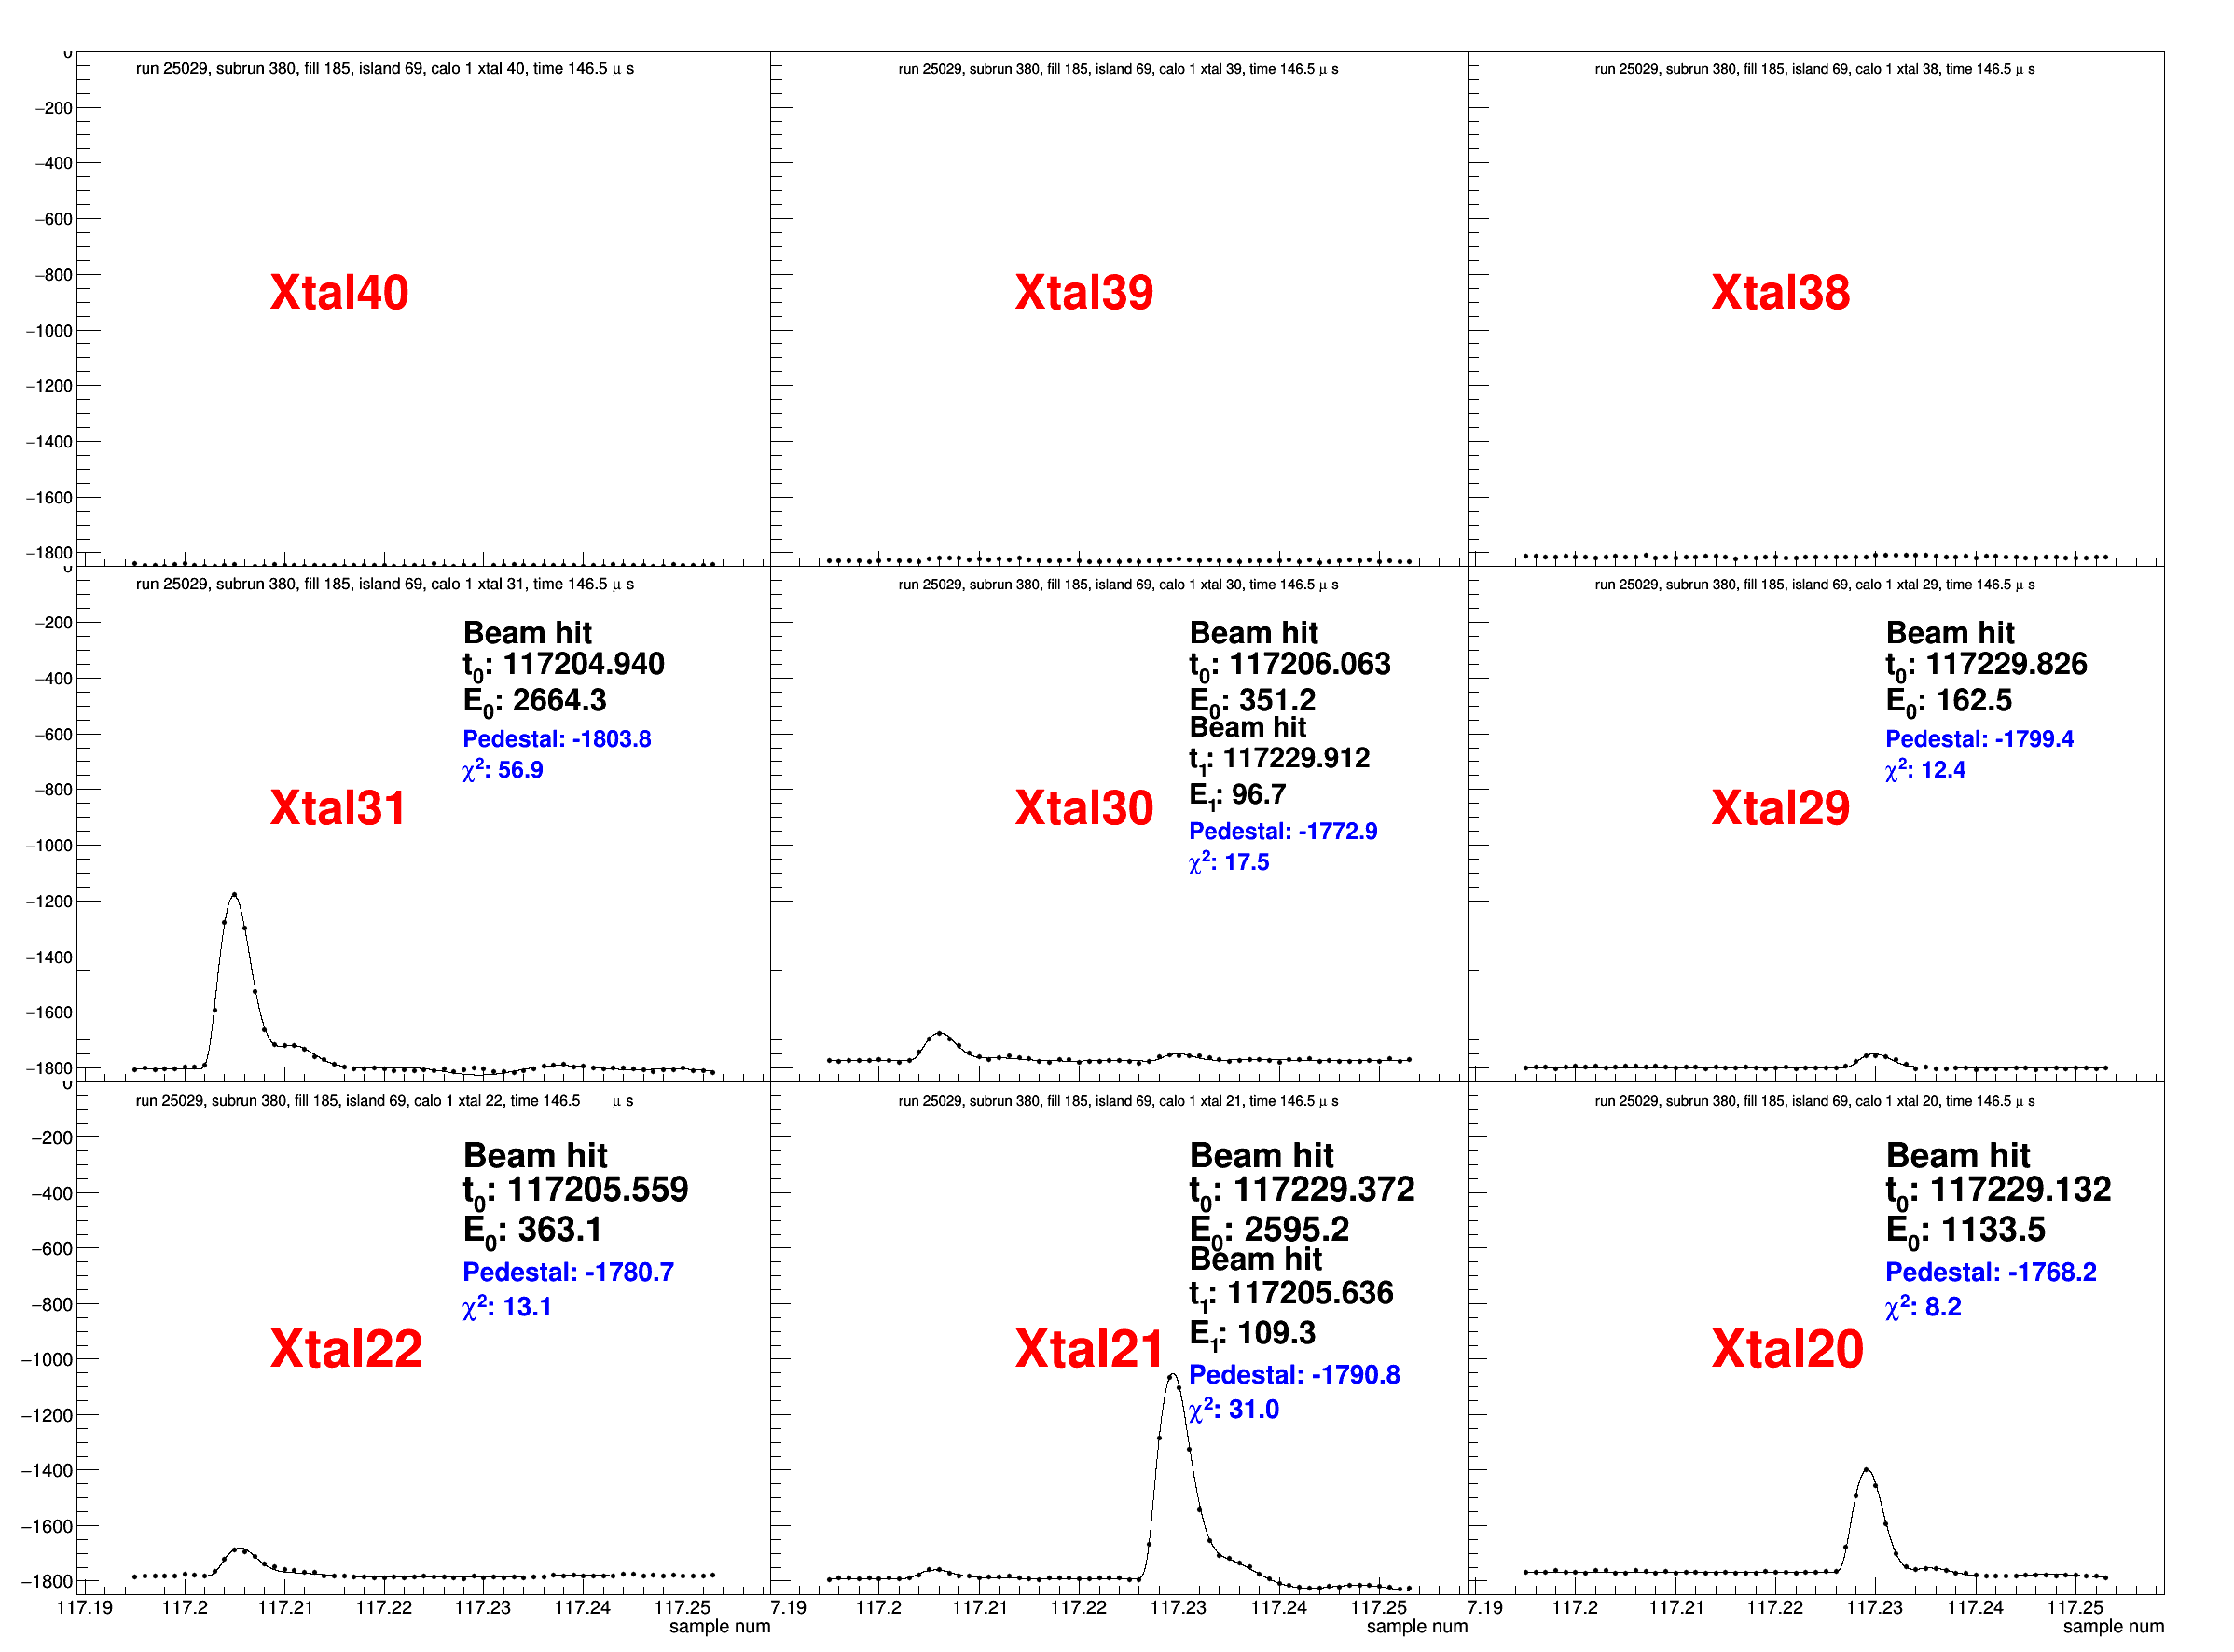

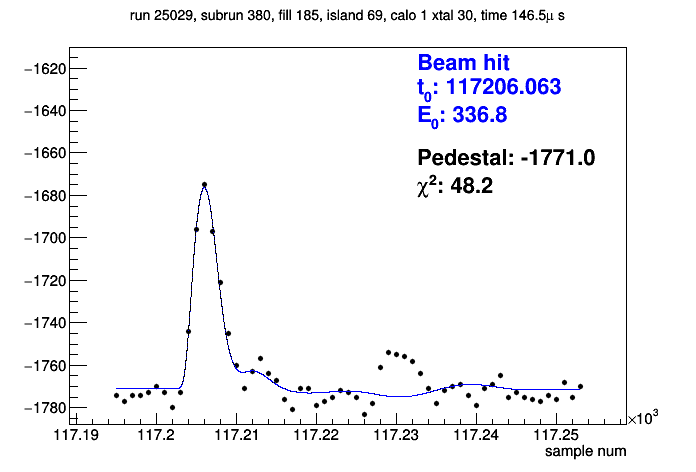

In [110]:
tag = trans_tag('1_30_185_69')
print(tag)
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
cs2 = viewer.draw_calo(*tag)
cs2[0].Draw()
cs3 = viewer_official.plot_xtal(*tag)
cs3[0].Draw()

[1, 20, 59, 68, True, None]
[['Beam hit', 't_{0}: 139504.437', 'E_{0}: 1630.8'], ['Beam hit', 't_{1}: 139523.975', 'E_{1}: 149.0']] ['Pedestal: -1769.1', '#chi^{2}: 57.4']
0.6
[['Beam hit', 't_{0}: 139504.437', 'E_{0}: 1605.5']] ['Pedestal: -1763.7', '#chi^{2}: 225.1']
0.6


Warning in <TCanvas::Constructor>: Deleting canvas with same name: calo1


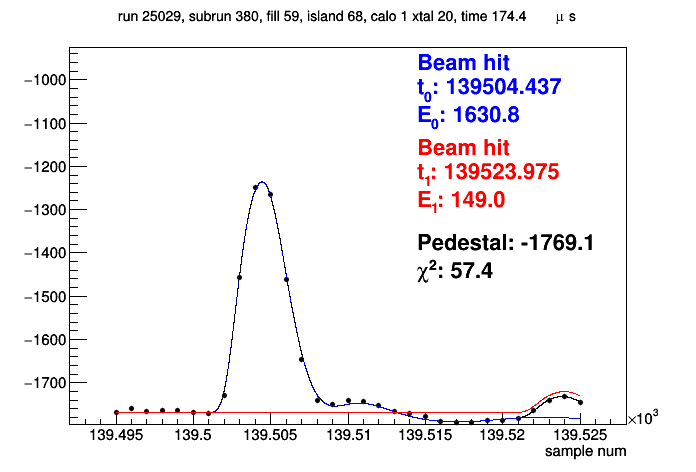

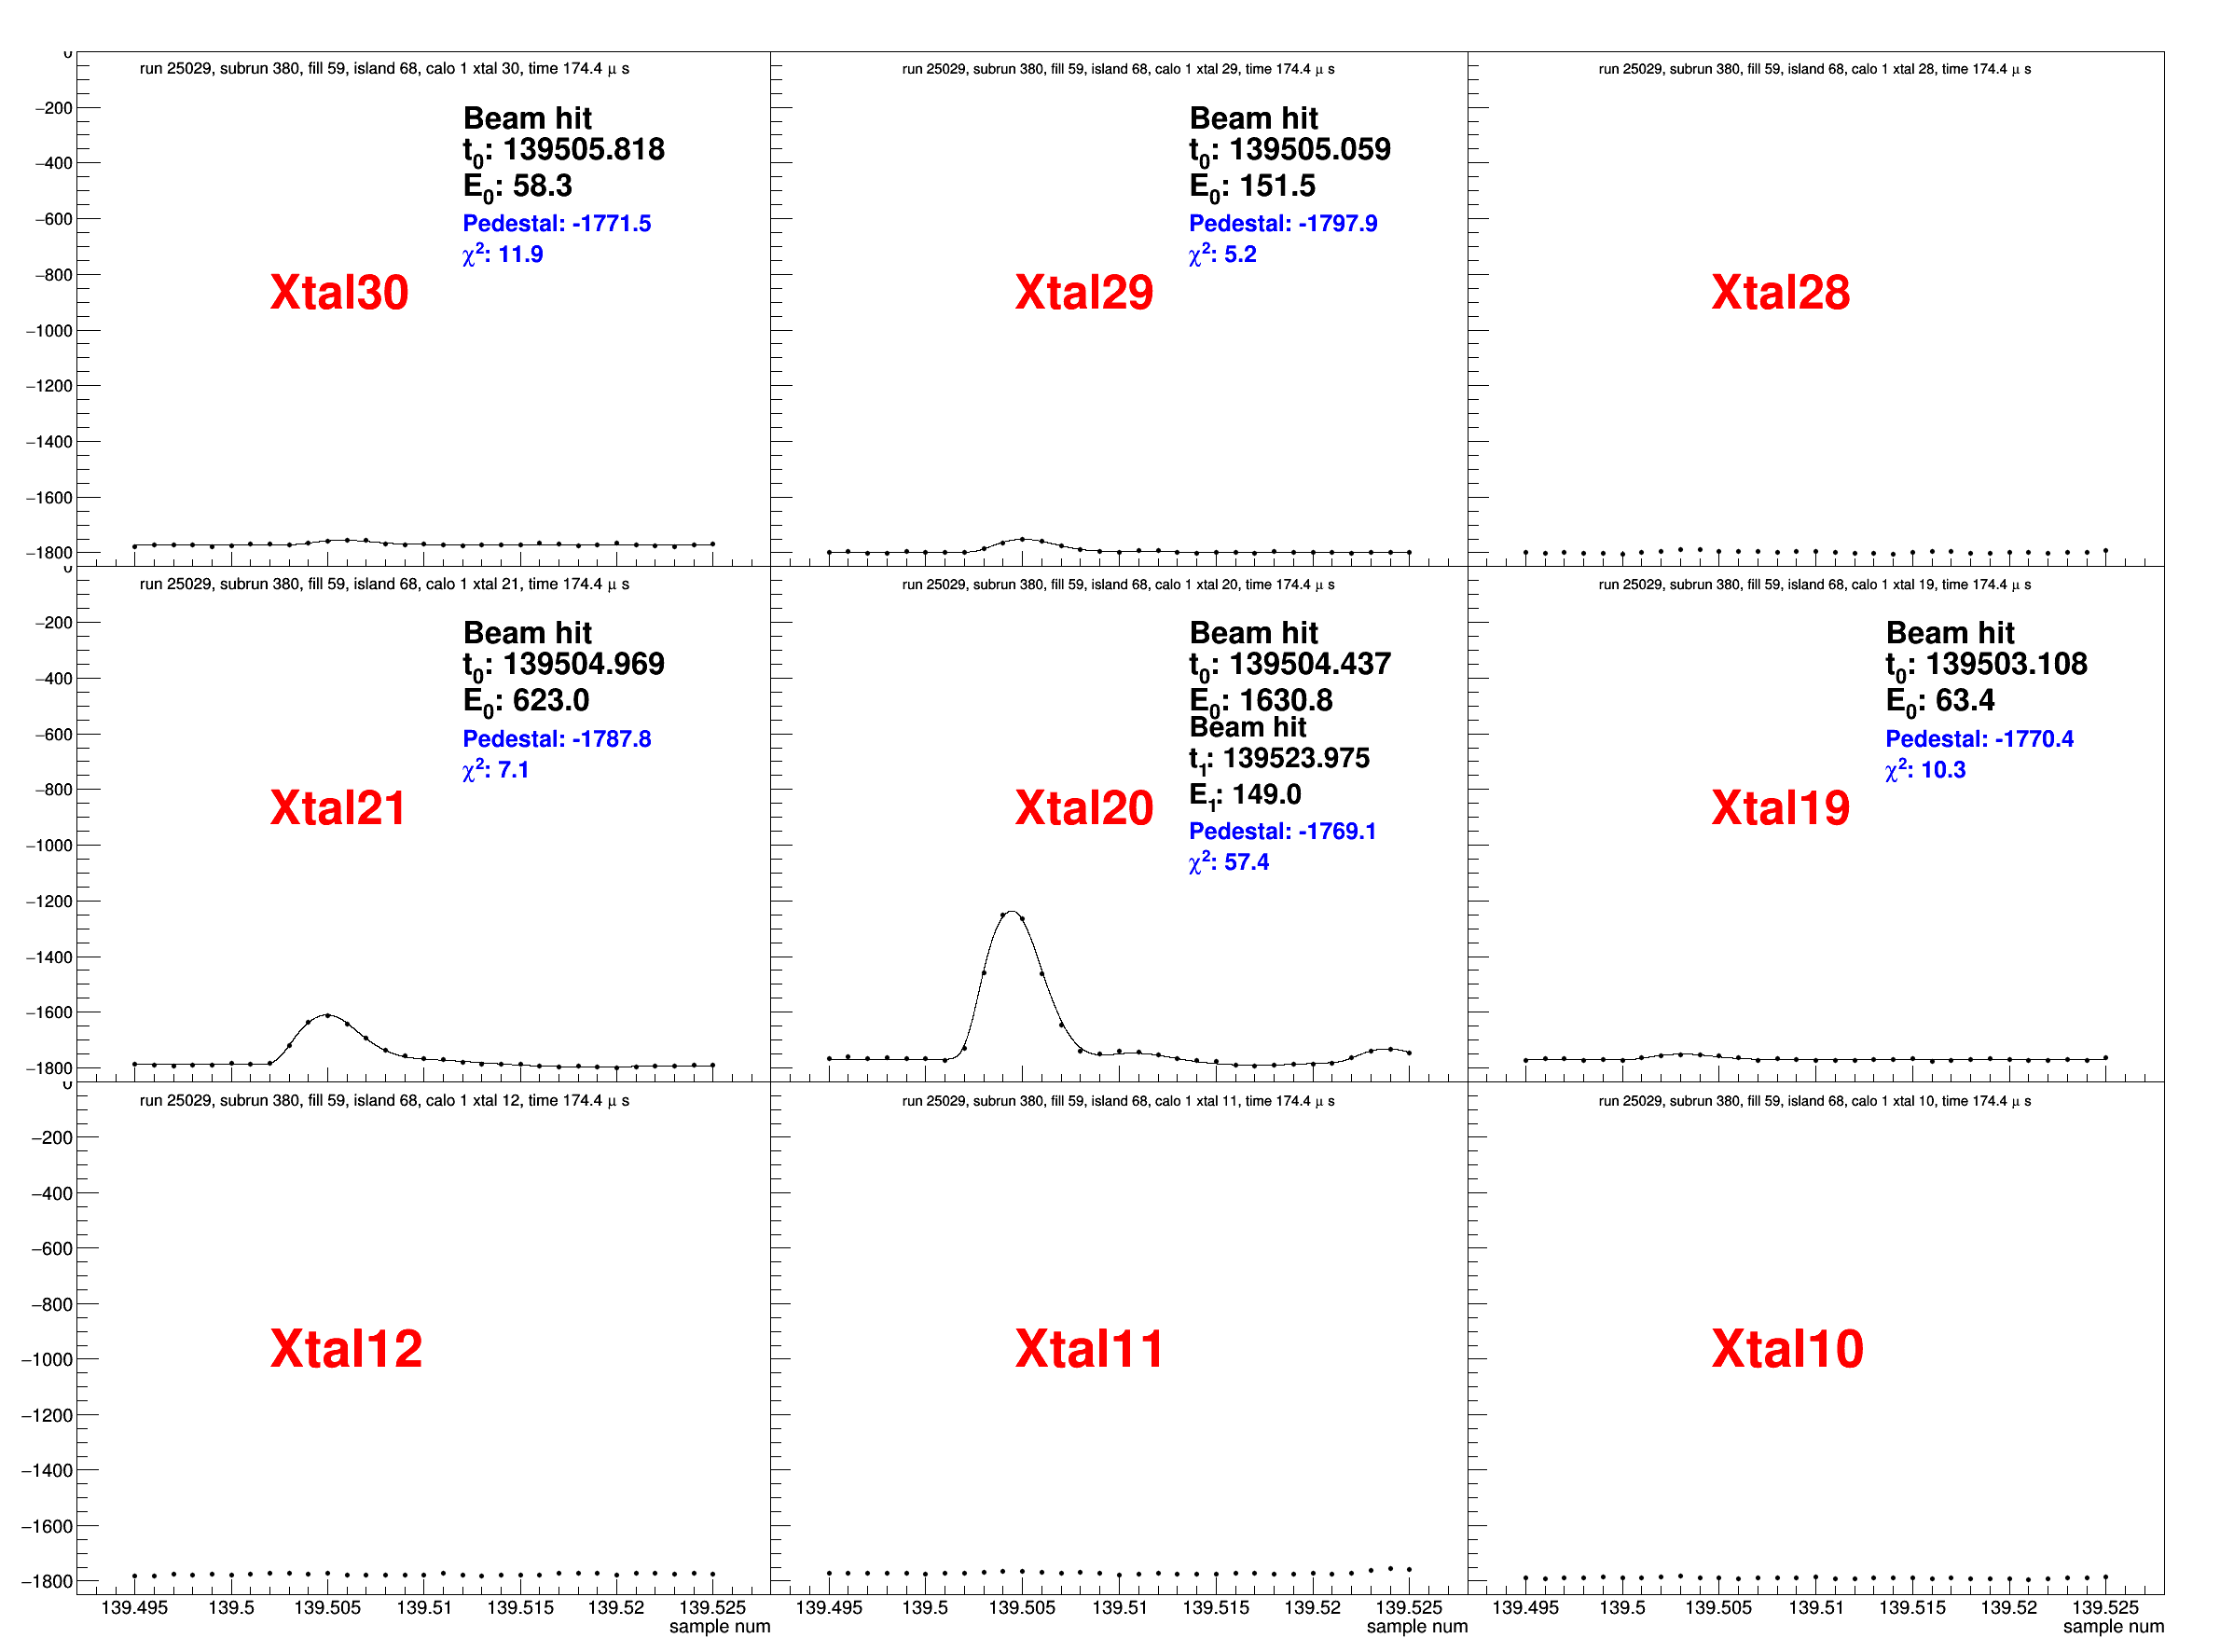

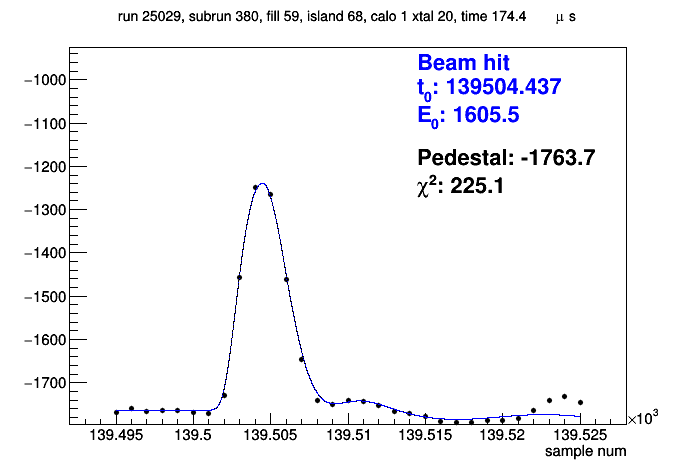

In [111]:
tag = trans_tag('1_20_59_68')
print(tag)
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
cs2 = viewer.draw_calo(*tag)
cs2[0].Draw()
cs3 = viewer_official.plot_xtal(*tag)
cs3[0].Draw()

In [ ]:
tag = trans_tag('1_19_11_56')
print(tag)
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
cs2 = viewer.draw_calo(*tag)
cs2[0].Draw()
cs3 = viewer_official.plot_xtal(*tag)
cs3[0].Draw()

In [ ]:
tag = trans_tag('1_23_19_93')
print(tag)
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
cs2 = viewer.draw_calo(*tag)
cs2[0].Draw()
cs3 = viewer_official.plot_xtal(*tag)
cs3[0].Draw()

[1, 22, 71, 77, True, None]
[['Beam hit', 't_{0}: 128843.234', 'E_{0}: 264.1'], ['Beam hit', 't_{1}: 128876.557', 'E_{1}: 153.5']] ['Pedestal: -1779.9', '#chi^{2}: 11.8']
0.6
[['Beam hit', 't_{0}: 128843.229', 'E_{0}: 254.8']] ['Pedestal: -1777.1', '#chi^{2}: 88.8']
0.6


Warning in <TCanvas::Constructor>: Deleting canvas with same name: calo1


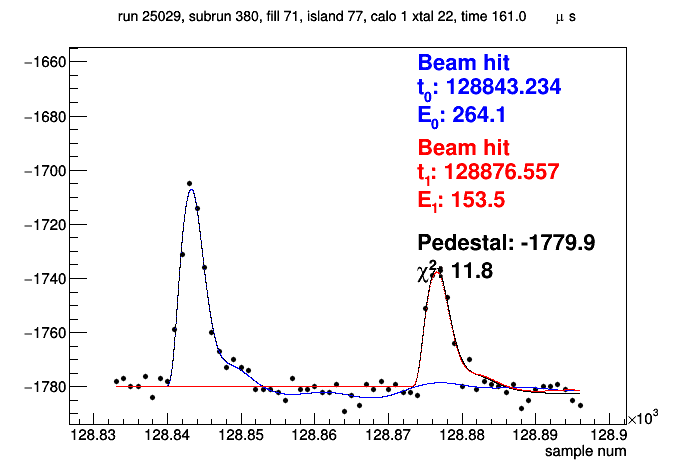

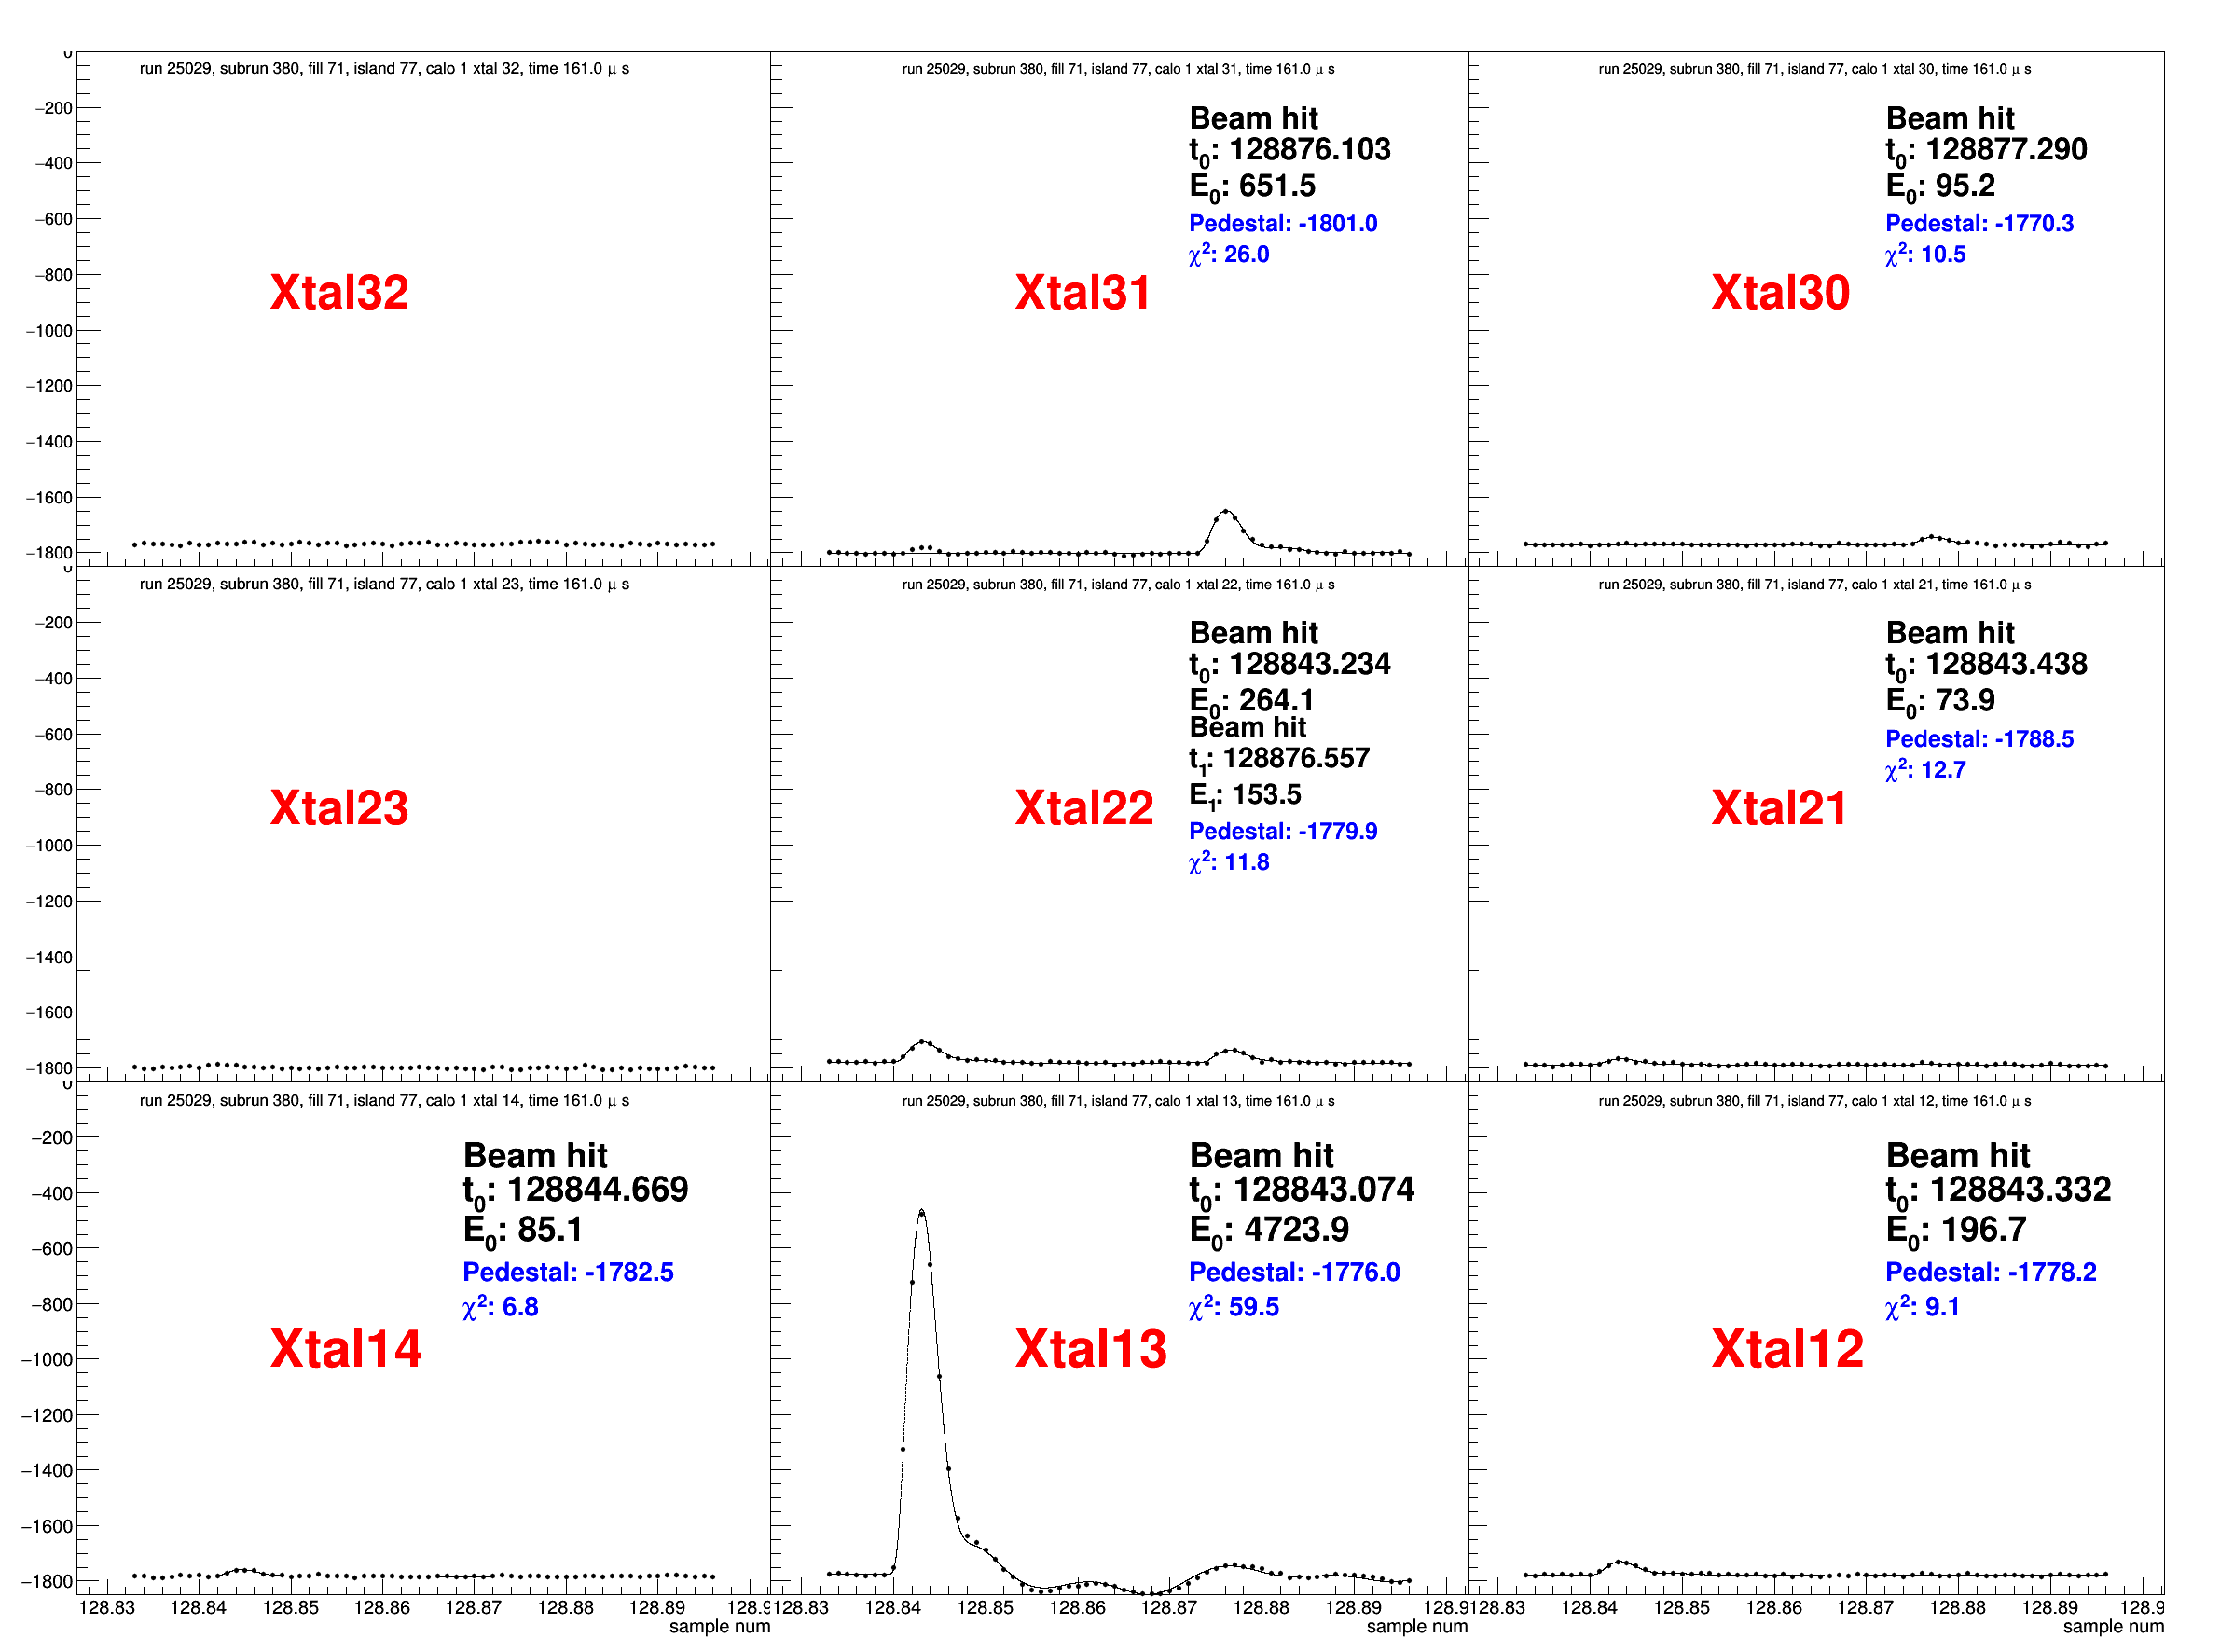

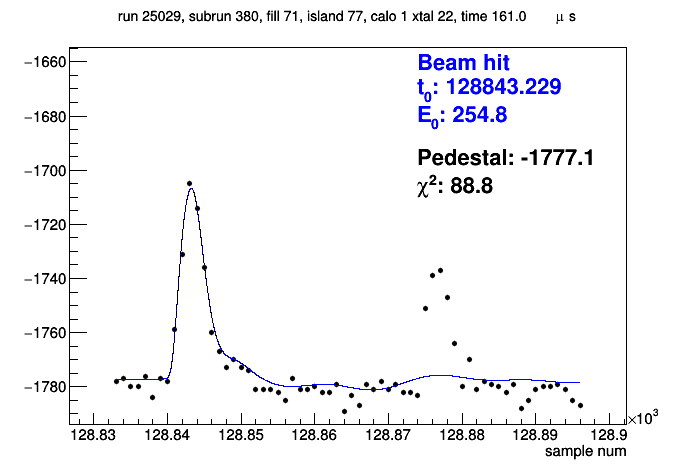

In [112]:
tag = trans_tag('1_22_71_77')
print(tag)
cs = viewer.plot_xtal(*tag)
cs[0].Draw()
cs2 = viewer.draw_calo(*tag)
cs2[0].Draw()
cs3 = viewer_official.plot_xtal(*tag)
cs3[0].Draw()